In [1]:
import sys
sys.path.append("../")
import py_neb
sys.path.append("../../flynn_code/py_neb_demos/")
import utils

import matplotlib.pyplot as plt
import numpy as np
import h5py

/home/kyle/code/ActionMinimization/py_neb/py_neb


In [2]:
def standard_pes(xx,yy,zz,clipRange=(-5,30)):
    #TODO: pull some (cleaner) options from ML_Funcs_Class
    #Obviously not general - good luck plotting a 3D PES lol
    fig, ax = plt.subplots()
    if clipRange is None:
        clipRange = (zz.min()-0.2,zz.max()+0.2)
    #USE THIS COLORMAP FOR PESs - has minima in blue and maxima in red
    cf = ax.contourf(xx,yy,zz.clip(clipRange[0],clipRange[1]),\
                     cmap="Spectral_r",levels=np.linspace(clipRange[0],clipRange[1],25))
    plt.colorbar(cf,ax=ax)
    
    ax.set(xlabel=r"$Q_{20}$ (b)",ylabel=r"$Q_{30}$ (b${}^{3/2}$)")
    return fig, ax

def h5_get_keys(obj):
    #Taken from https://stackoverflow.com/a/59898173
    keys = (obj.name,)
    if isinstance(obj,h5py.Group):
        for key, value in obj.items():
            if isinstance(value,h5py.Group):
                #Is recursive here
                keys = keys + h5_get_keys(value)
            else:
                keys = keys + (value.name,)
    return keys

def read_from_h5(fName):
    datDictOut = {}
    attrDictOut = {}
    
    h5File = h5py.File(fName,"r")
    allDataSets = [key for key in h5_get_keys(h5File) if isinstance(h5File[key],h5py.Dataset)]
    for key in allDataSets:
        datDictOut[key.lstrip("/")] = np.array(h5File[key])
        
    #Does NOT pull out sub-attributes
    for attr in h5File.attrs:
        attrIn = np.array(h5File.attrs[attr])
        #Some data is a scalar, and so would otherwise be stored as a zero-dimensional
        #numpy array. That's just confusing.
        if attrIn.shape == ():
            attrIn = attrIn.reshape((1,))
        attrDictOut[attr.lstrip("/")] = attrIn
    
    h5File.close()
        
    return datDictOut, attrDictOut

def local_midpoint_grad(func,points,eps=10**(-8)):
    """
    Midpoint finite difference. Probably best if not used with actual DFT calculations,
        vs a forwards/reverse finite difference
    Assumes func only depends on a single point (vs the action, which depends on
         all of the points)
    """
    if len(points.shape) == 1:
        points = points.reshape((1,-1))
    nPoints, nDims = points.shape
    
    gradOut = np.zeros((nPoints,nDims))
    for ptIter in range(nPoints):
        for dimIter in range(nDims):
            step = np.zeros(nDims)
            step[dimIter] = 1
            
            forwardStep = points[ptIter] + eps/2*step
            backwardStep = points[ptIter] - eps/2*step
            
            forwardEval = func(forwardStep)
            backwardEval = func(backwardStep)
            
            gradOut[ptIter,dimIter] = (forwardEval - backwardEval)/eps
    
    return gradOut
def mid_action_grad(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    
    for ptIter in range(nPts):
        for dimIter in range(nDims):
            eps_eff = eps/2.0
            fsteps = path.copy()
            fsteps[ptIter,dimIter] += eps_eff
            bsteps = path.copy()
            bsteps[ptIter,dimIter] -= eps_eff
            actionAtStep, potAtStepf, massAtStep, actArrAtStepf = target_func(fsteps,potential,mass)
            actionAtStep, potAtStepb, massAtStep, actArrAtStepb = target_func(bsteps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStepf[ptIter] - potAtStepb[ptIter])/eps
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            gradOfAction[ptIter,dimIter] = (actArrAtStepf[ptIter] - actArrAtStepb[ptIter])/eps
    
    return gradOfAction, gradOfPes
def local_action_grad(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    
    for ptIter in range(nPts):
        for dimIter in range(nDims):
            eps_eff = eps#-dimIter*eps/2.0
            steps = path.copy()
            steps[ptIter,dimIter] += eps_eff
            actionAtStep, potAtStep, massAtStep, actArrAtStep = target_func(steps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStep[ptIter] - potentialOnPath[ptIter])/eps_eff
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            gradOfAction[ptIter,dimIter] = (actArrAtStep[ptIter] - actionArr[ptIter])/eps_eff
    
    return gradOfAction, gradOfPes
def analytic_action_grad_sq(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    hbarc = 197.32696931
    for ptIter in range(1,nPts-1):
        dnorm=np.linalg.norm(path[ptIter] - path[ptIter-1])
        dnormP1=np.linalg.norm(path[ptIter+1] - path[ptIter])
        dhat = (path[ptIter] - path[ptIter-1])/dnorm
        dhatP1 = (path[ptIter+1] - path[ptIter])/dnormP1
        for dimIter in range(nDims):
            eps_eff = eps#-dimIter*eps/2.0

            steps = path.copy()
            steps[ptIter,dimIter] += eps_eff
            actionAtStep, potAtStep, massAtStep, actArrAtStep = target_func(steps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStep[ptIter] - potentialOnPath[ptIter])/eps_eff
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            #gradOfAction[ptIter,dimIter] = (actArrAtStep[ptIter] - actionArr[ptIter])/eps_eff
        mu=massOnPath[ptIter,0,0]#/hbarc**2
        gradOfAction[ptIter] = 0.5*(\
            (mu*potentialOnPath[ptIter] + mu*potentialOnPath[ptIter-1])*dhat-\
            (mu*potentialOnPath[ptIter] + mu*potentialOnPath[ptIter+1])*dhatP1+\
            mu*gradOfPes[ptIter]*(dnorm+dnormP1))
    
    return gradOfAction, gradOfPes
def analytic_action_grad(path,potential,potentialOnPath,mass,massOnPath,\
                        target_func):
    """
    potential and mass are as allowed in "action" func; will let that do the error
    checking (for now...?)
    
    Takes forwards finite difference approx of any action-like function
    
    Does not return the gradient of the mass function, as that's not used elsewhere
    in the algorithm
    
    Maybe put this + action inside of LeastActionPath? not sure how we want to structure that part
    """
    eps = 10**(-8)
    
    gradOfPes = np.zeros(path.shape)
    gradOfAction = np.zeros(path.shape)
    
    nPts, nDims = path.shape
    
    actionOnPath, _, _, actionArr = target_func(path,potentialOnPath,massOnPath)
    hbarc = 197.32696931
    for ptIter in range(1,nPts-1):
        dnorm=np.linalg.norm(path[ptIter] - path[ptIter-1])
        dnormP1=np.linalg.norm(path[ptIter+1] - path[ptIter])
        dhat = (path[ptIter] - path[ptIter-1])/dnorm
        dhatP1 = (path[ptIter+1] - path[ptIter])/dnormP1
        for dimIter in range(nDims):
            eps_eff = eps#-dimIter*eps/2.0

            steps = path.copy()
            steps[ptIter,dimIter] += eps_eff
            actionAtStep, potAtStep, massAtStep, actArrAtStep = target_func(steps,potential,mass)
            
            gradOfPes[ptIter,dimIter] = (potAtStep[ptIter] - potentialOnPath[ptIter])/eps_eff
            #gradOfAction[ptIter,dimIter] = (actionAtStep - actionOnPath)/eps
            #gradOfAction[ptIter,dimIter] = (actArrAtStep[ptIter] - actionArr[ptIter])/eps_eff
        mu=massOnPath[ptIter,0,0]#/hbarc**2
        gradOfAction[ptIter] = 0.5*(\
            (np.sqrt(2*mu*potentialOnPath[ptIter]) + np.sqrt(2*mu*potentialOnPath[ptIter-1]))*dhat-\
            (np.sqrt(2*mu*potentialOnPath[ptIter]) + np.sqrt(2*mu*potentialOnPath[ptIter+1]))*dhatP1+\
            mu*gradOfPes[ptIter]*(dnorm+dnormP1) / np.sqrt(2*mu*potentialOnPath[ptIter]))
    
    return gradOfAction, gradOfPes
def localAction(path,potential,masses=None):
    """
    Allowed masses:
        -Constant mass; set masses = None
        -Array of values; set masses to a numpy array of shape (nPoints, nDims, nDims)
        -A function; set masses to a function
    Allowed potential:
        -Array of values; set potential to a numpy array of shape (nPoints,)
        -A function; set masses to a function
        
    Computes action as
        $ S = \sum_{i=1}^{nPoints} \sqrt{2 E(x_i) M_{ab}(x_i) (x_i-x_{i-1})^a(x_i-x_{i-1})^b} $
    """
    nPoints, nDims = path.shape
    
    if masses is None:
        massArr = np.full((nPoints,nDims,nDims),np.identity(nDims))
    elif not isinstance(masses,np.ndarray):
        massArr = masses(path)
    else:
        massArr = masses
        
    massDim = (nPoints, nDims, nDims)
    if massArr.shape != massDim:
        raise ValueError("Dimension of massArr is "+str(massArr.shape)+\
                         "; required shape is "+str(massDim)+". See action function.")
    
    if not isinstance(potential,np.ndarray):
        potArr = potential(path)
    else:
        potArr = potential
    
    potShape = (nPoints,)
    if potArr.shape != potShape:
        raise ValueError("Dimension of potArr is "+str(potArr.shape)+\
                         "; required shape is "+str(potShape)+". See action function.")
    
    #for ptIter in range(nPoints):
    #    if potArr[ptIter] < 0:
    #        potArr[ptIter] = 0.001
    actArr = np.zeros(potShape)
    # if np.any(potArr[1:-2]<0):
    #     print("Path: ")
    #     print(path)
    #     print("Potential: ")
    #     print(potArr)
    #     raise ValueError("Encountered energy E < 0; stopping.")
        
    #Actual calculation
    actOut = 0
    for ptIter in range(1,nPoints):
        coordDiff = path[ptIter] - path[ptIter - 1]
        dist = np.dot(coordDiff,np.dot(massArr[ptIter],coordDiff)) #The M_{ab} dx^a dx^b bit
        #actArr[ptIter] = np.sqrt(2*potArr[ptIter]*dist)
        actArr[ptIter] = potArr[ptIter]*dist
        actOut += np.sqrt(2*potArr[ptIter]*dist)
    
    return actOut, potArr, massArr, actArr

Final Local:  906.5695376883266
Final Global:  906.0856295983125


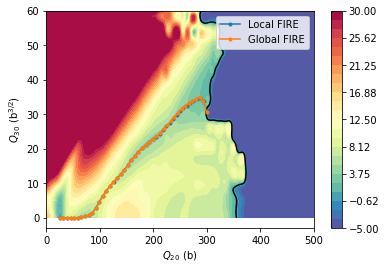

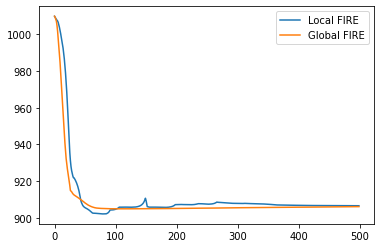

In [4]:
fIn = "..//..//PES/232U.h5"
dsets, attrs = read_from_h5(fIn)

coordStrs = ["Q20","Q30"]

uniqueCoords = [np.unique(dsets[key]) for key in coordStrs]

gridShape = [len(np.unique(dsets[key])) for key in coordStrs]

coordMesh = tuple([dsets[key].reshape(gridShape) for key in coordStrs])
zz = dsets["PES"].reshape(gridShape)

#potential = py_neb.auxiliary_potential(py_neb.NDInterpWithBoundary(uniqueCoords,zz),\
#                                 shift=0.5)
potential = py_neb.auxiliary_potential(py_neb.RectBivariateSplineWrapper(*uniqueCoords,zz).function)

#Finding initial path
gsLoc = np.array([attrs["Ground_State"][key] for key in coordStrs]).flatten()
eGS = potential(gsLoc)
#eGS=0.0
#gsLoc=np.zeros(2)
#gsLoc[0]=25.0
#gsLoc[1]=0.0
nPts = 42
initPath = np.array((np.linspace(gsLoc[0],300,nPts),\
                     np.linspace(gsLoc[1],32,nPts))).T
#print(initPath)
f, a = standard_pes(*coordMesh,zz)
a.contour(*coordMesh,zz,levels=[eGS],colors=["black"])

lap = py_neb.LeastActionPath(potential,nPts,2,\
                             target_func_grad=py_neb.discrete_action_grad,\
                             #target_func=localAction,\
                             nebParams={"k":10,"kappa":1},\
                             endpointSpringForce=(False,True),\
                             endpointHarmonicForce=(False,True))
'''
lap = py_neb.LeastActionPath(potential,nPts,2,\
                             nebParams={"k":1,"kappa":1},\
                             endpointSpringForce=(False,True),\
                             endpointHarmonicForce=(False,True))
'''
maxIters = 500
tStep = 0.1

minObj = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj.fire(tStep,maxIters,useLocal=True)

minObj2 = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj2.fire(tStep,maxIters)

# allPts, allVelocities, allForces = \
#     minObj.velocity_verlet(tStep,maxIters)
a.plot(minObj.allPts[-1,:,0],minObj.allPts[-1,:,1],marker=".",label="Local FIRE")
a.plot(minObj2.allPts[-1,:,0],minObj2.allPts[-1,:,1],marker=".",label="Global FIRE")
a.legend()
# print("Slow interpolator time: "+str(t1 - t0))
# print("Slow interpolator action: "+str(actions[-1]))

actions = np.array([py_neb.action(minObj.allPts[i],potential)[0] for i in range(maxIters)])
actions2 = np.array([py_neb.action(minObj2.allPts[i],potential)[0] for i in range(maxIters)])
# print(actions)
actionFig, actionAx = plt.subplots()
actionAx.plot(actions,label="Local FIRE")
actionAx.plot(actions2,label="Global FIRE")

actionAx.legend()

#print(potential(minObj.allPts[-1]))
print("Final Local: ",actions[-1])
print("Final Global: ",actions2[-1])

Spring:  [0. 0.]
g:  [-0.00390243 -0.00460753]
G_perp:  [ 0.00047685 -0.00409795]
True:  [ 0.01393479 -0.11975212]
Spring:  [3.52890247e-14 4.10635923e-15]
g:  [-0.00390819  0.00415483]
G_perp:  [-0.00052922  0.00454802]
True:  [-0.01546523  0.13290429]
Spring:  [-7.05780493e-14 -8.21271847e-15]
g:  [ 0.00639739 -0.02280869]
G_perp:  [ 0.00270411 -0.02323846]
True:  [ 0.07902084 -0.67908531]
Spring:  [0. 0.]
g:  [ 0.00464849 -0.04310193]
G_perp:  [ 0.00501059 -0.0430598 ]
True:  [ 0.146422   -1.25831408]
Spring:  [1.41156099e-13 1.64254369e-14]
g:  [ 0.00609125 -0.05023905]
G_perp:  [ 0.00584928 -0.05026721]
True:  [ 0.17093033 -1.46893253]
Spring:  [-1.41156099e-13 -1.64254369e-14]
g:  [ 0.0059055  -0.05620709]
G_perp:  [ 0.00653198 -0.0561342 ]
True:  [ 0.19088062 -1.64038034]
Spring:  [0. 0.]
g:  [ 0.0066393  -0.04936538]
G_perp:  [ 0.00575629 -0.04946813]
True:  [ 0.1682131 -1.4455813]
Spring:  [0. 0.]
g:  [ 0.00555722 -0.04775954]
G_perp:  [ 0.00555747 -0.04775951]
True:  [ 0.1624

True:  [-0.03352104  0.28804359]
Spring:  [-4.95722099e-10 -5.76881661e-11]
g:  [-0.00173447  0.01476737]
G_perp:  [-0.00171872  0.01476921]
True:  [-0.05022589  0.4315978 ]
Spring:  [-1.66123034e-09 -1.93311113e-10]
g:  [-0.00197249  0.01628669]
G_perp:  [-0.00189625  0.01629556]
True:  [-0.05541285  0.47619353]
Spring:  [9.67544957e-10 1.12593135e-10]
g:  [-0.00242773  0.01998459]
G_perp:  [-0.00232697  0.01999632]
True:  [-0.06799968  0.58434069]
Spring:  [4.11375265e-09 4.78722940e-10]
g:  [-0.00268436  0.02455112]
G_perp:  [-0.00285474  0.02453129]
True:  [-0.08342367  0.71687468]
Spring:  [-5.58638738e-09 -6.50031090e-10]
g:  [-0.00247686  0.02230599]
G_perp:  [-0.00259394  0.02229237]
True:  [-0.0758015   0.65144047]
Spring:  [4.39701157e-10 5.11660167e-11]
g:  [-0.00236485  0.01846214]
G_perp:  [-0.00215125  0.01848699]
True:  [-0.06286393  0.54022853]
Spring:  [8.14765980e-09 9.48113493e-10]
g:  [-0.00237289  0.01987797]
G_perp:  [-0.00231393  0.01988483]
True:  [-0.06761859  

Spring:  [2.25647446e-08 2.62626902e-09]
g:  [-0.00390274 -0.00460728]
G_perp:  [ 0.00047691 -0.00409754]
True:  [ 0.01393722 -0.11974774]
Spring:  [1.09089684e-07 1.26854754e-08]
g:  [-0.00390856  0.00415058]
G_perp:  [-0.00052836  0.00454365]
True:  [-0.01544956  0.13285966]
Spring:  [-2.23790764e-08 -2.60285264e-09]
g:  [ 0.006397   -0.02280764]
G_perp:  [ 0.00270267 -0.02323732]
True:  [ 0.07898228 -0.67908203]
Spring:  [-1.00287171e-07 -1.16677297e-08]
g:  [ 0.00464582 -0.04309731]
G_perp:  [ 0.00500916 -0.04305504]
True:  [ 0.14638626 -1.25822801]
Spring:  [4.21027012e-08 4.89852276e-09]
g:  [ 0.00609073 -0.05023579]
G_perp:  [ 0.00584807 -0.05026402]
True:  [ 0.1708957  -1.46884502]
Spring:  [-3.58799749e-08 -4.17550646e-09]
g:  [ 0.00590488 -0.05620612]
G_perp:  [ 0.00653245 -0.05613309]
True:  [ 0.19090078 -1.64040343]
Spring:  [-4.48826368e-08 -5.22355538e-09]
g:  [ 0.00663988 -0.04936581]
G_perp:  [ 0.00575727 -0.04946853]
True:  [ 0.16823925 -1.44557122]
Spring:  [2.9778102

g:  [-0.00297653  0.03530773]
G_perp:  [-0.00409513  0.03517751]
True:  [-0.11967557  1.02802302]
Spring:  [2.57828168e-08 3.00085216e-09]
g:  [-0.00390276 -0.00460727]
G_perp:  [ 0.00047691 -0.00409752]
True:  [ 0.01393736 -0.11974749]
Spring:  [1.18320037e-07 1.37582700e-08]
g:  [-0.00390858  0.00415034]
G_perp:  [-0.00052831  0.0045434 ]
True:  [-0.01544865  0.1328572 ]
Spring:  [-2.11417728e-08 -2.45887425e-09]
g:  [ 0.00639697 -0.02280761]
G_perp:  [ 0.00270259 -0.02323728]
True:  [ 0.07898006 -0.67908254]
Spring:  [-1.12605237e-07 -1.31007158e-08]
g:  [ 0.00464563 -0.04309706]
G_perp:  [ 0.00500908 -0.04305477]
True:  [ 0.1463842  -1.25822347]
Spring:  [4.91715442e-08 5.72091266e-09]
g:  [ 0.00609068 -0.05023561]
G_perp:  [ 0.005848   -0.05026385]
True:  [ 0.1708937  -1.46884033]
Spring:  [-4.21014281e-08 -4.89955039e-09]
g:  [ 0.00590484 -0.05620605]
G_perp:  [ 0.00653247 -0.05613301]
True:  [ 0.19090193 -1.64040441]
Spring:  [-5.19572790e-08 -6.04697873e-09]
g:  [ 0.00663992 -0

g:  [-0.00232546  0.01900979]
G_perp:  [-0.00221351  0.01902282]
True:  [-0.06468474  0.55589723]
Spring:  [-1.15601390e-08 -1.34508974e-09]
g:  [-0.00254356  0.0163842 ]
G_perp:  [-0.00191491  0.01645734]
True:  [-0.0559576  0.4809178]
Spring:  [1.23573474e-08 1.43798505e-09]
g:  [-0.00040807  0.01769053]
G_perp:  [-0.00203654  0.01750103]
True:  [-0.05951365  0.51143147]
Spring:  [7.54653490e-08 8.78196825e-09]
g:  [-0.00356218  0.01300024]
G_perp:  [-0.00154023  0.01323553]
True:  [-0.04500501  0.38673777]
Spring:  [3.56749019e-07 4.15306968e-08]
g:  [-0.00297653  0.03530771]
G_perp:  [-0.00409516  0.03517749]
True:  [-0.11967666  1.02802346]
Spring:  [2.70840764e-08 3.15231946e-09]
g:  [-0.00390277 -0.00460726]
G_perp:  [ 0.00047691 -0.00409751]
True:  [ 0.01393741 -0.11974739]
Spring:  [1.20785684e-07 1.40447725e-08]
g:  [-0.00390858  0.00415024]
G_perp:  [-0.00052829  0.0045433 ]
True:  [-0.01544829  0.13285601]
Spring:  [-1.97395124e-08 -2.29576196e-09]
g:  [ 0.00639696 -0.02280

Spring:  [2.84793632e-08 3.31473214e-09]
g:  [-0.00390277 -0.00460725]
G_perp:  [ 0.00047691 -0.0040975 ]
True:  [ 0.01393746 -0.11974727]
Spring:  [1.22794511e-07 1.42781471e-08]
g:  [-0.00390859  0.00415015]
G_perp:  [-0.00052827  0.00454321]
True:  [-0.01544797  0.13285518]
Spring:  [-1.77837041e-08 -2.06827427e-09]
g:  [ 0.00639696 -0.02280755]
G_perp:  [ 0.00270253 -0.02323722]
True:  [ 0.07897838 -0.67908213]
Spring:  [-1.21949992e-07 -1.41877960e-08]
g:  [ 0.00464553 -0.04309686]
G_perp:  [ 0.00500902 -0.04305457]
True:  [ 0.14638266 -1.25821969]
Spring:  [5.57041604e-08 6.48091665e-09]
g:  [ 0.00609068 -0.05023545]
G_perp:  [ 0.00584794 -0.0502637 ]
True:  [ 0.17089217 -1.46883616]
Spring:  [-4.79266126e-08 -5.57747774e-09]
g:  [ 0.00590481 -0.05620601]
G_perp:  [ 0.0065325  -0.05613297]
True:  [ 0.19090283 -1.64040561]
Spring:  [-5.82761912e-08 -6.78244421e-09]
g:  [ 0.00663994 -0.04936585]
G_perp:  [ 0.00575737 -0.04946857]
True:  [ 0.16824194 -1.44557025]
Spring:  [3.9097121

Spring:  [-5.30481439e-08 -6.17351642e-09]
g:  [ 0.0059048  -0.05620598]
G_perp:  [ 0.00653251 -0.05613293]
True:  [ 0.19090349 -1.64040639]
Spring:  [-6.37178206e-08 -7.41580488e-09]
g:  [ 0.00663997 -0.04936587]
G_perp:  [ 0.00575741 -0.04946858]
True:  [ 0.1682428  -1.44556994]
Spring:  [4.29515170e-08 4.99829228e-09]
g:  [ 0.00555725 -0.04775503]
G_perp:  [ 0.00555728 -0.04775502]
True:  [ 0.16239798 -1.39552456]
Spring:  [-4.12619869e-09 -4.80190079e-10]
g:  [ 0.00425132 -0.04527141]
G_perp:  [ 0.00525491 -0.04515462]
True:  [ 0.15356253 -1.31953894]
Spring:  [-1.53589936e-09 -1.78744619e-10]
g:  [ 0.00507834 -0.04071139]
G_perp:  [ 0.00474245 -0.04075048]
True:  [ 0.13858634 -1.19083125]
Spring:  [1.51589036e-08 1.76417379e-09]
g:  [ 0.00544067 -0.03591942]
G_perp:  [ 0.0041971  -0.03606415]
True:  [ 0.12265068 -1.05389269]
Spring:  [2.35769326e-08 2.74403609e-09]
g:  [ 0.00229161 -0.02953717]
G_perp:  [ 0.00342241 -0.02940556]
True:  [ 0.10001414 -0.85932781]
Spring:  [-5.891672

True:  [ 0.07897579 -0.67908151]
Spring:  [-1.36967817e-07 -1.59348015e-08]
g:  [ 0.00464535 -0.04309654]
G_perp:  [ 0.00500892 -0.04305424]
True:  [ 0.14638027 -1.25821371]
Spring:  [6.76505347e-08 7.87074672e-09]
g:  [ 0.00609064 -0.05023524]
G_perp:  [ 0.00584786 -0.05026348]
True:  [ 0.17088988 -1.46883033]
Spring:  [-5.86984358e-08 -6.83109409e-09]
g:  [ 0.00590478 -0.05620595]
G_perp:  [ 0.00653253 -0.05613289]
True:  [ 0.19090416 -1.64040712]
Spring:  [-6.96610461e-08 -8.10755155e-09]
g:  [ 0.00663999 -0.04936588]
G_perp:  [ 0.00575744 -0.0494686 ]
True:  [ 0.16824367 -1.44556963]
Spring:  [4.71672806e-08 5.48889263e-09]
g:  [ 0.00555724 -0.0477549 ]
G_perp:  [ 0.00555727 -0.04775489]
True:  [ 0.16239784 -1.39552094]
Spring:  [-4.65562134e-09 -5.41803788e-10]
g:  [ 0.0042513  -0.04527126]
G_perp:  [ 0.00525491 -0.04515447]
True:  [ 0.15356251 -1.3195347 ]
Spring:  [-1.71449675e-09 -1.99530104e-10]
g:  [ 0.00507835 -0.04071125]
G_perp:  [ 0.00474245 -0.04075034]
True:  [ 0.138586

Spring:  [3.56966597e-08 4.15484538e-09]
g:  [-0.0039028  -0.00460723]
G_perp:  [ 0.00047692 -0.00409746]
True:  [ 0.01393771 -0.11974689]
Spring:  [1.28228115e-07 1.49089413e-08]
g:  [-0.00390861  0.00414974]
G_perp:  [-0.00052818  0.00454278]
True:  [-0.01544643  0.13285093]
Spring:  [-4.10962407e-09 -4.77933060e-10]
g:  [ 0.00639691 -0.02280744]
G_perp:  [ 0.00270238 -0.0232371 ]
True:  [ 0.07897452 -0.67908167]
Spring:  [-1.44897973e-07 -1.68572940e-08]
g:  [ 0.00464526 -0.0430964 ]
G_perp:  [ 0.00500887 -0.0430541 ]
True:  [ 0.14637911 -1.25821126]
Spring:  [7.43604272e-08 8.65136201e-09]
g:  [ 0.00609061 -0.05023513]
G_perp:  [ 0.00584782 -0.05026338]
True:  [ 0.17088871 -1.46882741]
Spring:  [-6.48016877e-08 -7.54138996e-09]
g:  [ 0.00590476 -0.05620592]
G_perp:  [ 0.00653254 -0.05613286]
True:  [ 0.19090486 -1.64040805]
Spring:  [-7.60437856e-08 -8.85045979e-09]
g:  [ 0.00664001 -0.0493659 ]
G_perp:  [ 0.00575747 -0.04946861]
True:  [ 0.16824456 -1.4455693 ]
Spring:  [5.1689167

Spring:  [3.83819476e-08 4.46742657e-09]
g:  [-0.00390282 -0.00460722]
G_perp:  [ 0.00047692 -0.00409744]
True:  [ 0.01393779 -0.11974668]
Spring:  [1.29276065e-07 1.50304370e-08]
g:  [-0.00390864  0.00414959]
G_perp:  [-0.00052815  0.00454262]
True:  [-0.01544587  0.13284921]
Spring:  [1.69617168e-09 1.97254812e-10]
g:  [ 0.0063969  -0.02280741]
G_perp:  [ 0.00270233 -0.02323707]
True:  [ 0.07897321 -0.67908166]
Spring:  [-1.53096073e-07 -1.78109461e-08]
g:  [ 0.00464517 -0.04309624]
G_perp:  [ 0.00500882 -0.04305393]
True:  [ 0.14637787 -1.2582081 ]
Spring:  [8.14677908e-08 9.47821212e-09]
g:  [ 0.00609062 -0.05023502]
G_perp:  [ 0.00584778 -0.05026327]
True:  [ 0.17088755 -1.46882461]
Spring:  [-7.13040220e-08 -8.29813454e-09]
g:  [ 0.00590473 -0.05620587]
G_perp:  [ 0.00653256 -0.05613281]
True:  [ 0.1909055  -1.64040842]
Spring:  [-8.28213453e-08 -9.63932887e-09]
g:  [ 0.00664004 -0.0493659 ]
G_perp:  [ 0.0057575  -0.04946861]
True:  [ 0.16824541 -1.44556864]
Spring:  [5.64770178e

Spring:  [4.11846852e-08 4.79368329e-09]
g:  [-0.00390283 -0.00460721]
G_perp:  [ 0.00047692 -0.00409743]
True:  [ 0.01393788 -0.11974656]
Spring:  [1.30136753e-07 1.51301503e-08]
g:  [-0.00390865  0.00414944]
G_perp:  [-0.00052812  0.00454247]
True:  [-0.01544532  0.13284756]
Spring:  [7.94261003e-09 9.23663451e-10]
g:  [ 0.00639689 -0.02280738]
G_perp:  [ 0.00270229 -0.02323703]
True:  [ 0.07897189 -0.67908165]
Spring:  [-1.61554043e-07 -1.87948180e-08]
g:  [ 0.00464508 -0.04309607]
G_perp:  [ 0.00500877 -0.04305376]
True:  [ 0.14637663 -1.25820515]
Spring:  [8.89246763e-08 1.03457177e-08]
g:  [ 0.00609059 -0.05023492]
G_perp:  [ 0.00584774 -0.05026317]
True:  [ 0.17088638 -1.46882187]
Spring:  [-7.81675824e-08 -9.09692274e-09]
g:  [ 0.0059047  -0.05620585]
G_perp:  [ 0.00653258 -0.05613278]
True:  [ 0.19090625 -1.64040965]
Spring:  [-8.99608184e-08 -1.04703298e-08]
g:  [ 0.00664005 -0.04936592]
G_perp:  [ 0.00575754 -0.04946863]
True:  [ 0.16824634 -1.44556846]
Spring:  [6.14998136e

True:  [-0.03307644  0.28427553]
Spring:  [7.08034103e-09 8.23935725e-10]
g:  [0.00088481 0.00715089]
G_perp:  [-0.00080921  0.00695376]
True:  [-0.02364324  0.20317384]
Spring:  [8.31001598e-09 9.67157801e-10]
g:  [-0.00154447  0.01352134]
G_perp:  [-0.00157329  0.01351799]
True:  [-0.04597765  0.39504933]
Spring:  [-1.63776749e-08 -1.90589078e-09]
g:  [-0.00259546  0.01387246]
G_perp:  [-0.00162746  0.01398511]
True:  [-0.04755629  0.40866009]
Spring:  [2.93268731e-08 3.41327557e-09]
g:  [-0.00150641  0.0205302 ]
G_perp:  [-0.00237765  0.0204288 ]
True:  [-0.06948271  0.59699564]
Spring:  [-6.97744780e-09 -8.11956234e-10]
g:  [-0.00288375  0.02175422]
G_perp:  [-0.00253622  0.02179466]
True:  [-0.07411557  0.6369032 ]
Spring:  [-2.08098927e-08 -2.42137015e-09]
g:  [-0.00210777  0.01992613]
G_perp:  [-0.00231572  0.01990193]
True:  [-0.06767086  0.58158118]
Spring:  [1.15478436e-08 1.34371175e-09]
g:  [-0.00232539  0.01900924]
G_perp:  [-0.00221344  0.01902226]
True:  [-0.06468264  0.

Spring:  [8.94594012e-09 1.04101763e-09]
g:  [-0.00236472  0.01846146]
G_perp:  [-0.00215121  0.0184863 ]
True:  [-0.06286175  0.54019971]
Spring:  [6.73151887e-08 7.83344286e-09]
g:  [-0.00237285  0.01987749]
G_perp:  [-0.00231393  0.01988435]
True:  [-0.0676188   0.58106922]
Spring:  [-5.76588385e-08 -6.70697453e-09]
g:  [-0.00131784  0.0216747 ]
G_perp:  [-0.00250517  0.02153659]
True:  [-0.07321222  0.62939431]
Spring:  [-1.38992694e-08 -1.61722526e-09]
g:  [-0.00361221  0.00944038]
G_perp:  [-0.001132    0.00972896]
True:  [-0.03307633  0.2842751 ]
Spring:  [7.14687836e-09 8.31679403e-10]
g:  [0.00088482 0.00715093]
G_perp:  [-0.00080921  0.0069538 ]
True:  [-0.02364332  0.2031744 ]
Spring:  [9.20621349e-09 1.07146490e-09]
g:  [-0.00154446  0.01352131]
G_perp:  [-0.00157329  0.01351795]
True:  [-0.04597773  0.39504867]
Spring:  [-1.76768037e-08 -2.05707450e-09]
g:  [-0.00259546  0.01387246]
G_perp:  [-0.00162747  0.01398511]
True:  [-0.04755631  0.40865979]
Spring:  [3.13911504e-0

Spring:  [4.81375398e-08 5.60305710e-09]
g:  [-0.00390285 -0.00460719]
G_perp:  [ 0.00047692 -0.0040974 ]
True:  [ 0.01393809 -0.11974628]
Spring:  [1.31802962e-07 1.53230100e-08]
g:  [-0.00390868  0.00414909]
G_perp:  [-0.00052805  0.00454211]
True:  [-0.01544404  0.13284402]
Spring:  [2.38794270e-08 2.77687956e-09]
g:  [ 0.00639686 -0.02280727]
G_perp:  [ 0.00270216 -0.02323692]
True:  [ 0.07896863 -0.67908079]
Spring:  [-1.82269327e-07 -2.12044770e-08]
g:  [ 0.00464485 -0.0430957 ]
G_perp:  [ 0.00500866 -0.04305337]
True:  [ 0.14637369 -1.25819816]
Spring:  [1.07500360e-07 1.25067108e-08]
g:  [ 0.00609055 -0.05023464]
G_perp:  [ 0.00584764 -0.0502629 ]
True:  [ 0.1708835  -1.46881444]
Spring:  [-9.54442584e-08 -1.11076179e-08]
g:  [ 0.00590465 -0.05620577]
G_perp:  [ 0.00653261 -0.05613269]
True:  [ 0.1909079 -1.6404114]
Spring:  [-1.07919114e-07 -1.25606227e-08]
g:  [ 0.00664009 -0.04936594]
G_perp:  [ 0.00575762 -0.04946865]
True:  [ 0.16824845 -1.44556718]
Spring:  [7.40196648e-0

g:  [ 0.00590466 -0.05620575]
G_perp:  [ 0.00653263 -0.05613266]
True:  [ 0.1909084  -1.64041208]
Spring:  [-1.13368370e-07 -1.31949092e-08]
g:  [ 0.0066401  -0.04936597]
G_perp:  [ 0.00575764 -0.04946868]
True:  [ 0.16824916 -1.44556755]
Spring:  [7.77841783e-08 9.05190400e-09]
g:  [ 0.00555723 -0.04775408]
G_perp:  [ 0.00555724 -0.04775408]
True:  [ 0.16239694 -1.39549787]
Spring:  [-8.36379333e-09 -9.73365896e-10]
g:  [ 0.00425124 -0.04527022]
G_perp:  [ 0.00525489 -0.04515341]
True:  [ 0.15356211 -1.31950563]
Spring:  [-3.01018314e-09 -3.50327677e-10]
g:  [ 0.00507836 -0.04071033]
G_perp:  [ 0.00474245 -0.04074942]
True:  [ 0.13858642 -1.19080084]
Spring:  [2.53140169e-08 2.94609452e-09]
g:  [ 0.00544064 -0.03591787]
G_perp:  [ 0.00419704 -0.0360626 ]
True:  [ 0.12264903 -1.05384932]
Spring:  [2.76063661e-08 3.21314255e-09]
g:  [ 0.00229154 -0.02953547]
G_perp:  [ 0.00342235 -0.02940385]
True:  [ 0.10001311 -0.85928291]
Spring:  [-8.95003661e-08 -1.04183731e-08]
g:  [ 0.00200243 -0

True:  [-0.06800445  0.58433934]
Spring:  [4.76405787e-08 5.54449042e-09]
g:  [-0.00268422  0.02454939]
G_perp:  [-0.00285479  0.02452954]
True:  [-0.08342662  0.71683637]
Spring:  [-5.95513840e-08 -6.92908533e-09]
g:  [-0.00247654  0.02230382]
G_perp:  [-0.00259357  0.0222902 ]
True:  [-0.07579116  0.65138013]
Spring:  [1.13413577e-08 1.31976954e-09]
g:  [-0.0023647   0.01846138]
G_perp:  [-0.0021512   0.01848622]
True:  [-0.06286148  0.54019626]
Spring:  [8.05372855e-08 9.37212402e-09]
g:  [-0.00237285  0.01987744]
G_perp:  [-0.00231394  0.0198843 ]
True:  [-0.06761884  0.58106765]
Spring:  [-7.39698622e-08 -8.60410241e-09]
g:  [-0.00131779  0.02167448]
G_perp:  [-0.00250509  0.02153637]
True:  [-0.07321012  0.62939071]
Spring:  [-1.23520212e-08 -1.43718970e-09]
g:  [-0.0036122   0.00944041]
G_perp:  [-0.00113199  0.00972899]
True:  [-0.03307605  0.28427426]
Spring:  [7.42080890e-09 8.63559422e-10]
g:  [0.00088482 0.00715108]
G_perp:  [-0.00080923  0.00695394]
True:  [-0.02364365  0.

Spring:  [5.56217707e-08 6.47431429e-09]
g:  [-0.00390288 -0.00460717]
G_perp:  [ 0.00047693 -0.00409736]
True:  [ 0.01393828 -0.11974581]
Spring:  [1.33442023e-07 1.55126643e-08]
g:  [-0.0039087   0.00414874]
G_perp:  [-0.00052798  0.00454175]
True:  [-0.01544276  0.13284066]
Spring:  [4.13306425e-08 4.80603993e-09]
g:  [ 0.00639683 -0.0228072 ]
G_perp:  [ 0.00270204 -0.02323684]
True:  [ 0.0789654  -0.67908104]
Spring:  [-2.04321364e-07 -2.37695653e-08]
g:  [ 0.00464462 -0.0430953 ]
G_perp:  [ 0.00500853 -0.04305296]
True:  [ 0.14637063 -1.25819071]
Spring:  [1.27519129e-07 1.48355353e-08]
g:  [ 0.0060905  -0.05023436]
G_perp:  [ 0.00584754 -0.05026263]
True:  [ 0.17088053 -1.46880685]
Spring:  [-1.14348881e-07 -1.33078056e-08]
g:  [ 0.00590461 -0.05620568]
G_perp:  [ 0.00653265 -0.05613259]
True:  [ 0.19090961 -1.64041322]
Spring:  [-1.2759134e-07 -1.4850464e-08]
g:  [ 0.00664015 -0.04936601]
G_perp:  [ 0.00575771 -0.04946871]
True:  [ 0.16825078 -1.44556714]
Spring:  [8.75317701e-0

G_perp:  [ 0.00156299 -0.01343016]
True:  [ 0.04567309 -0.39245031]
Spring:  [4.88835573e-09 5.68857157e-10]
g:  [ 0.00186447 -0.01188102]
G_perp:  [ 0.00138903 -0.01193635]
True:  [ 0.04058994 -0.34880123]
Spring:  [2.55651983e-08 2.97483625e-09]
g:  [ 0.00126251 -0.01217121]
G_perp:  [ 0.00141422 -0.01215355]
True:  [ 0.04132926 -0.3551761 ]
Spring:  [-9.25227967e-09 -1.07678023e-09]
g:  [ 0.00100137 -0.00821149]
G_perp:  [ 0.00095626 -0.00821674]
True:  [ 0.02794508 -0.2401193 ]
Spring:  [-1.28528479e-09 -1.49588696e-10]
g:  [ 0.00041387 -0.00291008]
G_perp:  [ 0.0003397  -0.00291872]
True:  [ 0.00992718 -0.08529555]
Spring:  [-2.37467973e-10 -2.76387048e-11]
g:  [-0.00038476  0.00323263]
G_perp:  [-0.00037636  0.00323361]
True:  [-0.01099789  0.09449234]
Spring:  [2.47385868e-09 2.87935231e-10]
g:  [-0.00119322  0.00985028]
G_perp:  [-0.00114711  0.00985565]
True:  [-0.03352214  0.28801281]
Spring:  [5.78255190e-09 6.72996732e-10]
g:  [-0.00173435  0.01476551]
G_perp:  [-0.00171868

Spring:  [6.12772884e-08 7.13270449e-09]
g:  [-0.0039029  -0.00460715]
G_perp:  [ 0.00047693 -0.00409734]
True:  [ 0.01393844 -0.11974556]
Spring:  [1.34787290e-07 1.56683872e-08]
g:  [-0.00390873  0.00414846]
G_perp:  [-0.00052792  0.00454146]
True:  [-0.0154417   0.13283722]
Spring:  [5.45705237e-08 6.34541748e-09]
g:  [ 0.0063968  -0.02280713]
G_perp:  [ 0.00270195 -0.02323676]
True:  [ 0.07896297 -0.67908074]
Spring:  [-2.20877731e-07 -2.56953546e-08]
g:  [ 0.00464445 -0.04309501]
G_perp:  [ 0.00500844 -0.04305266]
True:  [ 0.14636838 -1.25818522]
Spring:  [1.42620976e-07 1.65923309e-08]
g:  [ 0.00609045 -0.05023416]
G_perp:  [ 0.00584746 -0.05026243]
True:  [ 0.17087837 -1.46880149]
Spring:  [-1.28805841e-07 -1.49903779e-08]
g:  [ 0.00590457 -0.05620563]
G_perp:  [ 0.00653268 -0.05613253]
True:  [ 0.19091092 -1.64041505]
Spring:  [-1.42665863e-07 -1.66051692e-08]
g:  [ 0.00664019 -0.04936601]
G_perp:  [ 0.00575776 -0.04946872]
True:  [ 0.16825236 -1.44556601]
Spring:  [9.77399529e

g:  [-0.00254352  0.01638382]
G_perp:  [-0.00191481  0.01645697]
True:  [-0.05595439  0.48090395]
Spring:  [3.28100419e-08 3.81804421e-09]
g:  [-0.0004079   0.01768974]
G_perp:  [-0.00203647  0.01750023]
True:  [-0.05951201  0.51141149]
Spring:  [9.97289684e-08 1.16058528e-08]
g:  [-0.00356265  0.01299947]
G_perp:  [-0.00154019  0.01323483]
True:  [-0.04500195  0.38670126]
Spring:  [8.31822378e-07 9.68540615e-08]
g:  [-0.00297653  0.03530746]
G_perp:  [-0.00409588  0.03517713]
True:  [-0.11970019  1.02803426]
Spring:  [6.47929533e-08 7.54199016e-09]
g:  [-0.00390291 -0.00460714]
G_perp:  [ 0.00047693 -0.00409732]
True:  [ 0.01393853 -0.11974538]
Spring:  [1.35702094e-07 1.57743205e-08]
g:  [-0.00390874  0.0041483 ]
G_perp:  [-0.00052789  0.00454129]
True:  [-0.01544111  0.13283558]
Spring:  [6.27981756e-08 7.30198754e-09]
g:  [ 0.0063968  -0.02280708]
G_perp:  [ 0.0027019  -0.02323671]
True:  [ 0.07896146 -0.6790803 ]
Spring:  [-2.31131119e-07 -2.68879809e-08]
g:  [ 0.00464435 -0.04309

g:  [-0.00390875  0.0041482 ]
G_perp:  [-0.00052787  0.00454119]
True:  [-0.01544074  0.13283473]
Spring:  [6.83976668e-08 7.95298103e-09]
g:  [ 0.00639677 -0.02280705]
G_perp:  [ 0.00270186 -0.02323668]
True:  [ 0.07896048 -0.67908026]
Spring:  [-2.38100062e-07 -2.76985678e-08]
g:  [ 0.00464428 -0.04309471]
G_perp:  [ 0.00500835 -0.04305236]
True:  [ 0.14636608 -1.2581796 ]
Spring:  [1.58358949e-07 1.84230968e-08]
g:  [ 0.00609042 -0.05023395]
G_perp:  [ 0.00584739 -0.05026222]
True:  [ 0.17087615 -1.46879585]
Spring:  [-1.44050581e-07 -1.67646538e-08]
g:  [ 0.00590453 -0.05620555]
G_perp:  [ 0.00653271 -0.05613244]
True:  [ 0.19091215 -1.64041602]
Spring:  [-1.58594002e-07 -1.84592693e-08]
g:  [ 0.00664021 -0.04936604]
G_perp:  [ 0.00575783 -0.04946875]
True:  [ 0.16825403 -1.44556531]
Spring:  [1.08393041e-07 1.26140442e-08]
g:  [ 0.00555724 -0.04775335]
G_perp:  [ 0.00555721 -0.04775335]
True:  [ 0.16239616 -1.3954774 ]
Spring:  [-1.16334014e-08 -1.35390165e-09]
g:  [ 0.00425118 -0

True:  [ 0.19091268 -1.64041662]
Spring:  [-1.65206127e-07 -1.92289570e-08]
g:  [ 0.00664023 -0.04936606]
G_perp:  [ 0.00575785 -0.04946877]
True:  [ 0.16825474 -1.44556537]
Spring:  [1.12776530e-07 1.31241828e-08]
g:  [ 0.00555725 -0.04775321]
G_perp:  [ 0.0055572  -0.04775322]
True:  [ 0.16239595 -1.39547366]
Spring:  [-1.20634499e-08 -1.40395431e-09]
g:  [ 0.0042512  -0.04526915]
G_perp:  [ 0.00525487 -0.04515234]
True:  [ 0.15356172 -1.31947606]
Spring:  [-4.43739063e-09 -5.16439146e-10]
g:  [ 0.00507837 -0.04070942]
G_perp:  [ 0.00474246 -0.04074851]
True:  [ 0.13858651 -1.19077438]
Spring:  [3.57004962e-08 4.15499455e-09]
g:  [ 0.0054406  -0.03591648]
G_perp:  [ 0.00419698 -0.03606122]
True:  [ 0.12264754 -1.05381077]
Spring:  [3.07467465e-08 3.57878799e-09]
g:  [ 0.00229148 -0.02953396]
G_perp:  [ 0.0034223  -0.02940233]
True:  [ 0.10001218 -0.85924315]
Spring:  [-1.20305036e-07 -1.40050072e-08]
g:  [ 0.0020025  -0.01720278]
G_perp:  [ 0.00200262 -0.01720276]
True:  [ 0.05851544

Spring:  [7.33545529e-08 8.53873590e-09]
g:  [-0.00390294 -0.00460712]
G_perp:  [ 0.00047694 -0.00409729]
True:  [ 0.01393876 -0.11974503]
Spring:  [1.38222858e-07 1.60663490e-08]
g:  [-0.00390879  0.00414792]
G_perp:  [-0.00052781  0.00454091]
True:  [-0.01543973  0.13283186]
Spring:  [8.27864086e-08 9.62573725e-09]
g:  [ 0.00639676 -0.022807  ]
G_perp:  [ 0.00270177 -0.02323662]
True:  [ 0.078958   -0.67908041]
Spring:  [-2.55987388e-07 -2.97790881e-08]
g:  [ 0.00464412 -0.04309441]
G_perp:  [ 0.00500826 -0.04305205]
True:  [ 0.14636377 -1.25817418]
Spring:  [1.74717282e-07 2.03259960e-08]
g:  [ 0.0060904  -0.05023375]
G_perp:  [ 0.00584731 -0.05026203]
True:  [ 0.17087393 -1.46879043]
Spring:  [-1.60089691e-07 -1.86314022e-08]
g:  [ 0.00590449 -0.05620549]
G_perp:  [ 0.00653274 -0.05613237]
True:  [ 0.19091347 -1.64041752]
Spring:  [-1.75385532e-07 -2.04139062e-08]
g:  [ 0.00664027 -0.04936608]
G_perp:  [ 0.00575789 -0.04946878]
True:  [ 0.16825576 -1.4455649 ]
Spring:  [1.19481725e

Spring:  [-1.30413976e-07 -1.51820767e-08]
g:  [ 0.00200252 -0.01720267]
G_perp:  [ 0.00200264 -0.01720265]
True:  [ 0.05851583 -0.5026507 ]
Spring:  [3.02468408e-08 3.52016887e-09]
g:  [ 0.00137562 -0.01345168]
G_perp:  [ 0.00156299 -0.01342988]
True:  [ 0.04567277 -0.39244052]
Spring:  [7.69946789e-09 8.95992124e-10]
g:  [ 0.00186443 -0.01188064]
G_perp:  [ 0.001389   -0.01193597]
True:  [ 0.0405888  -0.34878898]
Spring:  [3.41884346e-08 3.97825546e-09]
g:  [ 0.00126244 -0.01217061]
G_perp:  [ 0.00141415 -0.01215296]
True:  [ 0.0413275  -0.35516136]
Spring:  [-1.33586231e-08 -1.55470529e-09]
g:  [ 0.00100134 -0.00821119]
G_perp:  [ 0.00095625 -0.00821643]
True:  [ 0.02794465 -0.24011116]
Spring:  [-2.68977470e-09 -3.13058973e-10]
g:  [ 0.00041387 -0.00290999]
G_perp:  [ 0.00033969 -0.00291862]
True:  [ 0.00992715 -0.08529321]
Spring:  [-6.96850056e-10 -8.11081644e-11]
g:  [-0.00038476  0.00323255]
G_perp:  [-0.00037636  0.00323353]
True:  [-0.01099791  0.09448977]
Spring:  [4.9579490

g:  [-0.00288363  0.02175294]
G_perp:  [-0.0025361   0.02179339]
True:  [-0.07411252  0.6368687 ]
Spring:  [-4.23816333e-08 -4.93129773e-09]
g:  [-0.00210759  0.01992499]
G_perp:  [-0.00231555  0.0199008 ]
True:  [-0.06766568  0.58154715]
Spring:  [2.07033926e-08 2.40903501e-09]
g:  [-0.00232526  0.01900828]
G_perp:  [-0.00221331  0.01902131]
True:  [-0.064679    0.55585521]
Spring:  [-3.98184006e-08 -4.63292570e-09]
g:  [-0.0025435   0.01638368]
G_perp:  [-0.00191478  0.01645683]
True:  [-0.05595327  0.48089905]
Spring:  [4.10479671e-08 4.77669549e-09]
g:  [-0.00040783  0.01768948]
G_perp:  [-0.00203645  0.01749996]
True:  [-0.05951148  0.51140486]
Spring:  [1.1290572e-07 1.3139402e-08]
g:  [-0.00356282  0.0129992 ]
G_perp:  [-0.00154017  0.01323459]
True:  [-0.0450009   0.38668876]
Spring:  [1.02841853e-06 1.19752581e-07]
g:  [-0.00297654  0.03530738]
G_perp:  [-0.00409613  0.03517701]
True:  [-0.11970829  1.02803814]
Spring:  [7.97821043e-08 9.28705641e-09]
g:  [-0.00390296 -0.00460

G_perp:  [-0.00215118  0.01848591]
True:  [-0.06286052  0.5401834 ]
Spring:  [1.35544263e-07 1.57734843e-08]
g:  [-0.00237284  0.01987724]
G_perp:  [-0.00231394  0.01988409]
True:  [-0.06761896  0.58106136]
Spring:  [-1.42290972e-07 -1.65496891e-08]
g:  [-0.00131759  0.02167362]
G_perp:  [-0.00250477  0.02153554]
True:  [-0.07320201  0.6293765 ]
Spring:  [-7.30937414e-09 -8.50446090e-10]
g:  [-0.00361219  0.00944052]
G_perp:  [-0.00113198  0.00972909]
True:  [-0.03307484  0.28427005]
Spring:  [9.22697772e-09 1.07375672e-09]
g:  [0.00088479 0.00715161]
G_perp:  [-0.0008093   0.00695447]
True:  [-0.0236448   0.20318389]
Spring:  [2.62502921e-08 3.05531221e-09]
g:  [-0.00154451  0.01352074]
G_perp:  [-0.00157331  0.01351739]
True:  [-0.04597914  0.39503849]
Spring:  [-4.17688172e-08 -4.86079604e-09]
g:  [-0.00259551  0.01387242]
G_perp:  [-0.0016275   0.01398507]
True:  [-0.04755645  0.40865252]
Spring:  [7.11375463e-08 8.28006623e-09]
g:  [-0.00150637  0.02052952]
G_perp:  [-0.00237773  

Spring:  [-1.47612419e-07 -1.71847134e-08]
g:  [ 0.00200256 -0.01720249]
G_perp:  [ 0.00200268 -0.01720248]
True:  [ 0.05851651 -0.50264225]
Spring:  [3.49149382e-08 4.06348882e-09]
g:  [ 0.00137563 -0.01345151]
G_perp:  [ 0.00156298 -0.01342971]
True:  [ 0.04567254 -0.39243469]
Spring:  [9.52386438e-09 1.10830270e-09]
g:  [ 0.0018644  -0.01188042]
G_perp:  [ 0.00138898 -0.01193575]
True:  [ 0.04058813 -0.34878188]
Spring:  [3.93242855e-08 4.57587384e-09]
g:  [ 0.00126241 -0.01217028]
G_perp:  [ 0.00141411 -0.01215263]
True:  [ 0.04132652 -0.35515309]
Spring:  [-1.57485297e-08 -1.83286677e-09]
g:  [ 0.00100135 -0.00821099]
G_perp:  [ 0.00095623 -0.00821625]
True:  [ 0.02794435 -0.24010609]
Spring:  [-3.57205888e-09 -4.15752547e-10]
g:  [ 0.00041387 -0.00290993]
G_perp:  [ 0.00033969 -0.00291856]
True:  [ 0.00992711 -0.08529161]
Spring:  [-9.56602674e-10 -1.11343241e-10]
g:  [-0.00038477  0.00323249]
G_perp:  [-0.00037636  0.00323347]
True:  [-0.01099787  0.09448789]
Spring:  [6.4661686

Spring:  [9.06224601e-08 1.05491736e-08]
g:  [-0.00390299 -0.00460707]
G_perp:  [ 0.00047695 -0.00409721]
True:  [ 0.01393917 -0.11974415]
Spring:  [1.44611819e-07 1.68069664e-08]
g:  [-0.00390885  0.00414717]
G_perp:  [-0.00052766  0.00454013]
True:  [-0.01543694  0.13282374]
Spring:  [1.22758026e-07 1.42721016e-08]
g:  [ 0.00639668 -0.02280681]
G_perp:  [ 0.00270151 -0.02323641]
True:  [ 0.0789512  -0.67907966]
Spring:  [-3.05609834e-07 -3.55505829e-08]
g:  [ 0.00464363 -0.04309361]
G_perp:  [ 0.00500801 -0.04305123]
True:  [ 0.14635753 -1.25815941]
Spring:  [2.20086205e-07 2.56034132e-08]
g:  [ 0.0060903  -0.05023316]
G_perp:  [ 0.00584709 -0.05026145]
True:  [ 0.17086781 -1.46877476]
Spring:  [-2.05596208e-07 -2.39278841e-08]
g:  [ 0.00590437 -0.05620532]
G_perp:  [ 0.00653283 -0.05613218]
True:  [ 0.19091704 -1.64042166]
Spring:  [-2.23203088e-07 -2.59803474e-08]
g:  [ 0.00664036 -0.04936614]
G_perp:  [ 0.00575806 -0.04946884]
True:  [ 0.16826033 -1.44556282]
Spring:  [1.50315722e

Spring:  [9.48690998e-08 1.10436135e-08]
g:  [-0.00390301 -0.00460707]
G_perp:  [ 0.00047695 -0.0040972 ]
True:  [ 0.01393929 -0.11974411]
Spring:  [1.46438790e-07 1.70188162e-08]
g:  [-0.00390885  0.00414699]
G_perp:  [-0.00052762  0.00453995]
True:  [-0.01543629  0.13282188]
Spring:  [1.32506019e-07 1.54051115e-08]
g:  [ 0.00639666 -0.02280677]
G_perp:  [ 0.00270145 -0.02323638]
True:  [ 0.07894962 -0.67907977]
Spring:  [-3.17701604e-07 -3.69569066e-08]
g:  [ 0.00464352 -0.04309342]
G_perp:  [ 0.00500795 -0.04305103]
True:  [ 0.14635603 -1.25815576]
Spring:  [2.31130121e-07 2.68880302e-08]
g:  [ 0.00609029 -0.05023302]
G_perp:  [ 0.00584704 -0.05026131]
True:  [ 0.17086633 -1.46877091]
Spring:  [-2.16900147e-07 -2.52435664e-08]
g:  [ 0.00590435 -0.05620528]
G_perp:  [ 0.00653285 -0.05613213]
True:  [ 0.19091788 -1.64042255]
Spring:  [-2.35116030e-07 -2.73671737e-08]
g:  [ 0.00664038 -0.04936618]
G_perp:  [ 0.00575811 -0.04946888]
True:  [ 0.16826149 -1.44556295]
Spring:  [1.57838022e

Spring:  [-1.24931330e-07 -1.45359637e-08]
g:  [-0.00247636  0.0223025 ]
G_perp:  [-0.00259335  0.02228888]
True:  [-0.07578486  0.65134333]
Spring:  [2.80927537e-08 3.26913537e-09]
g:  [-0.00236461  0.01846092]
G_perp:  [-0.00215118  0.01848576]
True:  [-0.06286002  0.54017675]
Spring:  [1.66132192e-07 1.93331718e-08]
g:  [-0.00237284  0.01987712]
G_perp:  [-0.00231394  0.01988397]
True:  [-0.067619    0.58105789]
Spring:  [-1.80398466e-07 -2.09809699e-08]
g:  [-0.00131748  0.02167317]
G_perp:  [-0.00250461  0.02153511]
True:  [-0.07319783  0.6293692 ]
Spring:  [-5.55934541e-09 -6.46822860e-10]
g:  [-0.00361216  0.0094406 ]
G_perp:  [-0.00113198  0.00972916]
True:  [-0.03307429  0.28426852]
Spring:  [1.06634770e-08 1.24093225e-09]
g:  [0.00088477 0.00715188]
G_perp:  [-0.00080934  0.00695473]
True:  [-0.02364537  0.20318744]
Spring:  [3.38002295e-08 3.93415224e-09]
g:  [-0.00154453  0.01352051]
G_perp:  [-0.00157332  0.01351716]
True:  [-0.04597974  0.39503446]
Spring:  [-5.21042224e-

Spring:  [1.05176685e-07 1.22437655e-08]
g:  [-0.00390304 -0.00460704]
G_perp:  [ 0.00047696 -0.00409716]
True:  [ 0.01393953 -0.11974366]
Spring:  [1.51256832e-07 1.75775726e-08]
g:  [-0.00390888  0.00414658]
G_perp:  [-0.00052754  0.00453953]
True:  [-0.01543478  0.13281789]
Spring:  [1.56024091e-07 1.81384426e-08]
g:  [ 0.00639663 -0.02280666]
G_perp:  [ 0.00270131 -0.02323625]
True:  [ 0.07894575 -0.67907917]
Spring:  [-3.46852284e-07 -4.03471780e-08]
g:  [ 0.00464326 -0.04309296]
G_perp:  [ 0.0050078  -0.04305055]
True:  [ 0.14635247 -1.25814719]
Spring:  [2.57726614e-07 2.99816495e-08]
g:  [ 0.00609022 -0.05023272]
G_perp:  [ 0.00584693 -0.05026102]
True:  [ 0.17086296 -1.46876284]
Spring:  [-2.44485044e-07 -2.84542497e-08]
g:  [ 0.00590429 -0.05620518]
G_perp:  [ 0.00653289 -0.05613202]
True:  [ 0.1909199  -1.64042496]
Spring:  [-2.64237091e-07 -3.07573214e-08]
g:  [ 0.00664045 -0.0493662 ]
G_perp:  [ 0.0057582  -0.04946889]
True:  [ 0.16826402 -1.44556133]
Spring:  [1.75979536e

Spring:  [1.09769319e-07 1.27785174e-08]
g:  [-0.00390305 -0.00460703]
G_perp:  [ 0.00047696 -0.00409714]
True:  [ 0.01393962 -0.1197434 ]
Spring:  [1.53568770e-07 1.78457172e-08]
g:  [-0.0039089  0.0041464]
G_perp:  [-0.0005275   0.00453934]
True:  [-0.01543409  0.13281587]
Spring:  [1.66437362e-07 1.93486217e-08]
g:  [ 0.00639661 -0.0228066 ]
G_perp:  [ 0.00270125 -0.02323619]
True:  [ 0.07894402 -0.67907857]
Spring:  [-3.59746980e-07 -4.18468185e-08]
g:  [ 0.00464314 -0.04309275]
G_perp:  [ 0.00500774 -0.04305034]
True:  [ 0.14635089 -1.25814319]
Spring:  [2.69476928e-07 3.13483828e-08]
g:  [ 0.00609021 -0.05023254]
G_perp:  [ 0.00584687 -0.05026085]
True:  [ 0.17086135 -1.46875812]
Spring:  [-2.56834792e-07 -2.98916874e-08]
g:  [ 0.00590428 -0.05620514]
G_perp:  [ 0.00653291 -0.05613197]
True:  [ 0.19092078 -1.64042588]
Spring:  [-2.77295669e-07 -3.22775738e-08]
g:  [ 0.00664047 -0.04936623]
G_perp:  [ 0.00575825 -0.04946892]
True:  [ 0.1682652  -1.44556127]
Spring:  [1.84005319e-0

G_perp:  [-0.0023154   0.01989981]
True:  [-0.0676612   0.58151764]
Spring:  [2.85090932e-08 3.31727793e-09]
g:  [-0.00232514  0.01900746]
G_perp:  [-0.0022132   0.01902049]
True:  [-0.06467585  0.55583217]
Spring:  [-5.84223759e-08 -6.79738059e-09]
g:  [-0.00254347  0.0163834 ]
G_perp:  [-0.0019147   0.01645656]
True:  [-0.05595091  0.48088897]
Spring:  [6.04638910e-08 7.03616018e-09]
g:  [-0.00040771  0.0176889 ]
G_perp:  [-0.00203639  0.01749937]
True:  [-0.05951027  0.51139008]
Spring:  [1.55484911e-07 1.80949052e-08]
g:  [-0.00356317  0.01299863]
G_perp:  [-0.00154014  0.01323407]
True:  [-0.04499863  0.38666179]
Spring:  [1.49530766e-06 1.74142643e-07]
g:  [-0.00297653  0.03530719]
G_perp:  [-0.00409666  0.03517675]
True:  [-0.11972565  1.0280462 ]
Spring:  [1.14469882e-07 1.33258449e-08]
g:  [-0.00390307 -0.00460702]
G_perp:  [ 0.00047696 -0.00409712]
True:  [ 0.01393973 -0.11974323]
Spring:  [1.56034009e-07 1.81316542e-08]
g:  [-0.00390893  0.00414621]
G_perp:  [-0.00052746  0.

Spring:  [1.17664393e-07 1.36978145e-08]
g:  [-0.00390307 -0.00460701]
G_perp:  [ 0.00047696 -0.00409711]
True:  [ 0.0139398  -0.11974305]
Spring:  [1.57764304e-07 1.83323525e-08]
g:  [-0.00390895  0.00414607]
G_perp:  [-0.00052744  0.004539  ]
True:  [-0.01543288  0.13281211]
Spring:  [1.84243550e-07 2.14178595e-08]
g:  [ 0.00639658 -0.02280654]
G_perp:  [ 0.00270114 -0.02323612]
True:  [ 0.07894124 -0.67907878]
Spring:  [-3.81773729e-07 -4.44084605e-08]
g:  [ 0.00464293 -0.04309243]
G_perp:  [ 0.00500764 -0.04305   ]
True:  [ 0.14634832 -1.25813737]
Spring:  [2.89526399e-07 3.36803933e-08]
g:  [ 0.00609016 -0.05023233]
G_perp:  [ 0.00584678 -0.05026064]
True:  [ 0.1708589  -1.46875253]
Spring:  [-2.78136952e-07 -3.23711558e-08]
g:  [ 0.00590422 -0.05620507]
G_perp:  [ 0.00653295 -0.05613189]
True:  [ 0.19092227 -1.64042765]
Spring:  [-2.99847954e-07 -3.49031056e-08]
g:  [ 0.00664052 -0.04936626]
G_perp:  [ 0.00575832 -0.04946895]
True:  [ 0.16826711 -1.44556044]
Spring:  [1.97714873e

G_perp:  [-0.00157333  0.01351689]
True:  [-0.04598047  0.39502952]
Spring:  [-6.49508841e-08 -7.55872306e-09]
g:  [-0.00259555  0.01387239]
G_perp:  [-0.00162752  0.01398504]
True:  [-0.04755661  0.40864624]
Spring:  [1.12259884e-07 1.30672676e-08]
g:  [-0.00150635  0.02052896]
G_perp:  [-0.0023778   0.02042752]
True:  [-0.06948818  0.59696755]
Spring:  [-2.17933609e-08 -2.53613180e-09]
g:  [-0.0028835  0.0217516]
G_perp:  [-0.00253598  0.02179204]
True:  [-0.0741093   0.63683232]
Spring:  [-6.92901247e-08 -8.06207146e-09]
g:  [-0.0021074   0.01992378]
G_perp:  [-0.00231536  0.01989958]
True:  [-0.06766018  0.58151087]
Spring:  [3.01760601e-08 3.51123827e-09]
g:  [-0.00232512  0.01900728]
G_perp:  [-0.00221317  0.0190203 ]
True:  [-0.06467515  0.55582707]
Spring:  [-6.27007578e-08 -7.29513194e-09]
g:  [-0.00254345  0.01638334]
G_perp:  [-0.00191469  0.0164565 ]
True:  [-0.0559504   0.48088679]
Spring:  [6.51032196e-08 7.57605136e-09]
g:  [-0.00040767  0.01768877]
G_perp:  [-0.00203638

Spring:  [1.25868223e-07 1.46530883e-08]
g:  [-0.0039031  -0.00460699]
G_perp:  [ 0.00047697 -0.00409708]
True:  [ 0.01393999 -0.11974278]
Spring:  [1.62400693e-07 1.88701474e-08]
g:  [-0.00390898  0.00414576]
G_perp:  [-0.00052737  0.00453869]
True:  [-0.01543175  0.13280911]
Spring:  [2.02619990e-07 2.35532232e-08]
g:  [ 0.00639656 -0.02280646]
G_perp:  [ 0.00270103 -0.02323604]
True:  [ 0.07893835 -0.67907854]
Spring:  [-4.04470099e-07 -4.70479155e-08]
g:  [ 0.00464273 -0.04309207]
G_perp:  [ 0.00500753 -0.04304963]
True:  [ 0.1463456  -1.25813057]
Spring:  [3.10152712e-07 3.60794509e-08]
g:  [ 0.00609012 -0.05023207]
G_perp:  [ 0.00584669 -0.05026038]
True:  [ 0.17085624 -1.46874539]
Spring:  [-3.00354635e-07 -3.49572165e-08]
g:  [ 0.00590418 -0.05620499]
G_perp:  [ 0.00653298 -0.05613181]
True:  [ 0.19092378 -1.64042928]
Spring:  [-3.23401888e-07 -3.76453041e-08]
g:  [ 0.00664056 -0.04936629]
G_perp:  [ 0.00575839 -0.04946898]
True:  [ 0.16826905 -1.44555954]
Spring:  [2.11837721e

g:  [-0.0013173   0.02167243]
G_perp:  [-0.00250433  0.02153439]
True:  [-0.07319082  0.62935697]
Spring:  [-4.06670636e-09 -4.73147237e-10]
g:  [-0.00361214  0.0094407 ]
G_perp:  [-0.00113197  0.00972926]
True:  [-0.03307328  0.28426521]
Spring:  [1.37804986e-08 1.60368432e-09]
g:  [0.00088474 0.00715235]
G_perp:  [-0.0008094   0.00695519]
True:  [-0.02364639  0.20319398]
Spring:  [4.70472261e-08 5.47623911e-09]
g:  [-0.00154457  0.01352013]
G_perp:  [-0.00157334  0.01351678]
True:  [-0.04598072  0.39502757]
Spring:  [-6.97347245e-08 -8.11547816e-09]
g:  [-0.00259556  0.01387239]
G_perp:  [-0.00162753  0.01398504]
True:  [-0.04755666  0.4086451 ]
Spring:  [1.21104253e-07 1.40969360e-08]
g:  [-0.00150634  0.02052885]
G_perp:  [-0.00237782  0.0204274 ]
True:  [-0.06948872  0.59696513]
Spring:  [-2.32595648e-08 -2.70676332e-09]
g:  [-0.00288347  0.02175135]
G_perp:  [-0.00253596  0.02179179]
True:  [-0.0741087   0.63682554]
Spring:  [-7.46301409e-08 -8.68336489e-09]
g:  [-0.00210736  0.0

Spring:  [1.34390045e-07 1.56454166e-08]
g:  [-0.00390312 -0.00460697]
G_perp:  [ 0.00047697 -0.00409705]
True:  [ 0.01394017 -0.11974245]
Spring:  [1.67492998e-07 1.94608425e-08]
g:  [-0.00390898  0.00414545]
G_perp:  [-0.00052731  0.00453836]
True:  [-0.01543059  0.13280596]
Spring:  [2.21574167e-07 2.57555711e-08]
g:  [ 0.00639652 -0.02280638]
G_perp:  [ 0.00270093 -0.02323595]
True:  [ 0.07893543 -0.67907842]
Spring:  [-4.27835191e-07 -4.97650741e-08]
g:  [ 0.00464253 -0.04309172]
G_perp:  [ 0.00500742 -0.04304928]
True:  [ 0.1463429  -1.25812414]
Spring:  [3.31349773e-07 3.85448429e-08]
g:  [ 0.00609009 -0.05023181]
G_perp:  [ 0.0058466  -0.05026013]
True:  [ 0.17085358 -1.46873847]
Spring:  [-3.23507991e-07 -3.76522178e-08]
g:  [ 0.00590412 -0.05620492]
G_perp:  [ 0.00653302 -0.05613172]
True:  [ 0.19092532 -1.64043103]
Spring:  [-3.47977302e-07 -4.05064840e-08]
g:  [ 0.0066406  -0.04936633]
G_perp:  [ 0.00575847 -0.04946901]
True:  [ 0.16827107 -1.445559  ]
Spring:  [2.26370687e

G_perp:  [ 0.0057585  -0.04946902]
True:  [ 0.16827186 -1.44555856]
Spring:  [2.32297720e-07 2.70341941e-08]
g:  [ 0.00555726 -0.04775065]
G_perp:  [ 0.0055571  -0.04775066]
True:  [ 0.16239314 -1.39540157]
Spring:  [-2.05167788e-08 -2.38790508e-09]
g:  [ 0.00425101 -0.04526591]
G_perp:  [ 0.00525481 -0.04514908]
True:  [ 0.15356058 -1.319386  ]
Spring:  [-8.54179558e-09 -9.94194183e-10]
g:  [ 0.00507841 -0.04070659]
G_perp:  [ 0.00474246 -0.04074569]
True:  [ 0.13858678 -1.19069286]
Spring:  [7.33887185e-08 8.54196938e-09]
g:  [ 0.00544051 -0.03591227]
G_perp:  [ 0.0041968  -0.03605703]
True:  [ 0.12264305 -1.05369335]
Spring:  [4.00601133e-08 4.66335234e-09]
g:  [ 0.00229131 -0.02952932]
G_perp:  [ 0.00342215 -0.02939768]
True:  [ 0.10000934 -0.85912136]
Spring:  [-2.32586489e-07 -2.70806382e-08]
g:  [ 0.00200271 -0.01720171]
G_perp:  [ 0.00200284 -0.01720169]
True:  [ 0.05851943 -0.50260373]
Spring:  [5.62651773e-08 6.54857365e-09]
g:  [ 0.00137561 -0.01345084]
G_perp:  [ 0.00156297

Spring:  [1.43239202e-07 1.66758897e-08]
g:  [-0.00390315 -0.00460695]
G_perp:  [ 0.00047697 -0.00409702]
True:  [ 0.01394036 -0.11974213]
Spring:  [1.73055557e-07 2.01060938e-08]
g:  [-0.00390902  0.00414511]
G_perp:  [-0.00052724  0.00453801]
True:  [-0.01542934  0.13280218]
Spring:  [2.41114479e-07 2.80258681e-08]
g:  [ 0.00639649 -0.0228063 ]
G_perp:  [ 0.00270081 -0.02323587]
True:  [ 0.07893244 -0.67907816]
Spring:  [-4.51868256e-07 -5.25598440e-08]
g:  [ 0.00464233 -0.04309136]
G_perp:  [ 0.00500731 -0.04304891]
True:  [ 0.14634013 -1.25811752]
Spring:  [3.53110833e-07 4.10757808e-08]
g:  [ 0.00609004 -0.05023157]
G_perp:  [ 0.00584651 -0.0502599 ]
True:  [ 0.17085093 -1.46873202]
Spring:  [-3.47615810e-07 -4.04583502e-08]
g:  [ 0.00590407 -0.05620484]
G_perp:  [ 0.00653305 -0.05613163]
True:  [ 0.19092687 -1.64043266]
Spring:  [-3.73594963e-07 -4.34890688e-08]
g:  [ 0.00664065 -0.04936636]
G_perp:  [ 0.00575854 -0.04946904]
True:  [ 0.16827309 -1.44555814]
Spring:  [2.41309227e

Spring:  [1.48709864e-07 1.73129552e-08]
g:  [-0.00390316 -0.00460694]
G_perp:  [ 0.00047698 -0.004097  ]
True:  [ 0.01394047 -0.11974183]
Spring:  [1.76624883e-07 2.05201323e-08]
g:  [-0.00390902  0.00414493]
G_perp:  [-0.0005272   0.00453782]
True:  [-0.01542867  0.13280062]
Spring:  [2.53123103e-07 2.94210162e-08]
g:  [ 0.00639648 -0.02280624]
G_perp:  [ 0.00270074 -0.0232358 ]
True:  [ 0.07893059 -0.67907766]
Spring:  [-4.66607801e-07 -5.42738502e-08]
g:  [ 0.0046422  -0.04309113]
G_perp:  [ 0.00500724 -0.04304867]
True:  [ 0.1463384  -1.25811304]
Spring:  [3.66434552e-07 4.26253810e-08]
g:  [ 0.00609002 -0.05023141]
G_perp:  [ 0.00584645 -0.05025974]
True:  [ 0.17084929 -1.46872784]
Spring:  [-3.62545942e-07 -4.21962233e-08]
g:  [ 0.00590404 -0.0562048 ]
G_perp:  [ 0.00653308 -0.05613159]
True:  [ 0.19092786 -1.64043402]
Spring:  [-3.89474393e-07 -4.53378928e-08]
g:  [ 0.00664066 -0.04936639]
G_perp:  [ 0.00575859 -0.04946907]
True:  [ 0.16827434 -1.44555788]
Spring:  [2.50465453e

g:  [-0.00131718  0.0216719 ]
G_perp:  [-0.00250413  0.02153387]
True:  [-0.07318575  0.6293482 ]
Spring:  [-4.12072589e-09 -4.79425663e-10]
g:  [-0.00361213  0.00944077]
G_perp:  [-0.00113196  0.00972932]
True:  [-0.0330725   0.28426245]
Spring:  [1.65235361e-08 1.92291621e-09]
g:  [0.00088473 0.00715268]
G_perp:  [-0.00080944  0.00695552]
True:  [-0.02364711  0.20319863]
Spring:  [5.70686826e-08 6.64291105e-09]
g:  [-0.00154458  0.01351984]
G_perp:  [-0.00157335  0.01351649]
True:  [-0.0459814   0.39502231]
Spring:  [-8.26300449e-08 -9.61628791e-09]
g:  [-0.00259558  0.01387236]
G_perp:  [-0.00162754  0.01398501]
True:  [-0.0475567   0.40864127]
Spring:  [1.45560000e-07 1.69442039e-08]
g:  [-0.00150632  0.02052853]
G_perp:  [-0.00237785  0.02042707]
True:  [-0.06949008  0.59695789]
Spring:  [-2.72227895e-08 -3.16799325e-09]
g:  [-0.00288341  0.02175068]
G_perp:  [-0.00253589  0.02179112]
True:  [-0.07410708  0.6368074 ]
Spring:  [-8.95370941e-08 -1.04177213e-08]
g:  [-0.00210726  0.0

g:  [ 0.00100129 -0.00820994]
G_perp:  [ 0.00095617 -0.00821519]
True:  [ 0.02794281 -0.24007774]
Spring:  [-1.03195264e-08 -1.20119304e-09]
g:  [ 0.00041384 -0.0029096 ]
G_perp:  [ 0.00033968 -0.00291823]
True:  [ 0.009927   -0.08528348]
Spring:  [-2.53091657e-09 -2.94613573e-10]
g:  [-0.00038478  0.00323219]
G_perp:  [-0.00037636  0.00323317]
True:  [-0.01099784  0.09447838]
Spring:  [1.72520348e-08 2.00829393e-09]
g:  [-0.00119318  0.00984897]
G_perp:  [-0.00114713  0.00985433]
True:  [-0.0335233   0.28797835]
Spring:  [2.35433875e-08 2.74038820e-09]
g:  [-0.0017342   0.01476344]
G_perp:  [-0.00171864  0.01476525]
True:  [-0.05022517  0.43149745]
Spring:  [-8.12418802e-08 -9.45445185e-09]
g:  [-0.00197259  0.01628402]
G_perp:  [-0.00189607  0.01629292]
True:  [-0.0554065  0.4761067]
Spring:  [2.92989625e-08 3.41007816e-09]
g:  [-0.00242793  0.01998463]
G_perp:  [-0.00232735  0.01999634]
True:  [-0.0680105   0.58433762]
Spring:  [1.67858756e-07 1.95378819e-08]
g:  [-0.00268403  0.024

Spring:  [3.06621541e-08 3.56875431e-09]
g:  [-0.00242793  0.01998463]
G_perp:  [-0.00232736  0.01999634]
True:  [-0.06801079  0.58433761]
Spring:  [1.74271584e-07 2.02844100e-08]
g:  [-0.00268402  0.02454709]
G_perp:  [-0.00285485  0.02452721]
True:  [-0.08343049  0.71678517]
Spring:  [-2.12925359e-07 -2.47734309e-08]
g:  [-0.00247613  0.02230093]
G_perp:  [-0.00259308  0.02228733]
True:  [-0.07577741  0.65129991]
Spring:  [5.32078547e-08 6.19185710e-09]
g:  [-0.00236449  0.01846038]
G_perp:  [-0.00215114  0.01848521]
True:  [-0.06285829  0.54015376]
Spring:  [2.81300434e-07 3.27362931e-08]
g:  [-0.0023728   0.01987675]
G_perp:  [-0.00231395  0.0198836 ]
True:  [-0.06761919  0.5810465 ]
Spring:  [-3.24610475e-07 -3.77473633e-08]
g:  [-0.00131711  0.02167163]
G_perp:  [-0.00250404  0.02153361]
True:  [-0.0731833   0.62934374]
Spring:  [-4.48131913e-09 -5.21375468e-10]
g:  [-0.00361212  0.0094408 ]
G_perp:  [-0.00113195  0.00972936]
True:  [-0.03307216  0.28426135]
Spring:  [1.79590733e

G_perp:  [-0.00221303  0.01901926]
True:  [-0.06467118  0.55579796]
Spring:  [-8.81693373e-08 -1.02580887e-08]
g:  [-0.00254341  0.01638299]
G_perp:  [-0.0019146   0.01645615]
True:  [-0.05594742  0.4808739 ]
Spring:  [9.47531027e-08 1.10265222e-08]
g:  [-0.0004075   0.01768805]
G_perp:  [-0.00203632  0.0174985 ]
True:  [-0.0595085   0.51136843]
Spring:  [2.56652908e-07 2.98694073e-08]
g:  [-0.00356368  0.0129978 ]
G_perp:  [-0.0015401  0.0132333]
True:  [-0.0449953   0.38662214]
Spring:  [2.28458558e-06 2.66115345e-07]
g:  [-0.00297654  0.03530692]
G_perp:  [-0.00409745  0.03517635]
True:  [-0.11975126  1.02805797]
Spring:  [1.71848843e-07 2.00076334e-08]
g:  [-0.00390322 -0.00460689]
G_perp:  [ 0.00047699 -0.00409692]
True:  [ 0.01394094 -0.11974105]
Spring:  [1.92707483e-07 2.23856595e-08]
g:  [-0.0039091   0.00414408]
G_perp:  [-0.00052703  0.00453696]
True:  [-0.01542557  0.13279136]
Spring:  [3.03330005e-07 3.52533705e-08]
g:  [ 0.00639637 -0.02280607]
G_perp:  [ 0.00270047 -0.02

Spring:  [1.75907018e-07 2.04802517e-08]
g:  [-0.00390323 -0.00460688]
G_perp:  [ 0.00047699 -0.00409691]
True:  [ 0.01394103 -0.11974096]
Spring:  [1.95677463e-07 2.27301557e-08]
g:  [-0.00390912  0.00414395]
G_perp:  [-0.000527    0.00453682]
True:  [-0.01542506  0.13279001]
Spring:  [3.12040983e-07 3.62651923e-08]
g:  [ 0.00639638 -0.02280601]
G_perp:  [ 0.00270042 -0.02323555]
True:  [ 0.07892189 -0.67907716]
Spring:  [-5.38548529e-07 -6.26391999e-08]
g:  [ 0.00464159 -0.0430901 ]
G_perp:  [ 0.00500692 -0.04304761]
True:  [ 0.14633036 -1.25809399]
Spring:  [4.31205183e-07 5.01581792e-08]
g:  [ 0.0060899  -0.05023066]
G_perp:  [ 0.00584617 -0.05025901]
True:  [ 0.17084143 -1.46870782]
Spring:  [-4.36975145e-07 -5.08599962e-08]
g:  [ 0.0059039  -0.05620458]
G_perp:  [ 0.00653319 -0.05613134]
True:  [ 0.19093245 -1.64043925]
Spring:  [-4.68755247e-07 -5.45688153e-08]
g:  [ 0.00664082 -0.04936648]
G_perp:  [ 0.00575881 -0.04946916]
True:  [ 0.16828027 -1.44555569]
Spring:  [2.95069981e

Spring:  [1.82105570e-07 2.12021505e-08]
g:  [-0.00390325 -0.00460687]
G_perp:  [ 0.00047699 -0.00409689]
True:  [ 0.01394114 -0.11974064]
Spring:  [2.00292459e-07 2.32654529e-08]
g:  [-0.00390914  0.00414374]
G_perp:  [-0.00052696  0.0045366 ]
True:  [-0.01542429  0.13278783]
Spring:  [3.25293783e-07 3.78045121e-08]
g:  [ 0.00639636 -0.02280595]
G_perp:  [ 0.00270035 -0.02323549]
True:  [ 0.07891995 -0.67907684]
Spring:  [-5.54636613e-07 -6.45098581e-08]
g:  [ 0.00464146 -0.04308986]
G_perp:  [ 0.00500684 -0.04304737]
True:  [ 0.14632856 -1.25808954]
Spring:  [4.45627320e-07 5.18354056e-08]
g:  [ 0.00608987 -0.05023051]
G_perp:  [ 0.00584611 -0.05025886]
True:  [ 0.17083972 -1.46870363]
Spring:  [-4.53969040e-07 -5.28381764e-08]
g:  [ 0.00590388 -0.05620451]
G_perp:  [ 0.00653321 -0.05613127]
True:  [ 0.19093341 -1.64043994]
Spring:  [-4.86878963e-07 -5.66790953e-08]
g:  [ 0.00664085 -0.0493665 ]
G_perp:  [ 0.00575886 -0.04946918]
True:  [ 0.16828157 -1.44555511]
Spring:  [3.05021519e

Spring:  [1.88440018e-07 2.19398888e-08]
g:  [-0.00390326 -0.00460686]
G_perp:  [ 0.00047699 -0.00409687]
True:  [ 0.01394126 -0.11974044]
Spring:  [2.05101563e-07 2.38232525e-08]
g:  [-0.00390914  0.00414353]
G_perp:  [-0.00052692  0.00453639]
True:  [-0.01542352  0.13278575]
Spring:  [3.38771793e-07 3.93699210e-08]
g:  [ 0.00639634 -0.0228059 ]
G_perp:  [ 0.00270028 -0.02323543]
True:  [ 0.07891801 -0.6790767 ]
Spring:  [-5.70960072e-07 -6.64078542e-08]
g:  [ 0.00464131 -0.04308964]
G_perp:  [ 0.00500677 -0.04304714]
True:  [ 0.1463268  -1.25808553]
Spring:  [4.60236088e-07 5.35343130e-08]
g:  [ 0.00608983 -0.05023035]
G_perp:  [ 0.00584605 -0.05025871]
True:  [ 0.17083801 -1.46869944]
Spring:  [-4.71340745e-07 -5.48603512e-08]
g:  [ 0.00590386 -0.05620447]
G_perp:  [ 0.00653323 -0.05613121]
True:  [ 0.19093444 -1.64044118]
Spring:  [-5.05411981e-07 -5.88370624e-08]
g:  [ 0.00664088 -0.04936651]
G_perp:  [ 0.00575891 -0.04946918]
True:  [ 0.16828284 -1.44555419]
Spring:  [3.15108319e

Spring:  [1.97100654e-07 2.29485660e-08]
g:  [-0.00390328 -0.00460684]
G_perp:  [ 0.000477   -0.00409684]
True:  [ 0.01394142 -0.11974009]
Spring:  [2.11821273e-07 2.46026374e-08]
g:  [-0.00390917  0.00414325]
G_perp:  [-0.00052686  0.00453609]
True:  [-0.01542246  0.13278276]
Spring:  [3.57096223e-07 4.14981086e-08]
g:  [ 0.00639632 -0.02280584]
G_perp:  [ 0.00270018 -0.02323536]
True:  [ 0.07891542 -0.67907668]
Spring:  [-5.93089982e-07 -6.89809412e-08]
g:  [ 0.00464113 -0.04308932]
G_perp:  [ 0.00500668 -0.0430468 ]
True:  [ 0.14632434 -1.25807938]
Spring:  [4.80000258e-07 5.58327240e-08]
g:  [ 0.0060898  -0.05023012]
G_perp:  [ 0.00584597 -0.05025848]
True:  [ 0.17083563 -1.4686933 ]
Spring:  [-4.95096659e-07 -5.76257131e-08]
g:  [ 0.00590381 -0.05620438]
G_perp:  [ 0.00653326 -0.05613112]
True:  [ 0.19093576 -1.64044226]
Spring:  [-5.30767167e-07 -6.17894436e-08]
g:  [ 0.00664092 -0.04936653]
G_perp:  [ 0.00575897 -0.04946921]
True:  [ 0.16828459 -1.44555336]
Spring:  [3.28765563e

Spring:  [2.03760168e-07 2.37241948e-08]
g:  [-0.0039033  -0.00460683]
G_perp:  [ 0.000477   -0.00409682]
True:  [ 0.01394155 -0.11973991]
Spring:  [2.17094937e-07 2.52142833e-08]
g:  [-0.00390919  0.00414303]
G_perp:  [-0.00052681  0.00453587]
True:  [-0.01542166  0.13278051]
Spring:  [3.71107456e-07 4.31252790e-08]
g:  [ 0.00639629 -0.02280578]
G_perp:  [ 0.0027001  -0.02323531]
True:  [ 0.07891344 -0.67907655]
Spring:  [-6.09960426e-07 -7.09424623e-08]
g:  [ 0.00464099 -0.04308909]
G_perp:  [ 0.0050066  -0.04304656]
True:  [ 0.14632252 -1.25807509]
Spring:  [4.95034789e-07 5.75810882e-08]
g:  [ 0.00608978 -0.05022996]
G_perp:  [ 0.00584591 -0.05025833]
True:  [ 0.17083387 -1.46868898]
Spring:  [-5.13364326e-07 -5.97522225e-08]
g:  [ 0.00590376 -0.05620436]
G_perp:  [ 0.00653329 -0.05613109]
True:  [ 0.19093688 -1.64044412]
Spring:  [-5.50271340e-07 -6.40605638e-08]
g:  [ 0.00664093 -0.04936656]
G_perp:  [ 0.00575903 -0.04946923]
True:  [ 0.16828595 -1.44555289]
Spring:  [3.39162162e

Spring:  [2.10562581e-07 2.45164812e-08]
g:  [-0.00390332 -0.00460682]
G_perp:  [ 0.000477  -0.0040968]
True:  [ 0.01394169 -0.11973978]
Spring:  [2.22572936e-07 2.58496095e-08]
g:  [-0.00390922  0.0041428 ]
G_perp:  [-0.00052677  0.00453563]
True:  [-0.01542082  0.13277791]
Spring:  [3.85349380e-07 4.47791652e-08]
g:  [ 0.00639629 -0.02280571]
G_perp:  [ 0.00270003 -0.02323523]
True:  [ 0.07891139 -0.67907599]
Spring:  [-6.27063088e-07 -7.29309499e-08]
g:  [ 0.00464086 -0.04308885]
G_perp:  [ 0.00500653 -0.04304632]
True:  [ 0.14632066 -1.25807065]
Spring:  [5.10247728e-07 5.93501744e-08]
g:  [ 0.00608975 -0.05022979]
G_perp:  [ 0.00584585 -0.05025816]
True:  [ 0.17083208 -1.46868447]
Spring:  [-5.32023644e-07 -6.19243407e-08]
g:  [ 0.00590375 -0.0562043 ]
G_perp:  [ 0.00653331 -0.05613102]
True:  [ 0.1909379  -1.64044501]
Spring:  [-5.70197791e-07 -6.63808877e-08]
g:  [ 0.00664098 -0.04936658]
G_perp:  [ 0.00575908 -0.04946925]
True:  [ 0.1682873  -1.44555234]
Spring:  [3.49688598e-0

True:  [-0.07317316  0.62932617]
Spring:  [-8.31937389e-09 -9.67884358e-10]
g:  [-0.00361208  0.00944096]
G_perp:  [-0.00113194  0.0097295 ]
True:  [-0.0330707  0.2842566]
Spring:  [2.47465151e-08 2.87991635e-09]
g:  [0.00088468 0.00715351]
G_perp:  [-0.00080956  0.00695634]
True:  [-0.0236489   0.20320999]
Spring:  [8.33580626e-08 9.70372435e-09]
g:  [-0.00154464  0.01351915]
G_perp:  [-0.00157338  0.01351581]
True:  [-0.04598318  0.39501008]
Spring:  [-1.14657700e-07 -1.33439285e-08]
g:  [-0.00259565  0.01387232]
G_perp:  [-0.00162758  0.01398498]
True:  [-0.04755691  0.40863276]
Spring:  [2.10304062e-07 2.44827922e-08]
g:  [-0.00150628  0.02052774]
G_perp:  [-0.00237795  0.02042627]
True:  [-0.06949351  0.59694034]
Spring:  [-3.71917525e-08 -4.32818198e-09]
g:  [-0.00288326  0.02174903]
G_perp:  [-0.00253575  0.02178948]
True:  [-0.07410314  0.63676287]
Spring:  [-1.29806205e-07 -1.51027193e-08]
g:  [-0.00210702  0.01992152]
G_perp:  [-0.00231502  0.01989732]
True:  [-0.06764986  0.

Spring:  [2.24605590e-07 2.61521338e-08]
g:  [-0.00390335 -0.00460678]
G_perp:  [ 0.00047701 -0.00409675]
True:  [ 0.01394192 -0.11973912]
Spring:  [2.34151626e-07 2.71924151e-08]
g:  [-0.00390926  0.00414235]
G_perp:  [-0.00052668  0.00453518]
True:  [-0.01541918  0.13277331]
Spring:  [4.14533981e-07 4.81680808e-08]
g:  [ 0.00639623 -0.02280563]
G_perp:  [ 0.00269988 -0.02323514]
True:  [ 0.07890741 -0.67907627]
Spring:  [-6.61962362e-07 -7.69885057e-08]
g:  [ 0.00464057 -0.04308837]
G_perp:  [ 0.00500638 -0.04304582]
True:  [ 0.14631693 -1.25806184]
Spring:  [5.41197502e-07 6.29491918e-08]
g:  [ 0.00608972 -0.05022943]
G_perp:  [ 0.00584572 -0.05025781]
True:  [ 0.17082838 -1.46867483]
Spring:  [-5.70530131e-07 -6.64069086e-08]
g:  [ 0.00590369 -0.0562042 ]
G_perp:  [ 0.00653336 -0.05613091]
True:  [ 0.19094005 -1.64044757]
Spring:  [-6.11333416e-07 -7.11710031e-08]
g:  [ 0.00664104 -0.04936663]
G_perp:  [ 0.00575918 -0.04946929]
True:  [ 0.16829006 -1.44555132]
Spring:  [3.71123823e

Spring:  [2.31850394e-07 2.69959917e-08]
g:  [-0.00390337 -0.00460677]
G_perp:  [ 0.00047701 -0.00409673]
True:  [ 0.01394207 -0.11973904]
Spring:  [2.40258141e-07 2.79005644e-08]
g:  [-0.00390927  0.00414214]
G_perp:  [-0.00052663  0.00453495]
True:  [-0.01541837  0.13277112]
Spring:  [4.29480249e-07 4.99035211e-08]
g:  [ 0.00639622 -0.02280556]
G_perp:  [ 0.0026998  -0.02323507]
True:  [ 0.07890532 -0.67907588]
Spring:  [-6.79757052e-07 -7.90573477e-08]
g:  [ 0.00464043 -0.04308813]
G_perp:  [ 0.0050063  -0.04304558]
True:  [ 0.14631504 -1.25805741]
Spring:  [5.56928921e-07 6.47784913e-08]
g:  [ 0.00608968 -0.05022927]
G_perp:  [ 0.00584566 -0.05025766]
True:  [ 0.17082659 -1.46867065]
Spring:  [-5.90385355e-07 -6.87182978e-08]
g:  [ 0.00590364 -0.05620414]
G_perp:  [ 0.00653339 -0.05613084]
True:  [ 0.19094112 -1.64044872]
Spring:  [-6.32550275e-07 -7.36416929e-08]
g:  [ 0.00664108 -0.04936665]
G_perp:  [ 0.00575923 -0.04946932]
True:  [ 0.16829148 -1.44555095]
Spring:  [3.82029241e

Spring:  [2.39247175e-07 2.78575673e-08]
g:  [-0.00390339 -0.00460676]
G_perp:  [ 0.00047701 -0.00409671]
True:  [ 0.0139422  -0.11973882]
Spring:  [2.46579711e-07 2.86336259e-08]
g:  [-0.00390927  0.00414191]
G_perp:  [-0.00052659  0.00453472]
True:  [-0.01541755  0.13276887]
Spring:  [4.44664647e-07 5.16665285e-08]
g:  [ 0.0063962  -0.02280552]
G_perp:  [ 0.00269973 -0.02323502]
True:  [ 0.0789033  -0.67907614]
Spring:  [-6.97779962e-07 -8.11526863e-08]
g:  [ 0.0046403  -0.04308786]
G_perp:  [ 0.00500622 -0.0430453 ]
True:  [ 0.14631306 -1.25805227]
Spring:  [5.72827492e-07 6.66272000e-08]
g:  [ 0.00608965 -0.05022907]
G_perp:  [ 0.00584559 -0.05025746]
True:  [ 0.17082465 -1.46866528]
Spring:  [-6.10647289e-07 -7.10770524e-08]
g:  [ 0.00590361 -0.05620408]
G_perp:  [ 0.00653341 -0.05613078]
True:  [ 0.19094219 -1.64044972]
Spring:  [-6.54204488e-07 -7.61633489e-08]
g:  [ 0.0066411  -0.04936668]
G_perp:  [ 0.00575929 -0.04946934]
True:  [ 0.16829289 -1.44555047]
Spring:  [3.93056874e

True:  [-0.01099787  0.09446895]
Spring:  [3.11315043e-08 3.62439114e-09]
g:  [-0.00119315  0.00984804]
G_perp:  [-0.00114715  0.00985339]
True:  [-0.03352416  0.2879539 ]
Spring:  [3.70509980e-08 4.31299204e-09]
g:  [-0.00173409  0.01476197]
G_perp:  [-0.00171861  0.01476378]
True:  [-0.05022492  0.43145999]
Spring:  [-1.28602553e-07 -1.49663896e-08]
g:  [-0.00197262  0.016283  ]
G_perp:  [-0.00189601  0.01629192]
True:  [-0.05540408  0.47607384]
Spring:  [5.10564286e-08 5.94277592e-09]
g:  [-0.002428    0.01998465]
G_perp:  [-0.0023275   0.01999634]
True:  [-0.06801456  0.58433648]
Spring:  [2.62976284e-07 3.06113817e-08]
g:  [-0.0026839   0.02454572]
G_perp:  [-0.00285489  0.02452582]
True:  [-0.08343282  0.71675476]
Spring:  [-3.19016743e-07 -3.71156571e-08]
g:  [-0.00247588  0.02229921]
G_perp:  [-0.0025928   0.02228561]
True:  [-0.07576921  0.65125204]
Spring:  [8.66728298e-08 1.00863827e-08]
g:  [-0.00236437  0.01845979]
G_perp:  [-0.00215111  0.0184846 ]
True:  [-0.0628564   0.

Spring:  [2.54505454e-07 2.96348984e-08]
g:  [-0.00390342 -0.00460673]
G_perp:  [ 0.00047702 -0.00409667]
True:  [ 0.01394246 -0.11973828]
Spring:  [2.59879214e-07 3.01757720e-08]
g:  [-0.00390932  0.00414145]
G_perp:  [-0.00052649  0.00453424]
True:  [-0.01541583  0.13276394]
Spring:  [4.7575488e-07 5.5276050e-08]
g:  [ 0.00639615 -0.02280538]
G_perp:  [ 0.00269957 -0.02323488]
True:  [ 0.07889901 -0.67907513]
Spring:  [-7.34506487e-07 -8.54223881e-08]
g:  [ 0.00463999 -0.04308737]
G_perp:  [ 0.00500607 -0.04304479]
True:  [ 0.14630919 -1.25804315]
Spring:  [6.05115243e-07 7.03815811e-08]
g:  [ 0.00608959 -0.05022873]
G_perp:  [ 0.00584546 -0.05025712]
True:  [ 0.17082089 -1.46865592]
Spring:  [-6.52407592e-07 -7.59385601e-08]
g:  [ 0.00590355 -0.05620398]
G_perp:  [ 0.00653346 -0.05613066]
True:  [ 0.19094441 -1.64045227]
Spring:  [-6.98839729e-07 -8.13612843e-08]
g:  [ 0.00664117 -0.04936673]
G_perp:  [ 0.00575939 -0.04946939]
True:  [ 0.16829576 -1.44554948]
Spring:  [4.15471147e-0

G_perp:  [-0.00037636  0.00323283]
True:  [-0.01099786  0.0944673 ]
Spring:  [3.35751656e-08 3.90895643e-09]
g:  [-0.00119315  0.00984789]
G_perp:  [-0.00114715  0.00985324]
True:  [-0.03352429  0.28794993]
Spring:  [3.92430903e-08 4.56822692e-09]
g:  [-0.00173408  0.01476174]
G_perp:  [-0.0017186   0.01476354]
True:  [-0.05022487  0.43145389]
Spring:  [-1.36601832e-07 -1.58973875e-08]
g:  [-0.00197262  0.01628284]
G_perp:  [-0.001896    0.01629176]
True:  [-0.0554037   0.47606856]
Spring:  [5.50277979e-08 6.40509197e-09]
g:  [-0.00242802  0.01998465]
G_perp:  [-0.00232752  0.01999634]
True:  [-0.06801522  0.58433628]
Spring:  [2.79049204e-07 3.24827222e-08]
g:  [-0.00268388  0.02454549]
G_perp:  [-0.0028549   0.02452558]
True:  [-0.08343324  0.7167496 ]
Spring:  [-3.38078039e-07 -3.93330865e-08]
g:  [-0.00247584  0.02229891]
G_perp:  [-0.00259274  0.02228531]
True:  [-0.07576779  0.65124369]
Spring:  [9.30150775e-08 1.08244810e-08]
g:  [-0.00236435  0.01845969]
G_perp:  [-0.0021511   

Spring:  [2.70398126e-07 3.14861947e-08]
g:  [-0.00390345 -0.0046067 ]
G_perp:  [ 0.00047703 -0.00409662]
True:  [ 0.01394272 -0.11973773]
Spring:  [2.74072002e-07 3.18213637e-08]
g:  [-0.00390937  0.00414098]
G_perp:  [-0.0005264   0.00453376]
True:  [-0.01541411  0.1327591 ]
Spring:  [5.07818860e-07 5.89982652e-08]
g:  [ 0.00639611 -0.02280527]
G_perp:  [ 0.00269941 -0.02323475]
True:  [ 0.07889474 -0.67907485]
Spring:  [-7.72132363e-07 -8.97964874e-08]
g:  [ 0.00463969 -0.04308686]
G_perp:  [ 0.00500591 -0.04304427]
True:  [ 0.14630524 -1.2580337 ]
Spring:  [6.38035615e-07 7.42094040e-08]
g:  [ 0.00608953 -0.05022836]
G_perp:  [ 0.00584532 -0.05025677]
True:  [ 0.17081705 -1.46864626]
Spring:  [-6.95840627e-07 -8.09948842e-08]
g:  [ 0.00590346 -0.05620389]
G_perp:  [ 0.00653352 -0.05613055]
True:  [ 0.19094674 -1.64045544]
Spring:  [-7.45267580e-07 -8.67681363e-08]
g:  [ 0.00664123 -0.04936677]
G_perp:  [ 0.0057595  -0.04946943]
True:  [ 0.16829865 -1.44554824]
Spring:  [4.38348028e

Spring:  [2.78587724e-07 3.24402070e-08]
g:  [-0.00390347 -0.00460669]
G_perp:  [ 0.00047703 -0.0040966 ]
True:  [ 0.01394287 -0.11973756]
Spring:  [2.81510259e-07 3.26837412e-08]
g:  [-0.0039094   0.00414074]
G_perp:  [-0.00052635  0.00453352]
True:  [-0.01541323  0.13275664]
Spring:  [5.24220279e-07 6.09021205e-08]
g:  [ 0.00639608 -0.0228052 ]
G_perp:  [ 0.00269933 -0.02323468]
True:  [ 0.07889255 -0.67907444]
Spring:  [-7.91279381e-07 -9.20223133e-08]
g:  [ 0.00463954 -0.04308659]
G_perp:  [ 0.00500583 -0.043044  ]
True:  [ 0.14630321 -1.25802873]
Spring:  [6.54725107e-07 7.61499322e-08]
g:  [ 0.0060895  -0.05022818]
G_perp:  [ 0.00584526 -0.05025659]
True:  [ 0.17081512 -1.46864145]
Spring:  [-7.18193764e-07 -8.35971928e-08]
g:  [ 0.00590343 -0.05620382]
G_perp:  [ 0.00653354 -0.05613047]
True:  [ 0.19094781 -1.6404561 ]
Spring:  [-7.69162838e-07 -8.95509710e-08]
g:  [ 0.00664126 -0.04936679]
G_perp:  [ 0.00575956 -0.04946944]
True:  [ 0.1683001  -1.44554746]
Spring:  [4.49954844e

Spring:  [-1.73457085e-07 -2.01809630e-08]
g:  [-0.00210679  0.01992007]
G_perp:  [-0.0023148   0.01989587]
True:  [-0.06764328  0.58139975]
Spring:  [5.40287663e-08 6.28652988e-09]
g:  [-0.00232468  0.01900416]
G_perp:  [-0.00221275  0.01901719]
True:  [-0.06466326  0.55574   ]
Spring:  [-1.42646288e-07 -1.65953465e-08]
g:  [-0.00254332  0.01638227]
G_perp:  [-0.00191441  0.01645544]
True:  [-0.05594144  0.48084798]
Spring:  [1.75423032e-07 2.04146103e-08]
g:  [-0.00040717  0.01768659]
G_perp:  [-0.00203619  0.01749702]
True:  [-0.05950549  0.5113315 ]
Spring:  [5.41016225e-07 6.29668061e-08]
g:  [-0.00356456  0.01299637]
G_perp:  [-0.00154002  0.013232  ]
True:  [-0.04498959  0.38655447]
Spring:  [3.86659180e-06 4.50547771e-07]
g:  [-0.00297655  0.03530644]
G_perp:  [-0.00409878  0.03517568]
True:  [-0.11979495  1.02807783]
Spring:  [2.86942824e-07 3.34135173e-08]
g:  [-0.00390349 -0.00460667]
G_perp:  [ 0.00047703 -0.00409658]
True:  [ 0.013943   -0.11973728]
Spring:  [2.89179640e-0

Spring:  [2.95465374e-07 3.44063536e-08]
g:  [-0.0039035  -0.00460666]
G_perp:  [ 0.00047704 -0.00409655]
True:  [ 0.01394313 -0.11973696]
Spring:  [2.97082985e-07 3.44890900e-08]
g:  [-0.00390944  0.00414024]
G_perp:  [-0.00052625  0.004533  ]
True:  [-0.01541138  0.13275091]
Spring:  [5.57771240e-07 6.47963845e-08]
g:  [ 0.00639604 -0.02280508]
G_perp:  [ 0.00269916 -0.02323455]
True:  [ 0.07888816 -0.67907407]
Spring:  [-8.30235567e-07 -9.65508123e-08]
g:  [ 0.00463924 -0.04308606]
G_perp:  [ 0.00500566 -0.04304345]
True:  [ 0.14629912 -1.25801879]
Spring:  [6.88547814e-07 8.00824860e-08]
g:  [ 0.00608944 -0.05022782]
G_perp:  [ 0.00584512 -0.05025624]
True:  [ 0.17081121 -1.46863179]
Spring:  [-7.64194142e-07 -8.89525375e-08]
g:  [ 0.00590336 -0.05620369]
G_perp:  [ 0.0065336  -0.05613033]
True:  [ 0.19095009 -1.64045845]
Spring:  [-8.18332252e-07 -9.52773584e-08]
g:  [ 0.00664132 -0.04936684]
G_perp:  [ 0.00575967 -0.04946949]
True:  [ 0.16830308 -1.44554638]
Spring:  [4.73492742e

Spring:  [-7.87848757e-07 -9.17064343e-08]
g:  [ 0.00590332 -0.05620366]
G_perp:  [ 0.00653363 -0.05613029]
True:  [ 0.19095132 -1.64046028]
Spring:  [-8.43613324e-07 -9.82217205e-08]
g:  [ 0.00664137 -0.04936687]
G_perp:  [ 0.00575973 -0.04946952]
True:  [ 0.16830461 -1.44554598]
Spring:  [4.85418523e-07 5.64954382e-08]
g:  [ 0.00555729 -0.04774568]
G_perp:  [ 0.00555689 -0.04774573]
True:  [ 0.16238759 -1.3952621 ]
Spring:  [-2.21657606e-08 -2.58012674e-09]
g:  [ 0.00425068 -0.04525971]
G_perp:  [ 0.00525469 -0.04514284]
True:  [ 0.15355835 -1.31921335]
Spring:  [-1.14245968e-08 -1.32990705e-09]
g:  [ 0.00507845 -0.04070119]
G_perp:  [ 0.00474247 -0.0407403 ]
True:  [ 0.13858724 -1.19053681]
Spring:  [1.63981267e-07 1.90890818e-08]
g:  [ 0.00544032 -0.03590419]
G_perp:  [ 0.00419647 -0.03604899]
True:  [ 0.12263438 -1.05346822]
Spring:  [5.20020329e-08 6.05481022e-09]
g:  [ 0.00229096 -0.0295205 ]
G_perp:  [ 0.00342186 -0.02938882]
True:  [ 0.10000401 -0.85888929]
Spring:  [-5.042129

Spring:  [3.13022168e-07 3.64516960e-08]
g:  [-0.00390354 -0.00460663]
G_perp:  [ 0.00047704 -0.00409651]
True:  [ 0.01394343 -0.11973659]
Spring:  [3.13601755e-07 3.64039317e-08]
g:  [-0.00390948  0.00413975]
G_perp:  [-0.00052615  0.0045325 ]
True:  [-0.01540957  0.1327458 ]
Spring:  [5.92330930e-07 6.88073327e-08]
g:  [ 0.00639598 -0.02280498]
G_perp:  [ 0.002699   -0.02323444]
True:  [ 0.07888374 -0.67907416]
Spring:  [-8.70065462e-07 -1.01180700e-07]
g:  [ 0.00463892 -0.04308554]
G_perp:  [ 0.0050055  -0.04304291]
True:  [ 0.14629503 -1.25800917]
Spring:  [7.22939728e-07 8.40810898e-08]
g:  [ 0.00608938 -0.05022743]
G_perp:  [ 0.00584498 -0.05025586]
True:  [ 0.17080715 -1.46862128]
Spring:  [-8.11944532e-07 -9.45117165e-08]
g:  [ 0.00590331 -0.05620358]
G_perp:  [ 0.00653365 -0.0561302 ]
True:  [ 0.19095244 -1.64046101]
Spring:  [-8.69362793e-07 -1.01220682e-07]
g:  [ 0.00664139 -0.04936688]
G_perp:  [ 0.00575978 -0.04946953]
True:  [ 0.16830609 -1.44554499]
Spring:  [4.97445520e

G_perp:  [-0.00191436  0.01645523]
True:  [-0.05593966  0.48084021]
Spring:  [2.06083328e-07 2.39828123e-08]
g:  [-0.00040707  0.01768616]
G_perp:  [-0.00203615  0.01749658]
True:  [-0.05950461  0.51132068]
Spring:  [6.52708266e-07 7.59672942e-08]
g:  [-0.00356482  0.01299594]
G_perp:  [-0.00154     0.01323161]
True:  [-0.04498789  0.38653437]
Spring:  [4.38356934e-06 5.10839875e-07]
g:  [-0.00297655  0.0353063 ]
G_perp:  [-0.00409918  0.03517548]
True:  [-0.11980787  1.02808363]
Spring:  [3.25112392e-07 3.78602367e-08]
g:  [-0.00390356 -0.00460661]
G_perp:  [ 0.00047705 -0.00409647]
True:  [ 0.01394361 -0.11973618]
Spring:  [3.25150628e-07 3.77425572e-08]
g:  [-0.0039095   0.00413943]
G_perp:  [-0.00052608  0.00453217]
True:  [-0.01540838  0.1327426 ]
Spring:  [6.15937854e-07 7.15468889e-08]
g:  [ 0.00639595 -0.02280491]
G_perp:  [ 0.00269889 -0.02323435]
True:  [ 0.07888075 -0.67907409]
Spring:  [-8.97098842e-07 -1.04323000e-07]
g:  [ 0.00463872 -0.04308517]
G_perp:  [ 0.00500539 -0.

Spring:  [3.34386329e-07 3.89406981e-08]
g:  [-0.00390358 -0.0046066 ]
G_perp:  [ 0.00047705 -0.00409645]
True:  [ 0.01394376 -0.11973602]
Spring:  [3.34097847e-07 3.87795644e-08]
g:  [-0.00390953  0.00413917]
G_perp:  [-0.00052603  0.0045319 ]
True:  [-0.01540744  0.13273984]
Spring:  [6.33944029e-07 7.36363604e-08]
g:  [ 0.00639594 -0.02280481]
G_perp:  [ 0.0026988  -0.02323426]
True:  [ 0.07887837 -0.67907311]
Spring:  [-9.17623807e-07 -1.06708721e-07]
g:  [ 0.00463857 -0.04308489]
G_perp:  [ 0.0050053  -0.04304225]
True:  [ 0.14629009 -1.25799713]
Spring:  [7.63746458e-07 8.88253436e-08]
g:  [ 0.0060893  -0.05022698]
G_perp:  [ 0.00584481 -0.05025541]
True:  [ 0.17080238 -1.46860918]
Spring:  [-8.69904228e-07 -1.01259612e-07]
g:  [ 0.0059032  -0.05620346]
G_perp:  [ 0.00653372 -0.05613006]
True:  [ 0.19095528 -1.64046458]
Spring:  [-9.31287208e-07 -1.08433018e-07]
g:  [ 0.00664148 -0.04936696]
G_perp:  [ 0.00575992 -0.0494696 ]
True:  [ 0.16830973 -1.44554401]
Spring:  [5.25890275e

g:  [-0.00197264  0.01628205]
G_perp:  [-0.00189594  0.01629098]
True:  [-0.05540182  0.47604292]
Spring:  [7.61976846e-08 8.86964282e-09]
g:  [-0.00242808  0.01998465]
G_perp:  [-0.00232764  0.01999634]
True:  [-0.0680184   0.58433519]
Spring:  [3.60330554e-07 4.19467759e-08]
g:  [-0.00268378  0.02454433]
G_perp:  [-0.00285493  0.0245244 ]
True:  [-0.08343519  0.71672371]
Spring:  [-4.33605452e-07 -5.04455682e-08]
g:  [-0.00247563  0.02229745]
G_perp:  [-0.0025925   0.02228386]
True:  [-0.07576085  0.65120321]
Spring:  [1.26204688e-07 1.46870789e-08]
g:  [-0.00236424  0.01845917]
G_perp:  [-0.00215107  0.01848398]
True:  [-0.06285445  0.54010239]
Spring:  [5.72471431e-07 6.66246090e-08]
g:  [-0.00237275  0.01987591]
G_perp:  [-0.00231397  0.01988275]
True:  [-0.06761963  0.58102112]
Spring:  [-6.96287088e-07 -8.09393506e-08]
g:  [-0.00131631  0.0216682 ]
G_perp:  [-0.00250277  0.02153028]
True:  [-0.07315102  0.62928734]
Spring:  [-2.91431694e-08 -3.39034358e-09]
g:  [-0.00361201  0.0

Spring:  [3.53474453e-07 4.11646303e-08]
g:  [-0.00390362 -0.00460656]
G_perp:  [ 0.00047706 -0.0040964 ]
True:  [ 0.01394404 -0.11973536]
Spring:  [3.52737756e-07 4.09398095e-08]
g:  [-0.00390956  0.00413868]
G_perp:  [-0.00052593  0.00453139]
True:  [-0.01540561  0.13273484]
Spring:  [6.70737567e-07 7.79056240e-08]
g:  [ 0.00639588 -0.02280471]
G_perp:  [ 0.00269863 -0.02323415]
True:  [ 0.07887383 -0.67907344]
Spring:  [-9.59310216e-07 -1.11554000e-07]
g:  [ 0.00463823 -0.04308434]
G_perp:  [ 0.00500513 -0.04304168]
True:  [ 0.1462858 -1.2579868]
Spring:  [7.99277797e-07 9.29561172e-08]
g:  [ 0.00608925 -0.05022659]
G_perp:  [ 0.00584467 -0.05025503]
True:  [ 0.17079823 -1.46859873]
Spring:  [-9.21547527e-07 -1.07272247e-07]
g:  [ 0.00590313 -0.05620334]
G_perp:  [ 0.00653377 -0.05612993]
True:  [ 0.19095771 -1.64046725]
Spring:  [-9.86442796e-07 -1.14857213e-07]
g:  [ 0.00664156 -0.04936699]
G_perp:  [ 0.00576003 -0.04946964]
True:  [ 0.16831283 -1.44554246]
Spring:  [5.50676108e-0

Spring:  [3.63292919e-07 4.23086015e-08]
g:  [-0.00390364 -0.00460655]
G_perp:  [ 0.00047706 -0.00409638]
True:  [ 0.01394419 -0.11973514]
Spring:  [3.62435377e-07 4.20636108e-08]
g:  [-0.00390959  0.00413841]
G_perp:  [-0.00052587  0.00453112]
True:  [-0.01540462  0.13273182]
Spring:  [6.89528399e-07 8.00858105e-08]
g:  [ 0.00639586 -0.02280465]
G_perp:  [ 0.00269854 -0.02323407]
True:  [ 0.07887147 -0.67907311]
Spring:  [-9.80468733e-07 -1.14013214e-07]
g:  [ 0.00463807 -0.04308406]
G_perp:  [ 0.00500504 -0.04304139]
True:  [ 0.14628362 -1.25798152]
Spring:  [8.17225914e-07 9.50426595e-08]
g:  [ 0.0060892  -0.05022639]
G_perp:  [ 0.00584459 -0.05025484]
True:  [ 0.17079612 -1.46859336]
Spring:  [-9.48059014e-07 -1.10358923e-07]
g:  [ 0.0059031  -0.05620325]
G_perp:  [ 0.0065338  -0.05612983]
True:  [ 0.19095886 -1.6404679 ]
Spring:  [-1.01474790e-06 -1.18154104e-07]
g:  [ 0.00664159 -0.04936702]
G_perp:  [ 0.00576009 -0.04946966]
True:  [ 0.16831441 -1.44554179]
Spring:  [5.63201396e

Spring:  [-2.26541687e-07 -2.63564509e-08]
g:  [-0.00210654  0.01991846]
G_perp:  [-0.00231455  0.01989426]
True:  [-0.06763595  0.58135153]
Spring:  [6.09213908e-08 7.08843906e-09]
g:  [-0.00232449  0.01900282]
G_perp:  [-0.00221257  0.01901584]
True:  [-0.06465813  0.55570245]
Spring:  [-1.78609101e-07 -2.07785132e-08]
g:  [-0.00254326  0.0163818 ]
G_perp:  [-0.00191429  0.01645497]
True:  [-0.05593753  0.48083091]
Spring:  [2.47603683e-07 2.88149366e-08]
g:  [-0.00040695  0.01768565]
G_perp:  [-0.00203611  0.01749606]
True:  [-0.05950354  0.51130756]
Spring:  [8.03155259e-07 9.34790802e-08]
g:  [-0.00356514  0.01299544]
G_perp:  [-0.00153997  0.01323115]
True:  [-0.04498587  0.38651044]
Spring:  [5.02920937e-06 5.86151437e-07]
g:  [-0.00297655  0.03530614]
G_perp:  [-0.00409965  0.03517524]
True:  [-0.11982338  1.02809071]
Spring:  [3.73297104e-07 4.34742353e-08]
g:  [-0.00390366 -0.00460653]
G_perp:  [ 0.00047706 -0.00409635]
True:  [ 0.01394434 -0.11973483]
Spring:  [3.72388345e-0

g:  [-0.00040693  0.01768555]
G_perp:  [-0.0020361   0.01749595]
True:  [-0.05950333  0.51130501]
Spring:  [8.36185551e-07 9.73238073e-08]
g:  [-0.0035652   0.01299534]
G_perp:  [-0.00153996  0.01323105]
True:  [-0.04498546  0.38650555]
Spring:  [5.16475256e-06 6.01964022e-07]
g:  [-0.00297656  0.0353061 ]
G_perp:  [-0.00409975  0.03517518]
True:  [-0.11982653  1.02809198]
Spring:  [3.83489392e-07 4.46618102e-08]
g:  [-0.00390368 -0.00460652]
G_perp:  [ 0.00047707 -0.00409633]
True:  [ 0.0139445  -0.11973472]
Spring:  [3.82598521e-07 4.44000055e-08]
g:  [-0.00390963  0.00413789]
G_perp:  [-0.00052577  0.00453058]
True:  [-0.01540271  0.13272639]
Spring:  [7.27907242e-07 8.45383235e-08]
g:  [ 0.0063958  -0.02280452]
G_perp:  [ 0.00269836 -0.02323393]
True:  [ 0.07886673 -0.67907265]
Spring:  [-1.02340994e-06 -1.19004035e-07]
g:  [ 0.00463773 -0.0430835 ]
G_perp:  [ 0.00500487 -0.0430408 ]
True:  [ 0.14627924 -1.25797105]
Spring:  [8.53469323e-07 9.92559901e-08]
g:  [ 0.00608915 -0.05022

Spring:  [-3.54569473e-08 -4.12805224e-09]
g:  [ 0.0004138  -0.00290875]
G_perp:  [ 0.00033965 -0.00291738]
True:  [ 0.00992664 -0.08526254]
Spring:  [-6.26160737e-09 -7.29064891e-10]
g:  [-0.0003848   0.00323148]
G_perp:  [-0.00037637  0.00323246]
True:  [-0.01099786  0.09445562]
Spring:  [5.34303907e-08 6.22140936e-09]
g:  [-0.00119311  0.00984676]
G_perp:  [-0.00114717  0.00985211]
True:  [-0.03352531  0.28792033]
Spring:  [5.56888705e-08 6.48329417e-09]
g:  [-0.00173395  0.01475996]
G_perp:  [-0.00171856  0.01476175]
True:  [-0.05022456  0.43140861]
Spring:  [-1.98894816e-07 -2.31476029e-08]
g:  [-0.00197266  0.01628162]
G_perp:  [-0.00189591  0.01629056]
True:  [-0.0554008   0.47602906]
Spring:  [8.84814610e-08 1.02997769e-08]
g:  [-0.0024281   0.01998466]
G_perp:  [-0.0023277   0.01999635]
True:  [-0.06802011  0.58433486]
Spring:  [4.04854890e-07 4.71314248e-08]
g:  [-0.00268373  0.02454372]
G_perp:  [-0.00285495  0.02452379]
True:  [-0.08343625  0.71671019]
Spring:  [-4.85280490

True:  [-0.03352537  0.287918  ]
Spring:  [5.69330419e-08 6.62819007e-09]
g:  [-0.00173394  0.01475982]
G_perp:  [-0.00171856  0.01476161]
True:  [-0.05022452  0.43140506]
Spring:  [-2.03752493e-07 -2.37130000e-08]
g:  [-0.00197266  0.01628154]
G_perp:  [-0.00189591  0.01629047]
True:  [-0.0554006   0.47602626]
Spring:  [9.12666974e-08 1.06240551e-08]
g:  [-0.0024281   0.01998466]
G_perp:  [-0.00232771  0.01999635]
True:  [-0.06802048  0.58433472]
Spring:  [4.14732385e-07 4.82816525e-08]
g:  [-0.00268372  0.02454358]
G_perp:  [-0.00285495  0.02452364]
True:  [-0.08343645  0.71670699]
Spring:  [-4.96677895e-07 -5.77823061e-08]
g:  [-0.00247548  0.02229651]
G_perp:  [-0.00259234  0.02228291]
True:  [-0.07575635  0.65117689]
Spring:  [1.49341288e-07 1.73797632e-08]
g:  [-0.00236418  0.01845885]
G_perp:  [-0.00215106  0.01848366]
True:  [-0.06285344  0.54008866]
Spring:  [6.56584814e-07 7.64148158e-08]
g:  [-0.00237273  0.01987568]
G_perp:  [-0.00231397  0.01988252]
True:  [-0.06761971  0.

G_perp:  [-0.00162767  0.01398487]
True:  [-0.04755739  0.40861015]
Spring:  [3.98924167e-07 4.64506412e-08]
g:  [-0.00150618  0.02052575]
G_perp:  [-0.00237819  0.02042421]
True:  [-0.06950238  0.59689549]
Spring:  [-6.31735891e-08 -7.35212870e-09]
g:  [-0.00288286  0.02174479]
G_perp:  [-0.00253536  0.02178523]
True:  [-0.07409297  0.63664812]
Spring:  [-2.51803718e-07 -2.92951648e-08]
g:  [-0.00210641  0.01991774]
G_perp:  [-0.00231444  0.01989353]
True:  [-0.06763265  0.58132985]
Spring:  [6.33012457e-08 7.36530504e-09]
g:  [-0.00232441  0.01900221]
G_perp:  [-0.00221248  0.01901523]
True:  [-0.06465581  0.55568555]
Spring:  [-1.94527191e-07 -2.26299939e-08]
g:  [-0.00254323  0.01638161]
G_perp:  [-0.00191424  0.01645478]
True:  [-0.05593582  0.48082376]
Spring:  [2.86248715e-07 3.33124722e-08]
g:  [-0.00040685  0.01768522]
G_perp:  [-0.00203607  0.01749562]
True:  [-0.05950264  0.51129665]
Spring:  [9.41444494e-07 1.09576076e-07]
g:  [-0.00356539  0.01299502]
G_perp:  [-0.00153995

Spring:  [4.26180769e-07 4.96363456e-08]
g:  [-0.00390376 -0.00460645]
G_perp:  [ 0.00047708 -0.00409623]
True:  [ 0.0139451  -0.11973353]
Spring:  [4.2606348e-07 4.9435608e-08]
g:  [-0.00390973  0.00413682]
G_perp:  [-0.00052555  0.00452948]
True:  [-0.01539876  0.13271508]
Spring:  [8.07903457e-07 9.38175722e-08]
g:  [ 0.00639574 -0.02280423]
G_perp:  [ 0.002698   -0.02323363]
True:  [ 0.07885699 -0.67907142]
Spring:  [-1.11175097e-06 -1.29270778e-07]
g:  [ 0.00463706 -0.04308233]
G_perp:  [ 0.00500451 -0.04303961]
True:  [ 0.14627025 -1.25794936]
Spring:  [9.27246908e-07 1.07832225e-07]
g:  [ 0.00608901 -0.05022515]
G_perp:  [ 0.00584414 -0.05025363]
True:  [ 0.17078311 -1.46856015]
Spring:  [-1.11701791e-06 -1.30031113e-07]
g:  [ 0.00590286 -0.0562029 ]
G_perp:  [ 0.00653398 -0.05612943]
True:  [ 0.19096653 -1.64047686]
Spring:  [-1.19495936e-06 -1.39145826e-07]
g:  [ 0.00664182 -0.0493672 ]
G_perp:  [ 0.00576046 -0.04946982]
True:  [ 0.16832426 -1.44553854]
Spring:  [6.40037047e-0

g:  [ 0.00590282 -0.05620286]
G_perp:  [ 0.00653401 -0.05612938]
True:  [ 0.1909679  -1.64047886]
Spring:  [-1.22675285e-06 -1.42849472e-07]
g:  [ 0.00664185 -0.0493672 ]
G_perp:  [ 0.00576052 -0.04946983]
True:  [ 0.16832586 -1.44553719]
Spring:  [6.53096414e-07 7.60138857e-08]
g:  [ 0.00555731 -0.04774245]
G_perp:  [ 0.00555675 -0.04774251]
True:  [ 0.16238398 -1.39517135]
Spring:  [-1.36625403e-08 -1.59046000e-09]
g:  [ 0.00425046 -0.04525566]
G_perp:  [ 0.00525462 -0.04513877]
True:  [ 0.15355689 -1.31910087]
Spring:  [-7.64055589e-09 -8.89494656e-10]
g:  [ 0.00507847 -0.04069767]
G_perp:  [ 0.00474248 -0.04073679]
True:  [ 0.13858752 -1.19043511]
Spring:  [2.32197280e-07 2.70326328e-08]
g:  [ 0.00544021 -0.03589893]
G_perp:  [ 0.00419625 -0.03604376]
True:  [ 0.12262873 -1.05332163]
Spring:  [5.29280682e-08 6.16350257e-09]
g:  [ 0.00229073 -0.02951476]
G_perp:  [ 0.00342167 -0.02938306]
True:  [ 0.10000054 -0.85873821]
Spring:  [-7.10365634e-07 -8.27545601e-08]
g:  [ 0.00200343 -0

Spring:  [4.48709776e-07 5.22616644e-08]
g:  [-0.0039038  -0.00460642]
G_perp:  [ 0.00047709 -0.00409617]
True:  [ 0.01394541 -0.11973291]
Spring:  [4.49402799e-07 5.21390853e-08]
g:  [-0.00390977  0.00413628]
G_perp:  [-0.00052544  0.00452892]
True:  [-0.01539677  0.13270951]
Spring:  [8.49549492e-07 9.86475646e-08]
g:  [ 0.00639567 -0.02280411]
G_perp:  [ 0.00269782 -0.0232335 ]
True:  [ 0.07885207 -0.67907135]
Spring:  [-1.15712929e-06 -1.34544177e-07]
g:  [ 0.00463672 -0.04308174]
G_perp:  [ 0.00500432 -0.04303899]
True:  [ 0.14626565 -1.25793829]
Spring:  [9.64722691e-07 1.12188326e-07]
g:  [ 0.00608894 -0.05022475]
G_perp:  [ 0.00584399 -0.05025324]
True:  [ 0.17077873 -1.46854955]
Spring:  [-1.17719255e-06 -1.37037626e-07]
g:  [ 0.00590277 -0.05620277]
G_perp:  [ 0.00653404 -0.05612928]
True:  [ 0.19096913 -1.64047964]
Spring:  [-1.25905729e-06 -1.46612705e-07]
g:  [ 0.00664188 -0.04936724]
G_perp:  [ 0.00576059 -0.04946986]
True:  [ 0.16832758 -1.44553686]
Spring:  [6.66221180e

True:  [ 0.13858754 -1.19041871]
Spring:  [2.43539385e-07 2.83535113e-08]
g:  [ 0.0054402  -0.03589809]
G_perp:  [ 0.00419621 -0.03604291]
True:  [ 0.12262779 -1.05329798]
Spring:  [5.25010860e-08 6.11391758e-09]
g:  [ 0.0022907  -0.02951385]
G_perp:  [ 0.00342164 -0.02938215]
True:  [ 0.1        -0.85871433]
Spring:  [-7.44824796e-07 -8.67718500e-08]
g:  [ 0.00200347 -0.01719811]
G_perp:  [ 0.00200357 -0.0171981 ]
True:  [ 0.05853269 -0.50242791]
Spring:  [1.47071783e-07 1.71208016e-08]
g:  [ 0.00137555 -0.01344775]
G_perp:  [ 0.00156293 -0.01342594]
True:  [ 0.04566837 -0.39230225]
Spring:  [1.06204022e-07 1.23602853e-08]
g:  [ 0.00186397 -0.01187507]
G_perp:  [ 0.00138849 -0.0119304 ]
True:  [ 0.04057211 -0.34861016]
Spring:  [2.23488763e-07 2.60053512e-08]
g:  [ 0.00126149 -0.01216207]
G_perp:  [ 0.00141314 -0.01214442]
True:  [ 0.04130211 -0.35494835]
Spring:  [-8.34278075e-08 -9.71210385e-09]
g:  [ 0.00100109 -0.00820664]
G_perp:  [ 0.00095597 -0.00821189]
True:  [ 0.02793795 -0.

Spring:  [4.72049688e-07 5.49815968e-08]
g:  [-0.00390384 -0.00460639]
G_perp:  [ 0.00047709 -0.00409612]
True:  [ 0.01394573 -0.11973235]
Spring:  [4.73838250e-07 5.49691784e-08]
g:  [-0.00390983  0.00413573]
G_perp:  [-0.00052533  0.00452836]
True:  [-0.01539474  0.13270376]
Spring:  [8.92312933e-07 1.03606601e-07]
g:  [ 0.00639562 -0.02280399]
G_perp:  [ 0.00269763 -0.02323336]
True:  [ 0.07884707 -0.67907118]
Spring:  [-1.20329843e-06 -1.39909241e-07]
g:  [ 0.00463636 -0.04308114]
G_perp:  [ 0.00500413 -0.04303838]
True:  [ 0.146261   -1.25792718]
Spring:  [1.00255105e-06 1.16585235e-07]
g:  [ 0.00608886 -0.0502243 ]
G_perp:  [ 0.00584383 -0.0502528 ]
True:  [ 0.17077412 -1.46853738]
Spring:  [-1.23934275e-06 -1.44274312e-07]
g:  [ 0.00590271 -0.05620265]
G_perp:  [ 0.0065341  -0.05612914]
True:  [ 0.19097181 -1.64048284]
Spring:  [-1.32520919e-06 -1.54319127e-07]
g:  [ 0.00664197 -0.04936728]
G_perp:  [ 0.00576071 -0.0494699 ]
True:  [ 0.16833094 -1.44553507]
Spring:  [6.92653044e

True:  [-0.06465198  0.55565752]
Spring:  [-2.19848861e-07 -2.55750923e-08]
g:  [-0.00254319  0.01638126]
G_perp:  [-0.00191415  0.01645444]
True:  [-0.05593293  0.4808112 ]
Spring:  [3.58865453e-07 4.17637509e-08]
g:  [-0.00040669  0.01768452]
G_perp:  [-0.00203601  0.0174949 ]
True:  [-0.05950119  0.51127881]
Spring:  [1.19564551e-06 1.39166106e-07]
g:  [-0.00356582  0.01299433]
G_perp:  [-0.00153991  0.01323013]
True:  [-0.04498142  0.38645781]
Spring:  [6.53507454e-06 7.61863894e-07]
g:  [-0.00297656  0.03530576]
G_perp:  [-0.00410069  0.03517471]
True:  [-0.11985736  1.02810594]
Spring:  [4.88068392e-07 5.68484158e-08]
g:  [-0.00390387 -0.00460636]
G_perp:  [ 0.0004771  -0.00409609]
True:  [ 0.01394594 -0.11973198]
Spring:  [4.90746133e-07 5.69272271e-08]
g:  [-0.00390984  0.00413536]
G_perp:  [-0.00052525  0.00452797]
True:  [-0.01539337  0.13269988]
Spring:  [9.21449919e-07 1.06985139e-07]
g:  [ 0.00639558 -0.02280389]
G_perp:  [ 0.0026975  -0.02323325]
True:  [ 0.07884365 -0.67

Spring:  [5.00326497e-07 5.82770118e-08]
g:  [-0.00390389 -0.00460635]
G_perp:  [ 0.0004771  -0.00409606]
True:  [ 0.0139461  -0.11973169]
Spring:  [5.03755278e-07 5.84336612e-08]
g:  [-0.00390987  0.00413507]
G_perp:  [-0.00052519  0.00452768]
True:  [-0.01539231  0.13269677]
Spring:  [9.43635329e-07 1.09557446e-07]
g:  [ 0.00639557 -0.02280381]
G_perp:  [ 0.00269741 -0.02323317]
True:  [ 0.07884107 -0.67907036]
Spring:  [-1.25814851e-06 -1.46282757e-07]
g:  [ 0.00463593 -0.04308043]
G_perp:  [ 0.00500391 -0.04303765]
True:  [ 0.1462555  -1.25791405]
Spring:  [1.04709116e-06 1.21762043e-07]
g:  [ 0.00608879 -0.0502238 ]
G_perp:  [ 0.00584364 -0.0502523 ]
True:  [ 0.17076877 -1.46852387]
Spring:  [-1.31438653e-06 -1.53012503e-07]
g:  [ 0.00590261 -0.05620247]
G_perp:  [ 0.00653417 -0.05612895]
True:  [ 0.19097489 -1.64048571]
Spring:  [-1.40501326e-06 -1.63616331e-07]
g:  [ 0.00664207 -0.04936734]
G_perp:  [ 0.00576087 -0.04946996]
True:  [ 0.16833499 -1.44553351]
Spring:  [7.23770967e

Spring:  [5.12796151e-07 5.97302951e-08]
g:  [-0.00390391 -0.00460633]
G_perp:  [ 0.0004771  -0.00409603]
True:  [ 0.01394627 -0.11973139]
Spring:  [5.17048036e-07 5.99728357e-08]
g:  [-0.00390989  0.00413479]
G_perp:  [-0.00052514  0.00452739]
True:  [-0.01539126  0.13269378]
Spring:  [9.66108103e-07 1.12162924e-07]
g:  [ 0.00639554 -0.02280374]
G_perp:  [ 0.00269731 -0.02323309]
True:  [ 0.07883845 -0.67906994]
Spring:  [-1.28197746e-06 -1.49051548e-07]
g:  [ 0.00463577 -0.04308012]
G_perp:  [ 0.00500382 -0.04303732]
True:  [ 0.14625308 -1.25790815]
Spring:  [1.06630341e-06 1.23994966e-07]
g:  [ 0.00608876 -0.05022359]
G_perp:  [ 0.00584356 -0.0502521 ]
True:  [ 0.17076649 -1.46851842]
Spring:  [-1.34739446e-06 -1.56856053e-07]
g:  [ 0.00590255 -0.05620243]
G_perp:  [ 0.00653421 -0.05612889]
True:  [ 0.19097632 -1.6404878 ]
Spring:  [-1.44008968e-06 -1.67702870e-07]
g:  [ 0.0066421  -0.04936738]
G_perp:  [ 0.00576093 -0.04946999]
True:  [ 0.16833676 -1.445533  ]
Spring:  [7.37191190e

Spring:  [5.25479278e-07 6.12084911e-08]
g:  [-0.00390393 -0.00460631]
G_perp:  [ 0.00047711 -0.004096  ]
True:  [ 0.01394642 -0.11973105]
Spring:  [5.30626683e-07 6.15450086e-08]
g:  [-0.00390993  0.00413449]
G_perp:  [-0.00052508  0.00452709]
True:  [-0.01539019  0.13269065]
Spring:  [9.88869757e-07 1.14801743e-07]
g:  [ 0.00639551 -0.02280366]
G_perp:  [ 0.00269721 -0.02323302]
True:  [ 0.07883585 -0.67906974]
Spring:  [-1.30599730e-06 -1.51842455e-07]
g:  [ 0.00463558 -0.04307982]
G_perp:  [ 0.00500372 -0.04303701]
True:  [ 0.14625071 -1.25790268]
Spring:  [1.08558424e-06 1.26235814e-07]
g:  [ 0.00608872 -0.05022337]
G_perp:  [ 0.00584348 -0.05025189]
True:  [ 0.17076414 -1.46851244]
Spring:  [-1.38091519e-06 -1.60759355e-07]
g:  [ 0.00590251 -0.05620235]
G_perp:  [ 0.00653424 -0.05612881]
True:  [ 0.19097768 -1.64048913]
Spring:  [-1.47569501e-06 -1.71851106e-07]
g:  [ 0.00664213 -0.04936741]
G_perp:  [ 0.005761   -0.04947002]
True:  [ 0.16833853 -1.4455323 ]
Spring:  [7.50657313e

G_perp:  [ 0.00500365 -0.04303678]
True:  [ 0.14624902 -1.25789817]
Spring:  [1.09847446e-06 1.27733908e-07]
g:  [ 0.00608869 -0.05022321]
G_perp:  [ 0.00584342 -0.05025173]
True:  [ 0.17076255 -1.46850823]
Spring:  [-1.40354892e-06 -1.63394951e-07]
g:  [ 0.00590249 -0.0562023 ]
G_perp:  [ 0.00653426 -0.05612875]
True:  [ 0.19097858 -1.64049001]
Spring:  [-1.49972706e-06 -1.74651028e-07]
g:  [ 0.00664216 -0.04936743]
G_perp:  [ 0.00576104 -0.04947004]
True:  [ 0.16833972 -1.44553194]
Spring:  [7.59658500e-07 8.84191086e-08]
g:  [ 0.00555733 -0.04774035]
G_perp:  [ 0.00555666 -0.04774042]
True:  [ 0.16238165 -1.39511243]
Spring:  [-4.86634488e-09 -5.66520422e-10]
g:  [ 0.00425032 -0.04525304]
G_perp:  [ 0.00525457 -0.04513613]
True:  [ 0.15355598 -1.31902809]
Spring:  [-2.37214704e-09 -2.76175205e-10]
g:  [ 0.00507851 -0.04069538]
G_perp:  [ 0.00474248 -0.0407345 ]
True:  [ 0.13858768 -1.19036884]
Spring:  [2.79278029e-07 3.25157868e-08]
g:  [ 0.00544014 -0.03589553]
G_perp:  [ 0.004196

g:  [ 0.00544012 -0.03589508]
G_perp:  [ 0.00419609 -0.03603992]
True:  [ 0.1226246  -1.05321422]
Spring:  [4.96027037e-08 5.77686114e-09]
g:  [ 0.00229055 -0.02951053]
G_perp:  [ 0.00342153 -0.02937882]
True:  [ 0.09999796 -0.85862708]
Spring:  [-8.72792061e-07 -1.01692469e-07]
g:  [ 0.00200364 -0.01719736]
G_perp:  [ 0.00200373 -0.01719735]
True:  [ 0.05853554 -0.50239076]
Spring:  [1.62912519e-07 1.89656577e-08]
g:  [ 0.00137555 -0.01344709]
G_perp:  [ 0.00156292 -0.01342527]
True:  [ 0.04566763 -0.39227893]
Spring:  [1.31257575e-07 1.52763401e-08]
g:  [ 0.00186389 -0.01187413]
G_perp:  [ 0.0013884  -0.01192947]
True:  [ 0.0405693 -0.3485801]
Spring:  [2.64638064e-07 3.07934441e-08]
g:  [ 0.00126134 -0.01216064]
G_perp:  [ 0.00141297 -0.01214299]
True:  [ 0.04129785 -0.35491268]
Spring:  [-9.52228454e-08 -1.10857011e-08]
g:  [ 0.00100105 -0.00820587]
G_perp:  [ 0.00095593 -0.00821113]
True:  [ 0.02793684 -0.23996904]
Spring:  [-5.25506202e-08 -6.11886111e-09]
g:  [ 0.00041377 -0.002

G_perp:  [ 0.00141294 -0.01214277]
True:  [ 0.0412972  -0.35490719]
Spring:  [-9.69264832e-08 -1.12841106e-08]
g:  [ 0.00100104 -0.00820577]
G_perp:  [ 0.00095592 -0.00821102]
True:  [ 0.02793669 -0.23996622]
Spring:  [-5.39728552e-08 -6.28451842e-09]
g:  [ 0.00041377 -0.00290827]
G_perp:  [ 0.00033964 -0.0029169 ]
True:  [ 0.00992646 -0.08525064]
Spring:  [-8.28308950e-09 -9.64570506e-10]
g:  [-0.00038482  0.00323106]
G_perp:  [-0.00037637  0.00323204]
True:  [-0.01099786  0.09444226]
Spring:  [7.88082615e-08 9.17779010e-09]
g:  [-0.00119308  0.00984547]
G_perp:  [-0.0011472   0.00985081]
True:  [-0.03352644  0.28788638]
Spring:  [7.43944849e-08 8.66197609e-09]
g:  [-0.00173381  0.01475794]
G_perp:  [-0.00171852  0.01475972]
True:  [-0.0502242   0.43135695]
Spring:  [-2.73349767e-07 -3.18138685e-08]
g:  [-0.00197271  0.01628024]
G_perp:  [-0.00189582  0.01628919]
True:  [-0.05539752  0.4759842 ]
Spring:  [1.33728253e-07 1.55680989e-08]
g:  [-0.0024282   0.01998468]
G_perp:  [-0.002327

Spring:  [-2.43462067e-07 -2.83373745e-08]
g:  [-0.00259591  0.0138721 ]
G_perp:  [-0.00162774  0.01398479]
True:  [-0.04755772  0.40859472]
Spring:  [5.41688972e-07 6.30829078e-08]
g:  [-0.00150611  0.02052437]
G_perp:  [-0.00237836  0.02042279]
True:  [-0.06950844  0.59686461]
Spring:  [-8.08141992e-08 -9.40541619e-09]
g:  [-0.00288257  0.02174189]
G_perp:  [-0.0025351   0.02178233]
True:  [-0.07408601  0.63656955]
Spring:  [-3.47206072e-07 -4.03927459e-08]
g:  [-0.002106    0.01991514]
G_perp:  [-0.00231404  0.01989093]
True:  [-0.06762084  0.58125204]
Spring:  [6.84067352e-08 7.95919421e-09]
g:  [-0.00232412  0.01900004]
G_perp:  [-0.00221219  0.01901307]
True:  [-0.06464754  0.55562499]
Spring:  [-2.47161419e-07 -2.87515166e-08]
g:  [-0.00254314  0.01638086]
G_perp:  [-0.00191405  0.01645404]
True:  [-0.05592957  0.48079665]
Spring:  [4.58114292e-07 5.33146957e-08]
g:  [-0.00040651  0.01768371]
G_perp:  [-0.00203594  0.01749408]
True:  [-0.05949952  0.51125827]
Spring:  [1.5309901

Spring:  [5.87547773e-07 6.84429402e-08]
g:  [-0.00390403 -0.00460623]
G_perp:  [ 0.00047713 -0.00409588]
True:  [ 0.01394721 -0.11972973]
Spring:  [5.97835625e-07 6.93251170e-08]
g:  [-0.00391003  0.00413314]
G_perp:  [-0.0005248   0.00452569]
True:  [-0.01538518  0.13267647]
Spring:  [1.09896441e-06 1.27563186e-07]
g:  [ 0.00639539 -0.02280334]
G_perp:  [ 0.00269675 -0.02323266]
True:  [ 0.07882349 -0.67906908]
Spring:  [-1.42058329e-06 -1.65155507e-07]
g:  [ 0.00463472 -0.04307832]
G_perp:  [ 0.00500326 -0.04303548]
True:  [ 0.1462392  -1.25787486]
Spring:  [1.17636417e-06 1.36785741e-07]
g:  [ 0.00608855 -0.0502223 ]
G_perp:  [ 0.00584309 -0.05025085]
True:  [ 0.17075295 -1.46848389]
Spring:  [-1.54422854e-06 -1.79776868e-07]
g:  [ 0.00590232 -0.05620203]
G_perp:  [ 0.00653439 -0.05612844]
True:  [ 0.19098421 -1.64049624]
Spring:  [-1.64892733e-06 -1.92034792e-07]
g:  [ 0.00664235 -0.04936753]
G_perp:  [ 0.00576131 -0.04947013]
True:  [ 0.16834689 -1.44552865]
Spring:  [8.14011072e

Spring:  [1.45621532e-07 1.69482385e-08]
g:  [ 0.00186385 -0.01187362]
G_perp:  [ 0.00138836 -0.01192896]
True:  [ 0.04056777 -0.34856368]
Spring:  [2.87900020e-07 3.35001741e-08]
g:  [ 0.00126124 -0.01215985]
G_perp:  [ 0.00141287 -0.0121422 ]
True:  [ 0.0412955  -0.35489295]
Spring:  [-1.01487439e-07 -1.18153046e-08]
g:  [ 0.00100102 -0.00820547]
G_perp:  [ 0.0009559  -0.00821072]
True:  [ 0.02793626 -0.23995825]
Spring:  [-5.78574456e-08 -6.73699602e-09]
g:  [ 0.00041377 -0.00290817]
G_perp:  [ 0.00033964 -0.0029168 ]
True:  [ 0.0099264  -0.08524814]
Spring:  [-8.66839446e-09 -1.00946763e-09]
g:  [-0.00038482  0.00323097]
G_perp:  [-0.00037637  0.00323196]
True:  [-0.01099784  0.09443954]
Spring:  [8.40894647e-08 9.79311806e-09]
g:  [-0.00119307  0.00984521]
G_perp:  [-0.0011472   0.00985055]
True:  [-0.03352667  0.28787968]
Spring:  [7.80797975e-08 9.09127057e-09]
g:  [-0.00173377  0.01475753]
G_perp:  [-0.00171851  0.01475931]
True:  [-0.05022411  0.43134656]
Spring:  [-2.88293361

Spring:  [6.10889301e-07 7.11637329e-08]
g:  [-0.00390406 -0.0046062 ]
G_perp:  [ 0.00047713 -0.00409583]
True:  [ 0.01394751 -0.11972929]
Spring:  [6.23399363e-07 7.22837240e-08]
g:  [-0.00391008  0.00413265]
G_perp:  [-0.0005247   0.00452519]
True:  [-0.01538338  0.13267149]
Spring:  [1.13985311e-06 1.32301851e-07]
g:  [ 0.00639533 -0.02280323]
G_perp:  [ 0.00269658 -0.02323254]
True:  [ 0.07881899 -0.67906887]
Spring:  [-1.46248780e-06 -1.70023768e-07]
g:  [ 0.00463439 -0.04307778]
G_perp:  [ 0.00500309 -0.04303492]
True:  [ 0.146235  -1.2578647]
Spring:  [1.20906054e-06 1.40585259e-07]
g:  [ 0.00608848 -0.05022193]
G_perp:  [ 0.00584295 -0.05025048]
True:  [ 0.17074892 -1.46847389]
Spring:  [-1.60534818e-06 -1.86894370e-07]
g:  [ 0.00590224 -0.05620191]
G_perp:  [ 0.00653445 -0.05612831]
True:  [ 0.19098661 -1.64049889]
Spring:  [-1.71365597e-06 -1.99576922e-07]
g:  [ 0.00664242 -0.04936758]
G_perp:  [ 0.00576143 -0.04947018]
True:  [ 0.16834998 -1.44552758]
Spring:  [8.36802999e-0

Spring:  [2.36675629e-07 2.75442703e-08]
g:  [-0.00236396  0.01845775]
G_perp:  [-0.00215099  0.01848253]
True:  [-0.06284994  0.54004149]
Spring:  [9.52157859e-07 1.10819375e-07]
g:  [-0.00237268  0.0198749 ]
G_perp:  [-0.00231399  0.01988173]
True:  [-0.06762008  0.58099038]
Spring:  [-1.19955460e-06 -1.39382929e-07]
g:  [-0.00131534  0.02166411]
G_perp:  [-0.00250126  0.02152631]
True:  [-0.07311256  0.62921985]
Spring:  [-1.01533696e-07 -1.18106052e-08]
g:  [-0.00361188  0.00944185]
G_perp:  [-0.00113185  0.00973033]
True:  [-0.03306192  0.28422754]
Spring:  [7.61999199e-08 8.86872203e-09]
g:  [0.00088446 0.0071575 ]
G_perp:  [-0.00081009  0.00696027]
True:  [-0.02365751  0.20326492]
Spring:  [2.34587318e-07 2.73175003e-08]
g:  [-0.00154489  0.0135158 ]
G_perp:  [-0.00157352  0.01351247]
True:  [-0.0459916   0.39494997]
Spring:  [-2.55682821e-07 -2.97601425e-08]
g:  [-0.00259594  0.01387209]
G_perp:  [-0.00162776  0.01398478]
True:  [-0.04755783  0.40859079]
Spring:  [5.80974879e-0

G_perp:  [-0.00191398  0.01645379]
True:  [-0.05592743  0.48078742]
Spring:  [5.31070799e-07 6.18057522e-08]
g:  [-0.00040638  0.01768318]
G_perp:  [-0.00203589  0.01749354]
True:  [-0.05949843  0.51124496]
Spring:  [1.76932808e-06 2.05948392e-07]
g:  [-0.00356663  0.01299301]
G_perp:  [-0.00153984  0.01322892]
True:  [-0.04497611  0.38639534]
Spring:  [8.46073316e-06 9.86673275e-07]
g:  [-0.00297656  0.03530531]
G_perp:  [-0.00410193  0.03517407]
True:  [-0.11989769  1.02812385]
Spring:  [6.39733964e-07 7.45261429e-08]
g:  [-0.00390411 -0.00460616]
G_perp:  [ 0.00047714 -0.00409577]
True:  [ 0.01394784 -0.11972854]
Spring:  [6.55181064e-07 7.59614757e-08]
g:  [-0.00391014  0.00413204]
G_perp:  [-0.00052458  0.00452456]
True:  [-0.01538115  0.13266512]
Spring:  [1.19002722e-06 1.38115975e-07]
g:  [ 0.00639526 -0.02280308]
G_perp:  [ 0.00269638 -0.02323238]
True:  [ 0.0788135  -0.67906847]
Spring:  [-1.51344348e-06 -1.75943282e-07]
g:  [ 0.00463402 -0.04307713]
G_perp:  [ 0.00500289 -0.

Spring:  [6.54501985e-07 7.62477069e-08]
g:  [-0.00390413 -0.00460615]
G_perp:  [ 0.00047714 -0.00409574]
True:  [ 0.01394802 -0.11972829]
Spring:  [6.71528647e-07 7.78529965e-08]
g:  [-0.00391015  0.00413174]
G_perp:  [-0.00052451  0.00452425]
True:  [-0.01538002  0.13266187]
Spring:  [1.21557166e-06 1.41075770e-07]
g:  [ 0.00639525 -0.02280298]
G_perp:  [ 0.00269627 -0.02323228]
True:  [ 0.07881066 -0.6790677 ]
Spring:  [-1.53919346e-06 -1.78934542e-07]
g:  [ 0.00463382 -0.0430768 ]
G_perp:  [ 0.00500278 -0.04303391]
True:  [ 0.14622735 -1.25784651]
Spring:  [1.26820144e-06 1.47457416e-07]
g:  [ 0.00608837 -0.05022123]
G_perp:  [ 0.00584269 -0.0502498 ]
True:  [ 0.1707415  -1.46845521]
Spring:  [-1.71914501e-06 -2.00146577e-07]
g:  [ 0.00590211 -0.05620169]
G_perp:  [ 0.00653455 -0.05612806]
True:  [ 0.19099096 -1.64050343]
Spring:  [-1.83401944e-06 -2.13602216e-07]
g:  [ 0.00664252 -0.04936768]
G_perp:  [ 0.00576164 -0.04947027]
True:  [ 0.1683556  -1.44552545]
Spring:  [8.77980031e

Spring:  [6.74555081e-07 7.85854386e-08]
g:  [-0.00390416 -0.00460612]
G_perp:  [ 0.00047715 -0.0040957 ]
True:  [ 0.01394824 -0.11972774]
Spring:  [6.93803502e-07 8.04301165e-08]
g:  [-0.00391019  0.00413132]
G_perp:  [-0.00052443  0.00452382]
True:  [-0.0153785   0.13265748]
Spring:  [1.25010938e-06 1.45077316e-07]
g:  [ 0.00639522 -0.02280288]
G_perp:  [ 0.00269613 -0.02323217]
True:  [ 0.07880692 -0.67906739]
Spring:  [-1.57380716e-06 -1.82955341e-07]
g:  [ 0.00463356 -0.04307635]
G_perp:  [ 0.00500265 -0.04303345]
True:  [ 0.1462239  -1.25783823]
Spring:  [1.29458499e-06 1.50523019e-07]
g:  [ 0.00608833 -0.05022091]
G_perp:  [ 0.00584257 -0.05024948]
True:  [ 0.17073812 -1.46844651]
Spring:  [-1.77130132e-06 -2.06220587e-07]
g:  [ 0.00590204 -0.05620161]
G_perp:  [ 0.0065346  -0.05612796]
True:  [ 0.19099297 -1.64050598]
Spring:  [-1.88912052e-06 -2.20023115e-07]
g:  [ 0.00664259 -0.04936771]
G_perp:  [ 0.00576173 -0.0494703 ]
True:  [ 0.16835812 -1.44552435]
Spring:  [8.96326055e

Spring:  [6.89869025e-07 8.03707449e-08]
g:  [-0.00390419 -0.0046061 ]
G_perp:  [ 0.00047715 -0.00409567]
True:  [ 0.01394842 -0.11972743]
Spring:  [7.10870872e-07 8.24045760e-08]
g:  [-0.00391022  0.00413101]
G_perp:  [-0.00052437  0.0045235 ]
True:  [-0.01537736  0.13265422]
Spring:  [1.27637349e-06 1.48120061e-07]
g:  [ 0.00639518 -0.02280282]
G_perp:  [ 0.00269603 -0.0232321 ]
True:  [ 0.07880415 -0.67906758]
Spring:  [-1.59997646e-06 -1.85995132e-07]
g:  [ 0.00463337 -0.04307601]
G_perp:  [ 0.00500254 -0.04303309]
True:  [ 0.14622127 -1.25783179]
Spring:  [1.31440520e-06 1.52825938e-07]
g:  [ 0.00608828 -0.05022066]
G_perp:  [ 0.00584248 -0.05024923]
True:  [ 0.17073553 -1.46843967]
Spring:  [-1.8110633e-06 -2.1085124e-07]
g:  [ 0.005902   -0.05620153]
G_perp:  [ 0.00653463 -0.05612788]
True:  [ 0.19099447 -1.64050763]
Spring:  [-1.93110062e-06 -2.24915148e-07]
g:  [ 0.00664263 -0.04936776]
G_perp:  [ 0.00576181 -0.04947035]
True:  [ 0.16836008 -1.44552401]
Spring:  [9.10097126e-0

Spring:  [1.29405597e-06 1.50168502e-07]
g:  [ 0.00639517 -0.02280275]
G_perp:  [ 0.00269596 -0.02323202]
True:  [ 0.07880218 -0.67906675]
Spring:  [-1.61752187e-06 -1.88033140e-07]
g:  [ 0.00463324 -0.04307577]
G_perp:  [ 0.00500247 -0.04303285]
True:  [ 0.14621949 -1.25782731]
Spring:  [1.32763249e-06 1.54362791e-07]
g:  [ 0.00608825 -0.05022051]
G_perp:  [ 0.00584242 -0.05024909]
True:  [ 0.17073389 -1.46843583]
Spring:  [-1.83788051e-06 -2.13974386e-07]
g:  [ 0.00590196 -0.0562015 ]
G_perp:  [ 0.00653466 -0.05612783]
True:  [ 0.1909955  -1.64050898]
Spring:  [-1.95940027e-06 -2.28213023e-07]
g:  [ 0.00664266 -0.04936776]
G_perp:  [ 0.00576185 -0.04947035]
True:  [ 0.16836131 -1.4455231 ]
Spring:  [9.19281556e-07 1.07002810e-07]
g:  [ 0.00555735 -0.04773708]
G_perp:  [ 0.00555653 -0.04773718]
True:  [ 0.16237804 -1.39502074]
Spring:  [1.27359663e-08 1.48278442e-09]
g:  [ 0.00425009 -0.04524893]
G_perp:  [ 0.00525449 -0.04513199]
True:  [ 0.15355447 -1.31891358]
Spring:  [1.03169888e

Spring:  [7.15919578e-07 8.34078303e-08]
g:  [-0.00390422 -0.00460607]
G_perp:  [ 0.00047716 -0.00409562]
True:  [ 0.01394873 -0.11972701]
Spring:  [7.40009423e-07 8.57751612e-08]
g:  [-0.00391027  0.00413049]
G_perp:  [-0.00052426  0.00452297]
True:  [-0.01537544  0.13264878]
Spring:  [1.32084005e-06 1.53271164e-07]
g:  [ 0.00639514 -0.02280267]
G_perp:  [ 0.00269585 -0.02323194]
True:  [ 0.07879934 -0.67906661]
Spring:  [-1.6439875e-06 -1.9110722e-07]
g:  [ 0.00463303 -0.04307544]
G_perp:  [ 0.00500236 -0.0430325 ]
True:  [ 0.14621685 -1.25782099]
Spring:  [1.34749124e-06 1.56670092e-07]
g:  [ 0.00608822 -0.05022026]
G_perp:  [ 0.00584233 -0.05024885]
True:  [ 0.17073129 -1.46842908]
Spring:  [-1.87857261e-06 -2.18713452e-07]
g:  [ 0.00590193 -0.0562014 ]
G_perp:  [ 0.00653469 -0.05612773]
True:  [ 0.19099693 -1.64050997]
Spring:  [-2.00232121e-06 -2.33214862e-07]
g:  [ 0.0066427 -0.0493678]
G_perp:  [ 0.00576193 -0.04947039]
True:  [ 0.16836327 -1.44552256]
Spring:  [9.33061588e-07 

Spring:  [-1.91982731e-06 -2.23518095e-07]
g:  [ 0.00590188 -0.05620133]
G_perp:  [ 0.00653473 -0.05612765]
True:  [ 0.19099848 -1.64051191]
Spring:  [-2.04580987e-06 -2.38282963e-07]
g:  [ 0.00664274 -0.04936782]
G_perp:  [ 0.005762   -0.04947041]
True:  [ 0.16836518 -1.44552151]
Spring:  [9.46842667e-07 1.10211737e-07]
g:  [ 0.00555736 -0.04773649]
G_perp:  [ 0.0055565  -0.04773659]
True:  [ 0.16237737 -1.39500405]
Spring:  [1.62718899e-08 1.89448034e-09]
g:  [ 0.00425005 -0.0452482 ]
G_perp:  [ 0.00525448 -0.04513126]
True:  [ 0.15355424 -1.31889344]
Spring:  [1.31476809e-08 1.53086791e-09]
g:  [ 0.00507855 -0.04069116]
G_perp:  [ 0.00474249 -0.04073029]
True:  [ 0.138588   -1.19024689]
Spring:  [3.70050605e-07 4.30890612e-08]
g:  [ 0.00543999 -0.03588922]
G_perp:  [ 0.00419585 -0.03603409]
True:  [ 0.1226183  -1.05305096]
Spring:  [3.79372105e-08 4.41896286e-09]
g:  [ 0.00229032 -0.02950412]
G_perp:  [ 0.00342132 -0.02937238]
True:  [ 0.09999406 -0.85845841]
Spring:  [-1.13370710e-

Spring:  [7.48059281e-07 8.71549876e-08]
g:  [-0.00390427 -0.00460604]
G_perp:  [ 0.00047717 -0.00409556]
True:  [ 0.01394909 -0.11972636]
Spring:  [7.76131267e-07 8.99529416e-08]
g:  [-0.00391031  0.00412986]
G_perp:  [-0.00052413  0.00452231]
True:  [-0.0153731   0.13264207]
Spring:  [1.37535224e-06 1.59585246e-07]
g:  [ 0.00639508 -0.02280252]
G_perp:  [ 0.00269564 -0.02323178]
True:  [ 0.07879362 -0.67906639]
Spring:  [-1.69744845e-06 -1.97316663e-07]
g:  [ 0.00463263 -0.04307476]
G_perp:  [ 0.00500215 -0.04303181]
True:  [ 0.14621156 -1.25780858]
Spring:  [1.38726133e-06 1.61290628e-07]
g:  [ 0.00608814 -0.05021977]
G_perp:  [ 0.00584215 -0.05024837]
True:  [ 0.17072612 -1.468416  ]
Spring:  [-1.96164807e-06 -2.28388720e-07]
g:  [ 0.00590183 -0.05620124]
G_perp:  [ 0.00653476 -0.05612755]
True:  [ 0.19099996 -1.64051318]
Spring:  [-2.08986922e-06 -2.43417677e-07]
g:  [ 0.00664279 -0.04936784]
G_perp:  [ 0.00576207 -0.04947042]
True:  [ 0.16836709 -1.44552029]
Spring:  [9.60621831e

Spring:  [7.64492910e-07 8.90710515e-08]
g:  [-0.00390429 -0.00460601]
G_perp:  [ 0.00047717 -0.00409553]
True:  [ 0.01394926 -0.11972592]
Spring:  [7.94668768e-07 9.20967003e-08]
g:  [-0.00391034  0.00412953]
G_perp:  [-0.00052407  0.00452197]
True:  [-0.01537188  0.13263835]
Spring:  [1.40308386e-06 1.62797062e-07]
g:  [ 0.00639505 -0.02280243]
G_perp:  [ 0.00269553 -0.02323167]
True:  [ 0.07879064 -0.67906558]
Spring:  [-1.72444204e-06 -2.00451821e-07]
g:  [ 0.00463243 -0.0430744 ]
G_perp:  [ 0.00500204 -0.04303143]
True:  [ 0.14620881 -1.25780163]
Spring:  [1.40716561e-06 1.63603042e-07]
g:  [ 0.00608811 -0.05021951]
G_perp:  [ 0.00584206 -0.05024812]
True:  [ 0.17072347 -1.46840907]
Spring:  [-2.00403732e-06 -2.33325613e-07]
g:  [ 0.00590178 -0.05620118]
G_perp:  [ 0.0065348  -0.05612748]
True:  [ 0.19100155 -1.64051529]
Spring:  [-2.13450236e-06 -2.48619368e-07]
g:  [ 0.00664283 -0.04936789]
G_perp:  [ 0.00576215 -0.04947047]
True:  [ 0.16836913 -1.44552011]
Spring:  [9.74396334e

Spring:  [7.81171158e-07 9.10156864e-08]
g:  [-0.00390432 -0.004606  ]
G_perp:  [ 0.00047717 -0.0040955 ]
True:  [ 0.01394947 -0.11972576]
Spring:  [8.13526581e-07 9.42773281e-08]
g:  [-0.00391037  0.00412921]
G_perp:  [-0.000524    0.00452165]
True:  [-0.01537072  0.13263513]
Spring:  [1.43113468e-06 1.66045638e-07]
g:  [ 0.00639503 -0.02280235]
G_perp:  [ 0.00269542 -0.02323159]
True:  [ 0.07878772 -0.67906534]
Spring:  [-1.75161025e-06 -2.03607177e-07]
g:  [ 0.00463222 -0.04307405]
G_perp:  [ 0.00500193 -0.04303108]
True:  [ 0.14620613 -1.25779531]
Spring:  [1.42707883e-06 1.65916433e-07]
g:  [ 0.00608806 -0.05021928]
G_perp:  [ 0.00584197 -0.05024789]
True:  [ 0.17072088 -1.46840279]
Spring:  [-2.04699941e-06 -2.38329280e-07]
g:  [ 0.00590173 -0.05620111]
G_perp:  [ 0.00653483 -0.05612739]
True:  [ 0.19100309 -1.64051691]
Spring:  [-2.17971114e-06 -2.53888255e-07]
g:  [ 0.00664287 -0.04936793]
G_perp:  [ 0.00576222 -0.04947051]
True:  [ 0.16837114 -1.44551959]
Spring:  [9.88162225e

Spring:  [7.92426693e-07 9.23280769e-08]
g:  [-0.00390433 -0.00460598]
G_perp:  [ 0.00047718 -0.00409548]
True:  [ 0.01394958 -0.11972547]
Spring:  [8.26277201e-07 9.57516508e-08]
g:  [-0.00391039  0.004129  ]
G_perp:  [-0.00052396  0.00452143]
True:  [-0.01536993  0.13263291]
Spring:  [1.45001332e-06 1.68231864e-07]
g:  [ 0.006395   -0.02280231]
G_perp:  [ 0.00269535 -0.02323155]
True:  [ 0.07878582 -0.67906571]
Spring:  [-1.76981879e-06 -2.05721896e-07]
g:  [ 0.00463208 -0.04307383]
G_perp:  [ 0.00500186 -0.04303084]
True:  [ 0.14620434 -1.25779117]
Spring:  [1.44035751e-06 1.67459032e-07]
g:  [ 0.00608801 -0.05021911]
G_perp:  [ 0.00584191 -0.05024772]
True:  [ 0.1707191  -1.46839821]
Spring:  [-2.07596067e-06 -2.41702347e-07]
g:  [ 0.00590171 -0.05620106]
G_perp:  [ 0.00653486 -0.05612734]
True:  [ 0.19100414 -1.64051815]
Spring:  [-2.21017183e-06 -2.57438379e-07]
g:  [ 0.0066429  -0.04936794]
G_perp:  [ 0.00576227 -0.04947052]
True:  [ 0.16837242 -1.44551865]
Spring:  [9.97333733e

g:  [ 0.00463188 -0.04307346]
G_perp:  [ 0.00500175 -0.04303047]
True:  [ 0.14620155 -1.2577842 ]
Spring:  [1.46027789e-06 1.69773152e-07]
g:  [ 0.00608799 -0.05021884]
G_perp:  [ 0.00584181 -0.05024746]
True:  [ 0.17071641 -1.46839113]
Spring:  [-2.11988445e-06 -2.46818121e-07]
g:  [ 0.00590166 -0.05620097]
G_perp:  [ 0.00653489 -0.05612724]
True:  [ 0.19100567 -1.64051955]
Spring:  [-2.25634638e-06 -2.62820011e-07]
g:  [ 0.00664294 -0.04936798]
G_perp:  [ 0.00576235 -0.04947055]
True:  [ 0.16837443 -1.44551793]
Spring:  [1.01107868e-06 1.17690948e-07]
g:  [ 0.00555737 -0.04773509]
G_perp:  [ 0.00555644 -0.0477352 ]
True:  [ 0.16237583 -1.39496487]
Spring:  [2.50368505e-08 2.91505059e-09]
g:  [ 0.00424997 -0.04524644]
G_perp:  [ 0.00525444 -0.04512949]
True:  [ 0.15355359 -1.31884448]
Spring:  [2.05416652e-08 2.39188720e-09]
g:  [ 0.00507857 -0.04068963]
G_perp:  [ 0.00474249 -0.04072877]
True:  [ 0.13858813 -1.19020287]
Spring:  [4.03923739e-07 4.70351833e-08]
g:  [ 0.00543993 -0.035

g:  [-0.00236377  0.01845684]
G_perp:  [-0.00215094  0.01848161]
True:  [-0.06284709  0.54000288]
Spring:  [1.19956072e-06 1.39619250e-07]
g:  [-0.00237263  0.01987427]
G_perp:  [-0.002314    0.01988109]
True:  [-0.06762038  0.58097109]
Spring:  [-1.53992103e-06 -1.78884729e-07]
g:  [-0.00131473  0.02166154]
G_perp:  [-0.00250031  0.02152382]
True:  [-0.07308833  0.62917756]
Spring:  [-1.67328990e-07 -1.94627751e-08]
g:  [-0.0036118   0.00944221]
G_perp:  [-0.00113182  0.00973067]
True:  [-0.03305845  0.28421622]
Spring:  [9.60433475e-08 1.11786693e-08]
g:  [0.00088438 0.00715909]
G_perp:  [-0.0008103   0.00696184]
True:  [-0.02366094  0.20328684]
Spring:  [3.04410353e-07 3.54530932e-08]
g:  [-0.00154499  0.01351446]
G_perp:  [-0.00157357  0.01351113]
True:  [-0.04599498  0.39492603]
Spring:  [-3.02021482e-07 -3.51554364e-08]
g:  [-0.00259604  0.013872  ]
G_perp:  [-0.00162783  0.0139847 ]
True:  [-0.04755821  0.40857409]
Spring:  [7.48092388e-07 8.71362297e-08]
g:  [-0.00150601  0.020

Spring:  [8.44442578e-07 9.83933978e-08]
g:  [-0.00390441 -0.00460592]
G_perp:  [ 0.00047719 -0.00409538]
True:  [ 0.01395013 -0.11972433]
Spring:  [8.85440720e-07 1.02591559e-07]
g:  [-0.00391047  0.00412803]
G_perp:  [-0.00052376  0.00452043]
True:  [-0.01536636  0.13262304]
Spring:  [1.53674513e-06 1.78274570e-07]
g:  [ 0.00639492 -0.02280206]
G_perp:  [ 0.00269501 -0.02323128]
True:  [ 0.07877688 -0.67906479]
Spring:  [-1.85270847e-06 -2.15348132e-07]
g:  [ 0.00463147 -0.04307273]
G_perp:  [ 0.00500153 -0.04302972]
True:  [ 0.14619599 -1.25777063]
Spring:  [1.50011523e-06 1.74400807e-07]
g:  [ 0.0060879  -0.05021834]
G_perp:  [ 0.00584163 -0.05024697]
True:  [ 0.17071104 -1.46837759]
Spring:  [-2.20947891e-06 -2.57253321e-07]
g:  [ 0.00590155 -0.05620083]
G_perp:  [ 0.00653497 -0.05612708]
True:  [ 0.19100889 -1.64052345]
Spring:  [-2.35044634e-06 -2.73787685e-07]
g:  [ 0.00664306 -0.04936803]
G_perp:  [ 0.0057625 -0.0494706]
True:  [ 0.16837844 -1.44551606]
Spring:  [1.03851455e-0

Spring:  [8.62282789e-07 1.00473768e-07]
g:  [-0.00390442 -0.0046059 ]
G_perp:  [ 0.00047719 -0.00409535]
True:  [ 0.01395032 -0.11972403]
Spring:  [9.05816648e-07 1.04946839e-07]
g:  [-0.0039105  0.0041277]
G_perp:  [-0.00052369  0.0045201 ]
True:  [-0.01536516  0.13261969]
Spring:  [1.56630724e-06 1.81697130e-07]
g:  [ 0.00639488 -0.02280199]
G_perp:  [ 0.0026949 -0.0232312]
True:  [ 0.07877389 -0.6790647 ]
Spring:  [-1.88068237e-06 -2.18596652e-07]
g:  [ 0.00463125 -0.04307238]
G_perp:  [ 0.00500142 -0.04302936]
True:  [ 0.14619323 -1.25776415]
Spring:  [1.52002617e-06 1.76713640e-07]
g:  [ 0.00608788 -0.05021808]
G_perp:  [ 0.00584153 -0.05024672]
True:  [ 0.17070833 -1.46837069]
Spring:  [-2.25515631e-06 -2.62573532e-07]
g:  [ 0.00590153 -0.05620073]
G_perp:  [ 0.006535   -0.05612697]
True:  [ 0.19101039 -1.64052443]
Spring:  [-2.39837785e-06 -2.79374447e-07]
g:  [ 0.00664309 -0.04936808]
G_perp:  [ 0.00576258 -0.04947064]
True:  [ 0.16838053 -1.44551567]
Spring:  [1.05220051e-06 

Spring:  [2.26627113e-07 2.63773818e-08]
g:  [ 0.00186363 -0.01187097]
G_perp:  [ 0.00138812 -0.01192632]
True:  [ 0.04055984 -0.34847884]
Spring:  [4.16993472e-07 4.85212076e-08]
g:  [ 0.00126078 -0.0121558 ]
G_perp:  [ 0.00141239 -0.01213816]
True:  [ 0.04128348 -0.35479212]
Spring:  [-1.31714192e-07 -1.53362827e-08]
g:  [ 0.0010009  -0.00820331]
G_perp:  [ 0.00095577 -0.00820856]
True:  [ 0.02793306 -0.23990042]
Spring:  [-8.67222748e-08 -1.00997722e-08]
g:  [ 0.00041372 -0.00290749]
G_perp:  [ 0.00033961 -0.00291612]
True:  [ 0.00992615 -0.08523146]
Spring:  [-1.12390642e-08 -1.30909049e-09]
g:  [-0.00038483  0.00323039]
G_perp:  [-0.00037638  0.00323137]
True:  [-0.01099784  0.09442081]
Spring:  [1.23385422e-07 1.43726082e-08]
g:  [-0.00119302  0.00984341]
G_perp:  [-0.00114724  0.00984874]
True:  [-0.0335283   0.28783245]
Spring:  [1.04209790e-07 1.21356468e-08]
g:  [-0.00173358  0.01475469]
G_perp:  [-0.00171845  0.01475645]
True:  [-0.05022359  0.43127406]
Spring:  [-3.94851347

Spring:  [8.98723870e-07 1.04723379e-07]
g:  [-0.00390448 -0.00460587]
G_perp:  [ 0.0004772 -0.0040953]
True:  [ 0.01395073 -0.11972356]
Spring:  [9.47561122e-07 1.09771532e-07]
g:  [-0.00391054  0.00412704]
G_perp:  [-0.00052356  0.00451941]
True:  [-0.01536271  0.13261274]
Spring:  [1.62641814e-06 1.88655790e-07]
g:  [ 0.00639482 -0.02280181]
G_perp:  [ 0.00269467 -0.02323101]
True:  [ 0.07876777 -0.67906388]
Spring:  [-1.93714242e-06 -2.25152902e-07]
g:  [ 0.00463083 -0.04307166]
G_perp:  [ 0.00500119 -0.04302861]
True:  [ 0.14618762 -1.25775076]
Spring:  [1.55981629e-06 1.81335422e-07]
g:  [ 0.00608779 -0.05021756]
G_perp:  [ 0.00584134 -0.05024621]
True:  [ 0.17070286 -1.4683568 ]
Spring:  [-2.34828737e-06 -2.73421045e-07]
g:  [ 0.00590141 -0.05620059]
G_perp:  [ 0.00653508 -0.05612681]
True:  [ 0.19101368 -1.64052845]
Spring:  [-2.49601610e-06 -2.90755254e-07]
g:  [ 0.00664318 -0.04936813]
G_perp:  [ 0.00576273 -0.04947069]
True:  [ 0.16838461 -1.44551371]
Spring:  [1.07949140e-0

Spring:  [9.17327959e-07 1.06893000e-07]
g:  [-0.0039045  -0.00460585]
G_perp:  [ 0.00047721 -0.00409526]
True:  [ 0.01395091 -0.11972313]
Spring:  [9.68932546e-07 1.12241260e-07]
g:  [-0.00391058  0.0041267 ]
G_perp:  [-0.00052349  0.00451906]
True:  [-0.01536144  0.13260902]
Spring:  [1.65697041e-06 1.92192280e-07]
g:  [ 0.00639478 -0.02280174]
G_perp:  [ 0.00269456 -0.02323093]
True:  [ 0.07876475 -0.67906398]
Spring:  [-1.96562783e-06 -2.28460546e-07]
g:  [ 0.00463061 -0.0430713 ]
G_perp:  [ 0.00500108 -0.04302824]
True:  [ 0.1461848  -1.25774411]
Spring:  [1.57968944e-06 1.83643668e-07]
g:  [ 0.00608775 -0.05021731]
G_perp:  [ 0.00584125 -0.05024597]
True:  [ 0.17070013 -1.46835007]
Spring:  [-2.39574766e-06 -2.78949122e-07]
g:  [ 0.00590137 -0.05620051]
G_perp:  [ 0.00653512 -0.05612672]
True:  [ 0.1910153  -1.64053024]
Spring:  [-2.54572786e-06 -2.96549893e-07]
g:  [ 0.00664322 -0.04936817]
G_perp:  [ 0.00576281 -0.04947073]
True:  [ 0.16838672 -1.44551316]
Spring:  [1.09308989e

g:  [-0.00297658  0.03530454]
G_perp:  [-0.00410405  0.03517298]
True:  [-0.11996694  1.02815446]
Spring:  [9.36189511e-07 1.09092706e-07]
g:  [-0.00390453 -0.00460582]
G_perp:  [ 0.00047721 -0.00409523]
True:  [ 0.0139511  -0.11972268]
Spring:  [9.90639394e-07 1.14749536e-07]
g:  [-0.00391062  0.00412634]
G_perp:  [-0.00052342  0.0045187 ]
True:  [-0.01536015  0.1326051 ]
Spring:  [1.68785564e-06 1.95767069e-07]
g:  [ 0.00639475 -0.02280165]
G_perp:  [ 0.00269444 -0.02323083]
True:  [ 0.07876163 -0.67906344]
Spring:  [-1.99428283e-06 -2.31787786e-07]
g:  [ 0.00463041 -0.04307092]
G_perp:  [ 0.00500096 -0.04302785]
True:  [ 0.14618189 -1.25773686]
Spring:  [1.59954421e-06 1.85949712e-07]
g:  [ 0.0060877  -0.05021704]
G_perp:  [ 0.00584115 -0.0502457 ]
True:  [ 0.17069732 -1.46834277]
Spring:  [-2.44380939e-06 -2.84547324e-07]
g:  [ 0.00590131 -0.05620043]
G_perp:  [ 0.00653516 -0.05612663]
True:  [ 0.19101696 -1.64053216]
Spring:  [-2.59603783e-06 -3.02414390e-07]
g:  [ 0.00664328 -0.0

Spring:  [9.55310035e-07 1.11322676e-07]
g:  [-0.00390456 -0.0046058 ]
G_perp:  [ 0.00047721 -0.00409519]
True:  [ 0.01395129 -0.11972234]
Spring:  [1.01268281e-06 1.17296484e-07]
g:  [-0.00391064  0.004126  ]
G_perp:  [-0.00052335  0.00451834]
True:  [-0.01535889  0.13260147]
Spring:  [1.71907570e-06 1.99380368e-07]
g:  [ 0.00639472 -0.02280157]
G_perp:  [ 0.00269433 -0.02323074]
True:  [ 0.07875853 -0.67906324]
Spring:  [-2.02310713e-06 -2.35134590e-07]
g:  [ 0.00463018 -0.04307054]
G_perp:  [ 0.00500084 -0.04302746]
True:  [ 0.14617901 -1.25772986]
Spring:  [1.61937716e-06 1.88253153e-07]
g:  [ 0.00608766 -0.05021678]
G_perp:  [ 0.00584105 -0.05024545]
True:  [ 0.17069455 -1.46833584]
Spring:  [-2.49247474e-06 -2.90215906e-07]
g:  [ 0.00590127 -0.05620034]
G_perp:  [ 0.0065352  -0.05612653]
True:  [ 0.19101857 -1.64053361]
Spring:  [-2.64694903e-06 -3.08349103e-07]
g:  [ 0.00664333 -0.04936824]
G_perp:  [ 0.00576297 -0.0494708 ]
True:  [ 0.16839093 -1.44551158]
Spring:  [1.12017819e

Spring:  [-5.66252378e-07 -6.58702519e-08]
g:  [-0.00210513  0.01990978]
G_perp:  [-0.00231322  0.01988557]
True:  [-0.06759644  0.58109154]
Spring:  [6.79422961e-08 7.90484522e-09]
g:  [-0.00232349  0.01899555]
G_perp:  [-0.00221158  0.01900857]
True:  [-0.0646304   0.55549957]
Spring:  [-3.16558135e-07 -3.68199946e-08]
g:  [-0.00254295  0.01637932]
G_perp:  [-0.00191365  0.01645252]
True:  [-0.05591667  0.48074085]
Spring:  [1.01063067e-06 1.17621260e-07]
g:  [-0.00040578  0.01768056]
G_perp:  [-0.00203566  0.01749087]
True:  [-0.05949298  0.51117829]
Spring:  [3.20822576e-06 3.73466603e-07]
g:  [-0.00356821  0.01299044]
G_perp:  [-0.00153969  0.01322658]
True:  [-0.04496574  0.38627347]
Spring:  [1.25823255e-05 1.46824173e-06]
g:  [-0.00297658  0.03530443]
G_perp:  [-0.00410435  0.03517283]
True:  [-0.11997668  1.02815877]
Spring:  [9.81209011e-07 1.14343293e-07]
g:  [-0.00390459 -0.00460577]
G_perp:  [ 0.00047722 -0.00409515]
True:  [ 0.01395155 -0.11972182]
Spring:  [1.04260068e-0

Spring:  [1.00093872e-06 1.16644458e-07]
g:  [-0.00390461 -0.00460576]
G_perp:  [ 0.00047722 -0.00409512]
True:  [ 0.01395175 -0.11972152]
Spring:  [1.06543610e-06 1.23390837e-07]
g:  [-0.00391072  0.00412521]
G_perp:  [-0.00052319  0.00451752]
True:  [-0.01535596  0.13259325]
Spring:  [1.79323234e-06 2.07962015e-07]
g:  [ 0.00639465 -0.02280136]
G_perp:  [ 0.00269406 -0.02323052]
True:  [ 0.07875121 -0.67906256]
Spring:  [-2.09101956e-06 -2.43019561e-07]
g:  [ 0.00462966 -0.04306969]
G_perp:  [ 0.00500058 -0.04302658]
True:  [ 0.1461723  -1.25771413]
Spring:  [1.66555374e-06 1.93615932e-07]
g:  [ 0.00608756 -0.05021615]
G_perp:  [ 0.00584082 -0.05024483]
True:  [ 0.17068794 -1.46831889]
Spring:  [-2.60839475e-06 -3.03718659e-07]
g:  [ 0.00590114 -0.05620015]
G_perp:  [ 0.00653529 -0.05612632]
True:  [ 0.19102245 -1.64053789]
Spring:  [-2.76809450e-06 -3.22471543e-07]
g:  [ 0.00664342 -0.04936832]
G_perp:  [ 0.00576315 -0.04947087]
True:  [ 0.16839586 -1.44550941]
Spring:  [1.15157066e

Spring:  [1.02093178e-06 1.18976405e-07]
g:  [-0.00390464 -0.00460573]
G_perp:  [ 0.00047723 -0.00409508]
True:  [ 0.01395195 -0.11972112]
Spring:  [1.08861356e-06 1.26068034e-07]
g:  [-0.00391076  0.00412486]
G_perp:  [-0.00052312  0.00451717]
True:  [-0.0153547   0.13258975]
Spring:  [1.82557853e-06 2.11704792e-07]
g:  [ 0.0063946  -0.02280129]
G_perp:  [ 0.00269394 -0.02323044]
True:  [ 0.07874807 -0.67906248]
Spring:  [-2.12040513e-06 -2.46431207e-07]
g:  [ 0.00462945 -0.04306928]
G_perp:  [ 0.00500045 -0.04302617]
True:  [ 0.14616928 -1.25770632]
Spring:  [1.68529340e-06 1.95908306e-07]
g:  [ 0.0060875  -0.05021589]
G_perp:  [ 0.00584072 -0.05024458]
True:  [ 0.17068512 -1.46831194]
Spring:  [-2.65909640e-06 -3.09624684e-07]
g:  [ 0.00590108 -0.05620008]
G_perp:  [ 0.00653533 -0.05612623]
True:  [ 0.19102416 -1.64053996]
Spring:  [-2.82102843e-06 -3.28642505e-07]
g:  [ 0.00664349 -0.04936835]
G_perp:  [ 0.00576323 -0.0494709 ]
True:  [ 0.168398   -1.44550856]
Spring:  [1.16494545e

Spring:  [1.04118938e-06 1.21339274e-07]
g:  [-0.00390466 -0.00460571]
G_perp:  [ 0.00047723 -0.00409505]
True:  [ 0.01395215 -0.11972073]
Spring:  [1.11213445e-06 1.28784657e-07]
g:  [-0.00391078  0.00412452]
G_perp:  [-0.00052305  0.00451681]
True:  [-0.01535342  0.13258618]
Spring:  [1.85826587e-06 2.15486781e-07]
g:  [ 0.00639457 -0.02280119]
G_perp:  [ 0.00269382 -0.02323034]
True:  [ 0.07874486 -0.67906199]
Spring:  [-2.14995842e-06 -2.49862226e-07]
g:  [ 0.00462923 -0.04306891]
G_perp:  [ 0.00500034 -0.04302578]
True:  [ 0.14616635 -1.25769937]
Spring:  [1.70499902e-06 1.98196656e-07]
g:  [ 0.00608747 -0.05021561]
G_perp:  [ 0.00584062 -0.0502443 ]
True:  [ 0.17068222 -1.46830438]
Spring:  [-2.71041614e-06 -3.15602785e-07]
g:  [ 0.00590105 -0.05619998]
G_perp:  [ 0.00653537 -0.05612612]
True:  [ 0.19102579 -1.64054126]
Spring:  [-2.8745750e-06 -3.3488503e-07]
g:  [ 0.00664352 -0.04936838]
G_perp:  [ 0.00576331 -0.04947093]
True:  [ 0.16840015 -1.44550761]
Spring:  [1.17826925e-0

True:  [-0.07406892  0.6363769 ]
Spring:  [-6.07711220e-07 -7.06919481e-08]
g:  [-0.00210498  0.01990882]
G_perp:  [-0.00231308  0.01988461]
True:  [-0.06759209  0.58106292]
Spring:  [6.74065523e-08 7.84245805e-09]
g:  [-0.00232338  0.01899475]
G_perp:  [-0.00221147  0.01900777]
True:  [-0.06462733  0.55547706]
Spring:  [-3.20632258e-07 -3.72931036e-08]
g:  [-0.00254291  0.01637904]
G_perp:  [-0.00191358  0.01645224]
True:  [-0.05591434  0.48073075]
Spring:  [1.14002016e-06 1.32681237e-07]
g:  [-0.00040565  0.01767999]
G_perp:  [-0.00203561  0.01749029]
True:  [-0.05949181  0.51116391]
Spring:  [3.56837393e-06 4.15398632e-07]
g:  [-0.00356856  0.01298988]
G_perp:  [-0.00153966  0.01322607]
True:  [-0.04496348  0.38624713]
Spring:  [1.35197031e-05 1.57783714e-06]
g:  [-0.00297658  0.03530424]
G_perp:  [-0.00410487  0.03517256]
True:  [-0.11999367  1.02816622]
Spring:  [1.06171270e-06 1.23733204e-07]
g:  [-0.00390469 -0.00460569]
G_perp:  [ 0.00047724 -0.00409501]
True:  [ 0.01395234 -0.

Spring:  [2.80814478e-07 3.26852768e-08]
g:  [ 0.00186349 -0.01186936]
G_perp:  [ 0.00138797 -0.01192471]
True:  [ 0.04055503 -0.34842723]
Spring:  [5.02869655e-07 5.85134782e-08]
g:  [ 0.00126051 -0.01215332]
G_perp:  [ 0.0014121  -0.01213568]
True:  [ 0.04127611 -0.3547303 ]
Spring:  [-1.48206005e-07 -1.72578691e-08]
g:  [ 0.00100081 -0.008202  ]
G_perp:  [ 0.00095569 -0.00820725]
True:  [ 0.02793114 -0.23986524]
Spring:  [-1.05115690e-07 -1.22431732e-08]
g:  [ 0.0004137  -0.00290707]
G_perp:  [ 0.0003396 -0.0029157]
True:  [ 0.00992596 -0.08522091]
Spring:  [-1.2653621e-08 -1.4740330e-09]
g:  [-0.00038486  0.00323002]
G_perp:  [-0.00037638  0.00323101]
True:  [-0.01099782  0.09440917]
Spring:  [1.48850203e-07 1.73411567e-08]
g:  [-0.00119298  0.0098423 ]
G_perp:  [-0.00114726  0.00984763]
True:  [-0.03352931  0.28780341]
Spring:  [1.2047954e-07 1.4031688e-08]
g:  [-0.00173345  0.01475295]
G_perp:  [-0.00171841  0.0147547 ]
True:  [-0.05022328  0.4312295 ]
Spring:  [-4.60259236e-07 -

True:  [-0.03305432  0.28420253]
Spring:  [1.15916582e-07 1.34923455e-08]
g:  [0.00088428 0.00716098]
G_perp:  [-0.00081055  0.00696371]
True:  [-0.02366505  0.20331317]
Spring:  [3.91301285e-07 4.55799886e-08]
g:  [-0.00154511  0.0135129 ]
G_perp:  [-0.00157364  0.01350958]
True:  [-0.04599897  0.39489822]
Spring:  [-3.48179303e-07 -4.05305428e-08]
g:  [-0.00259618  0.01387189]
G_perp:  [-0.00162791  0.01398461]
True:  [-0.04755863  0.40855438]
Spring:  [9.53052891e-07 1.11029295e-07]
g:  [-0.00150592  0.02052074]
G_perp:  [-0.00237879  0.02041905]
True:  [-0.06952436  0.59678298]
Spring:  [-1.25777761e-07 -1.46395550e-08]
g:  [-0.00288185  0.02173422]
G_perp:  [-0.0025344   0.02177466]
True:  [-0.07406759  0.63636198]
Spring:  [-6.28994314e-07 -7.31671370e-08]
g:  [-0.0021049   0.01990832]
G_perp:  [-0.002313    0.01988412]
True:  [-0.06758984  0.58104805]
Spring:  [6.71948121e-08 7.81779497e-09]
g:  [-0.00232332  0.01899435]
G_perp:  [-0.00221142  0.01900737]
True:  [-0.0646258  0.5

Spring:  [1.12488963e-06 1.31102862e-07]
g:  [-0.00390477 -0.00460563]
G_perp:  [ 0.00047725 -0.00409491]
True:  [ 0.01395296 -0.11971927]
Spring:  [1.20968292e-06 1.40048781e-07]
g:  [-0.0039109   0.00412309]
G_perp:  [-0.00052276  0.00451535]
True:  [-0.01534817  0.13257108]
Spring:  [1.99245301e-06 2.31009748e-07]
g:  [ 0.00639444 -0.02280084]
G_perp:  [ 0.00269334 -0.02322996]
True:  [ 0.07873195 -0.67906099]
Spring:  [-2.26984353e-06 -2.63779377e-07]
g:  [ 0.00462834 -0.04306735]
G_perp:  [ 0.00499986 -0.04302418]
True:  [ 0.14615435 -1.25767041]
Spring:  [1.78342227e-06 2.07302964e-07]
g:  [ 0.00608729 -0.05021451]
G_perp:  [ 0.00584022 -0.05024323]
True:  [ 0.17067061 -1.46827502]
Spring:  [-2.92193363e-06 -3.40242718e-07]
g:  [ 0.00590085 -0.05619964]
G_perp:  [ 0.00653553 -0.05612574]
True:  [ 0.19103266 -1.64054868]
Spring:  [-3.09493563e-06 -3.60576426e-07]
g:  [ 0.00664372 -0.04936852]
G_perp:  [ 0.00576364 -0.04947106]
True:  [ 0.1684089  -1.44550414]
Spring:  [1.23098646e

Spring:  [1.23494352e-06 1.42965011e-07]
g:  [-0.00391093  0.00412273]
G_perp:  [-0.00052268  0.00451497]
True:  [-0.01534684  0.13256724]
Spring:  [2.02686589e-06 2.34989977e-07]
g:  [ 0.00639442 -0.02280075]
G_perp:  [ 0.00269321 -0.02322986]
True:  [ 0.07872867 -0.67906071]
Spring:  [-2.30023182e-06 -2.67306812e-07]
g:  [ 0.00462809 -0.04306699]
G_perp:  [ 0.00499974 -0.0430238 ]
True:  [ 0.1461514  -1.25766378]
Spring:  [1.80291472e-06 2.09566190e-07]
g:  [ 0.00608724 -0.05021423]
G_perp:  [ 0.00584011 -0.05024296]
True:  [ 0.17066767 -1.4682676 ]
Spring:  [-2.97638829e-06 -3.46586419e-07]
g:  [ 0.00590079 -0.05619955]
G_perp:  [ 0.00653557 -0.05612563]
True:  [ 0.19103438 -1.64055039]
Spring:  [-3.15158232e-06 -3.67181129e-07]
g:  [ 0.00664379 -0.04936853]
G_perp:  [ 0.00576372 -0.04947107]
True:  [ 0.16841105 -1.4455026 ]
Spring:  [1.24400621e-06 1.44814747e-07]
g:  [ 0.0055574  -0.04772952]
G_perp:  [ 0.00555621 -0.04772965]
True:  [ 0.16236962 -1.39480831]
Spring:  [6.22116444e

Spring:  [1.16835816e-06 1.36173880e-07]
g:  [-0.00390482 -0.00460558]
G_perp:  [ 0.00047726 -0.00409485]
True:  [ 0.01395338 -0.11971858]
Spring:  [1.26055628e-06 1.45921621e-07]
g:  [-0.00391096  0.00412237]
G_perp:  [-0.00052261  0.0045146 ]
True:  [-0.0153455   0.13256339]
Spring:  [2.06162792e-06 2.39010299e-07]
g:  [ 0.0063944  -0.02280066]
G_perp:  [ 0.00269309 -0.02322976]
True:  [ 0.07872536 -0.67906029]
Spring:  [-2.33078670e-06 -2.70853477e-07]
g:  [ 0.00462787 -0.04306658]
G_perp:  [ 0.00499961 -0.04302338]
True:  [ 0.14614831 -1.25765618]
Spring:  [1.82235662e-06 2.11823472e-07]
g:  [ 0.00608721 -0.05021394]
G_perp:  [ 0.00584001 -0.05024267]
True:  [ 0.17066466 -1.46825969]
Spring:  [-3.03147934e-06 -3.53004342e-07]
g:  [ 0.00590075 -0.05619945]
G_perp:  [ 0.00653561 -0.05612552]
True:  [ 0.19103608 -1.64055183]
Spring:  [-3.20885701e-06 -3.73859211e-07]
g:  [ 0.00664384 -0.04936858]
G_perp:  [ 0.00576381 -0.04947112]
True:  [ 0.16841333 -1.44550219]
Spring:  [1.25695693e

Spring:  [1.19050113e-06 1.38757183e-07]
g:  [-0.00390485 -0.00460556]
G_perp:  [ 0.00047726 -0.00409481]
True:  [ 0.01395358 -0.11971815]
Spring:  [1.28652230e-06 1.48918727e-07]
g:  [-0.003911    0.00412199]
G_perp:  [-0.00052253  0.00451421]
True:  [-0.01534411  0.13255919]
Spring:  [2.09674063e-06 2.43070885e-07]
g:  [ 0.00639435 -0.02280057]
G_perp:  [ 0.00269297 -0.02322966]
True:  [ 0.07872204 -0.67905993]
Spring:  [-2.36150825e-06 -2.74419380e-07]
g:  [ 0.00462763 -0.04306619]
G_perp:  [ 0.00499949 -0.04302298]
True:  [ 0.14614525 -1.25764885]
Spring:  [1.84174524e-06 2.14074490e-07]
g:  [ 0.00608716 -0.05021367]
G_perp:  [ 0.00583991 -0.05024241]
True:  [ 0.17066171 -1.46825247]
Spring:  [-3.08720950e-06 -3.59496808e-07]
g:  [ 0.00590069 -0.05619938]
G_perp:  [ 0.00653565 -0.05612544]
True:  [ 0.19103788 -1.64055409]
Spring:  [-3.26676209e-06 -3.80610954e-07]
g:  [ 0.00664388 -0.04936862]
G_perp:  [ 0.00576389 -0.04947115]
True:  [ 0.16841557 -1.44550123]
Spring:  [1.26983475e

Spring:  [1.22045112e-06 1.42251411e-07]
g:  [-0.00390489 -0.00460553]
G_perp:  [ 0.00047727 -0.00409477]
True:  [ 0.01395387 -0.11971769]
Spring:  [1.32169571e-06 1.52978141e-07]
g:  [-0.00391102  0.00412153]
G_perp:  [-0.00052244  0.00451373]
True:  [-0.01534239  0.13255474]
Spring:  [2.14410521e-06 2.48547865e-07]
g:  [ 0.00639431 -0.02280045]
G_perp:  [ 0.0026928  -0.02322954]
True:  [ 0.07871761 -0.67905972]
Spring:  [-2.40272945e-06 -2.79203824e-07]
g:  [ 0.00462733 -0.04306566]
G_perp:  [ 0.00499933 -0.04302243]
True:  [ 0.14614113 -1.25763896]
Spring:  [1.86750941e-06 2.17065588e-07]
g:  [ 0.0060871 -0.0502133]
G_perp:  [ 0.00583977 -0.05024204]
True:  [ 0.17065773 -1.46824247]
Spring:  [-3.16251629e-06 -3.68270058e-07]
g:  [ 0.0059006  -0.05619925]
G_perp:  [ 0.0065357 -0.0561253]
True:  [ 0.19104021 -1.64055637]
Spring:  [-3.34495340e-06 -3.89728328e-07]
g:  [ 0.00664395 -0.04936867]
G_perp:  [ 0.005764  -0.0494712]
True:  [ 0.1684186  -1.44550019]
Spring:  [1.28688655e-06 1.

g:  [-0.00040536  0.01767873]
G_perp:  [-0.0020355  0.017489 ]
True:  [-0.05948919  0.51113186]
Spring:  [4.43789220e-06 5.16641174e-07]
g:  [-0.00356932  0.01298863]
G_perp:  [-0.00153959  0.01322493]
True:  [-0.04495843  0.3861881 ]
Spring:  [1.56816964e-05 1.83070873e-06]
g:  [-0.00297658  0.03530381]
G_perp:  [-0.00410604  0.03517195]
True:  [-0.12003187  1.02818282]
Spring:  [1.25089050e-06 1.45802876e-07]
g:  [-0.00390492 -0.0046055 ]
G_perp:  [ 0.00047728 -0.00409472]
True:  [ 0.01395415 -0.11971719]
Spring:  [1.35750299e-06 1.57110187e-07]
g:  [-0.00391108  0.00412102]
G_perp:  [-0.00052234  0.00451321]
True:  [-0.01534054  0.13254916]
Spring:  [2.19209766e-06 2.54096904e-07]
g:  [ 0.00639426 -0.02280032]
G_perp:  [ 0.00269263 -0.02322939]
True:  [ 0.07871309 -0.67905898]
Spring:  [-2.44424611e-06 -2.84022365e-07]
g:  [ 0.00462701 -0.04306512]
G_perp:  [ 0.00499916 -0.04302187]
True:  [ 0.14613696 -1.25762881]
Spring:  [1.89316748e-06 2.20044229e-07]
g:  [ 0.00608704 -0.0502129

Spring:  [1.27404253e-06 1.48504197e-07]
g:  [-0.00390495 -0.00460548]
G_perp:  [ 0.00047728 -0.00409468]
True:  [ 0.01395437 -0.11971686]
Spring:  [1.38477614e-06 1.60257067e-07]
g:  [-0.0039111   0.00412066]
G_perp:  [-0.00052226  0.00451284]
True:  [-0.0153392   0.13254551]
Spring:  [2.22850617e-06 2.58306209e-07]
g:  [ 0.00639422 -0.02280024]
G_perp:  [ 0.00269251 -0.0232293 ]
True:  [ 0.07870975 -0.67905903]
Spring:  [-2.47557795e-06 -2.87658695e-07]
g:  [ 0.00462678 -0.0430647 ]
G_perp:  [ 0.00499903 -0.04302145]
True:  [ 0.1461338  -1.25762102]
Spring:  [1.91233824e-06 2.22269665e-07]
g:  [ 0.00608698 -0.05021262]
G_perp:  [ 0.00583952 -0.05024138]
True:  [ 0.17065064 -1.46822438]
Spring:  [-3.29707078e-06 -3.83946068e-07]
g:  [ 0.00590048 -0.05619905]
G_perp:  [ 0.0065358  -0.05612507]
True:  [ 0.19104441 -1.64056098]
Spring:  [-3.48451321e-06 -4.06002199e-07]
g:  [ 0.00664407 -0.04936876]
G_perp:  [ 0.0057642  -0.04947128]
True:  [ 0.16842394 -1.4454982 ]
Spring:  [1.31638101e

Spring:  [1.29747226e-06 1.51238002e-07]
g:  [-0.00390498 -0.00460546]
G_perp:  [ 0.00047729 -0.00409465]
True:  [ 0.01395457 -0.1197164 ]
Spring:  [1.41240856e-06 1.63445093e-07]
g:  [-0.00391114  0.00412027]
G_perp:  [-0.00052218  0.00451245]
True:  [-0.0153378   0.13254136]
Spring:  [2.26527075e-06 2.62556365e-07]
g:  [ 0.00639419 -0.02280015]
G_perp:  [ 0.00269238 -0.02322921]
True:  [ 0.07870636 -0.67905878]
Spring:  [-2.50707602e-06 -2.91314202e-07]
g:  [ 0.00462654 -0.04306431]
G_perp:  [ 0.00499891 -0.04302104]
True:  [ 0.14613069 -1.25761372]
Spring:  [1.93144390e-06 2.24487464e-07]
g:  [ 0.00608694 -0.05021233]
G_perp:  [ 0.00583941 -0.0502411 ]
True:  [ 0.17064756 -1.46821648]
Spring:  [-3.35582373e-06 -3.90791127e-07]
g:  [ 0.00590042 -0.05619898]
G_perp:  [ 0.00653585 -0.05612498]
True:  [ 0.19104627 -1.64056338]
Spring:  [-3.54539260e-06 -4.13101542e-07]
g:  [ 0.00664412 -0.04936878]
G_perp:  [ 0.00576429 -0.0494713 ]
True:  [ 0.1684262  -1.44549693]
Spring:  [1.32887920e

Spring:  [1.39862092e-07 1.62909324e-08]
g:  [-0.00173331  0.01475091]
G_perp:  [-0.00171837  0.01475265]
True:  [-0.05022293  0.43117749]
Spring:  [-5.35701951e-07 -6.23553620e-08]
g:  [-0.00197286  0.01627544]
G_perp:  [-0.0018955   0.01628445]
True:  [-0.0553861   0.47582821]
Spring:  [3.33320182e-07 3.88152146e-08]
g:  [-0.00242854  0.01998475]
G_perp:  [-0.00232858  0.01999639]
True:  [-0.0680451   0.58432769]
Spring:  [1.13754492e-06 1.32489501e-07]
g:  [-0.00268296  0.02453465]
G_perp:  [-0.00285521  0.02451459]
True:  [-0.08345151  0.71650842]
Spring:  [-1.26095266e-06 -1.46662979e-07]
g:  [-0.00247385  0.02228528]
G_perp:  [-0.00259045  0.02227172]
True:  [-0.07570289  0.65086477]
Spring:  [4.97143304e-07 5.78621307e-08]
g:  [-0.00236339  0.01845497]
G_perp:  [-0.00215084  0.01847971]
True:  [-0.06284126  0.53992329]
Spring:  [1.71495898e-06 1.99622972e-07]
g:  [-0.00237254  0.01987295]
G_perp:  [-0.00231403  0.01987977]
True:  [-0.06762098  0.58093114]
Spring:  [-2.28195862e-

g:  [ 0.00424936 -0.04523572]
G_perp:  [ 0.00525425 -0.0451187 ]
True:  [ 0.15354977 -1.31854625]
Spring:  [8.22590647e-08 9.58053028e-09]
g:  [ 0.00507865 -0.04068029]
G_perp:  [ 0.0047425  -0.04071944]
True:  [ 0.13858885 -1.18993303]
Spring:  [6.17067252e-07 7.18725788e-08]
g:  [ 0.00543962 -0.03587301]
G_perp:  [ 0.00419517 -0.03601795]
True:  [ 0.12260089 -1.05259886]
Spring:  [-3.37567403e-08 -3.93373600e-09]
g:  [ 0.00228963 -0.02948635]
G_perp:  [ 0.00342074 -0.02935454]
True:  [ 0.09998328 -0.85799088]
Spring:  [-1.92370421e-06 -2.24338643e-07]
g:  [ 0.00200479 -0.01719176]
G_perp:  [ 0.00200487 -0.01719175]
True:  [ 0.0585559  -0.50211691]
Spring:  [2.33204495e-07 2.71573287e-08]
g:  [ 0.00137548 -0.01344225]
G_perp:  [ 0.00156285 -0.01342043]
True:  [ 0.04566221 -0.39210899]
Spring:  [3.53201960e-07 4.11123404e-08]
g:  [ 0.00186333 -0.01186726]
G_perp:  [ 0.00138778 -0.01192261]
True:  [ 0.04054871 -0.34835975]
Spring:  [6.18326715e-07 7.19475684e-08]
g:  [ 0.00126015 -0.012

G_perp:  [ 0.00095558 -0.00820542]
True:  [ 0.02792845 -0.23981619]
Spring:  [-1.30600452e-07 -1.52136814e-08]
g:  [ 0.00041368 -0.00290649]
G_perp:  [ 0.00033958 -0.00291512]
True:  [ 0.00992574 -0.08520662]
Spring:  [-1.43356065e-08 -1.67025134e-09]
g:  [-0.00038487  0.00322952]
G_perp:  [-0.00037639  0.00323051]
True:  [-0.01099783  0.09439333]
Spring:  [1.85333317e-07 2.15953925e-08]
g:  [-0.00119294  0.00984076]
G_perp:  [-0.00114728  0.00984608]
True:  [-0.03353068  0.28776287]
Spring:  [1.43575528e-07 1.67238256e-08]
g:  [-0.00173328  0.01475051]
G_perp:  [-0.00171836  0.01475225]
True:  [-0.05022281  0.4311673 ]
Spring:  [-5.49764679e-07 -6.39926806e-08]
g:  [-0.00197287  0.01627518]
G_perp:  [-0.00189548  0.01628419]
True:  [-0.05538548  0.47581978]
Spring:  [3.45761932e-07 4.02647089e-08]
g:  [-0.00242856  0.01998475]
G_perp:  [-0.00232862  0.01999639]
True:  [-0.06804615  0.58432725]
Spring:  [1.17098043e-06 1.36386414e-07]
g:  [-0.00268294  0.02453427]
G_perp:  [-0.00285522

True:  [-0.02366908  0.20333884]
Spring:  [4.82945383e-07 5.62638395e-08]
g:  [-0.00154523  0.01351133]
G_perp:  [-0.0015737   0.01350801]
True:  [-0.04600292  0.39486993]
Spring:  [-3.86212411e-07 -4.49604411e-08]
g:  [-0.00259632  0.01387179]
G_perp:  [-0.00162799  0.01398451]
True:  [-0.04755907  0.40853473]
Spring:  [1.16685395e-06 1.35960995e-07]
g:  [-0.00150583  0.02051897]
G_perp:  [-0.002379    0.02041723]
True:  [-0.06953208  0.59674309]
Spring:  [-1.46594217e-07 -1.70630720e-08]
g:  [-0.00288149  0.0217305 ]
G_perp:  [-0.00253406  0.02177094]
True:  [-0.07405865  0.63626118]
Spring:  [-7.75827924e-07 -9.02426871e-08]
g:  [-0.00210436  0.019905  ]
G_perp:  [-0.00231249  0.01988079]
True:  [-0.06757474  0.58094864]
Spring:  [6.84063355e-08 7.95855647e-09]
g:  [-0.00232293  0.01899157]
G_perp:  [-0.00221104  0.01900459]
True:  [-0.0646152  0.5553883]
Spring:  [-3.03888224e-07 -3.53427105e-08]
g:  [-0.00254278  0.01637795]
G_perp:  [-0.0019133   0.01645116]
True:  [-0.05590519  

Spring:  [1.42715753e-06 1.66371305e-07]
g:  [-0.00390513 -0.00460534]
G_perp:  [ 0.00047731 -0.00409445]
True:  [ 0.01395573 -0.11971429]
Spring:  [1.56590100e-06 1.81148347e-07]
g:  [-0.0039113   0.00411827]
G_perp:  [-0.00052177  0.00451038]
True:  [-0.01533039  0.13252053]
Spring:  [2.46740766e-06 2.85918710e-07]
g:  [ 0.00639402 -0.02279964]
G_perp:  [ 0.00269169 -0.02322865]
True:  [ 0.07868789 -0.67905699]
Spring:  [-2.67787861e-06 -3.11134702e-07]
g:  [ 0.00462525 -0.04306208]
G_perp:  [ 0.00499822 -0.04301875]
True:  [ 0.14611354 -1.25757211]
Spring:  [2.03213846e-06 2.36174770e-07]
g:  [ 0.00608669 -0.05021076]
G_perp:  [ 0.00583883 -0.05023957]
True:  [ 0.17063099 -1.46817456]
Spring:  [-3.68032487e-06 -4.28599095e-07]
g:  [ 0.00590012 -0.05619849]
G_perp:  [ 0.00653607 -0.05612443]
True:  [ 0.19105606 -1.64057365]
Spring:  [-3.88102649e-06 -4.52243980e-07]
g:  [ 0.00664439 -0.04936899]
G_perp:  [ 0.00576476 -0.04947149]
True:  [ 0.16843871 -1.44549205]
Spring:  [1.39394332e

Spring:  [1.45236668e-06 1.69313314e-07]
g:  [-0.00390516 -0.00460532]
G_perp:  [ 0.00047732 -0.00409442]
True:  [ 0.01395596 -0.11971398]
Spring:  [1.59583697e-06 1.84599966e-07]
g:  [-0.00391134  0.00411788]
G_perp:  [-0.0005217   0.00450998]
True:  [-0.01532898  0.13251658]
Spring:  [2.50645253e-06 2.90430308e-07]
g:  [ 0.00639397 -0.02279954]
G_perp:  [ 0.00269156 -0.02322855]
True:  [ 0.07868438 -0.67905673]
Spring:  [-2.71043258e-06 -3.14911991e-07]
g:  [ 0.00462499 -0.0430617 ]
G_perp:  [ 0.00499809 -0.04301835]
True:  [ 0.14611041 -1.25756535]
Spring:  [2.05077521e-06 2.38337613e-07]
g:  [ 0.00608663 -0.05021047]
G_perp:  [ 0.00583872 -0.05023928]
True:  [ 0.17062785 -1.46816679]
Spring:  [-3.74328220e-06 -4.35934652e-07]
g:  [ 0.00590006 -0.05619838]
G_perp:  [ 0.00653612 -0.0561243 ]
True:  [ 0.19105787 -1.64057503]
Spring:  [-3.94602932e-06 -4.59825362e-07]
g:  [ 0.00664446 -0.049369  ]
G_perp:  [ 0.00576485 -0.0494715 ]
True:  [ 0.16844101 -1.44549044]
Spring:  [1.40582133e

Spring:  [1.47785978e-06 1.72288555e-07]
g:  [-0.00390519 -0.00460529]
G_perp:  [ 0.00047732 -0.00409438]
True:  [ 0.01395617 -0.11971349]
Spring:  [1.62614090e-06 1.88093654e-07]
g:  [-0.00391139  0.00411747]
G_perp:  [-0.00052162  0.00450956]
True:  [-0.01532749  0.13251197]
Spring:  [2.54586117e-06 2.94983587e-07]
g:  [ 0.00639394 -0.02279944]
G_perp:  [ 0.00269143 -0.02322844]
True:  [ 0.07868081 -0.67905618]
Spring:  [-2.74315401e-06 -3.18708588e-07]
g:  [ 0.00462476 -0.04306125]
G_perp:  [ 0.00499796 -0.04301789]
True:  [ 0.14610705 -1.25755672]
Spring:  [2.06932940e-06 2.40490786e-07]
g:  [ 0.00608658 -0.05021016]
G_perp:  [ 0.00583861 -0.05023898]
True:  [ 0.17062463 -1.46815838]
Spring:  [-3.80691379e-06 -4.43348880e-07]
g:  [ 0.00589999 -0.05619831]
G_perp:  [ 0.00653616 -0.05612422]
True:  [ 0.19105983 -1.64057776]
Spring:  [-4.01169295e-06 -4.67484007e-07]
g:  [ 0.00664451 -0.04936905]
G_perp:  [ 0.00576494 -0.04947155]
True:  [ 0.16844345 -1.44548984]
Spring:  [1.41759207e

Spring:  [1.50363782e-06 1.75297149e-07]
g:  [-0.00390521 -0.00460527]
G_perp:  [ 0.00047733 -0.00409434]
True:  [ 0.0139564  -0.11971312]
Spring:  [1.65681349e-06 1.91629482e-07]
g:  [-0.0039114   0.00411709]
G_perp:  [-0.00052154  0.00450917]
True:  [-0.01532608  0.1325081 ]
Spring:  [2.58563433e-06 2.99578624e-07]
g:  [ 0.00639389 -0.02279936]
G_perp:  [ 0.0026913  -0.02322835]
True:  [ 0.07867731 -0.67905627]
Spring:  [-2.77604271e-06 -3.22524469e-07]
g:  [ 0.00462452 -0.04306081]
G_perp:  [ 0.00499783 -0.04301744]
True:  [ 0.14610371 -1.25754847]
Spring:  [2.08779862e-06 2.42634012e-07]
g:  [ 0.00608652 -0.05020985]
G_perp:  [ 0.0058385  -0.05023868]
True:  [ 0.17062142 -1.46815013]
Spring:  [-3.87122226e-06 -4.50842087e-07]
g:  [ 0.00589994 -0.05619821]
G_perp:  [ 0.00653621 -0.05612411]
True:  [ 0.19106171 -1.64057967]
Spring:  [-4.07801937e-06 -4.75220154e-07]
g:  [ 0.00664458 -0.04936909]
G_perp:  [ 0.00576503 -0.04947159]
True:  [ 0.16844586 -1.44548893]
Spring:  [1.42925123e

Spring:  [1.52970159e-06 1.78339187e-07]
g:  [-0.00390524 -0.00460525]
G_perp:  [ 0.00047733 -0.00409431]
True:  [ 0.01395663 -0.11971279]
Spring:  [1.68785581e-06 1.95207562e-07]
g:  [-0.00391145  0.0041167 ]
G_perp:  [-0.00052146  0.00450876]
True:  [-0.01532463  0.13250393]
Spring:  [2.62577327e-06 3.04215556e-07]
g:  [ 0.00639386 -0.02279926]
G_perp:  [ 0.00269117 -0.02322824]
True:  [ 0.07867373 -0.67905591]
Spring:  [-2.80909941e-06 -3.26359716e-07]
g:  [ 0.00462426 -0.0430604 ]
G_perp:  [ 0.00499769 -0.04301702]
True:  [ 0.14610046 -1.25754099]
Spring:  [2.10618097e-06 2.44767070e-07]
g:  [ 0.00608648 -0.05020955]
G_perp:  [ 0.00583839 -0.05023838]
True:  [ 0.17061819 -1.46814192]
Spring:  [-3.93621074e-06 -4.58414640e-07]
g:  [ 0.0058999  -0.05619811]
G_perp:  [ 0.00653625 -0.056124  ]
True:  [ 0.19106359 -1.64058145]
Spring:  [-4.14501099e-06 -4.83034088e-07]
g:  [ 0.00664463 -0.04936912]
G_perp:  [ 0.00576512 -0.04947162]
True:  [ 0.16844826 -1.4454878 ]
Spring:  [1.44079594e

Spring:  [7.17545688e-08 8.34799940e-09]
g:  [-0.00232274  0.01899022]
G_perp:  [-0.00221086  0.01900324]
True:  [-0.06461005  0.55535059]
Spring:  [-2.79021050e-07 -3.24494993e-08]
g:  [-0.00254272  0.01637749]
G_perp:  [-0.00191318  0.01645071]
True:  [-0.05590132  0.48067445]
Spring:  [2.04874180e-06 2.38454019e-07]
g:  [-0.00040492  0.01767682]
G_perp:  [-0.00203533  0.01748706]
True:  [-0.05948524  0.51108342]
Spring:  [5.89560033e-06 6.86383055e-07]
g:  [-0.00357047  0.01298676]
G_perp:  [-0.00153949  0.01322321]
True:  [-0.04495081  0.38609929]
Spring:  [1.90696982e-05 2.22724439e-06]
g:  [-0.00297659  0.03530314]
G_perp:  [-0.0041078   0.03517103]
True:  [-0.12008945  1.02820754]
Spring:  [1.55605163e-06 1.81414737e-07]
g:  [-0.00390527 -0.00460522]
G_perp:  [ 0.00047734 -0.00409427]
True:  [ 0.01395684 -0.11971228]
Spring:  [1.71926911e-06 1.98828026e-07]
g:  [-0.00391147  0.00411631]
G_perp:  [-0.00052138  0.00450836]
True:  [-0.01532319  0.13249987]
Spring:  [2.66627829e-06 

Spring:  [1.57377793e-06 1.83483790e-07]
g:  [-0.00390529 -0.00460521]
G_perp:  [ 0.00047734 -0.00409424]
True:  [ 0.01395701 -0.11971208]
Spring:  [1.74041742e-06 2.01265211e-07]
g:  [-0.0039115   0.00411604]
G_perp:  [-0.00052132  0.00450808]
True:  [-0.0153222   0.13249693]
Spring:  [2.69348604e-06 3.12037051e-07]
g:  [ 0.0063938  -0.02279909]
G_perp:  [ 0.00269094 -0.02322806]
True:  [ 0.07866772 -0.67905524]
Spring:  [-2.86456723e-06 -3.32794824e-07]
g:  [ 0.00462385 -0.04305968]
G_perp:  [ 0.00499747 -0.04301627]
True:  [ 0.14609488 -1.25752742]
Spring:  [2.13661887e-06 2.48298834e-07]
g:  [ 0.00608641 -0.05020903]
G_perp:  [ 0.0058382  -0.05023787]
True:  [ 0.17061278 -1.46812809]
Spring:  [-4.04604304e-06 -4.71212716e-07]
g:  [ 0.0058998  -0.05619796]
G_perp:  [ 0.00653633 -0.05612383]
True:  [ 0.19106683 -1.64058518]
Spring:  [-4.25814892e-06 -4.96231001e-07]
g:  [ 0.00664471 -0.0493692 ]
G_perp:  [ 0.00576527 -0.04947169]
True:  [ 0.16845236 -1.44548651]
Spring:  [1.45977483e

Spring:  [1.96583776e-06 2.28834196e-07]
g:  [-0.00237249  0.01987232]
G_perp:  [-0.00231404  0.01987912]
True:  [-0.06762129  0.58091182]
Spring:  [-2.65947495e-06 -3.08686492e-07]
g:  [-0.00131286  0.02165359]
G_perp:  [-0.00249738  0.02151611]
True:  [-0.07301369  0.62904626]
Spring:  [-4.44060248e-07 -5.16402293e-08]
g:  [-0.00361155  0.00944332]
G_perp:  [-0.00113171  0.0097317 ]
True:  [-0.03304766  0.28418065]
Spring:  [1.38673628e-07 1.61423511e-08]
g:  [0.00088412 0.00716402]
G_perp:  [-0.00081096  0.0069667 ]
True:  [-0.0236716   0.20335491]
Spring:  [5.41894785e-07 6.31377272e-08]
g:  [-0.00154531  0.01351034]
G_perp:  [-0.00157374  0.01350703]
True:  [-0.04600539  0.39485235]
Spring:  [-4.06096754e-07 -4.72769388e-08]
g:  [-0.0025964   0.01387172]
G_perp:  [-0.00162804  0.01398445]
True:  [-0.04755933  0.4085224 ]
Spring:  [1.30364757e-06 1.51916930e-07]
g:  [-0.00150578  0.02051787]
G_perp:  [-0.00237913  0.0204161 ]
True:  [-0.06953693  0.59671856]
Spring:  [-1.59047917e-

Spring:  [1.61865339e-06 1.88721952e-07]
g:  [-0.00390534 -0.00460517]
G_perp:  [ 0.00047735 -0.00409418]
True:  [ 0.01395738 -0.11971139]
Spring:  [1.79401286e-06 2.07440927e-07]
g:  [-0.00391155  0.00411538]
G_perp:  [-0.00052119  0.00450741]
True:  [-0.01531979  0.13249021]
Spring:  [2.76222076e-06 3.19975537e-07]
g:  [ 0.00639373 -0.02279893]
G_perp:  [ 0.00269072 -0.02322788]
True:  [ 0.07866167 -0.67905474]
Spring:  [-2.92050296e-06 -3.39283857e-07]
g:  [ 0.00462342 -0.04305895]
G_perp:  [ 0.00499725 -0.04301552]
True:  [ 0.14608927 -1.25751382]
Spring:  [2.16679869e-06 2.51800400e-07]
g:  [ 0.00608634 -0.05020852]
G_perp:  [ 0.00583801 -0.05023738]
True:  [ 0.17060738 -1.46811459]
Spring:  [-4.15778427e-06 -4.84233553e-07]
g:  [ 0.0058997 -0.0561978]
G_perp:  [ 0.0065364  -0.05612365]
True:  [ 0.19107004 -1.64058854]
Spring:  [-4.37315255e-06 -5.09646117e-07]
g:  [ 0.0066448  -0.04936927]
G_perp:  [ 0.00576543 -0.04947175]
True:  [ 0.16845648 -1.4454851 ]
Spring:  [1.47841390e-0

g:  [ 0.00125979 -0.01214683]
G_perp:  [ 0.00141133 -0.0121292 ]
True:  [ 0.04125681 -0.35456833]
Spring:  [-1.82564965e-07 -2.12631109e-08]
g:  [ 0.00100062 -0.00819855]
G_perp:  [ 0.00095549 -0.0082038 ]
True:  [ 0.02792605 -0.23977293]
Spring:  [-1.52341629e-07 -1.77485738e-08]
g:  [ 0.00041364 -0.00290599]
G_perp:  [ 0.00033957 -0.00291462]
True:  [ 0.00992558 -0.08519436]
Spring:  [-1.54327991e-08 -1.79835152e-09]
g:  [-0.00038488  0.00322908]
G_perp:  [-0.00037639  0.00323007]
True:  [-0.01099781  0.09437919]
Spring:  [2.18098707e-07 2.54173174e-08]
g:  [-0.00119289  0.00983941]
G_perp:  [-0.00114731  0.00984472]
True:  [-0.03353188  0.28772747]
Spring:  [1.64492864e-07 1.91625579e-08]
g:  [-0.00173313  0.01474839]
G_perp:  [-0.00171831  0.01475012]
True:  [-0.05022244  0.43111328]
Spring:  [-6.26305407e-07 -7.29047082e-08]
g:  [-0.00197292  0.01627374]
G_perp:  [-0.00189539  0.01628276]
True:  [-0.05538205  0.47577277]
Spring:  [4.16750384e-07 4.85357825e-08]
g:  [-0.00242866  0

True:  [ 0.15354761 -1.318384  ]
Spring:  [1.23780582e-07 1.44182593e-08]
g:  [ 0.0050787  -0.04067523]
G_perp:  [ 0.00474251 -0.04071439]
True:  [ 0.13858922 -1.18978679]
Spring:  [7.34059943e-07 8.55106759e-08]
g:  [ 0.00543944 -0.03586546]
G_perp:  [ 0.00419486 -0.03601044]
True:  [ 0.12259279 -1.05238859]
Spring:  [-8.46811871e-08 -9.87006580e-09]
g:  [ 0.0022893 -0.0294781]
G_perp:  [ 0.00342047 -0.02934625]
True:  [ 0.09997833 -0.85777376]
Spring:  [-2.31568550e-06 -2.70132855e-07]
g:  [ 0.00200521 -0.01718983]
G_perp:  [ 0.00200525 -0.01718983]
True:  [ 0.05856276 -0.5020231 ]
Spring:  [2.40525055e-07 2.80128428e-08]
g:  [ 0.00137545 -0.0134406 ]
G_perp:  [ 0.00156282 -0.01341878]
True:  [ 0.04566038 -0.39205106]
Spring:  [4.37548710e-07 5.09323866e-08]
g:  [ 0.00186313 -0.01186493]
G_perp:  [ 0.00138757 -0.01192029]
True:  [ 0.04054176 -0.34828516]
Spring:  [7.54860023e-07 8.78338388e-08]
g:  [ 0.00125975 -0.01214655]
G_perp:  [ 0.00141129 -0.01212891]
True:  [ 0.04125597 -0.35

G_perp:  [-0.00191306  0.01645026]
True:  [-0.05589755  0.48065809]
Spring:  [2.36883071e-06 2.75713069e-07]
g:  [-0.00040471  0.0176759 ]
G_perp:  [-0.00203525  0.01748612]
True:  [-0.05948332  0.51105998]
Spring:  [6.65579875e-06 7.74909968e-07]
g:  [-0.00357103  0.01298586]
G_perp:  [-0.00153943  0.01322239]
True:  [-0.04494713  0.38605651]
Spring:  [2.07497170e-05 2.42399392e-06]
g:  [-0.0029766   0.03530283]
G_perp:  [-0.00410865  0.03517058]
True:  [-0.12011718  1.02821939]
Spring:  [1.71081366e-06 1.99480405e-07]
g:  [-0.00390544 -0.00460508]
G_perp:  [ 0.00047737 -0.00409405]
True:  [ 0.01395815 -0.11970995]
Spring:  [1.90432239e-06 2.20148320e-07]
g:  [-0.00391168  0.00411403]
G_perp:  [-0.00052092  0.00450602]
True:  [-0.01531481  0.13247582]
Spring:  [2.90276953e-06 3.36204880e-07]
g:  [ 0.00639361 -0.02279859]
G_perp:  [ 0.00269026 -0.02322752]
True:  [ 0.07864943 -0.67905366]
Spring:  [-3.03378456e-06 -3.52424412e-07]
g:  [ 0.00462256 -0.04305749]
G_perp:  [ 0.00499679 -0.

Spring:  [1.72963285e-06 2.01677436e-07]
g:  [-0.00390546 -0.00460507]
G_perp:  [ 0.00047737 -0.00409402]
True:  [ 0.0139583  -0.11970967]
Spring:  [1.92688523e-06 2.22746947e-07]
g:  [-0.0039117   0.00411376]
G_perp:  [-0.00052086  0.00450574]
True:  [-0.01531383  0.13247314]
Spring:  [2.93137383e-06 3.39507319e-07]
g:  [ 0.00639359 -0.02279852]
G_perp:  [ 0.00269017 -0.02322745]
True:  [ 0.07864695 -0.67905341]
Spring:  [-3.05666729e-06 -3.55078607e-07]
g:  [ 0.00462239 -0.04305718]
G_perp:  [ 0.0049967 -0.0430137]
True:  [ 0.14607561 -1.25748083]
Spring:  [2.23812105e-06 2.60074422e-07]
g:  [ 0.00608612 -0.05020726]
G_perp:  [ 0.00583755 -0.05023615]
True:  [ 0.17059409 -1.46808065]
Spring:  [-4.43382784e-06 -5.16401397e-07]
g:  [ 0.00589946 -0.05619739]
G_perp:  [ 0.00653658 -0.05612318]
True:  [ 0.1910778  -1.64059605]
Spring:  [-4.65684303e-06 -5.42740943e-07]
g:  [ 0.00664503 -0.04936942]
G_perp:  [ 0.0057658  -0.04947189]
True:  [ 0.1684664  -1.44548071]
Spring:  [1.52168494e-0

Spring:  [1.75810431e-06 2.05001406e-07]
g:  [-0.00390549 -0.00460504]
G_perp:  [ 0.00047737 -0.00409399]
True:  [ 0.01395854 -0.11970927]
Spring:  [1.96104398e-06 2.26680750e-07]
g:  [-0.00391173  0.00411336]
G_perp:  [-0.00052078  0.00450532]
True:  [-0.01531233  0.13246891]
Spring:  [2.97459006e-06 3.44496401e-07]
g:  [ 0.00639354 -0.02279841]
G_perp:  [ 0.00269003 -0.02322733]
True:  [ 0.07864319 -0.67905285]
Spring:  [-3.09113341e-06 -3.59076259e-07]
g:  [ 0.00462214 -0.04305675]
G_perp:  [ 0.00499656 -0.04301325]
True:  [ 0.1460722  -1.25747291]
Spring:  [2.25569537e-06 2.62112961e-07]
g:  [ 0.00608607 -0.05020695]
G_perp:  [ 0.00583743 -0.05023584]
True:  [ 0.17059075 -1.46807227]
Spring:  [-4.50458788e-06 -5.24647506e-07]
g:  [ 0.0058994  -0.05619731]
G_perp:  [ 0.00653663 -0.05612309]
True:  [ 0.19107985 -1.64059863]
Spring:  [-4.72947412e-06 -5.51214515e-07]
g:  [ 0.00664509 -0.04936945]
G_perp:  [ 0.00576589 -0.04947192]
True:  [ 0.16846891 -1.4454796 ]
Spring:  [1.53216413e

Spring:  [1.78686761e-06 2.08359563e-07]
g:  [-0.00390552 -0.00460502]
G_perp:  [ 0.00047738 -0.00409395]
True:  [ 0.01395877 -0.11970882]
Spring:  [1.9955804e-06 2.3065761e-07]
g:  [-0.00391176  0.00411293]
G_perp:  [-0.00052069  0.00450488]
True:  [-0.01531077  0.13246416]
Spring:  [3.01817891e-06 3.49528084e-07]
g:  [ 0.0063935  -0.02279832]
G_perp:  [ 0.00268989 -0.02322723]
True:  [ 0.07863947 -0.67905274]
Spring:  [-3.12577045e-06 -3.63093599e-07]
g:  [ 0.00462187 -0.0430563 ]
G_perp:  [ 0.00499642 -0.04301279]
True:  [ 0.14606872 -1.25746444]
Spring:  [2.27316323e-06 2.64139056e-07]
g:  [ 0.00608602 -0.05020662]
G_perp:  [ 0.00583731 -0.05023552]
True:  [ 0.17058736 -1.46806353]
Spring:  [-4.57605295e-06 -5.32975907e-07]
g:  [ 0.00589934 -0.05619721]
G_perp:  [ 0.00653668 -0.05612298]
True:  [ 0.19108187 -1.64060088]
Spring:  [-4.80279298e-06 -5.59768557e-07]
g:  [ 0.00664515 -0.0493695 ]
G_perp:  [ 0.00576599 -0.04947197]
True:  [ 0.16847149 -1.44547897]
Spring:  [1.54250113e-0

Spring:  [1.81592331e-06 2.11751974e-07]
g:  [-0.00390555 -0.00460499]
G_perp:  [ 0.00047738 -0.00409391]
True:  [ 0.01395901 -0.11970842]
Spring:  [2.03049529e-06 2.34677608e-07]
g:  [-0.0039118   0.00411253]
G_perp:  [-0.00052061  0.00450447]
True:  [-0.0153093   0.13246026]
Spring:  [3.06214070e-06 3.54602396e-07]
g:  [ 0.00639348 -0.02279821]
G_perp:  [ 0.00268975 -0.02322711]
True:  [ 0.0786357  -0.67905229]
Spring:  [-3.16057862e-06 -3.67130649e-07]
g:  [ 0.00462161 -0.04305584]
G_perp:  [ 0.00499628 -0.04301232]
True:  [ 0.14606521 -1.25745581]
Spring:  [2.29052271e-06 2.66152482e-07]
g:  [ 0.00608595 -0.05020632]
G_perp:  [ 0.0058372  -0.05023522]
True:  [ 0.17058402 -1.4680553 ]
Spring:  [-4.64822565e-06 -5.41386904e-07]
g:  [ 0.00589927 -0.0561971 ]
G_perp:  [ 0.00653673 -0.05612285]
True:  [ 0.19108382 -1.64060254]
Spring:  [-4.87680294e-06 -5.68403462e-07]
g:  [ 0.0066452  -0.04936952]
G_perp:  [ 0.00576608 -0.04947199]
True:  [ 0.16847396 -1.44547728]
Spring:  [1.55269500e

G_perp:  [-0.00232897  0.01999641]
True:  [-0.06805603  0.58432448]
Spring:  [1.48900997e-06 1.73459759e-07]
g:  [-0.00268263  0.02453068]
G_perp:  [-0.00285532  0.02451056]
True:  [-0.08345816  0.71641996]
Spring:  [-1.58588623e-06 -1.84437849e-07]
g:  [-0.00247311  0.0222803 ]
G_perp:  [-0.00258961  0.02226675]
True:  [-0.07567918  0.65072632]
Spring:  [6.78355789e-07 7.89573617e-08]
g:  [-0.00236304  0.01845325]
G_perp:  [-0.00215075  0.01847796]
True:  [-0.06283592  0.53984975]
Spring:  [2.18698324e-06 2.54585293e-07]
g:  [-0.00237244  0.01987175]
G_perp:  [-0.00231405  0.01987854]
True:  [-0.06762153  0.58089436]
Spring:  [-3.00105461e-06 -3.48251300e-07]
g:  [-0.00131231  0.02165128]
G_perp:  [-0.00249653  0.02151386]
True:  [-0.07299197  0.62900806]
Spring:  [-5.41371911e-07 -6.29530178e-08]
g:  [-0.00361148  0.00944364]
G_perp:  [-0.00113168  0.009732  ]
True:  [-0.03304454  0.28417045]
Spring:  [1.45063492e-07 1.68867325e-08]
g:  [0.00088403 0.00716544]
G_perp:  [-0.00081115  

Spring:  [-1.60292302e-06 -1.86418216e-07]
g:  [-0.00247308  0.02228004]
G_perp:  [-0.00258957  0.02226649]
True:  [-0.07567792  0.65071903]
Spring:  [6.88344956e-07 8.01202746e-08]
g:  [-0.00236303  0.01845315]
G_perp:  [-0.00215074  0.01847786]
True:  [-0.06283563  0.5398457 ]
Spring:  [2.21206804e-06 2.57506384e-07]
g:  [-0.00237245  0.01987168]
G_perp:  [-0.00231405  0.01987848]
True:  [-0.06762157  0.58089245]
Spring:  [-3.04031611e-06 -3.52797804e-07]
g:  [-0.00131226  0.02165102]
G_perp:  [-0.00249644  0.0215136 ]
True:  [-0.07298949  0.62900373]
Spring:  [-5.5285185e-07 -6.4287525e-08]
g:  [-0.00361147  0.00944368]
G_perp:  [-0.00113167  0.00973203]
True:  [-0.03304417  0.28416917]
Spring:  [1.45619584e-07 1.69515315e-08]
g:  [0.00088404 0.00716562]
G_perp:  [-0.00081117  0.00696828]
True:  [-0.02367505  0.20337699]
Spring:  [6.24162167e-07 7.27326740e-08]
g:  [-0.00154542  0.01350901]
G_perp:  [-0.0015738  0.0135057]
True:  [-0.04600877  0.39482852]
Spring:  [-4.28986867e-07 -

True:  [-0.06954416  0.59668114]
Spring:  [-1.76724916e-07 -2.05713929e-08]
g:  [-0.00288094  0.02172467]
G_perp:  [-0.00253353  0.02176511]
True:  [-0.07404465  0.6361035 ]
Spring:  [-1.00852020e-06 -1.17299385e-07]
g:  [-0.00210352  0.01989983]
G_perp:  [-0.0023117   0.01987562]
True:  [-0.0675512   0.58079378]
Spring:  [8.95300015e-08 1.04157391e-08]
g:  [-0.00232233  0.01898724]
G_perp:  [-0.00221045  0.01900025]
True:  [-0.06459867  0.55526723]
Spring:  [-1.81431044e-07 -2.10984006e-08]
g:  [-0.00254258  0.01637648]
G_perp:  [-0.00191292  0.0164497 ]
True:  [-0.05589278  0.48063767]
Spring:  [2.81362109e-06 3.27488817e-07]
g:  [-0.00040444  0.01767474]
G_perp:  [-0.00203514  0.01748493]
True:  [-0.0594809   0.51103034]
Spring:  [7.67608710e-06 8.93731096e-07]
g:  [-0.00357174  0.01298471]
G_perp:  [-0.00153937  0.01322134]
True:  [-0.04494243  0.38600202]
Spring:  [2.29327680e-05 2.67976906e-06]
g:  [-0.0029766   0.03530241]
G_perp:  [-0.00410973  0.03517   ]
True:  [-0.12015254  

Spring:  [1.94522282e-06 2.26849798e-07]
g:  [-0.00390568 -0.00460488]
G_perp:  [ 0.00047741 -0.00409373]
True:  [ 0.01396004 -0.11970647]
Spring:  [2.18618209e-06 2.52597556e-07]
g:  [-0.00391196  0.00411072]
G_perp:  [-0.00052024  0.0045026 ]
True:  [-0.01530261  0.13244112]
Spring:  [3.25696630e-06 3.77085179e-07]
g:  [ 0.00639331 -0.02279776]
G_perp:  [ 0.00268913 -0.02322662]
True:  [ 0.07861917 -0.67905077]
Spring:  [-3.31340464e-06 -3.84853759e-07]
g:  [ 0.00462045 -0.04305386]
G_perp:  [ 0.00499567 -0.04301027]
True:  [ 0.14604989 -1.25741884]
Spring:  [2.36444855e-06 2.74725575e-07]
g:  [ 0.00608574 -0.0502049 ]
G_perp:  [ 0.00583668 -0.05023384]
True:  [ 0.17056913 -1.46801743]
Spring:  [-4.96921449e-06 -5.78796503e-07]
g:  [ 0.00589902 -0.05619667]
G_perp:  [ 0.00653693 -0.05612236]
True:  [ 0.19109268 -1.64061201]
Spring:  [-5.20554992e-06 -6.06761896e-07]
g:  [ 0.00664546 -0.0493697 ]
G_perp:  [ 0.0057665  -0.04947215]
True:  [ 0.16848515 -1.44547285]
Spring:  [1.59513239e

Spring:  [1.97584651e-06 2.30425946e-07]
g:  [-0.00390572 -0.00460486]
G_perp:  [ 0.00047741 -0.00409369]
True:  [ 0.01396029 -0.11970608]
Spring:  [2.22312591e-06 2.56848606e-07]
g:  [-0.00391199  0.00411029]
G_perp:  [-0.00052016  0.00450216]
True:  [-0.01530104  0.13243657]
Spring:  [3.30292697e-06 3.82387824e-07]
g:  [ 0.00639326 -0.02279766]
G_perp:  [ 0.00268899 -0.02322651]
True:  [ 0.07861531 -0.67905043]
Spring:  [-3.34913442e-06 -3.88996927e-07]
g:  [ 0.00462019 -0.04305339]
G_perp:  [ 0.00499552 -0.0430098 ]
True:  [ 0.14604631 -1.25741025]
Spring:  [2.38119824e-06 2.76667748e-07]
g:  [ 0.00608568 -0.05020457]
G_perp:  [ 0.00583655 -0.05023351]
True:  [ 0.17056563 -1.46800837]
Spring:  [-5.04520475e-06 -5.87653156e-07]
g:  [ 0.00589895 -0.05619655]
G_perp:  [ 0.00653698 -0.05612224]
True:  [ 0.1910947  -1.64061386]
Spring:  [-5.28328307e-06 -6.15832518e-07]
g:  [ 0.00664551 -0.04936974]
G_perp:  [ 0.0057666  -0.04947219]
True:  [ 0.16848777 -1.44547186]
Spring:  [1.60450954e

Spring:  [2.00676535e-06 2.34036689e-07]
g:  [-0.00390575 -0.00460483]
G_perp:  [ 0.00047742 -0.00409365]
True:  [ 0.01396053 -0.1197056 ]
Spring:  [2.26045247e-06 2.61143206e-07]
g:  [-0.00391204  0.00410987]
G_perp:  [-0.00052007  0.00450173]
True:  [-0.01529949  0.1324322 ]
Spring:  [3.34926344e-06 3.87733365e-07]
g:  [ 0.00639323 -0.02279755]
G_perp:  [ 0.00268884 -0.02322639]
True:  [ 0.07861142 -0.67905005]
Spring:  [-3.38503832e-06 -3.93160138e-07]
g:  [ 0.00461992 -0.04305293]
G_perp:  [ 0.00499538 -0.04300932]
True:  [ 0.14604272 -1.25740164]
Spring:  [2.39782751e-06 2.78595854e-07]
g:  [ 0.00608563 -0.05020423]
G_perp:  [ 0.00583643 -0.05023319]
True:  [ 0.17056213 -1.46799948]
Spring:  [-5.12191850e-06 -5.96594277e-07]
g:  [ 0.00589887 -0.05619647]
G_perp:  [ 0.00653703 -0.05612213]
True:  [ 0.19109682 -1.64061634]
Spring:  [-5.36172224e-06 -6.24985781e-07]
g:  [ 0.00664557 -0.04936978]
G_perp:  [ 0.0057667  -0.04947223]
True:  [ 0.16849038 -1.44547069]
Spring:  [1.61372455e

G_perp:  [ 0.0015628  -0.01341705]
True:  [ 0.04565842 -0.39199056]
Spring:  [5.26628195e-07 6.13042994e-08]
g:  [ 0.00186295 -0.01186248]
G_perp:  [ 0.00138735 -0.01191785]
True:  [ 0.04053443 -0.34820678]
Spring:  [9.02077064e-07 1.04963019e-07]
g:  [ 0.00125934 -0.01214282]
G_perp:  [ 0.00141085 -0.01212519]
True:  [ 0.0412449  -0.35446841]
Spring:  [-1.97636076e-07 -2.30213118e-08]
g:  [ 0.00100049 -0.00819641]
G_perp:  [ 0.00095536 -0.00820167]
True:  [ 0.02792291 -0.23971587]
Spring:  [-1.79836749e-07 -2.09554322e-08]
g:  [ 0.0004136  -0.00290531]
G_perp:  [ 0.00033955 -0.00291393]
True:  [ 0.00992527 -0.08517736]
Spring:  [-1.61496661e-08 -1.88225543e-09]
g:  [-0.0003849  0.0032285]
G_perp:  [-0.0003764   0.00322949]
True:  [-0.01099782  0.09436076]
Spring:  [2.62730660e-07 3.06252046e-08]
g:  [-0.00119284  0.00983762]
G_perp:  [-0.00114734  0.00984292]
True:  [-0.03353347  0.28768036]
Spring:  [1.93628482e-07 2.25602360e-08]
g:  [-0.00173293  0.01474558]
G_perp:  [-0.00171825  

G_perp:  [-0.0003764   0.00322944]
True:  [-0.0109978   0.09435923]
Spring:  [2.66248854e-07 3.10358110e-08]
g:  [-0.00119284  0.00983747]
G_perp:  [-0.00114734  0.00984278]
True:  [-0.03353358  0.28767664]
Spring:  [1.95964517e-07 2.28326919e-08]
g:  [-0.00173292  0.01474536]
G_perp:  [-0.00171825  0.01474707]
True:  [-0.05022188  0.43103575]
Spring:  [-7.32509389e-07 -8.52717999e-08]
g:  [-0.00197298  0.01627166]
G_perp:  [-0.00189525  0.01628071]
True:  [-0.0553771   0.47570524]
Spring:  [5.24902841e-07 6.11392689e-08]
g:  [-0.0024288   0.01998481]
G_perp:  [-0.00232913  0.01999642]
True:  [-0.06806043  0.58432349]
Spring:  [1.63329664e-06 1.90283601e-07]
g:  [-0.00268249  0.0245291 ]
G_perp:  [-0.00285536  0.02450896]
True:  [-0.08346083  0.71638484]
Spring:  [-1.71189115e-06 -1.99084177e-07]
g:  [-0.00247282  0.02227831]
G_perp:  [-0.00258928  0.02226477]
True:  [-0.0756697   0.65067096]
Spring:  [7.53331544e-07 8.76859917e-08]
g:  [-0.0023629   0.01845256]
G_perp:  [-0.00215071  

g:  [-0.00288075  0.02172257]
G_perp:  [-0.00253334  0.02176301]
True:  [-0.07403959  0.6360465 ]
Spring:  [-1.09164997e-06 -1.26964336e-07]
g:  [-0.00210321  0.01989797]
G_perp:  [-0.00231142  0.01987376]
True:  [-0.06754273  0.58073803]
Spring:  [1.06242511e-07 1.23598696e-08]
g:  [-0.00232212  0.01898568]
G_perp:  [-0.00221024  0.01899869]
True:  [-0.06459271  0.55522361]
Spring:  [-1.05292417e-07 -1.22438416e-08]
g:  [-0.00254252  0.01637594]
G_perp:  [-0.00191278  0.01644917]
True:  [-0.05588828  0.48061813]
Spring:  [3.26584391e-06 3.80131035e-07]
g:  [-0.00040419  0.01767364]
G_perp:  [-0.00203505  0.01748381]
True:  [-0.05947862  0.51100243]
Spring:  [8.67820217e-06 1.01044229e-06]
g:  [-0.0035724   0.01298363]
G_perp:  [-0.00153931  0.01322035]
True:  [-0.04493803  0.38595109]
Spring:  [2.50108006e-05 2.92335866e-06]
g:  [-0.0029766   0.03530203]
G_perp:  [-0.00411074  0.03516946]
True:  [-0.12018561  1.02824825]
Spring:  [2.11196687e-06 2.46323222e-07]
g:  [-0.00390586 -0.004

Spring:  [2.14417041e-06 2.50084582e-07]
g:  [-0.00390589 -0.00460472]
G_perp:  [ 0.00047744 -0.00409347]
True:  [ 0.0139616  -0.11970373]
Spring:  [2.42662886e-06 2.80256640e-07]
g:  [-0.00391217  0.004108  ]
G_perp:  [-0.00051969  0.0044998 ]
True:  [-0.01529261  0.1324125 ]
Spring:  [3.55441025e-06 4.11394325e-07]
g:  [ 0.00639305 -0.02279709]
G_perp:  [ 0.00268821 -0.0232259 ]
True:  [ 0.07859443 -0.67904884]
Spring:  [-3.54264961e-06 -4.11434107e-07]
g:  [ 0.00461873 -0.04305089]
G_perp:  [ 0.00499475 -0.04300722]
True:  [ 0.14602695 -1.25736369]
Spring:  [2.46845632e-06 2.86783815e-07]
g:  [ 0.00608539 -0.05020278]
G_perp:  [ 0.0058359  -0.05023176]
True:  [ 0.17054679 -1.46796044]
Spring:  [-5.46277018e-06 -6.36322884e-07]
g:  [ 0.00589861 -0.05619599]
G_perp:  [ 0.00653724 -0.0561216 ]
True:  [ 0.19110586 -1.64062525]
Spring:  [-5.70983680e-06 -6.65611196e-07]
g:  [ 0.00664584 -0.04936996]
G_perp:  [ 0.00576713 -0.04947239]
True:  [ 0.1685019  -1.44546604]
Spring:  [1.65171490e

Spring:  [7.88717886e-07 9.18057653e-08]
g:  [-0.00236284  0.01845223]
G_perp:  [-0.00215069  0.01847693]
True:  [-0.06283282  0.53980674]
Spring:  [2.45964781e-06 2.86337966e-07]
g:  [-0.0023724   0.01987104]
G_perp:  [-0.00231406  0.01987783]
True:  [-0.06762187  0.58087296]
Spring:  [-3.43340174e-06 -3.98304822e-07]
g:  [-0.00131163  0.02164841]
G_perp:  [-0.00249547  0.02151108]
True:  [-0.07296499  0.62896082]
Spring:  [-6.70746703e-07 -7.79915888e-08]
g:  [-0.00361138  0.00944405]
G_perp:  [-0.00113164  0.00973238]
True:  [-0.03304065  0.28415767]
Spring:  [1.49265075e-07 1.73765606e-08]
g:  [0.00088394 0.00716723]
G_perp:  [-0.00081139  0.00696987]
True:  [-0.02367854  0.20339927]
Spring:  [7.09310975e-07 8.26661537e-08]
g:  [-0.00154552  0.01350765]
G_perp:  [-0.00157386  0.01350435]
True:  [-0.04601218  0.39480421]
Spring:  [-4.47720459e-07 -5.21277897e-08]
g:  [-0.00259664  0.01387153]
G_perp:  [-0.00162818  0.01398429]
True:  [-0.04756005  0.40848856]
Spring:  [1.69134187e-0

Spring:  [2.22046853e-06 2.58996719e-07]
g:  [-0.00390596 -0.00460466]
G_perp:  [ 0.00047745 -0.00409338]
True:  [ 0.01396219 -0.11970268]
Spring:  [2.51909769e-06 2.90888138e-07]
g:  [-0.00391228  0.00410695]
G_perp:  [-0.00051948  0.00449873]
True:  [-0.01528878  0.1324012 ]
Spring:  [3.66781031e-06 4.24469681e-07]
g:  [ 0.00639296 -0.02279684]
G_perp:  [ 0.00268786 -0.02322562]
True:  [ 0.07858512 -0.67904804]
Spring:  [-3.62889331e-06 -4.21432287e-07]
g:  [ 0.00461808 -0.04304977]
G_perp:  [ 0.0049944  -0.04300607]
True:  [ 0.14601828 -1.25734262]
Spring:  [2.50548942e-06 2.91076210e-07]
g:  [ 0.00608526 -0.05020199]
G_perp:  [ 0.00583561 -0.05023099]
True:  [ 0.17053842 -1.46793932]
Spring:  [-5.6520245e-06 -6.5838300e-07]
g:  [ 0.00589845 -0.05619576]
G_perp:  [ 0.00653736 -0.05612134]
True:  [ 0.1911109  -1.64063089]
Spring:  [-5.90285692e-06 -6.88139023e-07]
g:  [ 0.00664597 -0.04937006]
G_perp:  [ 0.00576737 -0.04947249]
True:  [ 0.16850821 -1.44546349]
Spring:  [1.67080875e-0

G_perp:  [-0.00221008  0.01899752]
True:  [-0.06458822  0.55519078]
Spring:  [-3.57050959e-08 -4.15181226e-09]
g:  [-0.00254247  0.01637554]
G_perp:  [-0.00191267  0.01644877]
True:  [-0.05588488  0.4806034 ]
Spring:  [3.63084537e-06 4.22620908e-07]
g:  [-0.000404    0.01767281]
G_perp:  [-0.00203497  0.01748297]
True:  [-0.0594769   0.51098138]
Spring:  [9.46547831e-06 1.10213662e-06]
g:  [-0.0035729   0.01298282]
G_perp:  [-0.00153926  0.01321961]
True:  [-0.04493471  0.38591266]
Spring:  [2.66046775e-05 3.11027253e-06]
g:  [-0.00297661  0.03530173]
G_perp:  [-0.00411151  0.03516905]
True:  [-0.1202106   1.02825855]
Spring:  [2.26479563e-06 2.64174775e-07]
g:  [-0.003906   -0.00460462]
G_perp:  [ 0.00047746 -0.00409332]
True:  [ 0.01396252 -0.11970198]
Spring:  [2.57287885e-06 2.97070210e-07]
g:  [-0.00391233  0.00410638]
G_perp:  [-0.00051937  0.00449814]
True:  [-0.01528667  0.1323955 ]
Spring:  [3.73353440e-06 4.32046618e-07]
g:  [ 0.0063929  -0.02279669]
G_perp:  [ 0.00268766 -0.

Spring:  [2.29838888e-06 2.68099131e-07]
g:  [-0.00390604 -0.0046046 ]
G_perp:  [ 0.00047747 -0.00409328]
True:  [ 0.01396279 -0.11970166]
Spring:  [2.61366479e-06 3.01757837e-07]
g:  [-0.00391235  0.00410595]
G_perp:  [-0.00051928  0.00449769]
True:  [-0.01528506  0.13239104]
Spring:  [3.78326903e-06 4.37779622e-07]
g:  [ 0.00639285 -0.02279658]
G_perp:  [ 0.00268751 -0.02322535]
True:  [ 0.07857571 -0.67904724]
Spring:  [-3.71611015e-06 -4.31542424e-07]
g:  [ 0.00461742 -0.04304865]
G_perp:  [ 0.00499405 -0.04300492]
True:  [ 0.1460096  -1.25732193]
Spring:  [2.54179617e-06 2.95283815e-07]
g:  [ 0.00608513 -0.05020118]
G_perp:  [ 0.00583531 -0.0502302 ]
True:  [ 0.17052991 -1.46791751]
Spring:  [-5.84531984e-06 -6.80915045e-07]
g:  [ 0.00589829 -0.05619551]
G_perp:  [ 0.00653748 -0.05612105]
True:  [ 0.19111593 -1.64063597]
Spring:  [-6.09981781e-06 -7.11128333e-07]
g:  [ 0.00664613 -0.04937016]
G_perp:  [ 0.00576761 -0.04947258]
True:  [ 0.16851457 -1.44546083]
Spring:  [1.68890327e

Spring:  [2.33228051e-06 2.72058493e-07]
g:  [-0.00390607 -0.00460457]
G_perp:  [ 0.00047747 -0.00409324]
True:  [ 0.01396303 -0.11970114]
Spring:  [2.65483699e-06 3.06489282e-07]
g:  [-0.00391241  0.00410549]
G_perp:  [-0.00051918  0.00449722]
True:  [-0.0152834   0.13238614]
Spring:  [3.83338185e-06 4.43555697e-07]
g:  [ 0.00639282 -0.02279647]
G_perp:  [ 0.00268736 -0.02322522]
True:  [ 0.07857162 -0.67904671]
Spring:  [-3.75378877e-06 -4.35909846e-07]
g:  [ 0.00461714 -0.04304817]
G_perp:  [ 0.0049939  -0.04300442]
True:  [ 0.14600585 -1.25731299]
Spring:  [2.55712878e-06 2.97060530e-07]
g:  [ 0.00608507 -0.05020083]
G_perp:  [ 0.00583518 -0.05022986]
True:  [ 0.17052626 -1.4679083 ]
Spring:  [-5.92940531e-06 -6.90716997e-07]
g:  [ 0.00589824 -0.05619538]
G_perp:  [ 0.00653753 -0.05612091]
True:  [ 0.19111806 -1.64063785]
Spring:  [-6.18544304e-06 -7.21123011e-07]
g:  [ 0.00664618 -0.04937019]
G_perp:  [ 0.00576771 -0.04947261]
True:  [ 0.16851729 -1.44545946]
Spring:  [1.69634328e

Spring:  [2.36647092e-06 2.76052911e-07]
g:  [-0.0039061  -0.00460454]
G_perp:  [ 0.00047748 -0.00409319]
True:  [ 0.01396328 -0.11970061]
Spring:  [2.69639535e-06 3.11264518e-07]
g:  [-0.00391244  0.00410504]
G_perp:  [-0.00051909  0.00449676]
True:  [-0.01528175  0.13238146]
Spring:  [3.88387308e-06 4.49374857e-07]
g:  [ 0.00639278 -0.02279636]
G_perp:  [ 0.00268721 -0.02322511]
True:  [ 0.07856756 -0.67904654]
Spring:  [-3.79164814e-06 -4.40298057e-07]
g:  [ 0.00461685 -0.04304768]
G_perp:  [ 0.00499375 -0.04300391]
True:  [ 0.14600204 -1.25730369]
Spring:  [2.57232275e-06 2.98821064e-07]
g:  [ 0.00608502 -0.05020049]
G_perp:  [ 0.00583505 -0.05022953]
True:  [ 0.17052261 -1.46789915]
Spring:  [-6.01424113e-06 -7.00606589e-07]
g:  [ 0.00589815 -0.0561953 ]
G_perp:  [ 0.00653759 -0.05612082]
True:  [ 0.19112034 -1.64064084]
Spring:  [-6.27179953e-06 -7.31203340e-07]
g:  [ 0.00664625 -0.04937024]
G_perp:  [ 0.00576781 -0.04947265]
True:  [ 0.16852006 -1.44545845]
Spring:  [1.70359019e

Spring:  [2.40096029e-06 2.80082409e-07]
g:  [-0.00390613 -0.00460452]
G_perp:  [ 0.00047748 -0.00409315]
True:  [ 0.01396356 -0.11970033]
Spring:  [2.73834001e-06 3.16083549e-07]
g:  [-0.00391247  0.0041046 ]
G_perp:  [-0.000519   0.0044963]
True:  [-0.0152801   0.13237675]
Spring:  [3.93474286e-06 4.55237106e-07]
g:  [ 0.00639273 -0.02279624]
G_perp:  [ 0.00268706 -0.02322498]
True:  [ 0.07856344 -0.679046  ]
Spring:  [-3.82968907e-06 -4.44707149e-07]
g:  [ 0.00461658 -0.04304719]
G_perp:  [ 0.0049936  -0.04300341]
True:  [ 0.14599825 -1.25729462]
Spring:  [2.58737623e-06 3.00565205e-07]
g:  [ 0.00608497 -0.05020014]
G_perp:  [ 0.00583493 -0.05022919]
True:  [ 0.17051892 -1.46788979]
Spring:  [-6.09982927e-06 -7.10584056e-07]
g:  [ 0.00589809 -0.05619518]
G_perp:  [ 0.00653764 -0.05612068]
True:  [ 0.19112249 -1.6406427 ]
Spring:  [-6.35888978e-06 -7.41369619e-07]
g:  [ 0.00664632 -0.04937028]
G_perp:  [ 0.00576792 -0.04947269]
True:  [ 0.16852283 -1.4454573 ]
Spring:  [1.71064222e-0

True:  [-0.03353501  0.28763565]
Spring:  [2.23229946e-07 2.60130817e-08]
g:  [-0.00173273  0.01474289]
G_perp:  [-0.00171819  0.01474458]
True:  [-0.05022144  0.43097277]
Spring:  [-8.15915900e-07 -9.49852624e-08]
g:  [-0.00197303  0.01626997]
G_perp:  [-0.00189513  0.01627904]
True:  [-0.05537308  0.47565042]
Spring:  [6.18386072e-07 7.20354163e-08]
g:  [-0.00242893  0.01998483]
G_perp:  [-0.00232937  0.01999642]
True:  [-0.06806722  0.58432117]
Spring:  [1.86367739e-06 2.17151117e-07]
g:  [-0.00268229  0.0245266 ]
G_perp:  [-0.00285543  0.02450643]
True:  [-0.08346494  0.71632932]
Spring:  [-1.90531954e-06 -2.21564985e-07]
g:  [-0.00247238  0.02227519]
G_perp:  [-0.00258875  0.02226166]
True:  [-0.07565486  0.65058419]
Spring:  [8.73168228e-07 1.01638009e-07]
g:  [-0.00236268  0.01845148]
G_perp:  [-0.00215065  0.01847617]
True:  [-0.06283053  0.5397747 ]
Spring:  [2.66236354e-06 3.09946671e-07]
g:  [-0.00237236  0.0198705 ]
G_perp:  [-0.00231407  0.01987729]
True:  [-0.06762208  0.

g:  [-0.00236266  0.01845138]
G_perp:  [-0.00215065  0.01847606]
True:  [-0.06283022  0.53977035]
Spring:  [2.68920638e-06 3.13072961e-07]
g:  [-0.00237236  0.01987043]
G_perp:  [-0.00231407  0.01987721]
True:  [-0.06762209  0.58085426]
Spring:  [-3.80679306e-06 -4.41510979e-07]
g:  [-0.00131106  0.02164596]
G_perp:  [-0.00249457  0.02150869]
True:  [-0.07294201  0.62892012]
Spring:  [-7.87200385e-07 -9.15266687e-08]
g:  [-0.00361131  0.00944438]
G_perp:  [-0.00113161  0.0097327 ]
True:  [-0.03303733  0.28414669]
Spring:  [1.49712272e-07 1.74292385e-08]
g:  [0.00088386 0.00716875]
G_perp:  [-0.00081159  0.00697136]
True:  [-0.02368182  0.20342018]
Spring:  [7.90206735e-07 9.21057837e-08]
g:  [-0.00154562  0.01350639]
G_perp:  [-0.00157391  0.01350309]
True:  [-0.04601538  0.3947815 ]
Spring:  [-4.6166511e-07 -5.3753834e-08]
g:  [-0.00259675  0.01387144]
G_perp:  [-0.00162825  0.01398421]
True:  [-0.04756039  0.40847266]
Spring:  [1.87923440e-06 2.19089419e-07]
g:  [-0.00150554  0.02051

Spring:  [2.50622336e-06 2.92381560e-07]
g:  [-0.00390623 -0.00460444]
G_perp:  [ 0.0004775  -0.00409302]
True:  [ 0.01396433 -0.11969882]
Spring:  [2.86649425e-06 3.30803539e-07]
g:  [-0.0039126   0.00410323]
G_perp:  [-0.00051873  0.00449489]
True:  [-0.01527508  0.13236232]
Spring:  [4.08962351e-06 4.73082289e-07]
g:  [ 0.00639261 -0.02279589]
G_perp:  [ 0.00268659 -0.0232246 ]
True:  [ 0.07855097 -0.67904444]
Spring:  [-3.94490884e-06 -4.58060575e-07]
g:  [ 0.0046157  -0.04304569]
G_perp:  [ 0.00499313 -0.04300186]
True:  [ 0.14598671 -1.25726657]
Spring:  [2.63168007e-06 3.05697675e-07]
g:  [ 0.00608479 -0.05019908]
G_perp:  [ 0.00583453 -0.05022815]
True:  [ 0.17050772 -1.46786122]
Spring:  [-6.36113232e-06 -7.41046618e-07]
g:  [ 0.00589789 -0.05619485]
G_perp:  [ 0.00653779 -0.0561203 ]
True:  [ 0.19112915 -1.64064959]
Spring:  [-6.62458463e-06 -7.72386744e-07]
g:  [ 0.00664648 -0.04937041]
G_perp:  [ 0.00576823 -0.04947281]
True:  [ 0.16853124 -1.44545394]
Spring:  [1.73059587e

g:  [ 0.00041355 -0.0029045 ]
G_perp:  [ 0.00033952 -0.00291313]
True:  [ 0.00992497 -0.0851575 ]
Spring:  [-1.55318342e-08 -1.81067340e-09]
g:  [-0.00038493  0.00322781]
G_perp:  [-0.00037641  0.0032288 ]
True:  [-0.01099783  0.09433862]
Spring:  [3.18125854e-07 3.70917545e-08]
g:  [-0.00119277  0.00983546]
G_perp:  [-0.00114738  0.00984076]
True:  [-0.03353539  0.28762389]
Spring:  [2.31196153e-07 2.69424292e-08]
g:  [-0.00173268  0.01474219]
G_perp:  [-0.00171818  0.01474388]
True:  [-0.0502213   0.43095491]
Spring:  [-8.3886453e-07 -9.7658016e-08]
g:  [-0.00197305  0.0162695 ]
G_perp:  [-0.0018951   0.01627858]
True:  [-0.05537198  0.4756352 ]
Spring:  [6.45530187e-07 7.51996135e-08]
g:  [-0.00242896  0.01998484]
G_perp:  [-0.00232944  0.01999643]
True:  [-0.06806916  0.58432076]
Spring:  [1.92946744e-06 2.24824831e-07]
g:  [-0.00268223  0.02452591]
G_perp:  [-0.00285545  0.02450573]
True:  [-0.08346611  0.71631386]
Spring:  [-1.95895232e-06 -2.27797782e-07]
g:  [-0.00247225  0.022

Spring:  [2.57789612e-06 3.00756763e-07]
g:  [-0.0039063  -0.00460438]
G_perp:  [ 0.00047751 -0.00409293]
True:  [ 0.01396485 -0.11969783]
Spring:  [2.95386434e-06 3.40835848e-07]
g:  [-0.00391267  0.00410232]
G_perp:  [-0.00051854  0.00449396]
True:  [-0.01527173  0.13235294]
Spring:  [4.19476902e-06 4.85194210e-07]
g:  [ 0.00639253 -0.02279567]
G_perp:  [ 0.00268628 -0.02322436]
True:  [ 0.07854264 -0.679044  ]
Spring:  [-4.02264228e-06 -4.67068669e-07]
g:  [ 0.00461511 -0.04304469]
G_perp:  [ 0.00499282 -0.04300083]
True:  [ 0.14597894 -1.25724781]
Spring:  [2.66048594e-06 3.09034154e-07]
g:  [ 0.00608468 -0.05019836]
G_perp:  [ 0.00583427 -0.05022744]
True:  [ 0.17050015 -1.46784185]
Spring:  [-6.53913842e-06 -7.61799386e-07]
g:  [ 0.00589775 -0.05619463]
G_perp:  [ 0.0065379  -0.05612005]
True:  [ 0.19113365 -1.64065425]
Spring:  [-6.80542412e-06 -7.93499462e-07]
g:  [ 0.00664662 -0.0493705 ]
G_perp:  [ 0.00576844 -0.04947289]
True:  [ 0.16853689 -1.44545157]
Spring:  [1.74286972e

Spring:  [2.61418179e-06 3.04997114e-07]
g:  [-0.00390634 -0.00460435]
G_perp:  [ 0.00047752 -0.00409289]
True:  [ 0.01396511 -0.11969736]
Spring:  [2.99812986e-06 3.45917686e-07]
g:  [-0.00391271  0.00410185]
G_perp:  [-0.00051845  0.00449347]
True:  [-0.01527    0.1323478]
Spring:  [4.24790913e-06 4.91314658e-07]
g:  [ 0.00639248 -0.02279556]
G_perp:  [ 0.00268612 -0.02322424]
True:  [ 0.07853843 -0.67904365]
Spring:  [-4.06178739e-06 -4.71604720e-07]
g:  [ 0.00461481 -0.0430442 ]
G_perp:  [ 0.00499267 -0.04300033]
True:  [ 0.14597509 -1.25723888]
Spring:  [2.67466527e-06 3.10676311e-07]
g:  [ 0.00608462 -0.05019799]
G_perp:  [ 0.00583414 -0.05022708]
True:  [ 0.17049634 -1.467832  ]
Spring:  [-6.62928910e-06 -7.72309849e-07]
g:  [ 0.0058977  -0.05619452]
G_perp:  [ 0.00653795 -0.05611993]
True:  [ 0.19113592 -1.64065666]
Spring:  [-6.89696375e-06 -8.04187050e-07]
g:  [ 0.0066467  -0.04937053]
G_perp:  [ 0.00576855 -0.04947292]
True:  [ 0.16853971 -1.4454501 ]
Spring:  [1.74869013e-0

Spring:  [2.65076723e-06 3.09272665e-07]
g:  [-0.00390637 -0.00460432]
G_perp:  [ 0.00047752 -0.00409284]
True:  [ 0.01396538 -0.11969684]
Spring:  [3.04278228e-06 3.51043285e-07]
g:  [-0.00391275  0.00410139]
G_perp:  [-0.00051835  0.004493  ]
True:  [-0.01526832  0.13234315]
Spring:  [4.30142707e-06 4.97478036e-07]
g:  [ 0.00639243 -0.02279543]
G_perp:  [ 0.00268596 -0.0232241 ]
True:  [ 0.07853416 -0.67904296]
Spring:  [-4.10111897e-06 -4.76162206e-07]
g:  [ 0.00461453 -0.04304367]
G_perp:  [ 0.00499251 -0.04299978]
True:  [ 0.1459711  -1.25722879]
Spring:  [2.68869386e-06 3.12300884e-07]
g:  [ 0.00608457 -0.05019765]
G_perp:  [ 0.00583401 -0.05022675]
True:  [ 0.17049259 -1.46782287]
Spring:  [-6.72020846e-06 -7.82910121e-07]
g:  [ 0.00589761 -0.05619442]
G_perp:  [ 0.00653801 -0.05611981]
True:  [ 0.19113823 -1.64065928]
Spring:  [-6.98925247e-06 -8.14962424e-07]
g:  [ 0.00664676 -0.04937058]
G_perp:  [ 0.00576866 -0.04947297]
True:  [ 0.16854258 -1.44544903]
Spring:  [1.75429542e

Spring:  [2.68765243e-06 3.13583419e-07]
g:  [-0.00390641 -0.0046043 ]
G_perp:  [ 0.00047753 -0.0040928 ]
True:  [ 0.01396565 -0.1196964 ]
Spring:  [3.08782160e-06 3.56212628e-07]
g:  [-0.0039128   0.00410091]
G_perp:  [-0.00051826  0.00449251]
True:  [-0.01526657  0.13233797]
Spring:  [4.35532290e-06 5.03684338e-07]
g:  [ 0.00639239 -0.02279533]
G_perp:  [ 0.00268581 -0.02322399]
True:  [ 0.07852994 -0.67904288]
Spring:  [-4.14063804e-06 -4.80741243e-07]
g:  [ 0.00461422 -0.04304317]
G_perp:  [ 0.00499235 -0.04299926]
True:  [ 0.14596718 -1.25721948]
Spring:  [2.70257017e-06 3.13907697e-07]
g:  [ 0.00608451 -0.05019727]
G_perp:  [ 0.00583387 -0.05022638]
True:  [ 0.17048871 -1.46781266]
Spring:  [-6.81189829e-06 -7.93600415e-07]
g:  [ 0.00589755 -0.05619427]
G_perp:  [ 0.00653806 -0.05611965]
True:  [ 0.1911404  -1.64066061]
Spring:  [-7.08229285e-06 -8.25825891e-07]
g:  [ 0.0066468  -0.04937063]
G_perp:  [ 0.00576877 -0.04947301]
True:  [ 0.16854546 -1.44544791]
Spring:  [1.75968322e

g:  [ 0.03253717 -0.15359092]
G_perp:  [ 0.01809952 -0.15527384]
True:  [ 0.00992344 -0.08513212]
Spring:  [5.62646784e-07 6.56136793e-08]
g:  [0.0024329  0.18078481]
G_perp:  [-0.02076692  0.17807934]
True:  [-0.01099745  0.09430474]
Spring:  [-1.12039595e-06 -1.30692178e-07]
g:  [-0.04974936  0.55547389]
G_perp:  [-0.06459306  0.5537424 ]
True:  [-0.03353948  0.28752678]
Spring:  [-1.36095398e-06 -1.58659522e-07]
g:  [-0.09099494  0.83969098]
G_perp:  [-0.09779841  0.83889784]
True:  [-0.0502221  0.4307965]
Spring:  [6.88678340e-07 8.01856454e-08]
g:  [-0.10379608  0.93376684]
G_perp:  [-0.10865641  0.93320093]
True:  [-0.05536359  0.47549291]
Spring:  [5.60950214e-07 6.53647645e-08]
g:  [-0.15512569  1.14575869]
G_perp:  [-0.13379919  1.14824376]
True:  [-0.06808738  0.5843153 ]
Spring:  [-1.16993534e-06 -1.36381226e-07]
g:  [-0.1579906   1.42213139]
G_perp:  [-0.16567569  1.42123553]
True:  [-0.08348404  0.71616111]
Spring:  [6.84706104e-07 7.96159670e-08]
g:  [-0.12522605  1.31009

g:  [ 0.29504008 -2.04380513]
G_perp:  [ 0.23908916 -2.05032957]
True:  [ 0.16222625 -1.39118507]
Spring:  [-7.72950732e-06 -9.02796969e-07]
g:  [ 0.13986892 -1.92337666]
G_perp:  [ 0.22350705 -1.91360783]
True:  [ 0.15349216 -1.31415903]
Spring:  [-8.66444617e-06 -1.01229549e-06]
g:  [ 0.14420038 -1.74419483]
G_perp:  [ 0.20297766 -1.73732769]
True:  [ 0.13855796 -1.1859462 ]
Spring:  [3.10117796e-05 3.62033695e-06]
g:  [ 0.26519729 -1.58086095]
G_perp:  [ 0.18563512 -1.5901491 ]
True:  [ 0.12218345 -1.0466225 ]
Spring:  [4.05267838e-05 4.74686832e-06]
g:  [ 0.17261073 -1.32640707]
G_perp:  [ 0.1555944  -1.32840018]
True:  [ 0.09974715 -0.85159963]
Spring:  [-8.60419338e-05 -1.01212530e-05]
g:  [ 0.05802576 -0.78683797]
G_perp:  [ 0.09208574 -0.78283144]
True:  [ 0.05874156 -0.49936871]
Spring:  [1.07599384e-05 1.25675871e-06]
g:  [ 0.01936087 -0.62368599]
G_perp:  [ 0.07212656 -0.61752297]
True:  [ 0.04559569 -0.39037475]
Spring:  [2.06079762e-06 2.40077262e-07]
g:  [ 0.08318466 -0.5

Spring:  [4.61748907e-05 5.44939739e-06]
g:  [-0.37812242 -0.38251073]
G_perp:  [ 0.03932836 -0.33324467]
True:  [ 0.01412887 -0.11971945]
Spring:  [2.05947495e-04 2.32049265e-05]
g:  [-0.65260792  0.12555574]
G_perp:  [-0.02215079  0.19659187]
True:  [-0.01474099  0.13082865]
Spring:  [-7.17555834e-05 -8.17132388e-06]
g:  [ 0.12414603 -1.01877049]
G_perp:  [ 0.11611881 -1.01968461]
True:  [ 0.07731078 -0.67889609]
Spring:  [-1.9677209e-04 -2.2723402e-05]
g:  [ 0.1703711  -1.85737008]
G_perp:  [ 0.21390999 -1.85234217]
True:  [ 0.14485633 -1.25437564]
Spring:  [7.18840055e-05 8.31811913e-06]
g:  [ 0.27757778 -2.15270575]
G_perp:  [ 0.24947844 -2.15595729]
True:  [ 0.16951223 -1.46490068]
Spring:  [-6.92263844e-05 -8.09057831e-06]
g:  [ 0.20916104 -2.38469511]
G_perp:  [ 0.27776538 -2.37667723]
True:  [ 0.19181458 -1.6412461 ]
Spring:  [-8.37091482e-05 -9.80841938e-06]
g:  [ 0.26454927 -2.10691269]
G_perp:  [ 0.24711186 -2.10895588]
True:  [ 0.16932281 -1.44507161]
Spring:  [6.04460614e

Spring:  [4.87391211e-05 5.75444721e-06]
g:  [-0.37819063 -0.38232884]
G_perp:  [ 0.03932019 -0.33303488]
True:  [ 0.01413476 -0.11971889]
Spring:  [2.12662058e-04 2.39376998e-05]
g:  [-0.65260792  0.12487362]
G_perp:  [-0.02204542  0.1958511 ]
True:  [-0.01471923  0.13076535]
Spring:  [-6.97851500e-05 -7.94165653e-06]
g:  [ 0.12407781 -1.01861133]
G_perp:  [ 0.11602383 -1.01952788]
True:  [ 0.07725867 -0.67888959]
Spring:  [-2.08970889e-04 -2.41264794e-05]
g:  [ 0.17028015 -1.85707449]
G_perp:  [ 0.21382583 -1.85204698]
True:  [ 0.14480842 -1.25425448]
Spring:  [7.88534851e-05 9.12303700e-06]
g:  [ 0.27757778 -2.15266027]
G_perp:  [ 0.24943106 -2.15591674]
True:  [ 0.16946872 -1.46477528]
Spring:  [-7.63540699e-05 -8.92487339e-06]
g:  [ 0.20927473 -2.38478606]
G_perp:  [ 0.27781637 -2.37677436]
True:  [ 0.1918445  -1.64126788]
Spring:  [-9.07982835e-05 -1.06413018e-05]
g:  [ 0.26459475 -2.10714006]
G_perp:  [ 0.24718991 -2.10917986]
True:  [ 0.16935626 -1.44505418]
Spring:  [6.5830758

Spring:  [5.21997803e-05 6.16656065e-06]
g:  [-0.37830432 -0.3821242 ]
G_perp:  [ 0.03931369 -0.33278938]
True:  [ 0.01414274 -0.11971793]
Spring:  [2.18764457e-04 2.45914170e-05]
g:  [-0.65264203  0.12393002]
G_perp:  [-0.02190115  0.19483191]
True:  [-0.01468972  0.13067928]
Spring:  [-6.35155400e-05 -7.22164623e-06]
g:  [ 0.12395276 -1.01841806]
G_perp:  [ 0.11589714 -1.01933398]
True:  [ 0.07718794 -0.67888031]
Spring:  [-2.26100164e-04 -2.60958229e-05]
g:  [ 0.17013235 -1.85672206]
G_perp:  [ 0.21371686 -1.85169167]
True:  [ 0.14474336 -1.25408948]
Spring:  [9.00315746e-05 1.04138787e-05]
g:  [ 0.27757778 -2.1526489 ]
G_perp:  [ 0.24937251 -2.15591138]
True:  [ 0.16940966 -1.46460497]
Spring:  [-8.79386635e-05 -1.02809735e-05]
g:  [ 0.20936568 -2.38491111]
G_perp:  [ 0.27788517 -2.37690045]
True:  [ 0.19188515 -1.64129631]
Spring:  [-1.01816462e-04 -1.19359929e-05]
g:  [ 0.26459475 -2.10749249]
G_perp:  [ 0.24730004 -2.10951996]
True:  [ 0.16940158 -1.44503014]
Spring:  [7.4297864

True:  [ 0.13854877 -1.18474541]
Spring:  [5.38925210e-05 6.29629219e-06]
g:  [ 0.26520866 -1.57842805]
G_perp:  [ 0.18549662 -1.58774086]
True:  [ 0.12207127 -1.04485753]
Spring:  [5.34950671e-05 6.27577360e-06]
g:  [ 0.17253114 -1.32301921]
G_perp:  [ 0.15544514 -1.32502365]
True:  [ 0.09968506 -0.84972135]
Spring:  [-1.34025235e-04 -1.58039546e-05]
g:  [ 0.05795755 -0.78671292]
G_perp:  [ 0.09229004 -0.78266451]
True:  [ 0.05878927 -0.49856164]
Spring:  [2.00432385e-05 2.34311209e-06]
g:  [ 0.01930403 -0.62323124]
G_perp:  [ 0.07213551 -0.61705509]
True:  [ 0.04557657 -0.38986702]
Spring:  [4.47807184e-06 5.21825284e-07]
g:  [ 0.0830596  -0.56293175]
G_perp:  [ 0.06583182 -0.56493928]
True:  [ 0.04024365 -0.34535307]
Spring:  [3.24079328e-05 3.76774165e-06]
g:  [ 0.06464234 -0.5927177 ]
G_perp:  [ 0.06885237 -0.59222824]
True:  [ 0.04079642 -0.35090722]
Spring:  [-6.10154695e-06 -7.13579164e-07]
g:  [ 0.05404672 -0.41636667]
G_perp:  [ 0.04876652 -0.4169842 ]
True:  [ 0.02778621 -0.

Spring:  [5.75432751e-05 6.80377679e-06]
g:  [-0.37847485 -0.38179451]
G_perp:  [ 0.03930188 -0.3323976 ]
True:  [ 0.01415498 -0.1197164 ]
Spring:  [2.24051850e-04 2.51335702e-05]
g:  [-0.65269887  0.1224862 ]
G_perp:  [-0.02168079  0.19327221]
True:  [-0.01464452  0.13054781]
Spring:  [-4.86739455e-05 -5.52649640e-06]
g:  [ 0.12374812 -1.01812248]
G_perp:  [ 0.11570253 -1.01903598]
True:  [ 0.07707917 -0.67886538]
Spring:  [-2.53517488e-04 -2.92459482e-05]
g:  [ 0.16990498 -1.85617637]
G_perp:  [ 0.21354894 -1.85114157]
True:  [ 0.14464334 -1.2538358 ]
Spring:  [1.09836585e-04 1.27001709e-05]
g:  [ 0.27757778 -2.15259206]
G_perp:  [ 0.24927801 -2.1558643 ]
True:  [ 0.16931889 -1.46434319]
Spring:  [-1.08776013e-04 -1.27209171e-05]
g:  [ 0.20952484 -2.38510438]
G_perp:  [ 0.27799198 -2.37709742]
True:  [ 0.19194805 -1.64133951]
Spring:  [-1.20978191e-04 -1.41885234e-05]
g:  [ 0.26461748 -2.10802682]
G_perp:  [ 0.24746877 -2.11003805]
True:  [ 0.16947114 -1.44499263]
Spring:  [8.9097462

Spring:  [6.02969124e-05 7.13255203e-06]
g:  [-0.37854306 -0.38161261]
G_perp:  [ 0.0392945  -0.33218639]
True:  [ 0.01416124 -0.11971577]
Spring:  [2.25640888e-04 2.52849803e-05]
g:  [-0.65271024  0.1217586 ]
G_perp:  [-0.02156939  0.1924833 ]
True:  [-0.01462148  0.13048076]
Spring:  [-3.95235117e-05 -4.48436163e-06]
g:  [ 0.12365717 -1.01795194]
G_perp:  [ 0.11560115 -1.01886599]
True:  [ 0.07702359 -0.67885759]
Spring:  [-2.67956529e-04 -3.09039208e-05]
g:  [ 0.16980266 -1.85588078]
G_perp:  [ 0.21346143 -1.85084554]
True:  [ 0.14459226 -1.25370632]
Spring:  [1.20803450e-04 1.39656966e-05]
g:  [ 0.27758915 -2.15255795]
G_perp:  [ 0.2492293  -2.15583655]
True:  [ 0.1692725  -1.46420927]
Spring:  [-1.20459326e-04 -1.40894186e-05]
g:  [ 0.20962716 -2.38518396]
G_perp:  [ 0.27804494 -2.37718154]
True:  [ 0.19198029 -1.64136056]
Spring:  [-1.31533059e-04 -1.54298536e-05]
g:  [ 0.26464022 -2.1082883 ]
G_perp:  [ 0.24755379 -2.11029267]
True:  [ 0.16950662 -1.4449732 ]
Spring:  [9.7242142

Spring:  [6.31081098e-05 7.46847574e-06]
g:  [-0.37863401 -0.38145345]
G_perp:  [ 0.03928962 -0.33199463]
True:  [ 0.01416757 -0.119715  ]
Spring:  [2.26811838e-04 2.53888394e-05]
g:  [-0.65273298  0.12100827]
G_perp:  [-0.02145538  0.19167216]
True:  [-0.01459807  0.1304122 ]
Spring:  [-2.95143371e-05 -3.34630369e-06]
g:  [ 0.12356622 -1.01779278]
G_perp:  [ 0.11549994 -1.01870733]
True:  [ 0.07696735 -0.6788506 ]
Spring:  [-2.82861533e-04 -3.26146704e-05]
g:  [ 0.16968897 -1.85559657]
G_perp:  [ 0.21337433 -1.85055953]
True:  [ 0.14454041 -1.25357457]
Spring:  [1.32356186e-04 1.52984378e-05]
g:  [ 0.27758915 -2.15253522]
G_perp:  [ 0.2491811  -2.15581877]
True:  [ 0.1692254  -1.46407289]
Spring:  [-1.32871544e-04 -1.55436594e-05]
g:  [ 0.20970674 -2.38528628]
G_perp:  [ 0.27810103 -2.37728534]
True:  [ 0.19201311 -1.64138168]
Spring:  [-1.42654146e-04 -1.67382239e-05]
g:  [ 0.26465159 -2.10856115]
G_perp:  [ 0.24764073 -2.1105571 ]
True:  [ 0.16954261 -1.44495359]
Spring:  [1.0580163

G_perp:  [-0.1084884   0.92958657]
True:  [-0.05516882  0.47271591]
Spring:  [1.66028132e-05 1.94494129e-06]
g:  [-0.15603518  1.14737304]
G_perp:  [-0.1347021   1.14987211]
True:  [-0.06843846  0.58421867]
Spring:  [1.20595447e-04 1.41528789e-05]
g:  [-0.15600108  1.41543524]
G_perp:  [-0.16597572  1.41426463]
True:  [-0.08370955  0.71328178]
Spring:  [-1.47912981e-04 -1.71499947e-05]
g:  [-0.12373675  1.30189619]
G_perp:  [-0.15058933  1.29878273]
True:  [-0.07487683  0.6457877 ]
Spring:  [2.57311470e-05 3.00105934e-06]
g:  [-0.12660166  1.08500444]
G_perp:  [-0.12654632  1.0850109 ]
True:  [-0.06265932  0.53724239]
Spring:  [2.14239991e-04 2.50008210e-05]
g:  [-0.1540343   1.15638841]
G_perp:  [-0.13520166  1.15858609]
True:  [-0.0676301   0.57954382]
Spring:  [-1.71302714e-04 -1.95155464e-05]
g:  [-1.25055521e-04  1.26050281e+00]
G_perp:  [-0.14176364  1.24436673]
True:  [-0.07132637  0.6260855 ]
Spring:  [-5.48501882e-05 -6.34801143e-06]
g:  [-0.18915216  0.53665872]
G_perp:  [-0.

Spring:  [6.79219649e-05 8.04434832e-06]
g:  [-0.37875907 -0.38114649]
G_perp:  [ 0.03927739 -0.33163628]
True:  [ 0.01417833 -0.11971389]
Spring:  [2.28219964e-04 2.54997540e-05]
g:  [-0.65276708  0.11973498]
G_perp:  [-0.02126228  0.19029505]
True:  [-0.01455844  0.13029645]
Spring:  [-1.1314219e-05 -1.2812252e-06]
g:  [ 0.12339569 -1.01751993]
G_perp:  [ 0.11532769 -1.01843356]
True:  [ 0.0768717  -0.67883716]
Spring:  [-3.08708049e-04 -3.55795099e-05]
g:  [ 0.16950708 -1.85509634]
G_perp:  [ 0.2132246  -1.85005777]
True:  [ 0.1444524 -1.2533511]
Spring:  [1.52749812e-04 1.76500903e-05]
g:  [ 0.27760052 -2.15247837]
G_perp:  [ 0.24909732 -2.15577189]
True:  [ 0.16914544 -1.46384143]
Spring:  [-1.55039198e-04 -1.81417896e-05]
g:  [ 0.2098659  -2.38544544]
G_perp:  [ 0.27819543 -2.37744992]
True:  [ 0.1920692  -1.64141771]
Spring:  [-1.62344192e-04 -1.90558422e-05]
g:  [ 0.2646857  -2.10900453]
G_perp:  [ 0.24778624 -2.11098817]
True:  [ 0.16960367 -1.44492015]
Spring:  [1.20881190e-0

Spring:  [7.08866234e-05 8.39940576e-06]
g:  [-0.37885002 -0.38098733]
G_perp:  [ 0.03927299 -0.33144364]
True:  [ 0.0141849  -0.11971317]
Spring:  [2.28905555e-04 2.55477483e-05]
g:  [-0.65278982  0.11896191]
G_perp:  [-0.02114515  0.18945866]
True:  [-0.01453433  0.13022629]
Spring:  [3.51947768e-07 3.98248511e-08]
g:  [ 0.12330474 -1.01736077]
G_perp:  [ 0.11522351 -1.01827521]
True:  [ 0.07681326 -0.67882883]
Spring:  [-3.24805194e-04 -3.74248951e-05]
g:  [ 0.16937065 -1.85480076]
G_perp:  [ 0.21313393 -1.84975824]
True:  [ 0.14439864 -1.25321471]
Spring:  [1.65601133e-04 1.91313696e-05]
g:  [ 0.27760052 -2.15245564]
G_perp:  [ 0.2490474  -2.15575429]
True:  [ 0.16909654 -1.46369965]
Spring:  [-1.69175466e-04 -1.97992238e-05]
g:  [ 0.20995685 -2.38553639]
G_perp:  [ 0.27825261 -2.37754349]
True:  [ 0.19210355 -1.64143845]
Spring:  [-1.74810579e-04 -2.05239390e-05]
g:  [ 0.26470843 -2.10930011]
G_perp:  [ 0.24787803 -2.11127611]
True:  [ 0.16964088 -1.4448991 ]
Spring:  [1.30371617e

Spring:  [7.39076344e-05 8.76152539e-06]
g:  [-0.37894097 -0.38080543]
G_perp:  [ 0.0392661  -0.33122825]
True:  [ 0.01419155 -0.11971251]
Spring:  [2.29562133e-04 2.55919611e-05]
g:  [-0.65281256  0.11818884]
G_perp:  [-0.0210278   0.18862123]
True:  [-0.01450981  0.13015423]
Spring:  [1.24912199e-05 1.41237908e-06]
g:  [ 0.12319106 -1.01720161]
G_perp:  [ 0.11511794 -1.01811444]
True:  [ 0.07675414 -0.67882119]
Spring:  [-3.41336835e-04 -3.93192117e-05]
g:  [ 0.16925696 -1.85450517]
G_perp:  [ 0.21304283 -1.8494614 ]
True:  [ 0.14434404 -1.2530754 ]
Spring:  [1.78878338e-04 2.06612155e-05]
g:  [ 0.27760052 -2.1524329 ]
G_perp:  [ 0.24899684 -2.15573675]
True:  [ 0.16904694 -1.46355553]
Spring:  [-1.83915458e-04 -2.15279434e-05]
g:  [ 0.21002506 -2.38565008]
G_perp:  [ 0.27831298 -2.37765674]
True:  [ 0.19213855 -1.64145958]
Spring:  [-1.87747114e-04 -2.20479999e-05]
g:  [ 0.26470843 -2.10957296]
G_perp:  [ 0.24796764 -2.11153891]
True:  [ 0.16967858 -1.44487774]
Spring:  [1.4017022e-

G_perp:  [-0.15023113  1.28546945]
True:  [-0.07355431  0.62937567]
Spring:  [-9.77723125e-05 -1.13489455e-05]
g:  [-0.1358444   1.21627863]
G_perp:  [-0.14110891  1.21566755]
True:  [-0.06663543  0.57407093]
Spring:  [6.24768196e-05 7.26830148e-06]
g:  [-0.13014869  1.21025323]
G_perp:  [-0.14065381  1.20903111]
True:  [-0.0639591   0.54977921]
Spring:  [-1.27183250e-04 -1.47327901e-05]
g:  [-0.2271463   1.07570486]
G_perp:  [-0.12596636  1.08742545]
True:  [-0.05538326  0.47810517]
Spring:  [1.14855349e-04 1.34346599e-05]
g:  [-0.09255245  1.23667405]
G_perp:  [-0.14395085  1.23066197]
True:  [-0.05930808  0.50703553]
Spring:  [5.17915733e-04 6.06956106e-05]
g:  [-0.08122925  1.06383595]
G_perp:  [-0.12408455  1.05881365]
True:  [-0.04427534  0.37780157]
Spring:  [0.00419263 0.00051   ]
g:  [-1.323383    2.59574335]
G_perp:  [-0.33044305  2.71652632]
True:  [-0.12520944  1.02932941]
Spring:  [7.69842442e-05 9.13063363e-06]
g:  [-0.37903192 -0.38062353]
G_perp:  [ 0.03925939 -0.331012

Spring:  [8.01158150e-05 9.50667073e-06]
g:  [-0.37912287 -0.38044163]
G_perp:  [ 0.03925284 -0.3307965 ]
True:  [ 0.01420512 -0.11971114]
Spring:  [2.30990856e-04 2.56916093e-05]
g:  [-0.65288077  0.11657448]
G_perp:  [-0.02078526  0.18687835]
True:  [-0.01445993  0.13000784]
Spring:  [3.80060929e-05 4.29068695e-06]
g:  [ 0.12296368 -1.01686055]
G_perp:  [ 0.11490094 -1.01777079]
True:  [ 0.07663337 -0.67880387]
Spring:  [-3.75687706e-04 -4.32525644e-05]
g:  [ 0.16900685 -1.85389126]
G_perp:  [ 0.21285552 -1.84884301]
True:  [ 0.14423276 -1.25279222]
Spring:  [2.06636507e-04 2.38579117e-05]
g:  [ 0.27760052 -2.15236469]
G_perp:  [ 0.2488912  -2.15567942]
True:  [ 0.16894589 -1.46326258]
Spring:  [-2.15175700e-04 -2.51958336e-05]
g:  [ 0.2102297  -2.38585471]
G_perp:  [ 0.27843467 -2.37786831]
True:  [ 0.19221034 -1.6415013 ]
Spring:  [-2.14997787e-04 -2.52603702e-05]
g:  [ 0.26473117 -2.11016413]
G_perp:  [ 0.24815476 -2.11211172]
True:  [ 0.1697554  -1.44483374]
Spring:  [1.60641418e

Spring:  [8.33018941e-05 9.88959896e-06]
g:  [-0.37921382 -0.38025973]
G_perp:  [ 0.03924647 -0.33058014]
True:  [ 0.01421202 -0.11971045]
Spring:  [2.31836406e-04 2.57551635e-05]
g:  [-0.65290351  0.11575594]
G_perp:  [-0.02066231  0.18599286]
True:  [-0.01443455  0.12993337]
Spring:  [5.13199537e-05 5.78917326e-06]
g:  [ 0.12285    -1.01670139]
G_perp:  [ 0.11479205 -1.01761037]
True:  [ 0.0765718  -0.67879491]
Spring:  [-3.93501691e-04 -4.52908728e-05]
g:  [ 0.16887043 -1.85357294]
G_perp:  [ 0.21275932 -1.84852146]
True:  [ 0.144176   -1.25264749]
Spring:  [2.21092980e-04 2.55218543e-05]
g:  [ 0.27760052 -2.15234195]
G_perp:  [ 0.24883872 -2.15566207]
True:  [ 0.1688943  -1.46311249]
Spring:  [-2.31693764e-04 -2.71348586e-05]
g:  [ 0.21032065 -2.38594566]
G_perp:  [ 0.27849539 -2.37796137]
True:  [ 0.19224717 -1.64152207]
Spring:  [-2.29304115e-04 -2.69478694e-05]
g:  [ 0.26475391 -2.11045972]
G_perp:  [ 0.24824962 -2.11239931]
True:  [ 0.16979455 -1.44481143]
Spring:  [1.71296819e

Spring:  [8.54560829e-05 1.01487034e-05]
g:  [-0.37928203 -0.38013468]
G_perp:  [ 0.03924176 -0.33043109]
True:  [ 0.01421667 -0.11970998]
Spring:  [2.32467293e-04 2.58046567e-05]
g:  [-0.65291488  0.11522161]
G_perp:  [-0.02058144  0.18541276]
True:  [-0.01441751  0.12988347]
Spring:  [6.03877200e-05 6.80843796e-06]
g:  [ 0.12279315 -1.01656497]
G_perp:  [ 0.11471571 -1.01747566]
True:  [ 0.0765303  -0.67878867]
Spring:  [-4.05613042e-04 -4.66761016e-05]
g:  [ 0.16879085 -1.85335693]
G_perp:  [ 0.21269449 -1.8483047 ]
True:  [ 0.1441378  -1.25255046]
Spring:  [2.30938959e-04 2.66547797e-05]
g:  [ 0.27760052 -2.15230784]
G_perp:  [ 0.24880121 -2.15563184]
True:  [ 0.16885952 -1.46301121]
Spring:  [-2.43036966e-04 -2.84667676e-05]
g:  [ 0.21038886 -2.38601388]
G_perp:  [ 0.27853736 -2.37803168]
True:  [ 0.19227206 -1.64153582]
Spring:  [-2.39093126e-04 -2.81029327e-05]
g:  [ 0.26477665 -2.11065299]
G_perp:  [ 0.24831296 -2.11258812]
True:  [ 0.16982087 -1.44479589]
Spring:  [1.78551861e

Spring:  [8.87324582e-05 1.05430874e-05]
g:  [-0.37935024 -0.37994141]
G_perp:  [ 0.03923465 -0.33020564]
True:  [ 0.01422373 -0.11970939]
Spring:  [2.33529801e-04 2.58912508e-05]
g:  [-0.65292625  0.11441443]
G_perp:  [-0.0204593   0.18453551]
True:  [-0.01439161  0.12980714]
Spring:  [7.42668534e-05 8.36648168e-06]
g:  [ 0.12269084 -1.01638307]
G_perp:  [ 0.11460259 -1.01729424]
True:  [ 0.07646742 -0.67877934]
Spring:  [-4.24132363e-04 -4.87933463e-05]
g:  [ 0.16868853 -1.85300451]
G_perp:  [ 0.21259363 -1.84795354]
True:  [ 0.14407979 -1.25240232]
Spring:  [2.46016548e-04 2.83891363e-05]
g:  [ 0.27762326 -2.15227374]
G_perp:  [ 0.24874665 -2.15560596]
True:  [ 0.16880678 -1.46285753]
Spring:  [-2.60553405e-04 -3.05240876e-05]
g:  [ 0.21050255 -2.38610482]
G_perp:  [ 0.27859993 -2.37812715]
True:  [ 0.19230988 -1.64155587]
Spring:  [-2.54154411e-04 -2.98807331e-05]
g:  [ 0.26479938 -2.1109372 ]
G_perp:  [ 0.24840779 -2.11286435]
True:  [ 0.16986076 -1.44477248]
Spring:  [1.89658535e

Spring:  [9.20629757e-05 1.09443626e-05]
g:  [-0.37946393 -0.37974814]
G_perp:  [ 0.03922707 -0.32997454]
True:  [ 0.01423088 -0.11970889]
Spring:  [2.34746838e-04 2.59942893e-05]
g:  [-0.65297172  0.11356178]
G_perp:  [-0.02033241  0.18361601]
True:  [-0.01436545  0.12973023]
Spring:  [8.84701389e-05 9.95838487e-06]
g:  [ 0.12257715 -1.01621254]
G_perp:  [ 0.11448949 -1.0171229 ]
True:  [ 0.07640376 -0.67876987]
Spring:  [-4.43073870e-04 -5.09577497e-05]
g:  [ 0.16854074 -1.85269755]
G_perp:  [ 0.2124966  -1.84764221]
True:  [ 0.14402108 -1.25225265]
Spring:  [2.61461242e-04 3.01650457e-05]
g:  [ 0.27761189 -2.15223963]
G_perp:  [ 0.248691   -2.15557626]
True:  [ 0.16875339 -1.46270195]
Spring:  [-2.78679332e-04 -3.26536915e-05]
g:  [ 0.21058213 -2.38621851]
G_perp:  [ 0.27866561 -2.37824097]
True:  [ 0.19234843 -1.64157646]
Spring:  [-2.69670615e-04 -3.17130178e-05]
g:  [ 0.26481075 -2.11125553]
G_perp:  [ 0.24850719 -2.11317281]
True:  [ 0.16990109 -1.44474842]
Spring:  [2.01031358e

Spring:  [9.54478412e-05 1.13525699e-05]
g:  [-0.37955488 -0.37955488]
G_perp:  [ 0.03921998 -0.32974578]
True:  [ 0.0142381 -0.1197082]
Spring:  [2.36132510e-04 2.61152637e-05]
g:  [-0.65299446  0.11270913]
G_perp:  [-0.02020508  0.18269298]
True:  [-0.014339    0.12965229]
Spring:  [1.02990691e-04 1.15832355e-05]
g:  [ 0.12246346 -1.01604201]
G_perp:  [ 0.11437529 -1.01695167]
True:  [ 0.07633935 -0.67876047]
Spring:  [-4.62437207e-04 -5.31692051e-05]
g:  [ 0.16841568 -1.85236786]
G_perp:  [ 0.21239654 -1.84731111]
True:  [ 0.14396155 -1.25210031]
Spring:  [2.77270597e-04 3.19821851e-05]
g:  [ 0.27761189 -2.15220552]
G_perp:  [ 0.24863485 -2.15554792]
True:  [ 0.1686993  -1.46254405]
Spring:  [-2.97424670e-04 -3.48568064e-05]
g:  [ 0.21068445 -2.38632083]
G_perp:  [ 0.27873124 -2.37834606]
True:  [ 0.19238757 -1.64159648]
Spring:  [-2.85644267e-04 -3.36001417e-05]
g:  [ 0.26482212 -2.11156248]
G_perp:  [ 0.24860604 -2.11346997]
True:  [ 0.16994194 -1.44472425]
Spring:  [2.12667922e-0

Spring:  [5.59602828e-05 6.55534139e-06]
g:  [ 0.01921308 -0.62211711]
G_perp:  [ 0.07215009 -0.61591593]
True:  [ 0.04553146 -0.38868357]
Spring:  [1.85602674e-05 2.16418586e-06]
g:  [ 0.08283223 -0.56088538]
G_perp:  [ 0.06563483 -0.56289065]
True:  [ 0.04008668 -0.34378722]
Spring:  [8.36139638e-05 9.71726105e-06]
g:  [ 0.06431264 -0.58831802]
G_perp:  [ 0.06831774 -0.58785256]
True:  [ 0.04055542 -0.34896655]
Spring:  [-2.84949871e-05 -3.33987758e-06]
g:  [ 0.05386482 -0.4138883 ]
G_perp:  [ 0.04858411 -0.41450725]
True:  [ 0.02771301 -0.2364404 ]
Spring:  [-5.69716781e-06 -6.70123061e-07]
g:  [ 0.03201421 -0.15093065]
G_perp:  [ 0.01794767 -0.15258521]
True:  [ 0.00990116 -0.08417641]
Spring:  [-2.42185103e-06 -2.85641125e-07]
g:  [0.00177351 0.17926141]
G_perp:  [-0.02082828  0.17659568]
True:  [-0.01099321  0.09320757]
Spring:  [1.66608988e-05 1.96838304e-06]
g:  [-0.0497721   0.54900511]
G_perp:  [-0.06465387  0.54724692]
True:  [-0.03363371  0.28468436]
Spring:  [3.15066201e-0

g:  [ 0.08280949 -0.56072622]
G_perp:  [ 0.06561947 -0.56273073]
True:  [ 0.04007435 -0.34366431]
Spring:  [8.82109912e-05 1.02512072e-05]
g:  [ 0.06428991 -0.58797696]
G_perp:  [ 0.06827635 -0.58751368]
True:  [ 0.0405365  -0.34881403]
Spring:  [-3.04425702e-05 -3.56876916e-06]
g:  [ 0.05385346 -0.4137064 ]
G_perp:  [ 0.04857121 -0.41432564]
True:  [ 0.02770727 -0.23635052]
Spring:  [-6.60592403e-06 -7.77214551e-07]
g:  [ 0.03200284 -0.15086243]
G_perp:  [ 0.0179442  -0.15251649]
True:  [ 0.00990049 -0.08414903]
Spring:  [-2.85299879e-06 -3.36600477e-07]
g:  [0.00175078 0.17921593]
G_perp:  [-0.02082981  0.17655184]
True:  [-0.01099305  0.09317619]
Spring:  [1.84144794e-05 2.17634593e-06]
g:  [-0.04976073  0.54882321]
G_perp:  [-0.06465553  0.54706284]
True:  [-0.03363628  0.284603  ]
Spring:  [3.39258361e-05 3.99467270e-06]
g:  [-0.08976713  0.82902716]
G_perp:  [-0.09750831  0.82811566]
True:  [-0.05019168  0.42626642]
Spring:  [-1.21672955e-04 -1.42140564e-05]
g:  [-0.10483063  0.9

G_perp:  [-0.1240533   1.05765682]
True:  [-0.04406285  0.37567215]
Spring:  [0.0067355  0.00082845]
g:  [-1.31584557  2.59906301]
G_perp:  [-0.33452589  2.71976352]
True:  [-0.12659508  1.02924374]
Spring:  [1.05932716e-04 1.26194544e-05]
g:  [-0.37985046 -0.37894097]
G_perp:  [ 0.03919534 -0.32902127]
True:  [ 0.01426028 -0.11970643]
Spring:  [2.41410091e-04 2.65970171e-05]
g:  [-0.65306267  0.11011707]
G_perp:  [-0.01981845  0.17988386]
True:  [-0.01425784  0.12941251]
Spring:  [1.48420892e-04 1.66501494e-05]
g:  [ 0.1221224  -1.01547357]
G_perp:  [ 0.1140198  -1.01638254]
True:  [ 0.07614133 -0.67873054]
Spring:  [-5.23056966e-04 -6.00850662e-05]
g:  [ 0.16802915 -1.85134468]
G_perp:  [ 0.21208793 -1.84628352]
True:  [ 0.14377877 -1.25163358]
Spring:  [3.26874970e-04 3.76792234e-05]
g:  [ 0.27762326 -2.15209184]
G_perp:  [ 0.24846139 -2.15545336]
True:  [ 0.16853294 -1.46205776]
Spring:  [-3.57493646e-04 -4.19215547e-05]
g:  [ 0.21100277 -2.38662778]
G_perp:  [ 0.27893419 -2.378661

Spring:  [1.08331145e-04 1.29097667e-05]
g:  [-0.37991867 -0.37882728]
G_perp:  [ 0.0391927  -0.32888199]
True:  [ 0.01426531 -0.1197061 ]
Spring:  [2.42827727e-04 2.67299392e-05]
g:  [-0.65310815  0.10950316]
G_perp:  [-0.0197286   0.17922418]
True:  [-0.01423947  0.12935821]
Spring:  [1.58894663e-04 1.78147728e-05]
g:  [ 0.12203145 -1.01535989]
G_perp:  [ 0.11394068 -1.016267  ]
True:  [ 0.07609635 -0.67872348]
Spring:  [-5.37043291e-04 -6.16791287e-05]
g:  [ 0.16791546 -1.8511173 ]
G_perp:  [ 0.21201808 -1.84605214]
True:  [ 0.1437372  -1.25152709]
Spring:  [3.38340754e-04 3.89951007e-05]
g:  [ 0.27760052 -2.15209184]
G_perp:  [ 0.24842459 -2.15545448]
True:  [ 0.16849518 -1.46194739]
Spring:  [-3.71647553e-04 -4.35872715e-05]
g:  [ 0.21104825 -2.38671873]
G_perp:  [ 0.27898281 -2.37875129]
True:  [ 0.19253685 -1.64166844]
Spring:  [-3.48181361e-04 -4.09960137e-05]
g:  [ 0.26489033 -2.11271072]
G_perp:  [ 0.24897808 -2.11458428]
True:  [ 0.17009518 -1.44462756]
Spring:  [2.57565554e

Spring:  [1.10754974e-04 1.32033446e-05]
g:  [-0.37998689 -0.37869086]
G_perp:  [ 0.03918745 -0.32872016]
True:  [ 0.01427038 -0.11970571]
Spring:  [2.44339065e-04 2.68727195e-05]
g:  [-0.65310815  0.10891199]
G_perp:  [-0.01964062  0.17858155]
True:  [-0.01422098  0.12930362]
Spring:  [1.69506051e-04 1.89933679e-05]
g:  [ 0.12196324 -1.01522346]
G_perp:  [ 0.11385883 -1.01613157]
True:  [ 0.07605101 -0.67871621]
Spring:  [-5.51216967e-04 -6.32939452e-05]
g:  [ 0.16782451 -1.85086719]
G_perp:  [ 0.21194562 -1.84580095]
True:  [ 0.14369534 -1.25142004]
Spring:  [3.49967534e-04 4.03290904e-05]
g:  [ 0.27762326 -2.15204636]
G_perp:  [ 0.24838294 -2.15541592]
True:  [ 0.16845708 -1.46183582]
Spring:  [-3.86103104e-04 -4.52888995e-05]
g:  [ 0.2111392  -2.38678695]
G_perp:  [ 0.27902987 -2.37882354]
True:  [ 0.19256491 -1.64168064]
Spring:  [-3.60230965e-04 -4.24224242e-05]
g:  [ 0.26491307 -2.11291535]
G_perp:  [ 0.24904649 -2.11478387]
True:  [ 0.17012374 -1.44460957]
Spring:  [2.66102184e

g:  [ 0.01919034 -0.62173058]
G_perp:  [ 0.07215514 -0.61552173]
True:  [ 0.04551566 -0.3882728 ]
Spring:  [2.55540484e-05 2.98034230e-06]
g:  [ 0.08276402 -0.56018052]
G_perp:  [ 0.06556719 -0.56218617]
True:  [ 0.04003231 -0.34324499]
Spring:  [1.04454263e-04 1.21376632e-05]
g:  [ 0.06418759 -0.58680598]
G_perp:  [ 0.06813401 -0.58634741]
True:  [ 0.04047202 -0.34829401]
Spring:  [-3.72144606e-05 -4.36521121e-06]
g:  [ 0.05379661 -0.41304702]
G_perp:  [ 0.04852248 -0.41366567]
True:  [ 0.02768748 -0.23604235]
Spring:  [-9.90241924e-06 -1.16608603e-06]
g:  [ 0.031946   -0.15058959]
G_perp:  [ 0.01792748 -0.15224037]
True:  [ 0.00989816 -0.08405535]
Spring:  [-4.33984425e-06 -5.12583898e-07]
g:  [0.00168257 0.17905677]
G_perp:  [-0.02083448  0.17639726]
True:  [-0.01099245  0.09306871]
Spring:  [2.46758719e-05 2.91996913e-06]
g:  [-0.0497721   0.54817519]
G_perp:  [-0.06465874  0.54641361]
True:  [-0.0336449   0.28432394]
Spring:  [4.23027054e-05 4.98572179e-06]
g:  [-0.08965344  0.828

Spring:  [-2.66390127e-05 -3.07512948e-06]
g:  [-0.19007302  0.53906888]
G_perp:  [-0.06390975  0.5536328 ]
True:  [-0.03267123  0.28302201]
Spring:  [3.52496572e-05 4.11851219e-06]
g:  [-0.13909585  0.37583732]
G_perp:  [-0.04519409  0.38680864]
True:  [-0.02400833  0.20548325]
Spring:  [1.11694412e-04 1.31989080e-05]
g:  [0.03012701 0.76679498]
G_perp:  [-0.08894923  0.75272377]
True:  [-0.04637232  0.39242101]
Spring:  [-1.80746949e-04 -2.11458647e-05]
g:  [-0.21017286  0.77291133]
G_perp:  [-0.09204096  0.78673177]
True:  [-0.04759725  0.40684348]
Spring:  [2.80577476e-04 3.32337762e-05]
g:  [-0.10472831  1.16785941]
G_perp:  [-0.13786543  1.16393439]
True:  [-0.07025751  0.59315181]
Spring:  [-2.99469483e-05 -3.50487791e-06]
g:  [-0.15942305  1.27901103]
G_perp:  [-0.14982214  1.28013469]
True:  [-0.07335168  0.62674333]
Spring:  [-1.99440135e-04 -2.31308320e-05]
g:  [-0.13527597  1.21189032]
G_perp:  [-0.14048356  1.21128635]
True:  [-0.06628494  0.57152623]
Spring:  [1.12291186e

Spring:  [1.21984040e-04 1.45658994e-05]
g:  [-0.38028247 -0.37806558]
G_perp:  [ 0.03916355 -0.32798027]
True:  [ 0.01429367 -0.11970422]
Spring:  [2.52347746e-04 2.76416733e-05]
g:  [-0.65321046  0.10617214]
G_perp:  [-0.01923667  0.17561637]
True:  [-0.01413609  0.12905187]
Spring:  [2.18971163e-04 2.44699957e-05]
g:  [ 0.12159944 -1.01463229]
G_perp:  [ 0.11348633 -1.01553893]
True:  [ 0.07584277 -0.67868337]
Spring:  [-6.17315663e-04 -7.08167256e-05]
g:  [ 0.16740387 -1.84979854]
G_perp:  [ 0.2116218  -1.84472598]
True:  [ 0.14350282 -1.25092682]
Spring:  [4.04283529e-04 4.65561971e-05]
g:  [ 0.27762326 -2.15192131]
G_perp:  [ 0.24819963 -2.15530965]
True:  [ 0.16828175 -1.46132078]
Spring:  [-4.55002386e-04 -5.34049500e-05]
g:  [ 0.21144615 -2.38711664]
G_perp:  [ 0.27924873 -2.37915845]
True:  [ 0.19269518 -1.64173482]
Spring:  [-4.17091987e-04 -4.91593207e-05]
g:  [ 0.26495854 -2.11390443]
G_perp:  [ 0.24936574 -2.11574223]
True:  [ 0.17025421 -1.44452095]
Spring:  [3.05925285e

Spring:  [1.25847442e-04 1.50356180e-05]
g:  [-0.38039616 -0.37786094]
G_perp:  [ 0.03915612 -0.32773495]
True:  [ 0.01430158 -0.11970361]
Spring:  [2.55473252e-04 2.79454655e-05]
g:  [-0.65324457  0.10523991]
G_perp:  [-0.01909976  0.17460714]
True:  [-0.0141072   0.12896591]
Spring:  [2.36088869e-04 2.63586459e-05]
g:  [ 0.12147439 -1.01443902]
G_perp:  [ 0.11336035 -1.01534493]
True:  [ 0.07577177 -0.67867186]
Spring:  [-6.40190231e-04 -7.34171115e-05]
g:  [ 0.16725608 -1.84943474]
G_perp:  [ 0.21151143 -1.84435953]
True:  [ 0.14343721 -1.25075884]
Spring:  [4.23116088e-04 4.87134518e-05]
g:  [ 0.27762326 -2.1518872 ]
G_perp:  [ 0.24813809 -2.15528184]
True:  [ 0.168222   -1.46114538]
Spring:  [-4.79415889e-04 -5.62829387e-05]
g:  [ 0.21155984 -2.38721896]
G_perp:  [ 0.27932313 -2.37926361]
True:  [ 0.19273994 -1.64175132]
Spring:  [-4.37016560e-04 -5.15221953e-05]
g:  [ 0.26498128 -2.11423412]
G_perp:  [ 0.24947379 -2.11606238]
True:  [ 0.17029857 -1.44449   ]
Spring:  [3.19708570e

Spring:  [1.29772994e-04 1.55133703e-05]
g:  [-0.38050985 -0.37764494]
G_perp:  [ 0.03914751 -0.32747811]
True:  [ 0.01430962 -0.11970331]
Spring:  [2.58834935e-04 2.82736963e-05]
g:  [-0.65326731  0.1042963 ]
G_perp:  [-0.0189614   0.17358437]
True:  [-0.01407802  0.12887893]
Spring:  [2.53525217e-04 2.82790371e-05]
g:  [ 0.12134933 -1.01424575]
G_perp:  [ 0.11323329 -1.01515104]
True:  [ 0.07570004 -0.67866059]
Spring:  [-6.63484803e-04 -7.60636726e-05]
g:  [ 0.16711965 -1.84907094]
G_perp:  [ 0.21140046 -1.84399447]
True:  [ 0.14337079 -1.25058835]
Spring:  [4.42313169e-04 5.09115097e-05]
g:  [ 0.27762326 -2.15184173]
G_perp:  [ 0.24807461 -2.15524286]
True:  [ 0.16816148 -1.46096704]
Spring:  [-5.04579143e-04 -5.92504806e-05]
g:  [ 0.21166215 -2.38733264]
G_perp:  [ 0.27939982 -2.37937851]
True:  [ 0.19278543 -1.64176742]
Spring:  [-4.57432608e-04 -5.39445169e-05]
g:  [ 0.26500402 -2.11457518]
G_perp:  [ 0.24958394 -2.11639365]
True:  [ 0.17034332 -1.44445801]
Spring:  [3.33744455e

Spring:  [1.33761966e-04 1.59993289e-05]
g:  [-0.38061216 -0.37742893]
G_perp:  [ 0.0391392  -0.32722228]
True:  [ 0.01431772 -0.11970291]
Spring:  [2.62437324e-04 2.86267360e-05]
g:  [-0.65331278  0.10334134]
G_perp:  [-0.01882199  0.17255177]
True:  [-0.01404861  0.12879147]
Spring:  [2.71282914e-04 3.02313131e-05]
g:  [ 0.12122428 -1.01404112]
G_perp:  [ 0.11310388 -1.01494604]
True:  [ 0.0756274  -0.67864804]
Spring:  [-6.87198657e-04 -7.87562489e-05]
g:  [ 0.16696049 -1.84870714]
G_perp:  [ 0.21128846 -1.84362695]
True:  [ 0.14330365 -1.25041602]
Spring:  [4.6187531e-04 5.3150385e-05]
g:  [ 0.27761189 -2.15180762]
G_perp:  [ 0.24801163 -2.15521388]
True:  [ 0.16810031 -1.46078682]
Spring:  [-5.30508379e-04 -6.23095824e-05]
g:  [ 0.21177584 -2.38744633]
G_perp:  [ 0.2794778  -2.37949456]
True:  [ 0.19283154 -1.64178196]
Spring:  [-4.78343558e-04 -5.64267612e-05]
g:  [ 0.26500402 -2.11490487]
G_perp:  [ 0.24969322 -2.11671098]
True:  [ 0.17038843 -1.44442471]
Spring:  [3.48031695e-0

G_perp:  [ 0.01789899 -0.15174556]
True:  [ 0.00989377 -0.0838782 ]
Spring:  [-7.19753642e-06 -8.51881442e-07]
g:  [0.00155751 0.17878392]
G_perp:  [-0.02084655  0.17613224]
True:  [-0.01099123  0.0928648 ]
Spring:  [3.76270002e-05 4.46295415e-06]
g:  [-0.0497721   0.54697011]
G_perp:  [-0.06466681  0.54520345]
True:  [-0.03366095  0.28379418]
Spring:  [5.85451402e-05 6.91235100e-06]
g:  [-0.08942607  0.82608267]
G_perp:  [-0.09742306  0.82513847]
True:  [-0.05018054  0.42501121]
Spring:  [-1.96033917e-04 -2.29222915e-05]
g:  [-0.10510348  0.92704795]
G_perp:  [-0.10835547  0.92666769]
True:  [-0.05501113  0.47046112]
Spring:  [5.98963331e-05 7.04703773e-06]
g:  [-0.15674004  1.14868044]
G_perp:  [-0.13544157  1.15118629]
True:  [-0.06872677  0.58414354]
Spring:  [4.31077209e-04 5.08639802e-05]
g:  [-0.15436399  1.40987595]
G_perp:  [-0.16619047  1.40848051]
True:  [-0.08387889  0.71088179]
Spring:  [-5.17967691e-04 -5.99069803e-05]
g:  [-0.12253167  1.29516593]
G_perp:  [-0.14943609  

Spring:  [1.40554910e-04 1.68279986e-05]
g:  [-0.38078269 -0.37705377]
G_perp:  [ 0.03912391 -0.32678026]
True:  [ 0.01433141 -0.11970227]
Spring:  [2.68987730e-04 2.92711707e-05]
g:  [-0.65335826  0.10174972]
G_perp:  [-0.01858914  0.17082512]
True:  [-0.01399893  0.12864329]
Spring:  [3.01601072e-04 3.35564009e-05]
g:  [ 0.12103101 -1.01367732]
G_perp:  [ 0.11288349 -1.01458382]
True:  [ 0.07550475 -0.67862805]
Spring:  [-7.27650989e-04 -8.33456343e-05]
g:  [ 0.16673312 -1.84804776]
G_perp:  [ 0.21109463 -1.84296656]
True:  [ 0.14319001 -1.25012369]
Spring:  [4.95291509e-04 5.69725777e-05]
g:  [ 0.27762326 -2.15172804]
G_perp:  [ 0.24790302 -2.15514671]
True:  [ 0.16799678 -1.46048122]
Spring:  [-5.75471084e-04 -6.76171402e-05]
g:  [ 0.21198048 -2.38762823]
G_perp:  [ 0.27960968 -2.37968188]
True:  [ 0.19291007 -1.64180513]
Spring:  [-5.14303737e-04 -6.06982347e-05]
g:  [ 0.26504949 -2.11546194]
G_perp:  [ 0.24987857 -2.11725241]
True:  [ 0.17046461 -1.44436793]
Spring:  [3.72398618e

True:  [-0.01099089  0.09280606]
Spring:  [4.16246057e-05 4.94045358e-06]
g:  [-0.04974936  0.54661768]
G_perp:  [-0.06466827  0.54484695]
True:  [-0.0336655   0.28364057]
Spring:  [6.33120292e-05 7.47902814e-06]
g:  [-0.08935785  0.82551423]
G_perp:  [-0.09740541  0.82456358]
True:  [-0.05017829  0.42477298]
Spring:  [-2.10965151e-04 -2.46725539e-05]
g:  [-0.10517169  0.92676373]
G_perp:  [-0.10834244  0.92639291]
True:  [-0.0549967   0.47025483]
Spring:  [6.53588566e-05 7.69277546e-06]
g:  [-0.15678552  1.14879413]
G_perp:  [-0.1355085   1.15129844]
True:  [-0.06875325  0.58413688]
Spring:  [4.62988052e-04 5.46559621e-05]
g:  [-0.15420483  1.40936436]
G_perp:  [-0.16620885  1.40794728]
True:  [-0.08389371  0.71065966]
Spring:  [-5.56029830e-04 -6.42940845e-05]
g:  [-0.12242936  1.29455202]
G_perp:  [-0.1493302   1.29144146]
True:  [-0.0742055   0.64174597]
Spring:  [1.45021417e-04 1.69413806e-05]
g:  [-0.12712462  1.08410632]
G_perp:  [-0.1266516   1.08416157]
True:  [-0.06251285  0.

Spring:  [1.47534506e-04 1.76808770e-05]
g:  [-0.38097596 -0.37670134]
G_perp:  [ 0.03911139 -0.3263571 ]
True:  [ 0.01434532 -0.11970163]
Spring:  [2.76237207e-04 2.99868523e-05]
g:  [-0.6534151   0.10010126]
G_perp:  [-0.01835015  0.16904056]
True:  [-0.01394846  0.12849246]
Spring:  [3.32834011e-04 3.69713081e-05]
g:  [ 0.12079227 -1.01334763]
G_perp:  [ 0.11266328 -1.0142506 ]
True:  [ 0.07537991 -0.67860727]
Spring:  [-7.69260247e-04 -8.80613680e-05]
g:  [ 0.16646027 -1.84742248]
G_perp:  [ 0.21090202 -1.84233499]
True:  [ 0.14307437 -1.24982643]
Spring:  [5.29725372e-04 6.09082046e-05]
g:  [ 0.27761189 -2.15165983]
G_perp:  [ 0.24779361 -2.15508836]
True:  [ 0.16789132 -1.46016931]
Spring:  [-6.22686302e-04 -7.31945014e-05]
g:  [ 0.21216238 -2.3878215 ]
G_perp:  [ 0.27974589 -2.3798773 ]
True:  [ 0.19299064 -1.64182594]
Spring:  [-5.51661834e-04 -6.51394449e-05]
g:  [ 0.26507223 -2.11605311]
G_perp:  [ 0.25006972 -2.11782459]
True:  [ 0.17054184 -1.44430802]
Spring:  [3.97453063e

True:  [ 0.09938399 -0.84028818]
Spring:  [-4.93311559e-04 -5.88444425e-05]
g:  [ 0.05761649 -0.78600806]
G_perp:  [ 0.09325157 -0.78175734]
True:  [ 0.05898744 -0.49451038]
Spring:  [9.73473875e-05 1.14305056e-05]
g:  [ 0.01909939 -0.62086656]
G_perp:  [ 0.07217028 -0.61463499]
True:  [ 0.04547853 -0.38731582]
Spring:  [4.58009843e-05 5.34447992e-06]
g:  [ 0.08253664 -0.55856617]
G_perp:  [ 0.06541181 -0.56056445]
True:  [ 0.03990604 -0.34198573]
Spring:  [1.57830172e-04 1.83345505e-05]
g:  [ 0.06391474 -0.58328169]
G_perp:  [ 0.06770652 -0.58284121]
True:  [ 0.04027847 -0.34673101]
Spring:  [-5.83660560e-05 -6.85839045e-06]
g:  [ 0.05363745 -0.41106887]
G_perp:  [ 0.04837591 -0.41168713]
True:  [ 0.02762779 -0.23511715]
Spring:  [-2.14838931e-05 -2.53657216e-06]
g:  [ 0.03178684 -0.14979378]
G_perp:  [ 0.0178798  -0.15143576]
True:  [ 0.00989117 -0.08377482]
Spring:  [-8.87988525e-06 -1.05227628e-06]
g:  [0.00150067 0.17862476]
G_perp:  [-0.02085333  0.17597579]
True:  [-0.01099049  

True:  [-0.06249522  0.53486759]
Spring:  [8.32254370e-04 9.73281048e-05]
g:  [-0.15407977  1.1552288 ]
G_perp:  [-0.13535449  1.15741863]
True:  [-0.0676203   0.57822236]
Spring:  [-0.0009454  -0.00010592]
g:  [0.00444516 1.24892949]
G_perp:  [-0.13813153  1.23295623]
True:  [-0.06983169  0.62331472]
Spring:  [-2.40275677e-05 -2.76897276e-06]
g:  [-0.19067556  0.54067186]
G_perp:  [-0.06399029  0.55527126]
True:  [-0.03258512  0.28275512]
Spring:  [5.04031789e-05 5.89395865e-06]
g:  [-0.13969839  0.37897507]
G_perp:  [-0.0456026   0.38997828]
True:  [-0.02408773  0.20599025]
Spring:  [1.75827704e-04 2.08445202e-05]
g:  [0.0302748  0.76449851]
G_perp:  [-0.08895622  0.75036357]
True:  [-0.0464545   0.39185305]
Spring:  [-2.70774045e-04 -3.17137105e-05]
g:  [-0.21085498  0.77362756]
G_perp:  [-0.0922363   0.78752047]
True:  [-0.04760464  0.40645196]
Spring:  [4.28832242e-04 5.09832532e-05]
g:  [-0.10436452  1.16583578]
G_perp:  [-0.13812733  1.16182177]
True:  [-0.07041793  0.5923019 ]


g:  [ 0.26511771 -2.11684892]
G_perp:  [ 0.25033738 -2.11859539]
True:  [ 0.17065185 -1.44421993]
Spring:  [4.33669315e-04 5.07382683e-05]
g:  [ 0.29640432 -2.03956461]
G_perp:  [ 0.2394044  -2.04623346]
True:  [ 0.1619667  -1.38435917]
Spring:  [-7.37403275e-05 -8.66152175e-06]
g:  [ 0.14001671 -1.91635081]
G_perp:  [ 0.2239363  -1.90649364]
True:  [ 0.15336473 -1.30567885]
Spring:  [-6.05607499e-05 -7.11810087e-06]
g:  [ 0.14440502 -1.73797616]
G_perp:  [ 0.20345987 -1.73103506]
True:  [ 0.13848288 -1.17821132]
Spring:  [2.92824966e-04 3.43533944e-05]
g:  [ 0.26534508 -1.56519491]
G_perp:  [ 0.18473371 -1.574652  ]
True:  [ 0.12146778 -1.03537948]
Spring:  [6.18878563e-05 7.32401737e-06]
g:  [ 0.17216735 -1.30480657]
G_perp:  [ 0.15466039 -1.30687841]
True:  [ 0.09936317 -0.83961759]
Spring:  [-5.23092925e-04 -6.24455291e-05]
g:  [ 0.05759375 -0.78596258]
G_perp:  [ 0.09331716 -0.78169801]
True:  [ 0.05899908 -0.49422272]
Spring:  [1.02489835e-04 1.20380904e-05]
g:  [ 0.01907665 -0.6

Spring:  [1.62082896e-04 1.94631875e-05]
g:  [-0.38135113 -0.37593963]
G_perp:  [ 0.039081   -0.32545344]
True:  [ 0.01437386 -0.11970073]
Spring:  [2.92900985e-04 3.16366411e-05]
g:  [-0.65354016  0.0967475 ]
G_perp:  [-0.0178659   0.16540756]
True:  [-0.0138452   0.12818278]
Spring:  [3.98104779e-04 4.40741179e-05]
g:  [ 0.12034889 -1.0126314 ]
G_perp:  [ 0.11220804 -1.01353267]
True:  [ 0.07512365 -0.67856341]
Spring:  [-8.55922015e-04 -9.78672234e-05]
g:  [ 0.16591457 -1.84609235]
G_perp:  [ 0.21050164 -1.8409942 ]
True:  [ 0.14283672 -1.2492139 ]
Spring:  [6.01653354e-04 6.91196552e-05]
g:  [ 0.27760052 -2.15150067]
G_perp:  [ 0.24756693 -2.15495101]
True:  [ 0.16767462 -1.45952689]
Spring:  [-7.24201137e-04 -8.51993236e-05]
g:  [ 0.21254891 -2.38819666]
G_perp:  [ 0.2800277  -2.38025806]
True:  [ 0.19315799 -1.64185854]
Spring:  [-6.30621634e-04 -7.45383962e-05]
g:  [ 0.26511771 -2.11723545]
G_perp:  [ 0.2504584  -2.11896816]
True:  [ 0.1706997  -1.44418081]
Spring:  [4.49592464e

Spring:  [5.47074744e-05 6.50690280e-06]
g:  [-0.04976073  0.54553766]
G_perp:  [-0.06467522  0.54376373]
True:  [-0.03367952  0.2831641 ]
Spring:  [7.82459274e-05 9.25795957e-06]
g:  [-0.08916459  0.82379756]
G_perp:  [-0.09735602  0.82282836]
True:  [-0.05017102  0.42403276]
Spring:  [-2.58794914e-04 -3.02828912e-05]
g:  [-0.10533086  0.92591108]
G_perp:  [-0.10830478  0.92556309]
True:  [-0.054952    0.46961493]
Spring:  [8.38810242e-05 9.88501903e-06]
g:  [-0.15699015  1.14915792]
G_perp:  [-0.13571874  1.15166467]
True:  [-0.06883544  0.58411493]
Spring:  [5.65020948e-04 6.68021585e-05]
g:  [-0.15372734  1.40778411]
G_perp:  [-0.16626637  1.40630163]
True:  [-0.08393914  0.70996768]
Spring:  [-6.77679069e-04 -7.83028967e-05]
g:  [-0.12207693  1.29263071]
G_perp:  [-0.14899849  1.28952004]
True:  [-0.07402901  0.64069036]
Spring:  [1.85092416e-04 2.16315425e-05]
g:  [-0.12724968  1.08386757]
G_perp:  [-0.12667819  1.08393436]
True:  [-0.06247457  0.53456976]
Spring:  [0.00091958 0.

Spring:  [1.69667491e-04 2.03947390e-05]
g:  [-0.38153303 -0.3755531 ]
G_perp:  [ 0.0390658  -0.32499537]
True:  [ 0.01438847 -0.11970025]
Spring:  [3.02346007e-04 3.25726651e-05]
g:  [-0.65358563  0.0950422 ]
G_perp:  [-0.01762046  0.16355668]
True:  [-0.01379244  0.12802422]
Spring:  [4.32174504e-04 4.77638974e-05]
g:  [ 0.12014425 -1.01224487]
G_perp:  [ 0.11197304 -1.01314795]
True:  [ 0.0749922 -0.67854  ]
Spring:  [-0.00090096 -0.00010295]
g:  [ 0.16566446 -1.84541022]
G_perp:  [ 0.21029674 -1.84030998]
True:  [ 0.14271481 -1.24889947]
Spring:  [6.39150529e-04 7.33953453e-05]
g:  [ 0.27762326 -2.15140972]
G_perp:  [ 0.24744995 -2.1548746 ]
True:  [ 0.16756336 -1.45919625]
Spring:  [-7.78670620e-04 -9.16480066e-05]
g:  [ 0.21277629 -2.38835582]
G_perp:  [ 0.28017119 -2.38042358]
True:  [ 0.19324491 -1.64187024]
Spring:  [-6.72244674e-04 -7.94994013e-05]
g:  [ 0.26518592 -2.11780389]
G_perp:  [ 0.25065392 -2.11952244]
True:  [ 0.17078019 -1.44411243]
Spring:  [4.76659252e-04 5.5785

Spring:  [1.74322449e-04 2.09672496e-05]
g:  [-0.38166945 -0.37530299]
G_perp:  [ 0.03905432 -0.32469895]
True:  [ 0.01439735 -0.11970003]
Spring:  [3.08377251e-04 3.31702809e-05]
g:  [-0.6536311   0.09399628]
G_perp:  [-0.01747099  0.16242418]
True:  [-0.01376044  0.12792798]
Spring:  [4.53084904e-04 5.00226091e-05]
g:  [ 0.11998509 -1.01204023]
G_perp:  [ 0.11183315 -1.01294024]
True:  [ 0.07491227 -0.67852551]
Spring:  [-0.00092852 -0.00010607]
g:  [ 0.1655053  -1.84500095]
G_perp:  [ 0.2101727  -1.83989857]
True:  [ 0.14264062 -1.24870773]
Spring:  [6.62140200e-04 7.60150908e-05]
g:  [ 0.27762326 -2.15136424]
G_perp:  [ 0.24737975 -2.15483626]
True:  [ 0.16749569 -1.45899486]
Spring:  [-8.12590855e-04 -9.56663773e-05]
g:  [ 0.21288997 -2.38846951]
G_perp:  [ 0.28026089 -2.38053793]
True:  [ 0.19329819 -1.64187614]
Spring:  [-6.97909423e-04 -8.25605199e-05]
g:  [ 0.26520866 -2.11816769]
G_perp:  [ 0.25077466 -2.11987518]
True:  [ 0.17082902 -1.44407019]
Spring:  [4.93212569e-04 5.77

Spring:  [1.79057911e-04 2.15502605e-05]
g:  [-0.38178314 -0.37508698]
G_perp:  [ 0.03904734 -0.32443853]
True:  [ 0.01440632 -0.11969996]
Spring:  [3.14685010e-04 3.37950536e-05]
g:  [-0.65366521  0.09292762]
G_perp:  [-0.01731898  0.16126693]
True:  [-0.01372813  0.12783043]
Spring:  [4.74351288e-04 5.23152226e-05]
g:  [ 0.11984866 -1.01181286]
G_perp:  [ 0.11168998 -1.01271266]
True:  [ 0.07483161 -0.67851131]
Spring:  [-0.00095648 -0.00010922]
g:  [ 0.16533477 -1.84458031]
G_perp:  [ 0.21004649 -1.83947476]
True:  [ 0.14256568 -1.24851397]
Spring:  [6.85498719e-04 7.86755545e-05]
g:  [ 0.27761189 -2.1513074 ]
G_perp:  [ 0.24730745 -2.15478548]
True:  [ 0.16742727 -1.45879085]
Spring:  [-8.47464010e-04 -9.97996381e-05]
g:  [ 0.21301503 -2.3885832 ]
G_perp:  [ 0.28035214 -2.3806534 ]
True:  [ 0.19335226 -1.64188051]
Spring:  [-7.24094278e-04 -8.56853549e-05]
g:  [ 0.26522002 -2.11854285]
G_perp:  [ 0.25089733 -2.12023772]
True:  [ 0.17087823 -1.44402678]
Spring:  [5.09997926e-04 5.97

g:  [ 0.14446186 -1.7366915 ]
G_perp:  [ 0.20354653 -1.72973873]
True:  [ 0.13846346 -1.17666269]
Spring:  [3.62582306e-04 4.25787569e-05]
g:  [ 0.26537919 -1.56211399]
G_perp:  [ 0.1845567  -1.57160514]
True:  [ 0.12132642 -1.03316337]
Spring:  [5.71767247e-05 6.78063977e-06]
g:  [ 0.17208777 -1.30055469]
G_perp:  [ 0.15448157 -1.30264262]
True:  [ 0.09929028 -0.83725035]
Spring:  [-6.31234031e-04 -7.55597252e-05]
g:  [ 0.05751417 -0.78576932]
G_perp:  [ 0.09354163 -0.78145677]
True:  [ 0.05903765 -0.49320685]
Spring:  [1.19764398e-04 1.40826047e-05]
g:  [ 0.01903118 -0.62009349]
G_perp:  [ 0.0721794  -0.61384401]
True:  [ 0.0454463  -0.38649446]
Spring:  [6.73414622e-05 7.86151024e-06]
g:  [ 0.08237748 -0.55715645]
G_perp:  [ 0.06527607 -0.55915289]
True:  [ 0.03979801 -0.34090853]
Spring:  [2.08467293e-04 2.42108525e-05]
g:  [ 0.063676   -0.58028036]
G_perp:  [ 0.0673428 -0.5798545]
True:  [ 0.04011303 -0.34539279]
Spring:  [-7.70685856e-05 -9.06973360e-06]
g:  [ 0.05351239 -0.40937

Spring:  [1.88778635e-04 2.27488908e-05]
g:  [-0.38202188 -0.37459813]
G_perp:  [ 0.03902688 -0.32385938]
True:  [ 0.01442448 -0.11969963]
Spring:  [3.28139670e-04 3.51264097e-05]
g:  [-0.65373342  0.09080168]
G_perp:  [-0.01701626  0.15896042]
True:  [-0.01366279  0.12763342]
Spring:  [5.17967541e-04 5.70030793e-05]
g:  [ 0.11957582 -1.01135811]
G_perp:  [ 0.11140044 -1.01225782]
True:  [ 0.07466781 -0.67848094]
Spring:  [-0.0010136  -0.00011565]
g:  [ 0.16500508 -1.84372766]
G_perp:  [ 0.20979071 -1.83861751]
True:  [ 0.14241354 -1.2481202 ]
Spring:  [7.33323344e-04 8.41185326e-05]
g:  [ 0.27762326 -2.15118234]
G_perp:  [ 0.24716006 -2.15467674]
True:  [ 0.16728815 -1.45837428]
Spring:  [-0.00092015 -0.00010842]
g:  [ 0.21327651 -2.38878783]
G_perp:  [ 0.28053642 -2.38086262]
True:  [ 0.1934629  -1.64188516]
Spring:  [-7.78029394e-04 -9.21271238e-05]
g:  [ 0.26525413 -2.11927045]
G_perp:  [ 0.25114248 -2.12094142]
True:  [ 0.17097777 -1.44393661]
Spring:  [5.44254726e-04 6.37271283e-

Spring:  [1.93768130e-04 2.33650773e-05]
g:  [-0.38214694 -0.37434802]
G_perp:  [ 0.0390161  -0.32356306]
True:  [ 0.01443371 -0.11969974]
Spring:  [3.35291023e-04 3.58331161e-05]
g:  [-0.65376753  0.08972165]
G_perp:  [-0.01686314  0.1577887 ]
True:  [-0.01362966  0.12753292]
Spring:  [5.40325350e-04 5.93987928e-05]
g:  [ 0.11943939 -1.01111937]
G_perp:  [ 0.11125283 -1.01201933]
True:  [ 0.07458478 -0.67846578]
Spring:  [-0.00104275 -0.00011893]
g:  [ 0.16483455 -1.84329565]
G_perp:  [ 0.209661  -1.8381828]
True:  [ 0.14233632 -1.24792008]
Spring:  [7.57789984e-04 8.69009944e-05]
g:  [ 0.27762326 -2.1511255 ]
G_perp:  [ 0.24708596 -2.15462742]
True:  [ 0.16721741 -1.45816147]
Spring:  [-0.000958   -0.00011291]
g:  [ 0.21340156 -2.38890152]
G_perp:  [ 0.280632   -2.38097746]
True:  [ 0.19351953 -1.64188562]
Spring:  [-8.05781651e-04 -9.54444704e-05]
g:  [ 0.26527687 -2.11963425]
G_perp:  [ 0.25126629 -2.12129379]
True:  [ 0.17102814 -1.44389019]
Spring:  [5.61720909e-04 6.57804432e-05

g:  [ 0.16465265 -1.84287501]
G_perp:  [ 0.20953168 -1.83775813]
True:  [ 0.1422584  -1.24771836]
Spring:  [7.82626576e-04 8.97240733e-05]
g:  [ 0.27761189 -2.15106866]
G_perp:  [ 0.24701105 -2.15457688]
True:  [ 0.1671459  -1.45794567]
Spring:  [-0.00099689 -0.00011753]
g:  [ 0.21352662 -2.38901521]
G_perp:  [ 0.28072909 -2.38109208]
True:  [ 0.19357711 -1.64188519]
Spring:  [-8.34057989e-04 -9.88263569e-05]
g:  [ 0.26528824 -2.12002078]
G_perp:  [ 0.25139336 -2.12166717]
True:  [ 0.17107881 -1.443842  ]
Spring:  [5.79408619e-04 6.78603078e-05]
g:  [ 0.29679086 -2.03816626]
G_perp:  [ 0.23949585 -2.04487665]
True:  [ 0.16188241 -1.38219331]
Spring:  [-9.23679125e-05 -1.08683335e-05]
g:  [ 0.14006218 -1.91414529]
G_perp:  [ 0.22406211 -1.90426156]
True:  [ 0.15332164 -1.30305164]
Spring:  [-7.46237834e-05 -8.78702434e-06]
g:  [ 0.14447323 -1.73597527]
G_perp:  [ 0.20359309 -1.72901385]
True:  [ 0.13845202 -1.17580346]
Spring:  [4.02865944e-04 4.73349572e-05]
g:  [ 0.26537919 -1.5604086

Spring:  [2.04016516e-04 2.46326834e-05]
g:  [-0.38238568 -0.37385917]
G_perp:  [ 0.03899642 -0.32298205]
True:  [ 0.01445239 -0.11969972]
Spring:  [3.50451502e-04 3.73287114e-05]
g:  [-0.65384711  0.0875275 ]
G_perp:  [-0.01655361  0.15540949]
True:  [-0.01356264  0.12732954]
Spring:  [5.86160803e-04 6.42950023e-05]
g:  [ 0.11915517 -1.01064188]
G_perp:  [ 0.11095429 -1.01154142]
True:  [ 0.07441632 -0.6784342 ]
Spring:  [-0.00110221 -0.00012562]
g:  [ 0.16449349 -1.84242026]
G_perp:  [ 0.20939808 -1.83730247]
True:  [ 0.14217968 -1.24751426]
Spring:  [8.07833479e-04 9.25877518e-05]
g:  [ 0.27761189 -2.15100044]
G_perp:  [ 0.24693435 -2.15451647]
True:  [ 0.16707364 -1.45772714]
Spring:  [-0.00103684 -0.00012228]
g:  [ 0.21366304 -2.38911753]
G_perp:  [ 0.28082655 -2.38119659]
True:  [ 0.19363558 -1.64188316]
Spring:  [-0.00086286 -0.00010227]
g:  [ 0.26532234 -2.12038458]
G_perp:  [ 0.25151885 -2.12202068]
True:  [ 0.17112985 -1.44379269]
Spring:  [5.97315015e-04 6.99664085e-05]
g:  

G_perp:  [-0.166363    1.40319227]
True:  [-0.08402016  0.70866982]
Spring:  [-0.00091508 -0.00010559]
g:  [-0.12145165  1.28906095]
G_perp:  [-0.14838018  1.28595379]
True:  [-0.07369986  0.63872827]
Spring:  [2.68161426e-04 3.13640958e-05]
g:  [-0.12749979  1.08342419]
G_perp:  [-0.1267276   1.08351451]
True:  [-0.06240342  0.53354607]
Spring:  [0.00123089 0.00014411]
g:  [-0.15409114  1.15452394]
G_perp:  [-0.13542751  1.15670908]
True:  [-0.06760782  0.57744971]
Spring:  [-0.00145117 -0.00016107]
g:  [0.006969   1.24242661]
G_perp:  [-0.13613581  1.2265432 ]
True:  [-0.06900664  0.62172936]
Spring:  [-4.34140905e-05 -4.99129074e-06]
g:  [-0.19151685  0.54287739]
G_perp:  [-0.06409848  0.5575266 ]
True:  [-0.03246563  0.28238507]
Spring:  [7.90843305e-05 9.25849201e-06]
g:  [-0.14050556  0.38334065]
G_perp:  [-0.04617104  0.3943845 ]
True:  [-0.02419907  0.20670396]
Spring:  [2.72485560e-04 3.24478133e-05]
g:  [0.03050218 0.76130391]
G_perp:  [-0.08896268  0.74707793]
True:  [-0.046

G_perp:  [ 0.01781208 -0.15026244]
True:  [ 0.00988025 -0.08334964]
Spring:  [-1.58212623e-05 -1.88419366e-06]
g:  [0.00120508 0.17793127]
G_perp:  [-0.02087709  0.17530145]
True:  [-0.01098703  0.09225627]
Spring:  [8.36978405e-05 9.99675817e-06]
g:  [-0.04976073  0.54335487]
G_perp:  [-0.06468468  0.54157238]
True:  [-0.0337066   0.28220845]
Spring:  [1.08481772e-04 1.28764724e-05]
g:  [-0.08875531  0.82031875]
G_perp:  [-0.09724978  0.81931048]
True:  [-0.05015526  0.42254829]
Spring:  [-3.60227096e-04 -4.21984996e-05]
g:  [-0.10567192  0.92419441]
G_perp:  [-0.10822889  0.92389488]
True:  [-0.0548625  0.4683332]
Spring:  [1.27866733e-04 1.51058250e-05]
g:  [-0.15736532  1.14984005]
G_perp:  [-0.13613524  1.15234811]
True:  [-0.06899855  0.58405413]
Spring:  [7.81041898e-04 9.26213305e-05]
g:  [-0.15278374  1.40454404]
G_perp:  [-0.16636946  1.40293295]
True:  [-0.08402641  0.70856406]
Spring:  [-0.00093473 -0.00010784]
g:  [-0.12139481  1.28877673]
G_perp:  [-0.14833056  1.28566909

Spring:  [2.16448202e-04 2.61737784e-05]
g:  [-0.38269263 -0.37327936]
G_perp:  [ 0.03897258 -0.32228993]
True:  [ 0.01447459 -0.11969993]
Spring:  [3.69598144e-04 3.92118466e-05]
g:  [-0.65394943  0.08492407]
G_perp:  [-0.01618835  0.15258618]
True:  [-0.01348313  0.12708763]
Spring:  [6.41561304e-04 7.01861349e-05]
g:  [ 0.11880275 -1.01008482]
G_perp:  [ 0.11060039 -1.01098215]
True:  [ 0.07421581 -0.67839598]
Spring:  [-0.00117352 -0.00013362]
g:  [ 0.16407284 -1.84138571]
G_perp:  [ 0.20908581 -1.83626031]
True:  [ 0.14199305 -1.24702964]
Spring:  [8.68092080e-04 9.94274944e-05]
g:  [ 0.27760052 -2.15084128]
G_perp:  [ 0.24675269 -2.15437446]
True:  [ 0.16690188 -1.45720462]
Spring:  [-0.00113429 -0.00013387]
g:  [ 0.21395863 -2.38937901]
G_perp:  [ 0.28106247 -2.38145934]
True:  [ 0.19377557 -1.64187213]
Spring:  [-0.0009321  -0.00011057]
g:  [ 0.26536782 -2.12128271]
G_perp:  [ 0.25181994 -2.12288977]
True:  [ 0.17125041 -1.44367338]
Spring:  [6.39930430e-04 7.49808327e-05]
g:  

Spring:  [2.21940115e-04 2.68557483e-05]
g:  [-0.38282906 -0.37302925]
G_perp:  [ 0.03896231 -0.32199061]
True:  [ 0.01448424 -0.11970003]
Spring:  [3.78288504e-04 4.00642877e-05]
g:  [-0.6539949  0.0837872]
G_perp:  [-0.01602977  0.15135367]
True:  [-0.01344866  0.12698279]
Spring:  [6.65952491e-04 7.27706729e-05]
g:  [ 0.11864358 -1.00985744]
G_perp:  [ 0.11044808 -1.01075299]
True:  [ 0.07412858 -0.67837921]
Spring:  [-0.0012047  -0.00013712]
g:  [ 0.16389095 -1.8409537 ]
G_perp:  [ 0.20895201 -1.83582489]
True:  [ 0.14191182 -1.24681864]
Spring:  [0.00089454 0.00010243]
g:  [ 0.27760052 -2.15077307]
G_perp:  [ 0.2466738  -2.15431425]
True:  [ 0.16682702 -1.45697603]
Spring:  [-0.00117792 -0.00013906]
g:  [ 0.21409505 -2.38949269]
G_perp:  [ 0.28116663 -2.38157428]
True:  [ 0.19383718 -1.64186502]
Spring:  [-0.00096265 -0.00011423]
g:  [ 0.26539055 -2.12166924]
G_perp:  [ 0.25195049 -2.12326406]
True:  [ 0.17130265 -1.44362   ]
Spring:  [6.58544191e-04 7.71719962e-05]
g:  [ 0.296995

Spring:  [1.42860851e-04 1.68263185e-05]
g:  [ 0.01891749 -0.61920673]
G_perp:  [ 0.07219185 -0.61293201]
True:  [ 0.04540799 -0.38552838]
Spring:  [9.71610133e-05 1.13486109e-05]
g:  [ 0.08217285 -0.55551936]
G_perp:  [ 0.0651185  -0.55751135]
True:  [ 0.03967144 -0.3396466 ]
Spring:  [2.73021331e-04 3.16989126e-05]
g:  [ 0.06339178 -0.57675607]
G_perp:  [ 0.06691627 -0.57634686]
True:  [ 0.0399193  -0.34382314]
Spring:  [-9.92537937e-05 -1.17011944e-05]
g:  [ 0.05334186 -0.40738541]
G_perp:  [ 0.04810019 -0.40800336]
True:  [ 0.02751541 -0.23339572]
Spring:  [-4.89709303e-05 -5.81021466e-06]
g:  [ 0.03149125 -0.14836132]
G_perp:  [ 0.0177953 -0.1499863]
True:  [ 0.0098777  -0.08325338]
Spring:  [-1.73799593e-05 -2.07214451e-06]
g:  [0.00113687 0.17776074]
G_perp:  [-0.02088074  0.17513567]
True:  [-0.01098616  0.09214562]
Spring:  [9.31128817e-05 1.11352912e-05]
g:  [-0.04974936  0.54269549]
G_perp:  [-0.06468687  0.54090912]
True:  [-0.03371454  0.28191972]
Spring:  [1.17635367e-04 

Spring:  [2.31321743e-04 2.80223343e-05]
g:  [-0.38303369 -0.37259724]
G_perp:  [ 0.03894397 -0.32147883]
True:  [ 0.01450051 -0.11970038]
Spring:  [3.93421533e-04 4.15450981e-05]
g:  [-0.65406311  0.08187726]
G_perp:  [-0.01576402  0.14928129]
True:  [-0.01339056  0.12680523]
Spring:  [7.07485947e-04 7.71589707e-05]
g:  [ 0.11839347 -1.00944817]
G_perp:  [ 0.1101888  -1.01034298]
True:  [ 0.0739814  -0.67835018]
Spring:  [-0.00125749 -0.00014303]
g:  [ 0.16359536 -1.84018063]
G_perp:  [ 0.20872149 -1.83504791]
True:  [ 0.14177465 -1.24646139]
Spring:  [0.00093944 0.00010751]
g:  [ 0.27758915 -2.15065938]
G_perp:  [ 0.24654072 -2.15421275]
True:  [ 0.16670036 -1.45658714]
Spring:  [-0.00125323 -0.00014804]
g:  [ 0.21432243 -2.38965185]
G_perp:  [ 0.28134048 -2.3817354 ]
True:  [ 0.19394209 -1.64184958]
Spring:  [-0.00101473 -0.00012048]
g:  [ 0.26542466 -2.12230589]
G_perp:  [ 0.25216883 -2.12387975]
True:  [ 0.17139048 -1.44352798]
Spring:  [6.90022125e-04 8.08788048e-05]
g:  [ 0.2970

Spring:  [2.37092221e-04 2.87408633e-05]
g:  [-0.38317012 -0.37234713]
G_perp:  [ 0.03893402 -0.3211787 ]
True:  [ 0.01451038 -0.11970061]
Spring:  [4.02891551e-04 4.24693740e-05]
g:  [-0.65410859  0.08071765]
G_perp:  [-0.01560336  0.1480234 ]
True:  [-0.01335539  0.12669776]
Spring:  [7.32942762e-04 7.98408632e-05]
g:  [ 0.11825705 -1.00919806]
G_perp:  [ 0.11003149 -1.01009408]
True:  [ 0.07389207 -0.67833258]
Spring:  [-0.00128965 -0.00014663]
g:  [ 0.16341346 -1.83972588]
G_perp:  [ 0.20858316 -1.83459033]
True:  [ 0.14169137 -1.2462445 ]
Spring:  [0.00096688 0.00011062]
g:  [ 0.27757778 -2.15059117]
G_perp:  [ 0.24645994 -2.15415141]
True:  [ 0.16662336 -1.4563501 ]
Spring:  [-0.0013     -0.00015361]
g:  [ 0.21445885 -2.38976554]
G_perp:  [ 0.28144924 -2.38184968]
True:  [ 0.19400647 -1.64183863]
Spring:  [-0.00104667 -0.00012432]
g:  [ 0.26543603 -2.12269242]
G_perp:  [ 0.25230126 -2.12425246]
True:  [ 0.17144363 -1.443471  ]
Spring:  [7.09176596e-04 8.31352237e-05]
g:  [ 0.2971

Spring:  [2.44957166e-04 2.97213665e-05]
g:  [-0.38334065 -0.3719947 ]
G_perp:  [ 0.03891883 -0.32076073]
True:  [ 0.01452368 -0.11970106]
Spring:  [4.15973744e-04 4.37430926e-05]
g:  [-0.65416543  0.07916015]
G_perp:  [-0.01538812  0.14633288]
True:  [-0.01330807  0.12655271]
Spring:  [7.67521726e-04 8.34744122e-05]
g:  [ 0.11804104 -1.008857  ]
G_perp:  [ 0.1098189  -1.00975123]
True:  [ 0.0737717  -0.67830828]
Spring:  [-0.00133309 -0.00015148]
g:  [ 0.16316335 -1.83908924]
G_perp:  [ 0.20839406 -1.83394961]
True:  [ 0.14157911 -1.24595174]
Spring:  [0.00100405 0.00011483]
g:  [ 0.27758915 -2.15047748]
G_perp:  [ 0.24634898 -2.15405028]
True:  [ 0.16651935 -1.45602821]
Spring:  [-0.00136428 -0.00016128]
g:  [ 0.21465212 -2.3898906 ]
G_perp:  [ 0.28159413 -2.3819768 ]
True:  [ 0.19409379 -1.64182006]
Spring:  [-0.00109008 -0.00012953]
g:  [ 0.2654815  -2.12321538]
G_perp:  [ 0.25248034 -2.12476028]
True:  [ 0.17151513 -1.44339369]
Spring:  [7.35021345e-04 8.61807401e-05]
g:  [ 0.2972

G_perp:  [-0.13645081  1.15282531]
True:  [-0.06912249  0.58399178]
Spring:  [0.00095583 0.00011361]
g:  [-0.15205615  1.40202019]
G_perp:  [-0.16644144  1.40031035]
True:  [-0.08408922  0.70746207]
Spring:  [-0.00114195 -0.00013159]
g:  [-0.12087185  1.28579813]
G_perp:  [-0.14781264  1.28269358]
True:  [-0.07339806  0.6369362 ]
Spring:  [3.52997762e-04 4.13157421e-05]
g:  [-0.12772716  1.08299218]
G_perp:  [-0.12676924  1.0831043 ]
True:  [-0.06233839  0.53261322]
Spring:  [0.00152655 0.00017887]
g:  [-0.15409114  1.15396688]
G_perp:  [-0.13546999  1.15614878]
True:  [-0.06759611  0.57688909]
Spring:  [-0.00183017 -0.0002018 ]
g:  [0.00874252 1.23782229]
G_perp:  [-0.13473947  1.22200178]
True:  [-0.06842731  0.62059246]
Spring:  [-7.27752201e-05 -8.35300227e-06]
g:  [-0.19211939  0.54442353]
G_perp:  [-0.06417347  0.55910892]
True:  [-0.03238176  0.28212485]
Spring:  [1.02890697e-04 1.20551906e-05]
g:  [-0.14108537  0.38642156]
G_perp:  [-0.04657253  0.39749516]
True:  [-0.02427791 

Spring:  [2.57135341e-04 3.12421913e-05]
g:  [-0.3836135  -0.37146037]
G_perp:  [ 0.03889551 -0.32012512]
True:  [ 0.01454387 -0.11970172]
Spring:  [4.36571425e-04 4.57410796e-05]
g:  [-0.65424501  0.07679546]
G_perp:  [-0.01506273  0.14376477]
True:  [-0.01323623  0.12633197]
Spring:  [8.20779339e-04 8.90499018e-05]
g:  [ 0.11773409 -1.00834541]
G_perp:  [ 0.10949672 -1.00923912]
True:  [ 0.07358858 -0.67827119]
Spring:  [-0.0013994  -0.00015888]
g:  [ 0.16278818 -1.83813427]
G_perp:  [ 0.20810796 -1.8329889 ]
True:  [ 0.14140816 -1.24550535]
Spring:  [0.00106106 0.00012127]
g:  [ 0.27757778 -2.15030695]
G_perp:  [ 0.24617998 -2.15389557]
True:  [ 0.16636077 -1.45553557]
Spring:  [-0.0014649 -0.0001733]
g:  [ 0.21493634 -2.39008386]
G_perp:  [ 0.28181826 -2.38217153]
True:  [ 0.19422854 -1.64178748]
Spring:  [-0.00115691 -0.00013757]
g:  [ 0.26551561 -2.12399982]
G_perp:  [ 0.25275103 -2.12551769]
True:  [ 0.17162338 -1.44327222]
Spring:  [7.74426755e-04 9.08264004e-05]
g:  [ 0.297313

Spring:  [2.63402529e-04 3.20260434e-05]
g:  [-0.38373855 -0.37118753]
G_perp:  [ 0.0388835  -0.31980263]
True:  [ 0.01455411 -0.11970223]
Spring:  [4.47307130e-04 4.67787715e-05]
g:  [-0.65429049  0.07560175]
G_perp:  [-0.01489915  0.14246842]
True:  [-0.01319995  0.12622036]
Spring:  [8.48045018e-04 9.18946948e-05]
g:  [ 0.11759766 -1.00808393]
G_perp:  [ 0.10933365 -1.00897942]
True:  [ 0.07349586 -0.67825245]
Spring:  [-0.00143307 -0.00016263]
g:  [ 0.16261765 -1.83763404]
G_perp:  [ 0.20796147 -1.83248816]
True:  [ 0.14132157 -1.24527929]
Spring:  [0.00109013 0.00012456]
g:  [ 0.27757778 -2.15020464]
G_perp:  [ 0.24609264 -2.15380212]
True:  [ 0.1662802  -1.45528387]
Spring:  [-0.00151716 -0.00017955]
g:  [ 0.21507276 -2.39017481]
G_perp:  [ 0.28193248 -2.3822622 ]
True:  [ 0.19429766 -1.64176889]
Spring:  [-0.00119109 -0.00014169]
g:  [ 0.26554972 -2.12439772]
G_perp:  [ 0.25288843 -2.12590386]
True:  [ 0.17167795 -1.44320883]
Spring:  [7.94409267e-04 9.31832273e-05]
g:  [ 0.2973

Spring:  [2.69792756e-04 3.28261010e-05]
g:  [-0.38388634 -0.37092605]
G_perp:  [ 0.03887264 -0.31948831]
True:  [ 0.01456442 -0.11970275]
Spring:  [4.58332583e-04 4.78418148e-05]
g:  [-0.65433596  0.0743853 ]
G_perp:  [-0.01473341  0.14114849]
True:  [-0.01316339  0.1261075 ]
Spring:  [8.75742760e-04 9.47779823e-05]
g:  [ 0.11741577 -1.00783382]
G_perp:  [ 0.10917022 -1.0087262 ]
True:  [ 0.07340224 -0.6782322 ]
Spring:  [-0.00146708 -0.00016642]
g:  [ 0.16240165 -1.83716793]
G_perp:  [ 0.20781748 -1.83201612]
True:  [ 0.14123419 -1.24505076]
Spring:  [0.00111958 0.00012788]
g:  [ 0.27757778 -2.15013642]
G_perp:  [ 0.2460085  -2.15374239]
True:  [ 0.16619883 -1.4550289 ]
Spring:  [-0.00157076 -0.00018596]
g:  [ 0.21522055 -2.3902885 ]
G_perp:  [ 0.2820515  -2.38237633]
True:  [ 0.19436791 -1.64174812]
Spring:  [-0.00122579 -0.00014587]
g:  [ 0.26556108 -2.12479563]
G_perp:  [ 0.25302627 -2.12628726]
True:  [ 0.17173297 -1.44314516]
Spring:  [8.14573679e-04 9.55622016e-05]
g:  [ 0.2974

Spring:  [-1.22893281e-04 -1.45154236e-05]
g:  [ 0.05315997 -0.4052481 ]
G_perp:  [ 0.04793834 -0.40586485]
True:  [ 0.02744953 -0.23239853]
Spring:  [-6.78543521e-05 -8.07333981e-06]
g:  [ 0.03133209 -0.14752004]
G_perp:  [ 0.01774435 -0.14913672]
True:  [ 0.00986964 -0.0829518 ]
Spring:  [-2.22207540e-05 -2.65861861e-06]
g:  [0.00093223 0.17728325]
G_perp:  [-0.02089867  0.17467128]
True:  [-0.01098322  0.09179785]
Spring:  [1.24454377e-04 1.49422300e-05]
g:  [-0.04974936  0.54062639]
G_perp:  [-0.06469322  0.5388322 ]
True:  [-0.03373877  0.28101144]
Spring:  [1.46308460e-04 1.74355606e-05]
g:  [-0.08826646  0.81595317]
G_perp:  [-0.09711142  0.81489912]
True:  [-0.05013316  0.42068652]
Spring:  [-4.94992333e-04 -5.80660265e-05]
g:  [-0.10611529  0.92202299]
G_perp:  [-0.10813193  0.92178643]
True:  [-0.05475062  0.46672966]
Spring:  [1.95167204e-04 2.31280306e-05]
g:  [-0.15784281  1.15060175]
G_perp:  [-0.13664817  1.15311339]
True:  [-0.06919972  0.58394579]
Spring:  [0.00106886 

Spring:  [-6.54519332e-04 -7.56967711e-05]
g:  [-0.13335466  1.19706556]
G_perp:  [-0.13837641  1.19648478]
True:  [-0.06510331  0.562922  ]
Spring:  [2.48960285e-04 2.89530194e-05]
g:  [-0.1270223   1.19171091]
G_perp:  [-0.13843652  1.19038348]
True:  [-0.06288423  0.54072689]
Spring:  [-7.49767765e-04 -8.62881190e-05]
g:  [-0.22919266  1.07290816]
G_perp:  [-0.12485909  1.08491554]
True:  [-0.05454435  0.47394236]
Spring:  [0.00103759 0.00012228]
g:  [-0.08657253  1.22051915]
G_perp:  [-0.14305264  1.21386302]
True:  [-0.05897101  0.50039435]
Spring:  [0.00269029 0.00031493]
g:  [-0.11696102  1.05230811]
G_perp:  [-0.12309926  1.05158956]
True:  [-0.04268631  0.36465266]
Spring:  [0.0261635  0.00342223]
g:  [-1.27586191  2.61181867]
G_perp:  [-0.35734573  2.73196229]
True:  [-0.13422894  1.02620058]
Spring:  [2.80726002e-04 3.41968109e-05]
g:  [-0.38412509 -0.37048267]
G_perp:  [ 0.03885397 -0.31895721]
True:  [ 0.01458178 -0.1197037 ]
Spring:  [4.77347400e-04 4.96687873e-05]
g:  [-

G_perp:  [-0.06423672  0.56042112]
True:  [-0.03231353  0.28191331]
Spring:  [1.23698844e-04 1.45025741e-05]
g:  [-0.14156285  0.38892267]
G_perp:  [-0.04689888  0.40002117]
True:  [-0.02434251  0.20762802]
Spring:  [4.07060574e-04 4.87482711e-05]
g:  [0.03077503 0.75723392]
G_perp:  [-0.08896661  0.74289404]
True:  [-0.04670975  0.39003837]
Spring:  [-5.61294920e-04 -6.59709147e-05]
g:  [-0.21304913  0.77586719]
G_perp:  [-0.09285076  0.78999452]
True:  [-0.04762515  0.40520515]
Spring:  [0.00097851 0.0001177 ]
g:  [-0.10319354  1.15926468]
G_perp:  [-0.13892672  1.15496647]
True:  [-0.07091345  0.58953856]
Spring:  [-7.12824944e-05 -8.38415778e-06]
g:  [-0.15684236  1.25982069]
G_perp:  [-0.14829675  1.26082582]
True:  [-0.07259892  0.61723939]
Spring:  [-6.73161301e-04 -7.78449499e-05]
g:  [-0.13328645  1.19653123]
G_perp:  [-0.13830084  1.19595136]
True:  [-0.06506142  0.56261622]
Spring:  [2.52507405e-04 2.93652567e-05]
g:  [-0.12694272  1.19119932]
G_perp:  [-0.13837547  1.189869

G_perp:  [ 0.20384525 -1.72481094]
True:  [ 0.13837833 -1.17087081]
Spring:  [6.51885043e-04 7.68308671e-05]
g:  [ 0.26543603 -1.55066573]
G_perp:  [ 0.18389344 -1.5602763 ]
True:  [ 0.12080302 -1.02497456]
Spring:  [9.88011142e-06 1.18094280e-06]
g:  [ 0.17168986 -1.28484317]
G_perp:  [ 0.15382898 -1.28697803]
True:  [ 0.09902666 -0.82848588]
Spring:  [-0.00105915 -0.000128  ]
g:  [ 0.05716174 -0.78500761]
G_perp:  [ 0.09432431 -0.78051657]
True:  [ 0.05914943 -0.48945082]
Spring:  [1.69174491e-04 1.99734792e-05]
g:  [ 0.0188038 -0.6179107]
G_perp:  [ 0.07220881 -0.61160547]
True:  [ 0.04535158 -0.38412585]
Spring:  [1.48008511e-04 1.73008767e-05]
g:  [ 0.08187726 -0.55315468]
G_perp:  [ 0.06489095 -0.55514023]
True:  [ 0.03948849 -0.33782295]
Spring:  [3.74983290e-04 4.35195522e-05]
g:  [ 0.06298251 -0.57166289]
G_perp:  [ 0.06630096 -0.57127776]
True:  [ 0.03963962 -0.34155213]
Spring:  [-1.31011208e-04 -1.54844005e-05]
g:  [ 0.05309175 -0.40452051]
G_perp:  [ 0.04788361 -0.40513606

Spring:  [2.98990844e-04 3.64917546e-05]
g:  [-0.38448889 -0.36973233]
G_perp:  [ 0.03882007 -0.31806759]
True:  [ 0.01461002 -0.11970547]
Spring:  [5.09410877e-04 5.27309930e-05]
g:  [-0.65456334  0.06903065]
G_perp:  [-0.01400921  0.13533676]
True:  [-0.01300222  0.12560876]
Spring:  [0.00100091 0.00010773]
g:  [ 0.11671091 -1.00669695]
G_perp:  [ 0.10844532 -1.00758656]
True:  [ 0.07298784 -0.67814419]
Spring:  [-0.00161817 -0.00018321]
g:  [ 0.161549   -1.83501925]
G_perp:  [ 0.20717162 -1.82985396]
True:  [ 0.14084633 -1.2440324 ]
Spring:  [0.00125165 0.00014277]
g:  [ 0.27753231 -2.14972715]
G_perp:  [ 0.24562283 -2.15336689]
True:  [ 0.16583679 -1.45388546]
Spring:  [-0.00181924 -0.00021575]
g:  [ 0.21584583 -2.39069777]
G_perp:  [ 0.28258158 -2.38278338]
True:  [ 0.19468642 -1.64163413]
Spring:  [-0.001382   -0.00016472]
g:  [ 0.2656634  -2.12655777]
G_perp:  [ 0.2536376  -2.12799114]
True:  [ 0.17197477 -1.44284915]
Spring:  [0.00090397 0.00010612]
g:  [ 0.29763214 -2.03494892

Spring:  [-0.00111105 -0.00013441]
g:  [ 0.05715037 -0.78488256]
G_perp:  [ 0.09440819 -0.78037518]
True:  [ 0.05915956 -0.4890111 ]
Spring:  [1.73317030e-04 2.04722734e-05]
g:  [ 0.01879243 -0.61762648]
G_perp:  [ 0.07220898 -0.6113169 ]
True:  [ 0.04534031 -0.38384831]
Spring:  [1.59008061e-04 1.85894332e-05]
g:  [ 0.08183179 -0.55266582]
G_perp:  [ 0.06484366 -0.55465189]
True:  [ 0.03945244 -0.33746353]
Spring:  [3.96181138e-04 4.59761222e-05]
g:  [ 0.06290293 -0.57066245]
G_perp:  [ 0.06618023 -0.57028212]
True:  [ 0.03958444 -0.34110334]
Spring:  [-1.37156822e-04 -1.62188625e-05]
g:  [ 0.05306902 -0.40392933]
G_perp:  [ 0.04783799 -0.40454791]
True:  [ 0.02740878 -0.23178577]
Spring:  [-8.03459956e-05 -9.57609706e-06]
g:  [ 0.03121841 -0.14700845]
G_perp:  [ 0.01771316 -0.14861808]
True:  [ 0.00986456 -0.08276625]
Spring:  [-2.51396864e-05 -3.01433890e-06]
g:  [0.00079581 0.1769763 ]
G_perp:  [-0.02090806  0.17437393]
True:  [-0.01098129  0.09158435]
Spring:  [1.44898648e-04 1.74

True:  [-0.06931268  0.58386813]
Spring:  [0.0012394  0.00014784]
g:  [-0.15090791  1.39800704]
G_perp:  [-0.16653687  1.39614277]
True:  [-0.08417926  0.70570718]
Spring:  [-0.00147623 -0.0001698 ]
g:  [-0.12007604  1.28113697]
G_perp:  [-0.14699992  1.2780402 ]
True:  [-0.07296701  0.63438656]
Spring:  [4.86741425e-04 5.70265002e-05]
g:  [-0.12804549  1.08238964]
G_perp:  [-0.12682919  1.08253215]
True:  [-0.06224586  0.53129051]
Spring:  [0.00195937 0.00022984]
g:  [-0.15409114  1.1531256 ]
G_perp:  [-0.13552143  1.15530389]
True:  [-0.06757527  0.57607101]
Spring:  [-0.00239168 -0.00026125]
g:  [0.01124363 1.23126256]
G_perp:  [-0.1327752   1.21553106]
True:  [-0.06760978  0.61895434]
Spring:  [-1.35547712e-04 -1.55212956e-05]
g:  [-0.1929493   0.54664042]
G_perp:  [-0.06428179  0.56137388]
True:  [-0.03226357  0.28175823]
Spring:  [1.39447700e-04 1.63567048e-05]
g:  [-0.14190391  0.3907644 ]
G_perp:  [-0.04713905  0.40187997]
True:  [-0.02439009  0.2079356 ]
Spring:  [4.53867286e-

g:  [-0.12806822  1.08232143]
G_perp:  [-0.12683513  1.08246592]
True:  [-0.06223583  0.53114755]
Spring:  [0.00200682 0.00023544]
g:  [-0.15409114  1.15303465]
G_perp:  [-0.13552679  1.15521257]
True:  [-0.06757275  0.57598125]
Spring:  [-0.00245375 -0.00026776]
g:  [0.01150511 1.23054633]
G_perp:  [-0.13256361  1.21482533]
True:  [-0.06752169  0.61877511]
Spring:  [-1.43752546e-04 -1.64566310e-05]
g:  [-0.19304025  0.5468678 ]
G_perp:  [-0.06429211  0.56160674]
True:  [-0.03225086  0.28171884]
Spring:  [1.43502928e-04 1.68343857e-05]
g:  [-0.14198349  0.39124188]
G_perp:  [-0.04720111  0.40236084]
True:  [-0.02440225  0.20801442]
Spring:  [4.65978301e-04 5.59341012e-05]
g:  [0.03090008 0.75557409]
G_perp:  [-0.08896883  0.74118552]
True:  [-0.04676782  0.38961545]
Spring:  [-6.27048865e-04 -7.37584462e-05]
g:  [-0.21354936  0.77637878]
G_perp:  [-0.09299188  0.79055971]
True:  [-0.04762927  0.40491469]
Spring:  [0.00111963 0.00013504]
g:  [-0.10290933  1.15772991]
G_perp:  [-0.139107

G_perp:  [ 0.10775197 -1.00647136]
True:  [ 0.07259213 -0.6780563 ]
Spring:  [-0.0017627 -0.0001992]
g:  [ 0.16073045 -1.83292741]
G_perp:  [ 0.20655062 -1.82774936]
True:  [ 0.14047449 -1.24304717]
Spring:  [0.0013801  0.00015721]
g:  [ 0.27750957 -2.14929514]
G_perp:  [ 0.24524997 -2.15296991]
True:  [ 0.16548871 -1.45277169]
Spring:  [-0.00207356 -0.00024633]
g:  [ 0.21645974 -2.39106157]
G_perp:  [ 0.28310765 -2.38314407]
True:  [ 0.19500278 -1.64149475]
Spring:  [-0.00153441 -0.00018317]
g:  [ 0.26575435 -2.12819486]
G_perp:  [ 0.2542158  -2.12957227]
True:  [ 0.17220308 -1.44254961]
Spring:  [0.00098922 0.0001162 ]
g:  [ 0.29785951 -2.03406216]
G_perp:  [ 0.23972866 -2.04089038]
True:  [ 0.16164032 -1.37609816]
Spring:  [-1.30291198e-04 -1.54034354e-05]
g:  [ 0.14015313 -1.90798346]
G_perp:  [ 0.22439045 -1.89802466]
True:  [ 0.15319418 -1.29580531]
Spring:  [-9.46480923e-05 -1.12001489e-05]
g:  [ 0.14463239 -1.73033641]
G_perp:  [ 0.20392843 -1.72331963]
True:  [ 0.13834908 -1.1

True:  [-0.06264219  0.5386874 ]
Spring:  [-0.00089182 -0.00010249]
g:  [-0.22962467  1.07228288]
G_perp:  [-0.12461276  1.08435077]
True:  [-0.05435733  0.47300463]
Spring:  [0.00142776 0.00016854]
g:  [-0.08524239  1.21682433]
G_perp:  [-0.14283832  1.21002538]
True:  [-0.05888991  0.4988737 ]
Spring:  [0.00366179 0.00042751]
g:  [-0.12527153  1.04961373]
G_perp:  [-0.12257809  1.04992819]
True:  [-0.04222803  0.36169926]
Spring:  [0.03297465 0.00439036]
g:  [-1.26484565  2.61396735]
G_perp:  [-0.36400243  2.73390885]
True:  [-0.13642393  1.02463761]
Spring:  [3.38636101e-04 4.14934701e-05]
g:  [-0.38526196 -0.36823167]
G_perp:  [ 0.03875373 -0.31627654]
True:  [ 0.01466823 -0.11971025]
Spring:  [5.79372295e-04 5.93305745e-05]
g:  [-0.65481345  0.06223217]
G_perp:  [-0.01310236  0.12794655]
True:  [-0.01279765  0.12497107]
Spring:  [0.00116702 0.00012471]
g:  [ 0.11582415 -1.00521902]
G_perp:  [ 0.10751791 -1.00610667]
True:  [ 0.07245742 -0.67802557]
Spring:  [-0.00181189 -0.0002046

Spring:  [3.43908090e-04 4.21605676e-05]
g:  [-0.38535291 -0.36802703]
G_perp:  [ 0.03874365 -0.31603596]
True:  [ 0.01467567 -0.11971095]
Spring:  [5.88639784e-04 6.01962272e-05]
g:  [-0.65483619  0.06136816]
G_perp:  [-0.01298801  0.12700565]
True:  [-0.01277156  0.12488903]
Spring:  [0.00118877 0.00012692]
g:  [ 0.11571046 -1.00501438]
G_perp:  [ 0.10739779 -1.00590191]
True:  [ 0.0723896  -0.67801056]
Spring:  [-0.00183666 -0.00020736]
g:  [ 0.16032118 -1.83183602]
G_perp:  [ 0.20623062 -1.8266528 ]
True:  [ 0.14028349 -1.24253729]
Spring:  [0.00144675 0.00016469]
g:  [ 0.27750957 -2.14904503]
G_perp:  [ 0.24505588 -2.15273938]
True:  [ 0.1653096  -1.45219319]
Spring:  [-0.00221041 -0.00026283]
g:  [ 0.21677806 -2.39122073]
G_perp:  [ 0.28338311 -2.38330115]
True:  [ 0.19516966 -1.64141073]
Spring:  [-0.00161347 -0.00019276]
g:  [ 0.26579983 -2.12901341]
G_perp:  [ 0.25450946 -2.13036224]
True:  [ 0.17231902 -1.44239013]
Spring:  [0.00103275 0.00012135]
g:  [ 0.2979732  -2.03360742

Spring:  [3.51956749e-04 4.31798641e-05]
g:  [-0.38551207 -0.36773145]
G_perp:  [ 0.03872965 -0.31568329]
True:  [ 0.01468689 -0.11971204]
Spring:  [6.02748036e-04 6.15101439e-05]
g:  [-0.6549044   0.06004939]
G_perp:  [-0.0128148   0.12557432]
True:  [-0.01273232  0.12476614]
Spring:  [0.00122181 0.00013027]
g:  [ 0.1155513  -1.00474153]
G_perp:  [ 0.1072205  -1.00562977]
True:  [ 0.0722871  -0.67798658]
Spring:  [-0.00187403 -0.00021148]
g:  [ 0.1600938  -1.83131306]
G_perp:  [ 0.20607176 -1.82612461]
True:  [ 0.14018678 -1.24227859]
Spring:  [0.0014807 0.0001685]
g:  [ 0.27750957 -2.14893134]
G_perp:  [ 0.24495912 -2.15263542]
True:  [ 0.16521878 -1.4518986 ]
Spring:  [-0.00228138 -0.00027139]
g:  [ 0.21693722 -2.39131168]
G_perp:  [ 0.28352614 -2.38339032]
True:  [ 0.19525551 -1.64136568]
Spring:  [-0.0016537  -0.00019764]
g:  [ 0.26582256 -2.12944542]
G_perp:  [ 0.25466011 -2.1307795 ]
True:  [ 0.17237743 -1.44230792]
Spring:  [0.00105473 0.00012395]
g:  [ 0.29801868 -2.03338004]


Spring:  [3.60178436e-04 4.42221120e-05]
g:  [-0.38567123 -0.36744723]
G_perp:  [ 0.03871711 -0.31534153]
True:  [ 0.0146982 -0.1197133]
Spring:  [6.17099172e-04 6.28418243e-05]
g:  [-0.65494987  0.05871925]
G_perp:  [-0.01264051  0.12412834]
True:  [-0.01269284  0.12464214]
Spring:  [0.00125538 0.00013366]
g:  [ 0.1153694  -1.00444595]
G_perp:  [ 0.10703954 -1.00533284]
True:  [ 0.07218382 -0.67796229]
Spring:  [-0.00191166 -0.00021562]
g:  [ 0.15988917 -1.83075599]
G_perp:  [ 0.20590865 -1.82556537]
True:  [ 0.1400892  -1.24201678]
Spring:  [0.00151506 0.00017235]
g:  [ 0.2774982  -2.14880629]
G_perp:  [ 0.24486028 -2.15251902]
True:  [ 0.16512701 -1.45159941]
Spring:  [-0.0023541  -0.00028018]
g:  [ 0.21709639 -2.39137989]
G_perp:  [ 0.28366926 -2.38345666]
True:  [ 0.19534288 -1.64131739]
Spring:  [-0.00169437 -0.00020258]
g:  [ 0.2658453  -2.12985469]
G_perp:  [ 0.25480884 -2.13117424]
True:  [ 0.17243612 -1.44222399]
Spring:  [0.00107685 0.00012657]
g:  [ 0.29808689 -2.0331413 ]


Spring:  [3.68578260e-04 4.52880018e-05]
g:  [-0.38581902 -0.36716301]
G_perp:  [ 0.03870483 -0.31500085]
True:  [ 0.01470958 -0.11971449]
Spring:  [6.31686095e-04 6.41903262e-05]
g:  [-0.65500672  0.05738912]
G_perp:  [-0.01246667  0.12268239]
True:  [-0.01265314  0.12451737]
Spring:  [0.00128947 0.0001371 ]
g:  [ 0.1151875 -1.0041731]
G_perp:  [ 0.10685995 -1.0050585 ]
True:  [ 0.07207983 -0.67793827]
Spring:  [-0.00194954 -0.00021978]
g:  [ 0.15967316 -1.83021029]
G_perp:  [ 0.20574593 -1.82501621]
True:  [ 0.13999078 -1.24175209]
Spring:  [0.00154986 0.00017624]
g:  [ 0.27748683 -2.14868123]
G_perp:  [ 0.24476077 -2.15240268]
True:  [ 0.1650345  -1.45129752]
Spring:  [-0.00242861 -0.00028918]
g:  [ 0.21725555 -2.39147084]
G_perp:  [ 0.28381787 -2.38354501]
True:  [ 0.19543196 -1.64126693]
Spring:  [-0.0017355  -0.00020758]
g:  [ 0.26586804 -2.1302867 ]
G_perp:  [ 0.25496102 -2.1315913 ]
True:  [ 0.17249506 -1.44213802]
Spring:  [0.00109911 0.00012921]
g:  [ 0.29814373 -2.03289119]


g:  [-0.19365416  0.54850489]
G_perp:  [-0.06437119  0.56327926]
True:  [-0.03216382  0.28144904]
Spring:  [1.71507529e-04 2.01360672e-05]
g:  [-0.14257466  0.39447059]
G_perp:  [-0.04762219  0.40561861]
True:  [-0.02448585  0.20855649]
Spring:  [5.50971766e-04 6.63503289e-05]
g:  [0.03105924 0.75324351]
G_perp:  [-0.08896811  0.73878932]
True:  [-0.04684792  0.38902416]
Spring:  [-7.16484210e-04 -8.43725004e-05]
g:  [-0.21424285  0.77708364]
G_perp:  [-0.09318733  0.79133902]
True:  [-0.04763468  0.40450967]
Spring:  [0.00132305 0.00016017]
g:  [-0.10250005  1.15555849]
G_perp:  [-0.1393537   1.15109693]
True:  [-0.07117961  0.58796166]
Spring:  [-8.63446664e-05 -1.01766857e-05]
g:  [-0.1557396  1.2515784]
G_perp:  [-0.14762525  1.25253476]
True:  [-0.07226817  0.61316338]
Spring:  [-0.00091165 -0.00010529]
g:  [-0.13244517  1.19006245]
G_perp:  [-0.13738512  1.18949189]
True:  [-0.06454953  0.5588752 ]
Spring:  [2.88490568e-04 3.35460330e-05]
g:  [-0.12588544  1.18499202]
G_perp:  [-

Spring:  [3.85933280e-04 4.74935439e-05]
g:  [-0.38612598 -0.36657184]
G_perp:  [ 0.03867761 -0.31429486]
True:  [ 0.0147326  -0.11971735]
Spring:  [6.61536583e-04 6.69338118e-05]
g:  [-0.65513177  0.05468337]
G_perp:  [-0.01211554  0.1197433 ]
True:  [-0.01257296  0.12426414]
Spring:  [0.00135927 0.00014411]
g:  [ 0.11484644 -1.00358193]
G_perp:  [ 0.10649319 -1.00446754]
True:  [ 0.07186935 -0.67788773]
Spring:  [-0.002026   -0.00022818]
g:  [ 0.15922978 -1.82908479]
G_perp:  [ 0.20541433 -1.82388327]
True:  [ 0.13979138 -1.2412141 ]
Spring:  [0.00162075 0.00018417]
g:  [ 0.2774641  -2.14840838]
G_perp:  [ 0.24455722 -2.15214773]
True:  [ 0.16484678 -1.45068147]
Spring:  [-0.00258316 -0.0003079 ]
g:  [ 0.21757387 -2.39163001]
G_perp:  [ 0.28412123 -2.38369799]
True:  [ 0.19561529 -1.64115779]
Spring:  [-0.00181904 -0.00021775]
g:  [ 0.26591351 -2.13112799]
G_perp:  [ 0.25526496 -2.1324027 ]
True:  [ 0.17261378 -1.44196089]
Spring:  [0.00114401 0.00013453]
g:  [ 0.29824605 -2.03240234

G_perp:  [ 0.06548155 -0.56451124]
True:  [ 0.03926601 -0.33850917]
Spring:  [-1.71400861e-04 -2.03266847e-05]
g:  [ 0.05279617 -0.40063242]
G_perp:  [ 0.04758489 -0.40125043]
True:  [ 0.0273057 -0.2302501]
Spring:  [-1.14006924e-04 -1.36465958e-05]
g:  [ 0.03096829 -0.14572379]
G_perp:  [ 0.01763415 -0.14731988]
True:  [ 0.00985154 -0.08230214]
Spring:  [-3.22083879e-05 -3.88269948e-06]
g:  [0.00050022 0.17623734]
G_perp:  [-0.02093381  0.17365348]
True:  [-0.01097583  0.09104847]
Spring:  [1.99356358e-04 2.41380039e-05]
g:  [-0.04970389  0.53616986]
G_perp:  [-0.06469944  0.53435421]
True:  [-0.03378723  0.27904956]
Spring:  [2.06887640e-04 2.48144718e-05]
g:  [-0.08744792  0.80881364]
G_perp:  [-0.09687493  0.80768295]
True:  [-0.05009134  0.41763048]
Spring:  [-7.26221618e-04 -8.53862720e-05]
g:  [-0.10682015  0.9184987 ]
G_perp:  [-0.10797745  0.91836263]
True:  [-0.05456783  0.46410664]
Spring:  [3.32100229e-04 3.95554733e-05]
g:  [-0.15850219  1.15171588]
G_perp:  [-0.13747575  

Spring:  [4.07166764e-04 5.01977566e-05]
g:  [-0.38648977 -0.36584424]
G_perp:  [ 0.03864158 -0.31343171]
True:  [ 0.01475983 -0.1197207 ]
Spring:  [6.97423921e-04 7.02030419e-05]
g:  [-0.65524546  0.05152287]
G_perp:  [-0.011707    0.11630178]
True:  [-0.01247835  0.12396475]
Spring:  [0.00144351 0.00015252]
g:  [ 0.11443717 -1.00287707]
G_perp:  [ 0.10605848 -1.00376237]
True:  [ 0.07161986 -0.6778272 ]
Spring:  [-0.00211633 -0.00023807]
g:  [ 0.15872956 -1.82774329]
G_perp:  [ 0.2050208  -1.82253589]
True:  [ 0.13955445 -1.24057161]
Spring:  [0.00170571 0.00019366]
g:  [ 0.2774641  -2.14806732]
G_perp:  [ 0.24431418 -2.15183109]
True:  [ 0.16462336 -1.44994318]
Spring:  [-0.00277319 -0.00033095]
g:  [ 0.21796041 -2.39176643]
G_perp:  [ 0.28448521 -2.38382738]
True:  [ 0.19583844 -1.64101693]
Spring:  [-0.00191864 -0.0002299 ]
g:  [ 0.26598173 -2.13210569]
G_perp:  [ 0.25562315 -2.13334688]
True:  [ 0.17275359 -1.4417447 ]
Spring:  [0.00119705 0.00014082]
g:  [ 0.29840521 -2.03181116

Spring:  [6.14934443e-04 7.42268885e-05]
g:  [0.03116156 0.75153821]
G_perp:  [-0.08896564  0.73703802]
True:  [-0.04690573  0.38859162]
Spring:  [-7.79812381e-04 -9.19042565e-05]
g:  [-0.21475444  0.77758386]
G_perp:  [-0.09332818  0.79189447]
True:  [-0.04763834  0.40421381]
Spring:  [0.00147586 0.00017916]
g:  [-0.10221584  1.15394414]
G_perp:  [-0.1395281   1.14941478]
True:  [-0.07129061  0.58728296]
Spring:  [-9.23978447e-05 -1.08995699e-05]
g:  [-0.15528485  1.2480541 ]
G_perp:  [-0.14733541  1.24899185]
True:  [-0.07212565  0.6114236 ]
Spring:  [-0.00101787 -0.0001175 ]
g:  [-0.13209274  1.18731123]
G_perp:  [-0.13699662  1.18674513]
True:  [-0.06433299  0.55729014]
Spring:  [3.00020667e-04 3.48850656e-05]
g:  [-0.12545343  1.18235448]
G_perp:  [-0.13731849  1.18097486]
True:  [-0.06234184  0.53615607]
Spring:  [-0.00105062 -0.00012052]
g:  [-0.23017037  1.07149845]
G_perp:  [-0.12430781  1.08364225]
True:  [-0.05412633  0.47184144]
Spring:  [0.00204418 0.0002418 ]
g:  [-0.0835

Spring:  [4.29532868e-04 5.30527424e-05]
g:  [-0.38686494 -0.36515075]
G_perp:  [ 0.03860996 -0.31259922]
True:  [ 0.0147875  -0.11972459]
Spring:  [7.34336292e-04 7.35316633e-05]
g:  [-0.65538188  0.0482828 ]
G_perp:  [-0.01129283  0.11277769]
True:  [-0.01238252  0.12366013]
Spring:  [0.00153088 0.0001612 ]
g:  [ 0.11400516 -1.00219495]
G_perp:  [ 0.10562041 -1.00307783]
True:  [ 0.07136608 -0.67776419]
Spring:  [-0.00220776 -0.00024806]
g:  [ 0.15818387 -1.82637905]
G_perp:  [ 0.20462018 -1.8211616 ]
True:  [ 0.13931275 -1.23991205]
Spring:  [0.00179321 0.00020342]
g:  [ 0.27741862 -2.14773763]
G_perp:  [ 0.24406821 -2.1515209 ]
True:  [ 0.16439521 -1.44918392]
Spring:  [-0.00297423 -0.0003554 ]
g:  [ 0.21834694 -2.39193696]
G_perp:  [ 0.28487119 -2.38398774]
True:  [ 0.19607237 -1.64086133]
Spring:  [-0.00202039 -0.00024232]
g:  [ 0.26603857 -2.1331175 ]
G_perp:  [ 0.25598934 -2.1343228 ]
True:  [ 0.17289483 -1.44151851]
Spring:  [0.00125073 0.0001472 ]
g:  [ 0.29853027 -2.03121999

Spring:  [4.39485251e-04 5.43251985e-05]
g:  [-0.38703547 -0.3648438 ]
G_perp:  [ 0.0385952  -0.31223118]
True:  [ 0.01479949 -0.11972632]
Spring:  [7.50433730e-04 7.49721877e-05]
g:  [-0.65545009  0.04688445]
G_perp:  [-0.01111513  0.11125683]
True:  [-0.01234111  0.12352826]
Spring:  [0.00156932 0.000165  ]
g:  [ 0.11382326 -1.00189936]
G_perp:  [ 0.10543069 -1.00278174]
True:  [ 0.07125607 -0.67773702]
Spring:  [-0.00224726 -0.00025236]
g:  [ 0.15795649 -1.82578788]
G_perp:  [ 0.20444662 -1.82056711]
True:  [ 0.13920777 -1.2396247 ]
Spring:  [0.00183151 0.00020769]
g:  [ 0.27739588 -2.14758984]
G_perp:  [ 0.24396092 -2.15138128]
True:  [ 0.16429592 -1.44885153]
Spring:  [-0.00306392 -0.00036633]
g:  [ 0.2185061  -2.39201654]
G_perp:  [ 0.28504312 -2.38406124]
True:  [ 0.19617605 -1.64078935]
Spring:  [-0.00206462 -0.00024773]
g:  [ 0.26604994 -2.13353815]
G_perp:  [ 0.25614582 -2.13472654]
True:  [ 0.17295571 -1.44141778]
Spring:  [0.00127393 0.00014996]
g:  [ 0.29858711 -2.03094714

Spring:  [4.49667395e-04 5.56282954e-05]
g:  [-0.38718326 -0.36453685]
G_perp:  [ 0.03858086 -0.31186562]
True:  [ 0.01481155 -0.11972815]
Spring:  [7.66679962e-04 7.64190439e-05]
g:  [-0.65550694  0.04546337]
G_perp:  [-0.0109355   0.10971121]
True:  [-0.01229943  0.12339497]
Spring:  [0.00160838 0.00016885]
g:  [ 0.11364136 -1.00159241]
G_perp:  [ 0.10523878 -1.0024745 ]
True:  [ 0.07114521 -0.67770885]
Spring:  [-0.00228692 -0.00025668]
g:  [ 0.15772912 -1.82518534]
G_perp:  [ 0.20427107 -1.8199615 ]
True:  [ 0.13910185 -1.23933371]
Spring:  [0.00187031 0.00021201]
g:  [ 0.27739588 -2.14743068]
G_perp:  [ 0.24385199 -2.15123303]
True:  [ 0.16419571 -1.44851491]
Spring:  [-0.0031558  -0.00037753]
g:  [ 0.218688   -2.39207338]
G_perp:  [ 0.28521635 -2.38411447]
True:  [ 0.19628192 -1.64071437]
Spring:  [-0.00210921 -0.00025319]
g:  [ 0.26608404 -2.13398152]
G_perp:  [ 0.25630606 -2.13515528]
True:  [ 0.17301685 -1.44131528]
Spring:  [0.00129724 0.00015273]
g:  [ 0.29864395 -2.03068566

Spring:  [4.60086560e-04 5.69630168e-05]
g:  [-0.38734242 -0.36422989]
G_perp:  [ 0.03856641 -0.3114984 ]
True:  [ 0.0148237  -0.11973005]
Spring:  [7.83060974e-04 7.78706648e-05]
g:  [-0.65556378  0.04405365]
G_perp:  [-0.01075742  0.10817573]
True:  [-0.01225755  0.12326093]
Spring:  [0.00164806 0.00017275]
g:  [ 0.11345946 -1.00127409]
G_perp:  [ 0.1050447  -1.00215611]
True:  [ 0.07103359 -0.67768048]
Spring:  [-0.00232675 -0.00026101]
g:  [ 0.15750174 -1.82457143]
G_perp:  [ 0.20409352 -1.81934478]
True:  [ 0.13899515 -1.2390403 ]
Spring:  [0.00190962 0.00021638]
g:  [ 0.27738452 -2.14727152]
G_perp:  [ 0.24374224 -2.15108357]
True:  [ 0.16409469 -1.44817486]
Spring:  [-0.00324992 -0.00038903]
g:  [ 0.21885853 -2.39213023]
G_perp:  [ 0.28539319 -2.38416579]
True:  [ 0.19639011 -1.64063686]
Spring:  [-0.00215415 -0.0002587 ]
g:  [ 0.26610678 -2.13440217]
G_perp:  [ 0.25646421 -2.13556016]
True:  [ 0.17307821 -1.44121059]
Spring:  [0.00132066 0.00015551]
g:  [ 0.2987008  -2.03041282

Spring:  [4.74360027e-04 5.87935453e-05]
g:  [-0.38755843 -0.36380925]
G_perp:  [ 0.03854582 -0.31099666]
True:  [ 0.01484003 -0.11973282]
Spring:  [8.05087254e-04 7.98108347e-05]
g:  [-0.65563199  0.04215508]
G_perp:  [-0.01051874  0.10610719]
True:  [-0.01220143  0.12308121]
Spring:  [0.00170195 0.00017803]
g:  [ 0.11320935 -1.00086481]
G_perp:  [ 0.10478586 -1.00174594]
True:  [ 0.07088349 -0.67764148]
Spring:  [-0.00238008 -0.00026681]
g:  [ 0.15719479 -1.82375288]
G_perp:  [ 0.2038556  -1.81852222]
True:  [ 0.13885149 -1.238644  ]
Spring:  [0.00196284 0.0002223 ]
g:  [ 0.27738452 -2.14703277]
G_perp:  [ 0.2435921  -2.15085988]
True:  [ 0.16395853 -1.44771459]
Spring:  [-0.003379   -0.00040481]
g:  [ 0.21909727 -2.39219844]
G_perp:  [ 0.28563434 -2.38422719]
True:  [ 0.19653795 -1.64052795]
Spring:  [-0.00221458 -0.00026611]
g:  [ 0.26615226 -2.1349706 ]
G_perp:  [ 0.25667736 -2.13610911]
True:  [ 0.17316046 -1.44106841]
Spring:  [0.00135205 0.00015925]
g:  [ 0.29879175 -2.03004902

Spring:  [-0.00369492 -0.00039534]
g:  [0.01668923 1.21671064]
G_perp:  [-0.12851887  1.2011742 ]
True:  [-0.06582789  0.61524637]
Spring:  [-3.52971433e-04 -4.02099430e-05]
g:  [-0.19477966  0.55143801]
G_perp:  [-0.06450951  0.56627817]
True:  [-0.03200674  0.28096201]
Spring:  [2.21296622e-04 2.60195635e-05]
g:  [-0.14367743  0.40031409]
G_perp:  [-0.04838541  0.41151832]
True:  [-0.02463845  0.20955028]
Spring:  [7.12803745e-04 8.63394231e-05]
g:  [0.03130936 0.74902573]
G_perp:  [-0.08896228  0.73445765]
True:  [-0.04699076  0.38794784]
Spring:  [-0.00087057 -0.00010272]
g:  [-0.21551614  0.7783342 ]
G_perp:  [-0.09353806  0.79272704]
True:  [-0.04764342  0.4037739 ]
Spring:  [0.00170906 0.0002083 ]
g:  [-0.10177246  1.15153398]
G_perp:  [-0.13978303  1.14690129]
True:  [-0.07145326  0.58626458]
Spring:  [-1.01089438e-04 -1.19401434e-05]
g:  [-0.15460273  1.2427904 ]
G_perp:  [-0.14689922  1.2437003 ]
True:  [-0.07191158  0.60882865]
Spring:  [-0.00118019 -0.00013613]
g:  [-0.1315

True:  [ 0.16136974 -1.36949252]
Spring:  [-1.49180246e-04 -1.77239320e-05]
g:  [ 0.14022135 -1.90134415]
G_perp:  [ 0.22470397 -1.89130687]
True:  [ 0.15304583 -1.28816874]
Spring:  [-7.89458545e-05 -9.38962143e-06]
g:  [ 0.14481429 -1.72412911]
G_perp:  [ 0.20422318 -1.71706316]
True:  [ 0.13821353 -1.16206874]
Spring:  [0.00114181 0.00013531]
g:  [ 0.26545877 -1.53354449]
G_perp:  [ 0.18289106 -1.54332912]
True:  [ 0.12002158 -1.01280399]
Spring:  [-1.57782509e-04 -1.90880240e-05]
g:  [ 0.17105322 -1.26151463]
G_perp:  [ 0.15287998 -1.26371317]
True:  [ 0.09864656 -0.81541715]
Spring:  [-0.00172544 -0.00021123]
g:  [ 0.05670699 -0.78364337]
G_perp:  [ 0.09535651 -0.77891179]
True:  [ 0.05923562 -0.4838613 ]
Spring:  [1.95883087e-04 2.32660986e-05]
g:  [ 0.01853095 -0.61456831]
G_perp:  [ 0.07223794 -0.60818924]
True:  [ 0.04520548 -0.38059619]
Spring:  [3.05466772e-04 3.57752034e-05]
g:  [ 0.0811724  -0.54719749]
G_perp:  [ 0.06431705 -0.54917153]
True:  [ 0.03903233 -0.33327774]
Sp

Spring:  [5.16004646e-04 6.41472620e-05]
g:  [-0.38817234 -0.36264964]
G_perp:  [ 0.03848914 -0.3096091 ]
True:  [ 0.01488563 -0.11974098]
Spring:  [8.66448298e-04 8.51414286e-05]
g:  [-0.65587074  0.03683454]
G_perp:  [-0.00985744  0.10031495]
True:  [-0.01204505  0.1225774 ]
Spring:  [0.00185625 0.00019305]
g:  [ 0.11251586 -0.99970521]
G_perp:  [ 0.10406138 -1.00058448]
True:  [ 0.07046358 -0.67753058]
Spring:  [-0.00252794 -0.00028281]
g:  [ 0.15630803 -1.82145641]
G_perp:  [ 0.20318906 -1.81621158]
True:  [ 0.13844836 -1.23752494]
Spring:  [0.00211421 0.0002391 ]
g:  [ 0.27732767 -2.14639613]
G_perp:  [ 0.24317462 -2.15025853]
True:  [ 0.16357579 -1.4464101 ]
Spring:  [-0.00375622 -0.00045108]
g:  [ 0.21973392 -2.39238034]
G_perp:  [ 0.28633485 -2.38438239]
True:  [ 0.19696762 -1.64019898]
Spring:  [-0.0023835  -0.00028686]
g:  [ 0.26623184 -2.13657358]
G_perp:  [ 0.2572745  -2.13765163]
True:  [ 0.17338864 -1.44065778]
Spring:  [0.00143932 0.00016964]
g:  [ 0.29900775 -2.0290031 

g:  [-0.14820216  1.04216724]
G_perp:  [-0.12047206  1.04536298]
True:  [-0.04076491  0.35372624]
Spring:  [0.05444387 0.0076267 ]
g:  [-1.23441168  2.61769628]
G_perp:  [-0.38339651  2.73690966]
True:  [-0.14274836  1.01902171]
Spring:  [5.32078069e-04 6.62184857e-05]
g:  [-0.38839971 -0.362229  ]
G_perp:  [ 0.0384688  -0.30910412]
True:  [ 0.01490247 -0.1197442 ]
Spring:  [8.88920291e-04 8.70645857e-05]
g:  [-0.65595032  0.03485638]
G_perp:  [-0.00961432  0.09816125]
True:  [-0.01198756  0.12239171]
Spring:  [0.00191467 0.0001987 ]
g:  [ 0.11225438 -0.99928457]
G_perp:  [ 0.10379464 -1.0001625 ]
True:  [ 0.07030826 -0.67748859]
Spring:  [-0.00258206 -0.00028865]
g:  [ 0.15597834 -1.82060376]
G_perp:  [ 0.20294221 -1.81535357]
True:  [ 0.13829885 -1.23710747]
Spring:  [0.00217119 0.00024541]
g:  [ 0.27730493 -2.14615739]
G_perp:  [ 0.24301976 -2.15003266]
True:  [ 0.16343354 -1.44592132]
Spring:  [-0.00390192 -0.000469  ]
g:  [ 0.21996129 -2.39244855]
G_perp:  [ 0.28660473 -2.38443814

Spring:  [-1.63423454e-04 -1.96756277e-05]
g:  [ 0.0306045  -0.14397301]
G_perp:  [ 0.01752347 -0.14554792]
True:  [ 0.0098332  -0.08167343]
Spring:  [-4.11336116e-05 -4.99466462e-06]
g:  [9.09494702e-05 1.75214154e-01]
G_perp:  [-0.02096499  0.17265743]
True:  [-0.01096731  0.0903214 ]
Spring:  [2.78865055e-04 3.40400172e-05]
g:  [-0.04968115  0.53180429]
G_perp:  [-0.06469171  0.52997201]
True:  [-0.03382929  0.2771387 ]
Spring:  [2.63568580e-04 3.18100622e-05]
g:  [-0.08665211  0.80190148]
G_perp:  [-0.09663597  0.80069653]
True:  [-0.05004407  0.41465007]
Spring:  [-0.00095512 -0.00011255]
g:  [-0.10750227  0.91508809]
G_perp:  [-0.10783028  0.91504944]
True:  [-0.05439052  0.46155882]
Spring:  [4.93567755e-04 5.90789744e-05]
g:  [-0.15913884  1.1525799 ]
G_perp:  [-0.13826042  1.155079  ]
True:  [-0.06982595  0.583352  ]
Spring:  [0.00207979 0.00025051]
g:  [-0.1476792   1.38636551]
G_perp:  [-0.16670983  1.3840733 ]
True:  [-0.08438127  0.70055778]
Spring:  [-0.00244886 -0.000280

G_perp:  [-0.12387425  1.08260136]
True:  [-0.05380071  0.47019231]
Spring:  [0.0032051  0.00038023]
g:  [-0.08129746  1.20555796]
G_perp:  [-0.14216191  1.19833746]
True:  [-0.05863496  0.4942566 ]
Spring:  [0.0075023  0.00086287]
g:  [-0.15073738  1.04133733]
G_perp:  [-0.12017298  1.04485267]
True:  [-0.04058397  0.35286026]
Spring:  [0.05703914 0.00803663]
g:  [-1.23103518  2.61791229]
G_perp:  [-0.38563817  2.73702601]
True:  [-0.14347299  1.01828434]
Spring:  [5.57190978e-04 6.94596339e-05]
g:  [-0.38875214 -0.36158099]
G_perp:  [ 0.03843622 -0.30832753]
True:  [ 0.014928   -0.11974936]
Spring:  [9.22625916e-04 8.99175375e-05]
g:  [-0.65609811  0.03188916]
G_perp:  [-0.00925169  0.0949297 ]
True:  [-0.01190055  0.1221092 ]
Spring:  [0.00200471 0.00020737]
g:  [ 0.11187922 -0.99863655]
G_perp:  [ 0.1033897  -0.99951471]
True:  [ 0.07007272 -0.67742452]
Spring:  [-0.0026635  -0.00029742]
g:  [ 0.15548949 -1.81930773]
G_perp:  [ 0.20256768 -1.8140507 ]
True:  [ 0.1380716  -1.2364700

g:  [ 0.05657057 -0.78325684]
G_perp:  [ 0.0955955  -0.77846457]
True:  [ 0.05924402 -0.48244287]
Spring:  [1.94214835e-04 2.31029669e-05]
g:  [ 0.01844001 -0.61372702]
G_perp:  [ 0.07224498 -0.60732661]
True:  [ 0.04516745 -0.37969969]
Spring:  [3.50185867e-04 4.10327198e-05]
g:  [ 0.0809905  -0.54571956]
G_perp:  [ 0.06417508 -0.54768989]
True:  [ 0.03891733 -0.33213244]
Spring:  [7.42853135e-04 8.61117997e-05]
g:  [ 0.06170922 -0.55576947]
G_perp:  [ 0.06438899 -0.55545883]
True:  [ 0.03876875 -0.33444299]
Spring:  [-2.18979810e-04 -2.60856334e-05]
g:  [ 0.05238689 -0.39547103]
G_perp:  [ 0.04718371 -0.39609085]
True:  [ 0.02714148 -0.22784323]
Spring:  [-1.71276240e-04 -2.06394663e-05]
g:  [ 0.03055902 -0.14370016]
G_perp:  [ 0.01750599 -0.14527311]
True:  [ 0.00983026 -0.08157623]
Spring:  [-4.24326388e-05 -5.15812908e-06]
g:  [2.27373675e-05 1.75077730e-01]
G_perp:  [-0.02097228  0.17252557]
True:  [-0.01096587  0.09020926]
Spring:  [2.91548776e-04 3.56326013e-05]
g:  [-0.0496584

g:  [ 0.06166374 -0.55516693]
G_perp:  [ 0.06431673 -0.55485941]
True:  [ 0.03873529 -0.33416872]
Spring:  [-2.21869152e-04 -2.64377597e-05]
g:  [ 0.05234142 -0.3951186 ]
G_perp:  [ 0.04715567 -0.39573654]
True:  [ 0.02713032 -0.22768123]
Spring:  [-1.75255577e-04 -2.11284906e-05]
g:  [ 0.03052492 -0.14355237]
G_perp:  [ 0.01749578 -0.14512314]
True:  [ 0.00982882 -0.0815276 ]
Spring:  [-4.30801598e-05 -5.23977857e-06]
g:  [-2.27373675e-05  1.74986781e-01]
G_perp:  [-0.02097346  0.17243857]
True:  [-0.01096511  0.0901524 ]
Spring:  [2.97987172e-04 3.64423634e-05]
g:  [-0.04968115  0.53079248]
G_perp:  [-0.06468885  0.52895711]
True:  [-0.03383837  0.27669443]
Spring:  [2.7643670e-04 3.3411069e-05]
g:  [-0.08648158  0.80025302]
G_perp:  [-0.09657384  0.79903323]
True:  [-0.0500321   0.41395592]
Spring:  [-0.00100813 -0.00011886]
g:  [-0.10766144  0.91426955]
G_perp:  [-0.10779322  0.91425401]
True:  [-0.05434937  0.46096712]
Spring:  [5.34711971e-04 6.40775466e-05]
g:  [-0.15927526  1.1

g:  [ 0.01841727 -0.61338596]
G_perp:  [ 0.07224571 -0.60697903]
True:  [ 0.04515274 -0.37935496]
Spring:  [3.67748488e-04 4.30987670e-05]
g:  [ 0.08092229 -0.54512839]
G_perp:  [ 0.06411785 -0.54709781]
True:  [ 0.03887322 -0.33169321]
Spring:  [7.73620500e-04 8.96706352e-05]
g:  [ 0.06161827 -0.55454166]
G_perp:  [ 0.06424188 -0.55423755]
True:  [ 0.03870162 -0.33389269]
Spring:  [-2.24733044e-04 -2.67871080e-05]
g:  [ 0.05231868 -0.39476618]
G_perp:  [ 0.04712799 -0.39538488]
True:  [ 0.02711905 -0.22751794]
Spring:  [-1.79268968e-04 -2.16221150e-05]
g:  [ 0.03051355 -0.14340458]
G_perp:  [ 0.01748593 -0.14497587]
True:  [ 0.00982732 -0.08147834]
Spring:  [-4.37261307e-05 -5.32134664e-06]
g:  [-4.54747351e-05  1.74918569e-01]
G_perp:  [-0.02097709  0.17237125]
True:  [-0.01096439  0.09009569]
Spring:  [3.04489248e-04 3.72610550e-05]
g:  [-0.04965841  0.53046278]
G_perp:  [-0.06468888  0.52862347]
True:  [-0.03384145  0.276545  ]
Spring:  [2.80759881e-04 3.39500252e-05]
g:  [-0.08640

Spring:  [6.11334976e-04 7.64673410e-05]
g:  [-0.38942289 -0.36025085]
G_perp:  [ 0.03836803 -0.30674167]
True:  [ 0.01497995 -0.11976054]
Spring:  [9.8931712e-04 9.5438293e-05]
g:  [-0.65635959  0.02585239]
G_perp:  [-0.00852287  0.08834846]
True:  [-0.01172419  0.12153345]
Spring:  [0.00219403 0.00022544]
g:  [ 0.11109478 -0.99730642]
G_perp:  [ 0.10256425 -0.99818294]
True:  [ 0.06959212 -0.67728928]
Spring:  [-0.00282694 -0.00031494]
g:  [ 0.15450041 -1.81662472]
G_perp:  [ 0.20179972 -1.81135519]
True:  [ 0.1376064  -1.23515568]
Spring:  [0.00244184 0.00027532]
g:  [ 0.27723672 -2.14492957]
G_perp:  [ 0.24229151 -2.14886974]
True:  [ 0.16277315 -1.4436259 ]
Spring:  [-0.00461963 -0.00055779]
g:  [ 0.22107542 -2.39263045]
G_perp:  [ 0.28791793 -2.38455971]
True:  [ 0.19794496 -1.63939631]
Spring:  [-0.00273037 -0.0003297 ]
g:  [ 0.26643647 -2.13976818]
G_perp:  [ 0.25849836 -2.14072673]
True:  [ 0.17385315 -1.43974647]
Spring:  [0.00161779 0.00019095]
g:  [ 0.29945113 -2.02678621]


True:  [-0.06345415  0.5508408 ]
Spring:  [3.33219311e-04 3.87376040e-05]
g:  [-0.12367991  1.17153149]
G_perp:  [-0.13602669  1.17009615]
True:  [-0.06171705  0.53088756]
Spring:  [-0.00126771 -0.00014489]
g:  [-0.23129587  1.06981588]
G_perp:  [-0.12367651  1.08211585]
True:  [-0.05365302  0.46944067]
Spring:  [0.00385748 0.00045822]
g:  [-0.08021743  1.20253389]
G_perp:  [-0.14197603  1.19519767]
True:  [-0.05856376  0.49300766]
Spring:  [0.00872837 0.00099777]
g:  [-0.15766091  1.03907496]
G_perp:  [-0.11928169  1.04346222]
True:  [-0.04006718  0.35050293]
Spring:  [0.06436282 0.0092151 ]
g:  [-1.22181518  2.61829882]
G_perp:  [-0.39188583  2.73712341]
True:  [-0.14548582  1.01614456]
Spring:  [6.30645369e-04 7.89727008e-05]
g:  [-0.389673   -0.35983021]
G_perp:  [ 0.03834787 -0.30623121]
True:  [ 0.01499756 -0.11976468]
Spring:  [1.01109361e-03 9.72003340e-05]
g:  [-0.65646191  0.02378329]
G_perp:  [-0.00827672  0.08609583]
True:  [-0.01166471  0.12133825]
Spring:  [0.00226002 0.0

Spring:  [6.45574422e-04 8.09116709e-05]
g:  [-0.3898549  -0.35948915]
G_perp:  [ 0.03832973 -0.30582356]
True:  [ 0.01501085 -0.11976788]
Spring:  [1.02719964e-03 9.84888471e-05]
g:  [-0.65651875  0.02224851]
G_perp:  [-0.00809427  0.08442005]
True:  [-0.01161989  0.12119081]
Spring:  [0.0023105  0.00023646]
g:  [ 0.11062866 -0.99652198]
G_perp:  [ 0.10207462 -0.99739741]
True:  [ 0.06930599 -0.67720673]
Spring:  [-0.00292235 -0.00032512]
g:  [ 0.1538865  -1.81502173]
G_perp:  [ 0.20134175 -1.80974213]
True:  [ 0.13732841 -1.23436405]
Spring:  [0.00255347 0.00028763]
g:  [ 0.27717988 -2.14442935]
G_perp:  [ 0.24199891 -2.1483922 ]
True:  [ 0.16250717 -1.44268884]
Spring:  [-0.00492777 -0.00059569]
g:  [ 0.22149607 -2.39268729]
G_perp:  [ 0.28826027 -2.38461662]
True:  [ 0.19814223 -1.63912028]
Spring:  [-0.00284232 -0.00034348]
g:  [ 0.26649332 -2.14080274]
G_perp:  [ 0.25881766 -2.1417303 ]
True:  [ 0.17394871 -1.43943513]
Spring:  [0.00167544 0.00019784]
g:  [ 0.29961029 -2.02604724

G_perp:  [-0.13519729  1.17398546]
True:  [-0.06333122  0.54993651]
Spring:  [3.37319596e-04 3.92131915e-05]
g:  [-0.12341843  1.17000809]
G_perp:  [-0.13584478  1.16856354]
True:  [-0.0616289   0.53014393]
Spring:  [-0.00128154 -0.00014639]
g:  [-0.23144366  1.06958851]
G_perp:  [-0.12358951  1.08190899]
True:  [-0.05358717  0.46910492]
Spring:  [0.00417567 0.00049631]
g:  [-0.07975132  1.20115828]
G_perp:  [-0.14188994  1.19377258]
True:  [-0.05853149  0.49244709]
Spring:  [0.00929879 0.00105972]
g:  [-0.16078729  1.03806315]
G_perp:  [-0.11884556  1.04284295]
True:  [-0.03982436  0.34944978]
Spring:  [0.06775666 0.00977208]
g:  [-1.21767698  2.61835567]
G_perp:  [-0.3947448   2.73704155]
True:  [-0.14640459  1.01512533]
Spring:  [6.66100541e-04 8.35804005e-05]
g:  [-0.39010501 -0.35904577]
G_perp:  [ 0.0383069  -0.30528986]
True:  [ 0.01502869 -0.11977233]
Spring:  [0.00104831 0.00010016]
g:  [-0.65663244  0.02014531]
G_perp:  [-0.00784693  0.08213119]
True:  [-0.01155984  0.1209929

Spring:  [6.81980945e-04 8.56472688e-05]
g:  [-0.39027555 -0.35870471]
G_perp:  [ 0.03828904 -0.30488299]
True:  [ 0.01504216 -0.11977578]
Spring:  [0.00106382 0.00010137]
g:  [-0.65670065  0.01859917]
G_perp:  [-0.00766498  0.08044259]
True:  [-0.0115146   0.12084371]
Spring:  [0.00243176 0.00024786]
g:  [ 0.11015118 -0.99573754]
G_perp:  [ 0.10157962 -0.99661119]
True:  [ 0.06901565 -0.67712173]
Spring:  [-0.00301758 -0.00033525]
g:  [ 0.15327259 -1.81339601]
G_perp:  [ 0.20087732 -1.80810721]
True:  [ 0.13704551 -1.23355379]
Spring:  [0.00266568 0.00029997]
g:  [ 0.2771344  -2.14389502]
G_perp:  [ 0.24169902 -2.14788252]
True:  [ 0.16223603 -1.44172672]
Spring:  [-0.00524812 -0.0006351 ]
g:  [ 0.22192808 -2.3927214 ]
G_perp:  [ 0.28858084 -2.38465537]
True:  [ 0.19832389 -1.63882719]
Spring:  [-0.00295546 -0.00035741]
g:  [ 0.26653879 -2.14183729]
G_perp:  [ 0.25912726 -2.14273358]
True:  [ 0.17403602 -1.43911074]
Spring:  [0.00173224 0.00020465]
g:  [ 0.29974672 -2.02528554]
G_perp

True:  [ 0.13692275 -1.23320067]
Spring:  [0.00271332 0.00030519]
g:  [ 0.27712304 -2.14365627]
G_perp:  [ 0.2415684  -2.14765546]
True:  [ 0.16211822 -1.44130642]
Spring:  [-0.00538824 -0.00065237]
g:  [ 0.22212134 -2.3927214 ]
G_perp:  [ 0.28871789 -2.38465835]
True:  [ 0.19840183 -1.63869507]
Spring:  [-0.00300445 -0.00036345]
g:  [ 0.2665729 -2.1422693]
G_perp:  [ 0.25925856 -2.14315411]
True:  [ 0.17407272 -1.4389676 ]
Spring:  [0.00175609 0.00020751]
g:  [ 0.29981493 -2.02496722]
G_perp:  [ 0.24011678 -2.03202153]
True:  [ 0.16111545 -1.36346184]
Spring:  [-1.50221808e-04 -1.79255164e-05]
g:  [ 0.14022135 -1.89534148]
G_perp:  [ 0.22495883 -1.88523002]
True:  [ 0.15290175 -1.2813677 ]
Spring:  [-3.21071130e-05 -3.83565654e-06]
g:  [ 0.14492798 -1.71844476]
G_perp:  [ 0.20444356 -1.71133477]
True:  [ 0.13807064 -1.15574725]
Spring:  [0.00150759 0.00017935]
g:  [ 0.26539055 -1.52147095]
G_perp:  [ 0.18217758 -1.53137028]
True:  [ 0.1194696 -1.004252 ]
Spring:  [-3.45503287e-04 -4.2

G_perp:  [-0.13562236  1.1508562 ]
True:  [-0.06742838  0.5721798 ]
Spring:  [-0.00504348 -0.00052857]
g:  [0.0219984  1.20209052]
G_perp:  [-0.12437526  1.18675008]
True:  [-0.06407911  0.61142298]
Spring:  [-6.61905280e-04 -7.50195476e-05]
g:  [-0.19656454  0.55619012]
G_perp:  [-0.0647314   0.57113193]
True:  [-0.03175563  0.28018324]
Spring:  [2.91855874e-04 3.43944992e-05]
g:  [-0.14538273  0.40976147]
G_perp:  [-0.04961935  0.42104695]
True:  [-0.02488747  0.21118362]
Spring:  [0.00099141 0.0001212 ]
g:  [0.03173   0.7422841]
G_perp:  [-0.08894335  0.72753135]
True:  [-0.04721464  0.38620231]
Spring:  [-0.00109323 -0.00012941]
g:  [-0.21753976  0.78028961]
G_perp:  [-0.09409445  0.79490213]
True:  [-0.04765483  0.40258402]
Spring:  [0.00236846 0.00029178]
g:  [-0.10054464  1.14497425]
G_perp:  [-0.14044768  1.14005846]
True:  [-0.07187847  0.5834604 ]
Spring:  [-1.23242683e-04 -1.46064400e-05]
g:  [-0.15273827  1.22847723]
G_perp:  [-0.14569523  1.22931196]
True:  [-0.07132087  0

Spring:  [7.38140701e-04 9.29707916e-05]
g:  [-0.39090082 -0.35759058]
G_perp:  [ 0.0382317  -0.30354019]
True:  [ 0.01508759 -0.11978775]
Spring:  [0.00111294 0.00010508]
g:  [-0.65695076  0.01330136]
G_perp:  [-0.00704991  0.07466519]
True:  [-0.01136239  0.12033847]
Spring:  [0.00261384 0.00026484]
g:  [ 0.10945769 -0.99457793]
G_perp:  [ 0.10085939 -0.99544912]
True:  [ 0.06859337 -0.67699413]
Spring:  [-0.00315308 -0.00034958]
g:  [ 0.15238584 -1.81100859]
G_perp:  [ 0.20019977 -1.80570743]
True:  [ 0.13663277 -1.23236311]
Spring:  [0.00282265 0.00031717]
g:  [ 0.27707756 -2.14308784]
G_perp:  [ 0.24125953 -2.14711252]
True:  [ 0.16183945 -1.44030587]
Spring:  [-0.00572066 -0.00069339]
g:  [ 0.22257609 -2.39274414]
G_perp:  [ 0.28904346 -2.38468775]
True:  [ 0.19858409 -1.63837319]
Spring:  [-0.0031201  -0.00037771]
g:  [ 0.26661837 -2.14331521]
G_perp:  [ 0.25956839 -2.14416867]
True:  [ 0.17415673 -1.43862435]
Spring:  [0.00181022 0.00021401]
g:  [ 0.29995135 -2.02417141]
G_perp

G_perp:  [ 0.06345491 -0.54769454]
True:  [ 0.03834176 -0.33093691]
Spring:  [-2.52515837e-04 -3.01957853e-05]
g:  [ 0.05200036 -0.39101451]
G_perp:  [ 0.04683134 -0.39163262]
True:  [ 0.02699729 -0.22576805]
Spring:  [-2.22505708e-04 -2.69668548e-05]
g:  [ 0.03019522 -0.14194939]
G_perp:  [ 0.0173918  -0.14350111]
True:  [ 0.00981103 -0.08095164]
Spring:  [-5.02661980e-05 -6.15415924e-06]
g:  [-0.00038654  0.17405455]
G_perp:  [-0.02100074  0.17153072]
True:  [-0.01095582  0.0894854 ]
Spring:  [3.75284936e-04 4.62347109e-05]
g:  [-0.04963567  0.52677933]
G_perp:  [-0.06467046  0.52492706]
True:  [-0.03387175  0.27493534]
Spring:  [3.26462554e-04 3.96810620e-05]
g:  [-0.08576535  0.79385245]
G_perp:  [-0.09633548  0.79256767]
True:  [-0.04998147  0.41120569]
Spring:  [-0.00121541 -0.0001436 ]
g:  [-0.10829808  0.91110905]
G_perp:  [-0.10765643  0.91118487]
True:  [-0.05418676  0.45862707]
Spring:  [7.09877535e-04 8.54572899e-05]
g:  [-0.15979822  1.15328476]
G_perp:  [-0.13913549  1.15

Spring:  [7.74421301e-04 9.77129383e-05]
g:  [-0.39126462 -0.35688572]
G_perp:  [ 0.03819314 -0.3026987 ]
True:  [ 0.01511525 -0.11979551]
Spring:  [0.00114001 0.00010704]
g:  [-0.65709855  0.01009539]
G_perp:  [-0.00668199  0.07116545]
True:  [-0.01127013  0.12003061]
Spring:  [0.00272844 0.00027544]
g:  [ 0.10904841 -0.99387307]
G_perp:  [ 0.10042133 -0.99474399]
True:  [ 0.06833587 -0.67691489]
Spring:  [-0.00323401 -0.00035811]
g:  [ 0.15184014 -1.80954203]
G_perp:  [ 0.19978548 -1.80423297]
True:  [ 0.13638025 -1.23162971]
Spring:  [0.00291384 0.00032712]
g:  [ 0.27703209 -2.14256488]
G_perp:  [ 0.24098784 -2.14661136]
True:  [ 0.16159647 -1.43942875]
Spring:  [-0.00601107 -0.00072929]
g:  [ 0.22295126 -2.3927214 ]
G_perp:  [ 0.2893206  -2.38466912]
True:  [ 0.19874084 -1.63808296]
Spring:  [-0.00322082 -0.00039015]
g:  [ 0.26667522 -2.14417923]
G_perp:  [ 0.25982966 -2.14500845]
True:  [ 0.17422672 -1.43831843]
Spring:  [0.00185473 0.00021937]
g:  [ 0.30008778 -2.02346655]
G_perp

G_perp:  [ 0.06376339 -0.54340501]
True:  [ 0.03858884 -0.32886215]
Spring:  [0.00097744 0.00011323]
g:  [ 0.06095888 -0.54665179]
G_perp:  [ 0.06329716 -0.54638091]
True:  [ 0.03826963 -0.33034336]
Spring:  [-2.57440309e-04 -3.08044907e-05]
g:  [ 0.05193215 -0.39026418]
G_perp:  [ 0.04677166 -0.39088166]
True:  [ 0.02697265 -0.22541674]
Spring:  [-2.31189640e-04 -2.80463937e-05]
g:  [ 0.03012701 -0.14167654]
G_perp:  [ 0.01737493 -0.14322354]
True:  [ 0.00980768 -0.08084583]
Spring:  [-5.14925464e-05 -6.31189386e-06]
g:  [-0.00047748  0.17387265]
G_perp:  [-0.02100467  0.17135645]
True:  [-0.01095397  0.08936272]
Spring:  [3.89719093e-04 4.80776650e-05]
g:  [-0.04961294  0.52605174]
G_perp:  [-0.06466722  0.52419456]
True:  [-0.03387742  0.27461142]
Spring:  [3.35537523e-04 4.08263244e-05]
g:  [-0.08562893  0.79269284]
G_perp:  [-0.09629255  0.79139535]
True:  [-0.04997157  0.41069916]
Spring:  [-0.00125295 -0.00014809]
g:  [-0.10843451  0.91051788]
G_perp:  [-0.10763048  0.91061292]


Spring:  [-7.86155484e-04 -8.89466566e-05]
g:  [-0.19717845  0.5577931 ]
G_perp:  [-0.06480396  0.57277012]
True:  [-0.03167042  0.27991916]
Spring:  [3.11858641e-04 3.67799589e-05]
g:  [-0.14596253  0.41300154]
G_perp:  [-0.05004272  0.42431413]
True:  [-0.02497347  0.21175095]
Spring:  [0.00109083 0.00013378]
g:  [0.03186642 0.73998763]
G_perp:  [-0.08893341  0.72517304]
True:  [-0.04728934  0.38560263]
Spring:  [-0.00116158 -0.00013765]
g:  [-0.21821052  0.78094899]
G_perp:  [-0.09428294  0.79563445]
True:  [-0.047658    0.40217612]
Spring:  [0.00260233 0.00032176]
g:  [-0.10011263  1.14267777]
G_perp:  [-0.14066301  1.13766405]
True:  [-0.07201925  0.58248226]
Spring:  [-1.30497488e-04 -1.54840371e-05]
g:  [-0.15211299  1.22352048]
G_perp:  [-0.1452718   1.22433222]
True:  [-0.0711144   0.59934309]
Spring:  [-0.00179873 -0.00020691]
g:  [-0.12965984  1.16849606]
G_perp:  [-0.13435056  1.16795648]
True:  [-0.0628611   0.54647351]
Spring:  [3.55771063e-04 4.13538066e-05]
g:  [-0.1224

Spring:  [3.15400140e-04 3.72030442e-05]
g:  [-0.14608759  0.41360408]
G_perp:  [-0.05012191  0.42492372]
True:  [-0.02498995  0.21185993]
Spring:  [0.00111002 0.00013621]
g:  [0.03188916 0.73955562]
G_perp:  [-0.08893208  0.72472956]
True:  [-0.04730348  0.38548783]
Spring:  [-0.00117418 -0.00013917]
g:  [-0.21834694  0.78107405]
G_perp:  [-0.09431892  0.79577443]
True:  [-0.04765856  0.40209817]
Spring:  [0.00264741 0.00032756]
g:  [-0.10003305  1.14224576]
G_perp:  [-0.14070464  1.13721357]
True:  [-0.07204585  0.58229432]
Spring:  [-1.31865531e-04 -1.56497777e-05]
g:  [-0.15198793  1.22257688]
G_perp:  [-0.14519094  1.22338355]
True:  [-0.07107469  0.59887763]
Spring:  [-0.00182956 -0.00021043]
g:  [-0.12954615  1.16780257]
G_perp:  [-0.13425257  1.16726126]
True:  [-0.06280546  0.54606315]
Spring:  [3.58453945e-04 4.16651385e-05]
g:  [-0.12236114  1.16343699]
G_perp:  [-0.1350613   1.16196078]
True:  [-0.06124972  0.52694419]
Spring:  [-0.00128097 -0.00014601]
g:  [-0.23211442  1.

Spring:  [0.0008606  0.00010901]
g:  [-0.39208317 -0.35537369]
G_perp:  [ 0.03811137 -0.30088307]
True:  [ 0.01517626 -0.11981408]
Spring:  [0.00119007 0.00011036]
g:  [-0.65743961  0.00302407]
G_perp:  [-0.00588348  0.06344511]
True:  [-0.01106786  0.11935137]
Spring:  [0.0029918  0.00029959]
g:  [ 0.10813892 -0.99232693]
G_perp:  [ 0.09945716 -0.99319631]
True:  [ 0.06776728 -0.67673568]
Spring:  [-0.00340836 -0.00037636]
g:  [ 0.15063506 -1.80626785]
G_perp:  [ 0.19886714 -1.80094187]
True:  [ 0.13582043 -1.22999058]
Spring:  [0.00310242 0.0003476 ]
g:  [ 0.27695251 -2.14138254]
G_perp:  [ 0.24038479 -2.14547967]
True:  [ 0.16105617 -1.43745676]
Spring:  [-0.00665639 -0.00080931]
g:  [ 0.22382665 -2.39265319]
G_perp:  [ 0.28993021 -2.38461608]
True:  [ 0.19908227 -1.6374105 ]
Spring:  [-0.00344414 -0.00041775]
g:  [ 0.26680027 -2.14608917]
G_perp:  [ 0.26039804 -2.14686571]
True:  [ 0.17437236 -1.43762236]
Spring:  [0.00194451 0.00023021]
g:  [ 0.30037199 -2.02194315]
G_perp:  [ 0.2

g:  [-0.14437092  1.3737349 ]
G_perp:  [-0.16672877  1.37101597]
True:  [-0.08451232  0.69494749]
Spring:  [-0.00345002 -0.00039232]
g:  [-0.11565362  1.25448878]
G_perp:  [-0.14230924  1.25145764]
True:  [-0.07048474  0.61983791]
Spring:  [0.00144759 0.00017055]
g:  [-0.12972805  1.07881988]
G_perp:  [-0.12713733  1.0791251 ]
True:  [-0.06172399  0.52390524]
Spring:  [0.00445751 0.00052594]
g:  [-0.15392061  1.14727072]
G_perp:  [-0.13561963  1.14943003]
True:  [-0.06737328  0.57101523]
Spring:  [-0.00581516 -0.00060235]
g:  [0.02496563 1.19380275]
G_perp:  [-0.12207898  1.17857155]
True:  [-0.06310442  0.60922101]
Spring:  [-8.70284603e-04 -9.83551820e-05]
g:  [-0.19756499  0.55883902]
G_perp:  [-0.06485223  0.57383755]
True:  [-0.03161598  0.27975042]
Spring:  [3.23375950e-04 3.81568482e-05]
g:  [-0.14634907  0.41507064]
G_perp:  [-0.05031349  0.42640239]
True:  [-0.02502883  0.21211712]
Spring:  [0.00115547 0.00014199]
g:  [0.031946   0.73853244]
G_perp:  [-0.08892787  0.72367909]


Spring:  [0.00091186 0.00011574]
g:  [-0.39253791 -0.35454377]
G_perp:  [ 0.03806533 -0.29988619]
True:  [ 0.01520969 -0.11982493]
Spring:  [0.00121068 0.0001115 ]
g:  [-0.65763288 -0.00086402]
G_perp:  [-0.00545221  0.05920028]
True:  [-0.01095764  0.11897847]
Spring:  [0.00314289 0.00031332]
g:  [ 0.1076387  -0.99146291]
G_perp:  [ 0.09892749 -0.99233135]
True:  [ 0.06745501 -0.67663414]
Spring:  [-0.00350168 -0.00038608]
g:  [ 0.14997568 -1.80446023]
G_perp:  [ 0.19836207 -1.7991254 ]
True:  [ 0.13551176 -1.22907902]
Spring:  [0.00319874 0.000358  ]
g:  [ 0.27689566 -2.14070042]
G_perp:  [ 0.24004967 -2.14482424]
True:  [ 0.16075759 -1.43635598]
Spring:  [-0.00701293 -0.00085365]
g:  [ 0.22428139 -2.39260771]
G_perp:  [ 0.29026309 -2.38457607]
True:  [ 0.19926709 -1.63702359]
Spring:  [-0.00356719 -0.00043298]
g:  [ 0.26686848 -2.14711235]
G_perp:  [ 0.26070213 -2.14786081]
True:  [ 0.17444773 -1.43723197]
Spring:  [0.00198884 0.00023558]
g:  [ 0.30051979 -2.0211246 ]
G_perp:  [ 0.2

True:  [ 0.09814327 -0.79778536]
Spring:  [-0.00259488 -0.00032263]
g:  [ 0.05604761 -0.78146059]
G_perp:  [ 0.09653684 -0.77642636]
True:  [ 0.05922563 -0.47633982]
Spring:  [1.54911832e-04 1.85476612e-05]
g:  [ 0.01812168 -0.61004357]
G_perp:  [ 0.07226462 -0.60356101]
True:  [ 0.04499923 -0.37583783]
Spring:  [5.54545198e-04 6.51167305e-05]
g:  [ 0.08021743 -0.53930762]
G_perp:  [ 0.06355719 -0.54126393]
True:  [ 0.03842645 -0.32724619]
Spring:  [0.00109729 0.00012708]
g:  [ 0.06061782 -0.54212705]
G_perp:  [ 0.06275724 -0.54187928]
True:  [ 0.03802328 -0.32831315]
Spring:  [-2.72561117e-04 -3.26854723e-05]
g:  [ 0.05172751 -0.38767212]
G_perp:  [ 0.04656382 -0.38829135]
True:  [ 0.02688782 -0.22421503]
Spring:  [-2.60672973e-04 -3.17274337e-05]
g:  [ 0.02992238 -0.14065336]
G_perp:  [ 0.01730632 -0.1421889 ]
True:  [ 0.00979604 -0.08048437]
Spring:  [-5.54468755e-05 -6.82454570e-06]
g:  [-0.00070486  0.17328148]
G_perp:  [-0.02102017  0.17078102]
True:  [-0.0109474   0.08894356]
Sp

g:  [-0.00073896  0.1732019 ]
G_perp:  [-0.02102383  0.17070362]
True:  [-0.01094637  0.08887936]
Spring:  [4.47127688e-04 5.54523272e-05]
g:  [-0.04955609  0.52315272]
G_perp:  [-0.06464874  0.52128095]
True:  [-0.03389852  0.27333332]
Spring:  [3.71096053e-04 4.53368600e-05]
g:  [-0.08508323  0.78805442]
G_perp:  [-0.09611211  0.78670702]
True:  [-0.04993057  0.40869695]
Spring:  [-0.00139881 -0.00016559]
g:  [-0.10888925  0.90822141]
G_perp:  [-0.10753149  0.90838214]
True:  [-0.05403909  0.4565002 ]
Spring:  [0.00088522 0.00010701]
g:  [-0.1602416   1.15364855]
G_perp:  [-0.13975702  1.15612481]
True:  [-0.07040417  0.58241092]
Spring:  [0.00313157 0.00038145]
g:  [-0.14379111  1.37147254]
G_perp:  [-0.16671736  1.36867992]
True:  [-0.08452744  0.69393503]
Spring:  [-0.00362266 -0.00041151]
g:  [-0.11527845  1.25212409]
G_perp:  [-0.14189096  1.24910106]
True:  [-0.07026361  0.61854787]
Spring:  [0.00154322 0.0001819 ]
g:  [-0.12987584  1.07850155]
G_perp:  [-0.12716302  1.07882132

Spring:  [0.00099195 0.00012629]
g:  [-0.39318593 -0.35336143]
G_perp:  [ 0.03800014 -0.29846308]
True:  [ 0.01525814 -0.11984141]
Spring:  [0.00122991 0.00011214]
g:  [-0.6579171  -0.00646878]
G_perp:  [-0.00483929  0.0530763 ]
True:  [-0.01079863  0.11843713]
Spring:  [0.00337124 0.0003339 ]
g:  [ 0.10693384 -0.99022373]
G_perp:  [ 0.09816169 -0.99109255]
True:  [ 0.06700159 -0.67648361]
Spring:  [-0.00363435 -0.00039981]
g:  [ 0.14902071 -1.80181132]
G_perp:  [ 0.19762638 -1.79646428]
True:  [ 0.135062   -1.22774125]
Spring:  [0.00333015 0.00037212]
g:  [ 0.27681608 -2.13966587]
G_perp:  [ 0.23955799 -2.1438292 ]
True:  [ 0.16032134 -1.43473219]
Spring:  [-0.00753363 -0.00091858]
g:  [ 0.22497488 -2.39249403]
G_perp:  [ 0.29074056 -2.38447517]
True:  [ 0.19953198 -1.63643849]
Spring:  [-0.0037462  -0.00045516]
g:  [ 0.26695943 -2.14859028]
G_perp:  [ 0.26113668 -2.14929774]
True:  [ 0.17455154 -1.43665472]
Spring:  [0.00204703 0.00024267]
g:  [ 0.30074716 -2.01991952]
G_perp:  [ 0.2

Spring:  [0.00102652 0.00013086]
g:  [-0.39344741 -0.35288394]
G_perp:  [ 0.0379735 -0.2978883]
True:  [ 0.01527776 -0.11984852]
Spring:  [0.00123353 0.00011201]
g:  [-0.65803079 -0.00874252]
G_perp:  [-0.00459387  0.05059159]
True:  [-0.01073459  0.11821829]
Spring:  [0.00346702 0.00034248]
g:  [ 0.10662689 -0.98973487]
G_perp:  [ 0.09785293 -0.99060157]
True:  [ 0.0668178  -0.67642149]
Spring:  [-0.00368719 -0.00040525]
g:  [ 0.1486228  -1.80074267]
G_perp:  [ 0.19732871 -1.79538947]
True:  [ 0.13487917 -1.22719413]
Spring:  [0.00338074 0.00037753]
g:  [ 0.27678198 -2.13924523]
G_perp:  [ 0.23935846 -2.14342435]
True:  [ 0.16014366 -1.43406593]
Spring:  [-0.00774576 -0.00094509]
g:  [ 0.22524773 -2.39243718]
G_perp:  [ 0.29093245 -2.38442274]
True:  [ 0.19963813 -1.63619316]
Spring:  [-0.00381881 -0.00046416]
g:  [ 0.26698217 -2.14919282]
G_perp:  [ 0.26131107 -2.14988213]
True:  [ 0.17459175 -1.43641704]
Spring:  [0.00206859 0.0002453 ]
g:  [ 0.30082674 -2.01943067]
G_perp:  [ 0.240

g:  [-0.14715624  0.41954991]
G_perp:  [-0.05089938  0.43091958]
True:  [-0.02514903  0.21291442]
Spring:  [0.00129745 0.00016012]
g:  [0.03210516 0.73537194]
G_perp:  [-0.08891091  0.72043705]
True:  [-0.04743771  0.38438344]
Spring:  [-0.00128779 -0.00015294]
g:  [-0.2195975   0.78223366]
G_perp:  [-0.09465862  0.79707115]
True:  [-0.04766342  0.40134894]
Spring:  [0.00308658 0.00038443]
g:  [-0.09922587  1.13798251]
G_perp:  [-0.14108509  1.13276899]
True:  [-0.07229703  0.58047124]
Spring:  [-1.4467193e-04 -1.7205427e-05]
g:  [-0.15082833  1.21344783]
G_perp:  [-0.14440283  1.214212  ]
True:  [-0.07068926  0.59439106]
Spring:  [-0.00212655 -0.00024427]
g:  [-0.12867076  1.16091314]
G_perp:  [-0.13329     1.16038254]
True:  [-0.06227317  0.54213146]
Spring:  [3.93328398e-04 4.57133507e-05]
g:  [-0.12129249  1.15668399]
G_perp:  [-0.13425683  1.15517725]
True:  [-0.06086215  0.52367226]
Spring:  [-0.00116991 -0.00013306]
g:  [-0.23276243  1.06756488]
G_perp:  [-0.12283916  1.08006678

Spring:  [-0.00656762 -0.00067257]
g:  [0.02781917 1.18575372]
G_perp:  [-0.11987996  1.17062837]
True:  [-0.06216754  0.60706632]
Spring:  [-0.00109284 -0.00012317]
g:  [-0.19853132  0.56140834]
G_perp:  [-0.06496875  0.57646121]
True:  [-0.03148174  0.27933436]
Spring:  [3.47242741e-04 4.10217994e-05]
g:  [-0.14726993  0.42019792]
G_perp:  [-0.05098419  0.43157271]
True:  [-0.02516662  0.21303126]
Spring:  [0.00131841 0.00016281]
g:  [0.03213927 0.73490583]
G_perp:  [-0.08890731  0.71995783]
True:  [-0.04745232  0.38426163]
Spring:  [-0.0012995  -0.00015436]
g:  [-0.21972255  0.78237008]
G_perp:  [-0.09469685  0.79722109]
True:  [-0.04766387  0.40126612]
Spring:  [0.00313561 0.00039082]
g:  [-0.09913492  1.13750502]
G_perp:  [-0.14112546  1.13227135]
True:  [-0.07232425  0.58026861]
Spring:  [-1.46037887e-04 -1.73718316e-05]
g:  [-0.15070327  1.21243602]
G_perp:  [-0.14431485  1.21319595]
True:  [-0.0706463   0.59389455]
Spring:  [-0.00215923 -0.00024799]
g:  [-0.12855708  1.16016281

Spring:  [0.00112017 0.00014324]
g:  [-0.39412953 -0.35167886]
G_perp:  [ 0.03790506 -0.29643466]
True:  [ 0.01532737 -0.11986693]
Spring:  [0.00122998 0.00011053]
g:  [-0.65833774 -0.0144837 ]
G_perp:  [-0.00398229  0.04431663]
True:  [-0.01057318  0.11766292]
Spring:  [0.00371871 0.00036487]
g:  [ 0.10588792 -0.98847295]
G_perp:  [ 0.09707029 -0.9893381 ]
True:  [ 0.06635237 -0.67626184]
Spring:  [-0.00381867 -0.00041874]
g:  [ 0.14763373 -1.79799144]
G_perp:  [ 0.19657043 -1.79262529]
True:  [ 0.13441465 -1.22579528]
Spring:  [0.00350249 0.00039049]
g:  [ 0.27669103 -2.13814246]
G_perp:  [ 0.23884873 -2.14236145]
True:  [ 0.15969232 -1.43236549]
Spring:  [-0.00828607 -0.00101276]
g:  [ 0.22594122 -2.39230076]
G_perp:  [ 0.29141883 -2.38429781]
True:  [ 0.19990416 -1.63555342]
Spring:  [-0.00400274 -0.000487  ]
g:  [ 0.26707312 -2.15068212]
G_perp:  [ 0.26174401 -2.15133049]
True:  [ 0.17468899 -1.4358065 ]
Spring:  [0.00211803 0.00025136]
g:  [ 0.30105411 -2.01821422]
G_perp:  [ 0.2

Spring:  [0.00116086 0.00014862]
g:  [-0.39440238 -0.35120138]
G_perp:  [ 0.03787827 -0.29585691]
True:  [ 0.01534745 -0.1198748 ]
Spring:  [0.00122265 0.0001094 ]
g:  [-0.65845143 -0.01680291]
G_perp:  [-0.00373838  0.04177973]
True:  [-0.01050814  0.11743783]
Spring:  [0.00382466 0.00037423]
g:  [ 0.10559233 -0.98796136]
G_perp:  [ 0.09675374 -0.98882619]
True:  [ 0.06616391 -0.67619714]
Spring:  [-0.00387098 -0.00042407]
g:  [ 0.14722445 -1.79688868]
G_perp:  [ 0.1962645  -1.79151624]
True:  [ 0.13422593 -1.22522377]
Spring:  [0.00354936 0.00039545]
g:  [ 0.27664555 -2.13767635]
G_perp:  [ 0.23863989 -2.14191073]
True:  [ 0.15950906 -1.43167249]
Spring:  [-0.0085063 -0.0010404]
g:  [ 0.22621407 -2.39222118]
G_perp:  [ 0.29161261 -2.38422233]
True:  [ 0.20001071 -1.63528592]
Spring:  [-0.00407723 -0.00049625]
g:  [ 0.26711859 -2.15127329]
G_perp:  [ 0.26191617 -2.1519065 ]
True:  [ 0.17472663 -1.43555615]
Spring:  [0.00213601 0.00025358]
g:  [ 0.3011337  -2.01773673]
G_perp:  [ 0.240

Spring:  [0.00119273 0.00015285]
g:  [-0.39459565 -0.35082621]
G_perp:  [ 0.03785621 -0.29540797]
True:  [ 0.0153626  -0.11988086]
Spring:  [0.00121459 0.00010833]
g:  [-0.65854238 -0.01855369]
G_perp:  [-0.00355558  0.03986495]
True:  [-0.0104592   0.11726799]
Spring:  [0.00390625 0.00038142]
g:  [ 0.10537633 -0.98757482]
G_perp:  [ 0.09651505 -0.98844007]
True:  [ 0.06602163 -0.67614767]
Spring:  [-0.0039101  -0.00042806]
g:  [ 0.14692887 -1.79602466]
G_perp:  [ 0.19603037 -1.7906493 ]
True:  [ 0.13408325 -1.22479018]
Spring:  [0.00358385 0.00039909]
g:  [ 0.27662281 -2.13733529]
G_perp:  [ 0.23848356 -2.14158242]
True:  [ 0.15937061 -1.43114812]
Spring:  [-0.00867304 -0.00106135]
g:  [ 0.22644144 -2.39216433]
G_perp:  [ 0.29175948 -2.38417113]
True:  [ 0.20009065 -1.63508084]
Spring:  [-0.00413344 -0.00050324]
g:  [ 0.26714133 -2.15172804]
G_perp:  [ 0.26204624 -2.15234836]
True:  [ 0.17475426 -1.43536512]
Spring:  [0.00214881 0.00025516]
g:  [ 0.30121328 -2.0173502 ]
G_perp:  [ 0.2

Spring:  [0.00122583 0.00015724]
g:  [-0.39481165 -0.35045105]
G_perp:  [ 0.03783379 -0.29495593]
True:  [ 0.01537781 -0.11988692]
Spring:  [0.00120413 0.00010705]
g:  [-0.65863333 -0.02030447]
G_perp:  [-0.00337372  0.03794903]
True:  [-0.01041018  0.11709799]
Spring:  [0.00398976 0.00038876]
g:  [ 0.10516032 -0.98718829]
G_perp:  [ 0.09627547 -0.98805402]
True:  [ 0.06587859 -0.67609751]
Spring:  [-0.0039491  -0.00043202]
g:  [ 0.14661055 -1.79516064]
G_perp:  [ 0.19579526 -1.78978002]
True:  [ 0.13393958 -1.22435234]
Spring:  [0.00361779 0.00040267]
g:  [ 0.27660008 -2.13699423]
G_perp:  [ 0.23832656 -2.14125416]
True:  [ 0.15923127 -1.43061949]
Spring:  [-0.00884114 -0.00108249]
g:  [ 0.22666882 -2.39210749]
G_perp:  [ 0.2919071  -2.38411984]
True:  [ 0.20017065 -1.6348723 ]
Spring:  [-0.00418993 -0.00051027]
g:  [ 0.26716407 -2.15218279]
G_perp:  [ 0.26217612 -2.15279024]
True:  [ 0.17478146 -1.43517203]
Spring:  [0.00216102 0.00025668]
g:  [ 0.30127012 -2.0169864 ]
G_perp:  [ 0.2

Spring:  [0.00127201 0.00016337]
g:  [-0.39507313 -0.34995082]
G_perp:  [ 0.0378043  -0.29435617]
True:  [ 0.0153982  -0.11989522]
Spring:  [0.00118609 0.00010499]
g:  [-0.65875838 -0.02265779]
G_perp:  [-0.00313111  0.03537424]
True:  [-0.01034447  0.11686857]
Spring:  [0.00410425 0.00039879]
g:  [ 0.10485337 -0.98665396]
G_perp:  [ 0.09595262 -0.9875188 ]
True:  [ 0.06568664 -0.6760294 ]
Spring:  [-0.00400091 -0.00043726]
g:  [ 0.14621264 -1.79401241]
G_perp:  [ 0.19548142 -1.78862776]
True:  [ 0.13374654 -1.22376219]
Spring:  [0.00366219 0.00040733]
g:  [ 0.27656597 -2.13650537]
G_perp:  [ 0.23811239 -2.14078244]
True:  [ 0.15904411 -1.42990809]
Spring:  [-0.00906742 -0.00111098]
g:  [ 0.22695303 -2.39200517]
G_perp:  [ 0.29210157 -2.38402287]
True:  [ 0.20027725 -1.63458738]
Spring:  [-0.00426568 -0.00051969]
g:  [ 0.26722091 -2.15276259]
G_perp:  [ 0.26234617 -2.15335649]
True:  [ 0.17481707 -1.43491129]
Spring:  [0.00217638 0.00025859]
g:  [ 0.30137244 -2.01647481]
G_perp:  [ 0.2

Spring:  [0.00130831 0.00016819]
g:  [-0.39528913 -0.34958703]
G_perp:  [ 0.03778329 -0.29391475]
True:  [ 0.0154136  -0.11990177]
Spring:  [0.0011692  0.00010315]
g:  [-0.6588607  -0.02444267]
G_perp:  [-0.00294861  0.03342281]
True:  [-0.01029507  0.1166958 ]
Spring:  [0.00419259 0.00040651]
g:  [ 0.10461463 -0.98627879]
G_perp:  [ 0.09571182 -0.987142  ]
True:  [ 0.06554185 -0.67597828]
Spring:  [-0.0040396  -0.00044117]
g:  [ 0.14590569 -1.79315975]
G_perp:  [ 0.19524603 -1.7877712 ]
True:  [ 0.13360069 -1.22331537]
Spring:  [0.00369486 0.00041076]
g:  [ 0.27653186 -2.13615294]
G_perp:  [ 0.23795244 -2.14044181]
True:  [ 0.15890266 -1.4293693 ]
Spring:  [-0.00923877 -0.00113258]
g:  [ 0.2271463  -2.39194833]
G_perp:  [ 0.29225039 -2.38396722]
True:  [ 0.20035725 -1.63436948]
Spring:  [-0.00432282 -0.00052681]
g:  [ 0.26723228 -2.15322871]
G_perp:  [ 0.26247676 -2.15380824]
True:  [ 0.17484322 -1.4347128 ]
Spring:  [0.00218719 0.00025994]
g:  [ 0.30142928 -2.01612238]
G_perp:  [ 0.2

True:  [-0.06046846  0.5203471 ]
Spring:  [-0.00094003 -0.00010668]
g:  [-0.23342182  1.06655307]
G_perp:  [-0.12246449  1.07914483]
True:  [-0.0527443  0.4647775]
Spring:  [0.00948389 0.00113576]
g:  [-0.07370318  1.18315029]
G_perp:  [-0.14072946  1.17512341]
True:  [-0.05808997  0.48506463]
Spring:  [0.01965873 0.00220767]
g:  [-0.20241941  1.02440936]
G_perp:  [-0.11612913  1.03409973]
True:  [-0.03770077  0.33571558]
Spring:  [0.11578371 0.01802935]
g:  [-1.16245928  2.61344439]
G_perp:  [-0.42483991  2.72830338]
True:  [-0.15567917  0.99976481]
Spring:  [0.0013591  0.00017494]
g:  [-0.39556198 -0.3490868 ]
G_perp:  [ 0.0377536  -0.29331282]
True:  [ 0.01543424 -0.11991067]
Spring:  [0.00114173 0.00010028]
g:  [-0.65897439 -0.02680736]
G_perp:  [-0.00270798  0.03083219]
True:  [-0.010229    0.11646434]
Spring:  [0.0043139  0.00041707]
g:  [ 0.10431904 -0.9857331 ]
G_perp:  [ 0.09538521 -0.98659683]
True:  [ 0.06534764 -0.67590954]
Spring:  [-0.00409095 -0.00044635]
g:  [ 0.1454964

g:  [ 0.26730049 -2.15425189]
G_perp:  [ 0.26277355 -2.15480394]
True:  [ 0.17490248 -1.43424081]
Spring:  [0.00221006 0.00026282]
g:  [ 0.30158844 -2.01521289]
G_perp:  [ 0.24050835 -2.02247639]
True:  [ 0.16058367 -1.35037588]
Spring:  [-1.36924533e-04 -1.64928219e-05]
g:  [ 0.1401304  -1.88192644]
G_perp:  [ 0.22544385 -1.87165027]
True:  [ 0.15255337 -1.26650853]
Spring:  [1.62255434e-04 1.95662455e-05]
g:  [ 0.1452463  -1.70555268]
G_perp:  [ 0.20480507 -1.69837054]
True:  [ 0.13770562 -1.14194039]
Spring:  [0.00230342 0.00027634]
g:  [ 0.26516318 -1.49555035]
G_perp:  [ 0.18063445 -1.50569108]
True:  [ 0.11828846 -0.98600168]
Spring:  [-0.0009216  -0.00011464]
g:  [ 0.16914328 -1.21010544]
G_perp:  [ 0.15080964 -1.21238597]
True:  [ 0.09782242 -0.78641212]
Spring:  [-0.00311895 -0.00039133]
g:  [ 0.05563834 -0.77986897]
G_perp:  [ 0.09719542 -0.77465483]
True:  [ 0.05915508 -0.47147044]
Spring:  [9.41987551e-05 1.13365888e-05]
g:  [ 0.01787157 -0.60708771]
G_perp:  [ 0.07227358 -

g:  [ 0.07953531 -0.53387339]
G_perp:  [ 0.06303265 -0.53581474]
True:  [ 0.03801195 -0.32312404]
Spring:  [0.00141018 0.0001632 ]
g:  [ 0.05965148 -0.53063332]
G_perp:  [ 0.06138833 -0.5304323 ]
True:  [ 0.03739598 -0.32312385]
Spring:  [-2.98967106e-04 -3.60520264e-05]
g:  [ 0.05115908 -0.38105554]
G_perp:  [ 0.04602561 -0.38167458]
True:  [ 0.02666736 -0.22114325]
Spring:  [-3.33003396e-04 -4.08710928e-05]
g:  [ 0.02939942 -0.13808403]
G_perp:  [ 0.0171325  -0.13958961]
True:  [ 0.00976514 -0.07956296]
Spring:  [-6.36630523e-05 -7.91772295e-06]
g:  [-0.00129603  0.17176944]
G_perp:  [-0.02105717  0.16931177]
True:  [-0.01092857  0.08787197]
Spring:  [5.68383516e-04 7.12640053e-05]
g:  [-0.04945377  0.51707048]
G_perp:  [-0.06459239  0.51517239]
True:  [-0.0339356   0.27066169]
Spring:  [4.44893486e-04 5.48115961e-05]
g:  [-0.0840032   0.77834557]
G_perp:  [-0.09571565  0.77690257]
True:  [-0.0498357   0.40450527]
Spring:  [-0.00168943 -0.00020064]
g:  [-0.10986696  0.90342382]
G_per

Spring:  [0.00149985 0.00019367]
g:  [-0.39626684 -0.34783625]
G_perp:  [ 0.0376789  -0.29180331]
True:  [ 0.01548635 -0.11993365]
Spring:  [1.04378558e-03 9.06415412e-05]
g:  [-0.65931545 -0.03283276]
G_perp:  [-0.00210489  0.0242389 ]
True:  [-0.01006277  0.11587815]
Spring:  [0.0046367  0.00044503]
g:  [ 0.10354597 -0.98441433]
G_perp:  [ 0.09456584 -0.98527623]
True:  [ 0.06485603 -0.67573137]
Spring:  [-0.00421789 -0.00045906]
g:  [ 0.14442776 -1.78899882]
G_perp:  [ 0.19411814 -1.78359073]
True:  [ 0.13290709 -1.22117308]
Spring:  [0.00384054 0.00042591]
g:  [ 0.27639544 -2.1344249 ]
G_perp:  [ 0.23718828 -2.13877295]
True:  [ 0.15823095 -1.42679939]
Spring:  [-0.01005721 -0.00123602]
g:  [ 0.22816948 -2.39156179]
G_perp:  [ 0.29294163 -2.38360138]
True:  [ 0.20073048 -1.63329957]
Spring:  [-0.00459297 -0.00056047]
g:  [ 0.2673687  -2.15532054]
G_perp:  [ 0.26307465 -2.15584454]
True:  [ 0.17495928 -1.43375657]
Spring:  [0.0022296 0.0002653]
g:  [ 0.3017476  -2.01434887]
G_perp: 

Spring:  [0.0015626  0.00020203]
g:  [-0.39656243 -0.34733603]
G_perp:  [ 0.03764874 -0.29119705]
True:  [ 0.01550745 -0.11994357]
Spring:  [9.90584264e-04 8.56250589e-05]
g:  [-0.65945187 -0.03526566]
G_perp:  [-0.00186496  0.02157546]
True:  [-0.00999589  0.115641  ]
Spring:  [0.00477465 0.00045691]
g:  [ 0.10325039 -0.98389137]
G_perp:  [ 0.09423591 -0.98475401]
True:  [ 0.06465709 -0.67565883]
Spring:  [-0.00426796 -0.00046404]
g:  [ 0.14399575 -1.787771  ]
G_perp:  [ 0.19378879 -1.78235719]
True:  [ 0.13270502 -1.22054397]
Spring:  [0.00388019 0.00043001]
g:  [ 0.27634997 -2.13390194]
G_perp:  [ 0.23696398 -2.13826672]
True:  [ 0.15803552 -1.42604833]
Spring:  [-0.01029686 -0.00126639]
g:  [ 0.22846507 -2.39144811]
G_perp:  [ 0.29314167 -2.38349365]
True:  [ 0.20083703 -1.6329776 ]
Spring:  [-0.00467121 -0.00057024]
g:  [ 0.26741418 -2.15591172]
G_perp:  [ 0.26324395 -2.15642079]
True:  [ 0.17499058 -1.4334739 ]
Spring:  [0.00223924 0.00026654]
g:  [ 0.30183855 -2.01382591]
G_perp

Spring:  [0.0016125  0.00020868]
g:  [-0.39676706 -0.34694949]
G_perp:  [ 0.03762494 -0.29073307]
True:  [ 0.01552334 -0.11995095]
Spring:  [9.44397142e-04 8.13476949e-05]
g:  [-0.65954282 -0.03708465]
G_perp:  [-0.00168667  0.01958122]
True:  [-0.00994556  0.1154619 ]
Spring:  [0.00488188 0.00046612]
g:  [ 0.10302301 -0.9834821 ]
G_perp:  [ 0.09398576 -0.98434498]
True:  [ 0.06450697 -0.67560355]
Spring:  [-0.0043052  -0.00046773]
g:  [ 0.14367743 -1.78683877]
G_perp:  [ 0.19353982 -1.78142154]
True:  [ 0.13255232 -1.22006711]
Spring:  [0.00390938 0.00043301]
g:  [ 0.27630449 -2.13351541]
G_perp:  [ 0.23679547 -2.13789148]
True:  [ 0.15788783 -1.42547935]
Spring:  [-0.01047832 -0.00128942]
g:  [ 0.22869244 -2.39135716]
G_perp:  [ 0.29329194 -2.38340782]
True:  [ 0.20091686 -1.63273092]
Spring:  [-0.00473018 -0.0005776 ]
g:  [ 0.26743692 -2.15636646]
G_perp:  [ 0.26337187 -2.15686284]
True:  [ 0.17501352 -1.43325918]
Spring:  [0.00224574 0.00026739]
g:  [ 0.30190677 -2.01343937]
G_perp

Spring:  [0.00217012 0.00025657]
g:  [-0.13073986  1.07661435]
G_perp:  [-0.12733547  1.07701685]
True:  [-0.06140047  0.51933166]
Spring:  [0.00597792 0.00070772]
g:  [-0.15365913  1.14274599]
G_perp:  [-0.13554275  1.14489077]
True:  [-0.06718522  0.56749432]
Spring:  [-0.00807579 -0.00080822]
g:  [0.03344667 1.1696784 ]
G_perp:  [-0.11556826  1.15476507]
True:  [-0.06031796  0.60270068]
Spring:  [-0.00159004 -0.00017822]
g:  [-0.20044126  0.56649014]
G_perp:  [-0.06519336  0.58164922]
True:  [-0.03121693  0.2785146 ]
Spring:  [3.73837537e-04 4.42655699e-05]
g:  [-0.14907755  0.43042974]
G_perp:  [-0.05232313  0.44188629]
True:  [-0.02544441  0.21488652]
Spring:  [0.0016527  0.00020608]
g:  [0.0325258  0.72776629]
G_perp:  [-0.08885901  0.71263063]
True:  [-0.04767547  0.38234722]
Spring:  [-0.0014625 -0.0001743]
g:  [-0.2218485   0.78432549]
G_perp:  [-0.09527562  0.79941074]
True:  [-0.04766947  0.39997101]
Spring:  [0.00391602 0.00049361]
g:  [-0.09771384  1.13000169]
G_perp:  [-0

Spring:  [0.00173998 0.00022569]
g:  [-0.39726729 -0.34606273]
G_perp:  [ 0.03757086 -0.2896616 ]
True:  [ 0.01556069 -0.11996891]
Spring:  [8.11958360e-04 6.93638504e-05]
g:  [-0.65979293 -0.04138201]
G_perp:  [-0.00127066  0.01487413]
True:  [-0.00982771  0.11504101]
Spring:  [0.0051463  0.00048878]
g:  [ 0.10247732 -0.98252713]
G_perp:  [ 0.09339857 -0.98338939]
True:  [ 0.0641538  -0.67547243]
Spring:  [-0.00439084 -0.00047618]
g:  [ 0.14290436 -1.78467872]
G_perp:  [ 0.19295745 -1.77925052]
True:  [ 0.13219225 -1.21893775]
Spring:  [0.00397571 0.0004398 ]
g:  [ 0.27623628 -2.13258318]
G_perp:  [ 0.23639681 -2.13699027]
True:  [ 0.15753977 -1.42413493]
Spring:  [-0.01090751 -0.00134396]
g:  [ 0.2292154  -2.39110705]
G_perp:  [ 0.29364062 -2.38316893]
True:  [ 0.20110291 -1.63213869]
Spring:  [-0.00486879 -0.00059491]
g:  [ 0.26750513 -2.15741238]
G_perp:  [ 0.26366791 -2.15788125]
True:  [ 0.17506509 -1.43274803]
Spring:  [0.00225846 0.00026907]
g:  [ 0.30206593 -2.01255261]
G_perp

Spring:  [0.134106   0.02143209]
g:  [-1.14176828  2.60853312]
G_perp:  [-0.43493457  2.72149543]
True:  [-0.15865459  0.99274185]
Spring:  [0.00182106 0.00023651]
g:  [-0.39756287 -0.34556251]
G_perp:  [ 0.03754056 -0.28905393]
True:  [ 0.01558223 -0.1199797 ]
Spring:  [7.17747905e-04 6.10224056e-05]
g:  [-0.65992936 -0.04386038]
G_perp:  [-0.0010337   0.01215845]
True:  [-0.00976004  0.11479792]
Spring:  [0.0053077  0.00050256]
g:  [ 0.10215899 -0.98198143]
G_perp:  [ 0.09306086 -0.98284289]
True:  [ 0.06395021 -0.6753968 ]
Spring:  [-0.00443887 -0.00048089]
g:  [ 0.14247235 -1.78340542]
G_perp:  [ 0.19261892 -1.77797273]
True:  [ 0.13198407 -1.21828155]
Spring:  [0.00401252 0.00044355]
g:  [ 0.2761908  -2.13206022]
G_perp:  [ 0.23616835 -2.13648432]
True:  [ 0.15733865 -1.42335561]
Spring:  [-0.01115644 -0.00137565]
g:  [ 0.22953373 -2.39097062]
G_perp:  [ 0.29384268 -2.38304096]
True:  [ 0.20120909 -1.63178988]
Spring:  [-0.00494863 -0.00060489]
g:  [ 0.2675506  -2.15800355]
G_perp

Spring:  [0.00188663 0.00024526]
g:  [-0.39779025 -0.34517598]
G_perp:  [ 0.03751626 -0.28858601]
True:  [ 0.01559845 -0.11998784]
Spring:  [6.36346407e-04 5.39057373e-05]
g:  [-0.66004304 -0.04572485]
G_perp:  [-0.00085691  0.01011567]
True:  [-0.00970915  0.11461455]
Spring:  [0.00543453 0.00051338]
g:  [ 0.10192025 -0.98157216]
G_perp:  [ 0.09280657 -0.98243309]
True:  [ 0.06379655 -0.67533847]
Spring:  [-0.00447438 -0.00048436]
g:  [ 0.14215402 -1.78246182]
G_perp:  [ 0.1923655  -1.77702636]
True:  [ 0.13182681 -1.21778445]
Spring:  [0.00403963 0.0004463 ]
g:  [ 0.27614533 -2.13163958]
G_perp:  [ 0.23599299 -2.13607559]
True:  [ 0.15718678 -1.4227662 ]
Spring:  [-0.0113449  -0.00139967]
g:  [ 0.22974973 -2.39085693]
G_perp:  [ 0.29399333 -2.3829309 ]
True:  [ 0.20128862 -1.63152301]
Spring:  [-0.0050088  -0.00061241]
g:  [ 0.26757334 -2.1584583 ]
G_perp:  [ 0.26396277 -2.15889976]
True:  [ 0.17511408 -1.43222375]
Spring:  [0.0022677  0.00027035]
g:  [ 0.30224783 -2.01164312]
G_perp

G_perp:  [-0.06454354  0.51111049]
True:  [-0.03395504  0.26888481]
Spring:  [4.94391281e-04 6.12472284e-05]
g:  [-0.08327561  0.77189952]
G_perp:  [-0.09543941  0.77039262]
True:  [-0.04976574  0.401712  ]
Spring:  [-0.00187048 -0.00022262]
g:  [-0.11052634  0.90021786]
G_perp:  [-0.10718911  0.90061505]
True:  [-0.05363117  0.45061518]
Spring:  [0.00144228 0.00017637]
g:  [-0.16128752  1.15386456]
G_perp:  [-0.14139868  1.15629668]
True:  [-0.07103207  0.58086928]
Spring:  [0.00438576 0.00054102]
g:  [-0.13917543  1.35283926]
G_perp:  [-0.16646904  1.34947236]
True:  [-0.08456816  0.68554726]
Spring:  [-0.00496224 -0.00055883]
g:  [-0.11233396  1.23314976]
G_perp:  [-0.13854004  1.23019854]
True:  [-0.0684998  0.6082599]
Spring:  [0.00233386 0.00027614]
g:  [-0.1309445   1.07613687]
G_perp:  [-0.12737837  1.07655881]
True:  [-0.06133099  0.51834873]
Spring:  [0.00629696 0.00074602]
g:  [-0.15359092  1.1416887 ]
G_perp:  [-0.13551357  1.14383039]
True:  [-0.06713883  0.56669925]
Sprin

Spring:  [0.00203312 0.00026482]
g:  [-0.39823362 -0.34440291]
G_perp:  [ 0.03746775 -0.28765097]
True:  [ 0.01563112 -0.12000475]
Spring:  [4.38946704e-04 3.69116627e-05]
g:  [-0.66025905 -0.04948788]
G_perp:  [-0.00050387  0.00599189]
True:  [-0.0096071   0.11424589]
Spring:  [0.00570631 0.00053653]
g:  [ 0.10144277 -0.98074224]
G_perp:  [ 0.09229434 -0.98160242]
True:  [ 0.06348712 -0.67522138]
Spring:  [-0.00454385 -0.0004911 ]
g:  [ 0.1414719  -1.78054052]
G_perp:  [ 0.19185242 -1.77509539]
True:  [ 0.13150973 -1.21678068]
Spring:  [0.00409261 0.00045165]
g:  [ 0.27606575 -2.13080966]
G_perp:  [ 0.23564163 -2.13527074]
True:  [ 0.15688028 -1.42157338]
Spring:  [-0.0117264  -0.00144837]
g:  [ 0.23020448 -2.39060682]
G_perp:  [ 0.29429432 -2.38269087]
True:  [ 0.20144738 -1.63097551]
Spring:  [-0.00512991 -0.00062756]
g:  [ 0.26763018 -2.15935643]
G_perp:  [ 0.26421474 -2.15977425]
True:  [ 0.17515394 -1.43176329]
Spring:  [0.00227282 0.00027111]
g:  [ 0.30237288 -2.01085868]
G_perp

Spring:  [0.00211638 0.00027594]
g:  [-0.39844963 -0.34401637]
G_perp:  [ 0.03744353 -0.28718386]
True:  [ 0.01564756 -0.12001343]
Spring:  [3.17872271e-04 2.66311978e-05]
g:  [-0.66037273 -0.05137508]
G_perp:  [-0.00032868  0.00392312]
True:  [-0.0095559   0.11406007]
Spring:  [0.00585366 0.00054908]
g:  [ 0.10120402 -0.9803216 ]
G_perp:  [ 0.09203642 -0.98118154]
True:  [ 0.06333128 -0.67516186]
Spring:  [-0.00457769 -0.00049436]
g:  [ 0.14113084 -1.77957418]
G_perp:  [ 0.19159424 -1.77412445]
True:  [ 0.13134995 -1.21627433]
Spring:  [0.0041185  0.00045425]
g:  [ 0.27603164 -2.13038902]
G_perp:  [ 0.2354644  -2.13486338]
True:  [ 0.15672569 -1.4209704 ]
Spring:  [-0.01191944 -0.00147304]
g:  [ 0.23043185 -2.39048177]
G_perp:  [ 0.29444586 -2.38257071]
True:  [ 0.20152665 -1.63069531]
Spring:  [-0.00519085 -0.00063519]
g:  [ 0.26766429 -2.15979981]
G_perp:  [ 0.26433979 -2.16020662]
True:  [ 0.17517308 -1.43152885]
Spring:  [0.0022744  0.00027138]
g:  [ 0.30245246 -2.01047214]
G_perp

g:  [-0.22730546  1.0161898 ]
G_perp:  [-0.11487196  1.02874438]
True:  [-0.03660326  0.32780325]
Spring:  [0.14510036 0.02354262]
g:  [-1.12942189  2.60474735]
G_perp:  [-0.44075133  2.71648458]
True:  [-0.16033701  0.98820582]
Spring:  [0.00224334 0.00029287]
g:  [-0.39876795 -0.34351615]
G_perp:  [ 0.03741263 -0.28657173]
True:  [ 0.01566957 -0.12002515]
Spring:  [1.21497447e-04 1.01282328e-05]
g:  [-0.66052053 -0.0539103 ]
G_perp:  [-9.53542416e-05  1.14386163e-03]
True:  [-0.00948746  0.11381078]
Spring:  [0.0060677  0.00056735]
g:  [ 0.1008857 -0.9797759]
G_perp:  [ 0.09169261 -0.98063549]
True:  [ 0.06312227 -0.675081  ]
Spring:  [-0.00462168 -0.00049858]
g:  [ 0.14067609 -1.77826678]
G_perp:  [ 0.19124692 -1.77281131]
True:  [ 0.13113565 -1.21559476]
Spring:  [0.00415242 0.00045765]
g:  [ 0.27596343 -2.12980922]
G_perp:  [ 0.23522471 -2.1342991 ]
True:  [ 0.15651809 -1.42015874]
Spring:  [-0.01217922 -0.00150629]
g:  [ 0.23073881 -2.39031124]
G_perp:  [ 0.2946486  -2.38240708]


Spring:  [0.00224955 0.00029394]
g:  [-0.39897259 -0.34317509]
G_perp:  [ 0.03739135 -0.28615651]
True:  [ 0.01568588 -0.12004421]
Spring:  [1.08977712e-04 9.05169218e-06]
g:  [-0.66063421 -0.05570655]
G_perp:  [ 6.88182317e-05 -8.28536069e-04]
True:  [-0.00943799  0.11362848]
Spring:  [0.00618161 0.00057661]
g:  [ 0.10063559 -0.97941211]
G_perp:  [ 0.09143786 -0.98027005]
True:  [ 0.06296473 -0.67502059]
Spring:  [-0.00465369 -0.00050162]
g:  [ 0.14033503 -1.77728907]
G_perp:  [ 0.19098594 -1.7718294 ]
True:  [ 0.13097396 -1.21508162]
Spring:  [0.00417744 0.00046014]
g:  [ 0.27591796 -2.12937721]
G_perp:  [ 0.23504454 -2.13387937]
True:  [ 0.15636134 -1.41954472]
Spring:  [-0.01237586 -0.00153148]
g:  [ 0.23096618 -2.39017481]
G_perp:  [ 0.29480038 -2.3822755 ]
True:  [ 0.20171099 -1.63002215]
Spring:  [-0.00533405 -0.00065313]
g:  [ 0.26770977 -2.16084572]
G_perp:  [ 0.26463159 -2.16122263]
True:  [ 0.17521589 -1.43097254]
Spring:  [0.00227553 0.00027169]
g:  [ 0.30258889 -2.00955128

Spring:  [0.00203248 0.00026576]
g:  [-0.39917722 -0.34294771]
G_perp:  [ 0.0373787  -0.28586524]
True:  [ 0.01570163 -0.12008307]
Spring:  [4.60091792e-04 3.80880158e-05]
g:  [-0.66077064 -0.05729817]
G_perp:  [ 0.00021355 -0.00257957]
True:  [-0.00939236  0.11345693]
Spring:  [0.00615603 0.00057283]
g:  [ 0.10040822 -0.979162  ]
G_perp:  [ 0.09119293 -0.9800195 ]
True:  [ 0.06280635 -0.6749586 ]
Spring:  [-0.00468507 -0.00050459]
g:  [ 0.13999397 -1.77631136]
G_perp:  [ 0.19072427 -1.7708476 ]
True:  [ 0.13081144 -1.21456555]
Spring:  [0.0042021  0.00046259]
g:  [ 0.27589522 -2.1289452 ]
G_perp:  [ 0.23486397 -2.13346216]
True:  [ 0.15620366 -1.41892602]
Spring:  [-0.01257404 -0.0015569 ]
g:  [ 0.23119355 -2.39003839]
G_perp:  [ 0.29495285 -2.38214383]
True:  [ 0.20178981 -1.62972612]
Spring:  [-0.00539585 -0.00066087]
g:  [ 0.26775524 -2.16130047]
G_perp:  [ 0.26475745 -2.16166764]
True:  [ 0.17523343 -1.43073003]
Spring:  [0.0022749 0.0002717]
g:  [ 0.3026571  -2.00916475]
G_perp: 

g:  [-0.14717898  1.18388925]
G_perp:  [-0.14178246  1.18453519]
True:  [-0.0694132   0.57991927]
Spring:  [-0.00303314 -0.00034701]
g:  [-0.12580585  1.13911938]
G_perp:  [-0.1302624   1.13860953]
True:  [-0.06060364  0.52972986]
Spring:  [6.98225729e-04 8.11188003e-05]
g:  [-0.11800694  1.13502665]
G_perp:  [-0.1316811   1.13343801]
True:  [-0.05962227  0.51319546]
Spring:  [-5.71063053e-06 -6.45076541e-07]
g:  [-0.23477469  1.06444986]
G_perp:  [-0.121684    1.07722466]
True:  [-0.05215773  0.46173362]
Spring:  [0.01474122 0.0017747 ]
g:  [-0.06943992  1.17000809]
G_perp:  [-0.13983751  1.16153289]
True:  [-0.05774874  0.47967856]
Spring:  [0.03123648 0.00348323]
g:  [-0.23325128  1.01422302]
G_perp:  [-0.11457347  1.02745698]
True:  [-0.03634642  0.32594267]
Spring:  [0.15216674 0.02492612]
g:  [-1.12153202  2.60198476]
G_perp:  [-0.44439533  2.71290511]
True:  [-0.16137789  0.9851654 ]
Spring:  [0.00174095 0.00022785]
g:  [-0.39945007 -0.34262939]
G_perp:  [ 0.03735994 -0.28546166

True:  [ 0.20194702 -1.62911955]
Spring:  [-0.00552024 -0.00067647]
g:  [ 0.26781208 -2.16217586]
G_perp:  [ 0.26500389 -2.16251999]
True:  [ 0.17526689 -1.43023621]
Spring:  [0.00227164 0.00027147]
g:  [ 0.30281626 -2.00835757]
G_perp:  [ 0.24088881 -2.01575808]
True:  [ 0.16023957 -1.34088505]
Spring:  [-1.67331103e-04 -2.02967886e-05]
g:  [ 0.13995987 -1.87158093]
G_perp:  [ 0.22575516 -1.86117421]
True:  [ 0.15226311 -1.25528989]
Spring:  [3.63711204e-04 4.41612444e-05]
g:  [ 0.14541683 -1.69557097]
G_perp:  [ 0.20499524 -1.68833706]
True:  [ 0.13739283 -1.13156486]
Spring:  [0.00287621 0.00034724]
g:  [ 0.26483349 -1.47643959]
G_perp:  [ 0.17949105 -1.48674279]
True:  [ 0.11742092 -0.97260949]
Spring:  [-0.00147595 -0.00018628]
g:  [ 0.1679382  -1.18442358]
G_perp:  [ 0.14977533 -1.18671592]
True:  [ 0.09741137 -0.77182016]
Spring:  [-0.00374257 -0.00047469]
g:  [ 0.05508127 -0.7775725 ]
G_perp:  [ 0.09793443 -0.77213719]
True:  [ 0.05900177 -0.46518328]
Spring:  [-1.02061088e-05 

Spring:  [0.0013094 0.0001716]
g:  [-0.39983661 -0.34215191]
G_perp:  [ 0.03733227 -0.28485852]
True:  [ 0.01575471 -0.12021407]
Spring:  [0.00165128 0.00013516]
g:  [-0.66122539 -0.06264145]
G_perp:  [ 0.00069262 -0.00846187]
True:  [-0.00923942  0.11287899]
Spring:  [0.00606261 0.00055952]
g:  [ 0.09965788 -0.97832071]
G_perp:  [ 0.09036923 -0.97917797]
True:  [ 0.06227321 -0.67474912]
Spring:  [-0.00477567 -0.00050934]
g:  [ 0.13883437 -1.77296897]
G_perp:  [ 0.18852803 -1.76766897]
True:  [ 0.12936482 -1.21294522]
Spring:  [0.00427418 0.0004693 ]
g:  [ 0.27575879 -2.12742179]
G_perp:  [ 0.23409071 -2.1319969 ]
True:  [ 0.15556743 -1.4168408 ]
Spring:  [-0.01324709 -0.00164339]
g:  [ 0.23198936 -2.38949269]
G_perp:  [ 0.29545552 -2.3816193 ]
True:  [ 0.20205138 -1.62870358]
Spring:  [-0.00560376 -0.00068695]
g:  [ 0.26786893 -2.16275566]
G_perp:  [ 0.26516751 -2.16308682]
True:  [ 0.1752881  -1.42990131]
Spring:  [0.00226797 0.00027114]
g:  [ 0.30292995 -2.00782324]
G_perp:  [ 0.240

G_perp:  [-0.06541706  0.58695106]
True:  [-0.03094862  0.27768484]
Spring:  [3.71379538e-04 4.40749116e-05]
g:  [-0.15090791  0.44094577]
G_perp:  [-0.0537001   0.45248228]
True:  [-0.02573423  0.21683917]
Spring:  [0.00200526 0.00025249]
g:  [0.03287823 0.7205017 ]
G_perp:  [-0.08879365  0.70518126]
True:  [-0.04789449  0.38036838]
Spring:  [-0.00159304 -0.00019051]
g:  [-0.22398581  0.78625817]
G_perp:  [-0.09585936  0.80158055]
True:  [-0.04767227  0.3986378 ]
Spring:  [0.00473934 0.00060423]
g:  [-0.0962018   1.12208909]
G_perp:  [-0.14230755  1.11621099]
True:  [-0.07313404  0.57363803]
Spring:  [-1.77916275e-04 -2.13133314e-05]
g:  [-0.1467015   1.17993295]
G_perp:  [-0.14142481  1.18056507]
True:  [-0.06923815  0.57797596]
Spring:  [-0.00314332 -0.00035942]
g:  [-0.12541932  1.13625447]
G_perp:  [-0.12986614  1.135746  ]
True:  [-0.06038481  0.52809616]
Spring:  [7.70420252e-04 8.95018633e-05]
g:  [-0.11756356  1.13215037]
G_perp:  [-0.13133914  1.13055003]
True:  [-0.05945694 

Spring:  [0.00082689 0.00010854]
g:  [-0.40032546 -0.34160621]
G_perp:  [ 0.03730096 -0.28416013]
True:  [ 0.0157924  -0.12030707]
Spring:  [0.00248603 0.00020185]
g:  [-0.66155508 -0.06644996]
G_perp:  [ 0.00102737 -0.01265351]
True:  [-0.00913158  0.11246887]
Spring:  [0.0059818  0.00054884]
g:  [ 0.09911219 -0.97775228]
G_perp:  [ 0.08978829 -0.97860776]
True:  [ 0.06189508 -0.67459799]
Spring:  [-0.00479329 -0.00050717]
g:  [ 0.13800445 -1.77061565]
G_perp:  [ 0.18679903 -1.7654528 ]
True:  [ 0.12821881 -1.21180638]
Spring:  [0.00429978 0.00047121]
g:  [ 0.27564511 -2.12635314]
G_perp:  [ 0.23353059 -2.13096842]
True:  [ 0.15510675 -1.41535022]
Spring:  [-0.01373221 -0.00170589]
g:  [ 0.23254643 -2.38911753]
G_perp:  [ 0.29581272 -2.38125825]
True:  [ 0.20223337 -1.62795525]
Spring:  [-0.00575109 -0.00070545]
g:  [ 0.2679144  -2.16381295]
G_perp:  [ 0.26545727 -2.16411435]
True:  [ 0.17532285 -1.42930238]
Spring:  [0.00225862 0.00027021]
g:  [ 0.30306637 -2.00690238]
G_perp:  [ 0.2

True:  [-0.06025225  0.52710558]
Spring:  [8.18836848e-04 9.51237273e-05]
g:  [-0.11730208  1.13038823]
G_perp:  [-0.13112983  1.12878187]
True:  [-0.05935644  0.51094763]
Spring:  [4.29935997e-04 4.84971573e-05]
g:  [-0.23516122  1.06380185]
G_perp:  [-0.12144471  1.07662917]
True:  [-0.05197823  0.46079635]
Spring:  [0.01668989 0.00201256]
g:  [-0.06813252  1.16588126]
G_perp:  [-0.13954998  1.15726934]
True:  [-0.05763823  0.47798614]
Spring:  [0.03540061 0.0039389 ]
g:  [-0.24300562  1.01100568]
G_perp:  [-0.11408699  1.02534999]
True:  [-0.03593013  0.32291993]
Spring:  [0.16378332 0.02724621]
g:  [-1.10857172  2.59689159]
G_perp:  [-0.45022553  2.7064109 ]
True:  [-0.1630208   0.97995616]
Spring:  [6.29169482e-04 8.26469665e-05]
g:  [-0.4005301  -0.34136747]
G_perp:  [ 0.03728703 -0.28385632]
True:  [ 0.01580869 -0.1203474 ]
Spring:  [0.00284141 0.00022989]
g:  [-0.6616915  -0.06808705]
G_perp:  [ 0.00116967 -0.01445699]
True:  [-0.00908518  0.11229172]
Spring:  [0.00594158 0.000

Spring:  [4.37440951e-04 5.75018921e-05]
g:  [-0.40073473 -0.34112873]
G_perp:  [ 0.03727313 -0.28355231]
True:  [ 0.01582507 -0.12038795]
Spring:  [0.00319481 0.00025757]
g:  [-0.66183929 -0.06973551]
G_perp:  [ 0.00131185 -0.01627193]
True:  [-0.00903867  0.11211375]
Spring:  [0.00589756 0.00053835]
g:  [ 0.09864607 -0.97722932]
G_perp:  [ 0.08928317 -0.978084  ]
True:  [ 0.06156774 -0.67446549]
Spring:  [-0.0047614  -0.00050004]
g:  [ 0.13728823 -1.76856929]
G_perp:  [ 0.18520709 -1.76353684]
True:  [ 0.12716122 -1.21082564]
Spring:  [0.00429792 0.00047021]
g:  [ 0.27555416 -2.12539817]
G_perp:  [ 0.23303781 -2.13004966]
True:  [ 0.15470423 -1.41405251]
Spring:  [-0.01415874 -0.00176094]
g:  [ 0.23302391 -2.38875373]
G_perp:  [ 0.29611665 -2.3809068 ]
True:  [ 0.20238849 -1.62729158]
Spring:  [-0.00587865 -0.00072147]
g:  [ 0.26798261 -2.16468834]
G_perp:  [ 0.26570138 -2.16496831]
True:  [ 0.1753505  -1.42877795]
Spring:  [0.00224762 0.00026906]
g:  [ 0.30321416 -2.00608383]
G_perp

Spring:  [2.51897186e-04 3.31352649e-05]
g:  [-0.40093937 -0.34088998]
G_perp:  [ 0.03725925 -0.2832481 ]
True:  [ 0.01584153 -0.12042866]
Spring:  [0.00354597 0.00028486]
g:  [-0.66197572 -0.07138397]
G_perp:  [ 0.00145313 -0.01808888]
True:  [-0.00899207  0.11193529]
Spring:  [0.00584951 0.00053259]
g:  [ 0.0984187  -0.97696784]
G_perp:  [ 0.08902931 -0.97782273]
True:  [ 0.06140296 -0.67439821]
Spring:  [-0.00472656 -0.00049441]
g:  [ 0.13692443 -1.76753474]
G_perp:  [ 0.18436962 -1.76257185]
True:  [ 0.12660406 -1.21033363]
Spring:  [0.00428773 0.0004687 ]
g:  [ 0.27550868 -2.12490932]
G_perp:  [ 0.23278718 -2.12957926]
True:  [ 0.15450021 -1.41339588]
Spring:  [-0.01437603 -0.00178902]
g:  [ 0.23326265 -2.38857183]
G_perp:  [ 0.29626961 -2.38073094]
True:  [ 0.20246576 -1.62695221]
Spring:  [-0.00594291 -0.00072955]
g:  [ 0.26801672 -2.16512035]
G_perp:  [ 0.26582241 -2.16538972]
True:  [ 0.17536345 -1.4285109 ]
Spring:  [0.00224107 0.00026836]
g:  [ 0.30329375 -2.00568593]
G_perp

Spring:  [7.26298465e-05 9.56065570e-06]
g:  [-0.40115538 -0.34065124]
G_perp:  [ 0.0372452  -0.28294222]
True:  [ 0.01585807 -0.12046967]
Spring:  [0.00389468 0.00031175]
g:  [-0.66211214 -0.07305516]
G_perp:  [ 0.00159523 -0.0199295 ]
True:  [-0.00894532  0.11175532]
Spring:  [0.0057972  0.00052646]
g:  [ 0.09817995 -0.97670636]
G_perp:  [ 0.08877445 -0.97756049]
True:  [ 0.06123744 -0.67433033]
Spring:  [-0.00467809 -0.00048731]
g:  [ 0.13656063 -1.76651156]
G_perp:  [ 0.18350467 -1.76162149]
True:  [ 0.1260267  -1.20984029]
Spring:  [0.00427101 0.00046647]
g:  [ 0.27546321 -2.12442046]
G_perp:  [ 0.23253452 -2.129109  ]
True:  [ 0.15429437 -1.41273448]
Spring:  [-0.01459616 -0.00181749]
g:  [ 0.23349003 -2.38837856]
G_perp:  [ 0.29642168 -2.3805424 ]
True:  [ 0.20254277 -1.62660728]
Spring:  [-0.00600751 -0.00073767]
g:  [ 0.26805083 -2.1655751 ]
G_perp:  [ 0.26594598 -2.16583355]
True:  [ 0.17537589 -1.42824115]
Spring:  [0.00223382 0.00026757]
g:  [ 0.30336196 -2.00527666]
G_perp

Spring:  [-1.00344499e-04 -1.32182062e-05]
g:  [-0.40136001 -0.34042387]
G_perp:  [ 0.03723283 -0.28264879]
True:  [ 0.01587467 -0.12051075]
Spring:  [0.00424079 0.00033822]
g:  [-0.6622713  -0.07471499]
G_perp:  [ 0.00173529 -0.02175811]
True:  [-0.00889846  0.11157452]
Spring:  [0.00574044 0.00051994]
g:  [ 0.09795258 -0.97645625]
G_perp:  [ 0.08851981 -0.97731062]
True:  [ 0.06107118 -0.67426161]
Spring:  [-0.00461531 -0.00047868]
g:  [ 0.13619683 -1.76546564]
G_perp:  [ 0.18260724 -1.76065215]
True:  [ 0.12542821 -1.2093466 ]
Spring:  [0.00424757 0.0004635 ]
g:  [ 0.275395   -2.12394298]
G_perp:  [ 0.23228078 -2.12864766]
True:  [ 0.15408675 -1.41206863]
Spring:  [-0.01481923 -0.00184637]
g:  [ 0.23374014 -2.38819666]
G_perp:  [ 0.29657615 -2.38036776]
True:  [ 0.20261957 -1.62625716]
Spring:  [-0.00607247 -0.00074584]
g:  [ 0.26807356 -2.16600711]
G_perp:  [ 0.26606641 -2.16625363]
True:  [ 0.17538783 -1.42796871]
Spring:  [0.00222587 0.0002667 ]
g:  [ 0.30343017 -2.00489012]
G_pe

Spring:  [-2.67065547e-04 -3.52049867e-05]
g:  [-0.40157602 -0.34016239]
G_perp:  [ 0.03721587 -0.28232017]
True:  [ 0.01589139 -0.12055231]
Spring:  [0.00458418 0.00036427]
g:  [-0.6624191  -0.07639755]
G_perp:  [ 0.0018762  -0.02361132]
True:  [-0.00885155  0.11139354]
Spring:  [0.00567907 0.00051303]
g:  [ 0.09771384 -0.9761834 ]
G_perp:  [ 0.08826214 -0.97703723]
True:  [ 0.06090421 -0.67419263]
Spring:  [-0.00453758 -0.00046848]
g:  [ 0.13583303 -1.76441972]
G_perp:  [ 0.18167811 -1.75968646]
True:  [ 0.12480738 -1.20885146]
Spring:  [0.00421722 0.00045978]
g:  [ 0.27536089 -2.12343139]
G_perp:  [ 0.2320217  -2.12815643]
True:  [ 0.15387728 -1.41139778]
Spring:  [-0.01504538 -0.00187566]
g:  [ 0.23397888 -2.38798066]
G_perp:  [ 0.29672692 -2.38015805]
True:  [ 0.20269611 -1.62590165]
Spring:  [-0.00613782 -0.00075406]
g:  [ 0.2680963  -2.16645049]
G_perp:  [ 0.266188   -2.16668493]
True:  [ 0.17539924 -1.42769351]
Spring:  [0.0022172  0.00026575]
g:  [ 0.30349838 -2.00446948]
G_pe

Spring:  [-4.79778454e-04 -6.33050515e-05]
g:  [-0.40186023 -0.33985543]
G_perp:  [ 0.03719875 -0.28192317]
True:  [ 0.01591378 -0.12060786]
Spring:  [0.00503762 0.00039833]
g:  [-0.66261236 -0.07864855]
G_perp:  [ 0.00206311 -0.02609178]
True:  [-0.00878881  0.11115035]
Spring:  [0.00558975 0.00050317]
g:  [ 0.09738415 -0.97584234]
G_perp:  [ 0.08791914 -0.97669435]
True:  [ 0.06068037 -0.67409864]
Spring:  [-0.00440962 -0.00045236]
g:  [ 0.13533281 -1.76301   ]
G_perp:  [ 0.18038532 -1.75838827]
True:  [ 0.12394297 -1.20819066]
Spring:  [0.00416574 0.00045363]
g:  [ 0.27528131 -2.12276063]
G_perp:  [ 0.23167384 -2.12750924]
True:  [ 0.15359505 -1.41049536]
Spring:  [-0.01535187 -0.0019154 ]
g:  [ 0.23430857 -2.38769644]
G_perp:  [ 0.29692961 -2.37988344]
True:  [ 0.20279767 -1.62541829]
Spring:  [-0.00622559 -0.00076511]
g:  [ 0.26814178 -2.16703029]
G_perp:  [ 0.26634863 -2.16725066]
True:  [ 0.17541358 -1.42732171]
Spring:  [0.00220453 0.00026434]
g:  [ 0.30358933 -2.00393515]
G_pe

True:  [ 0.09710796 -0.76117729]
Spring:  [-0.004162   -0.00053181]
g:  [ 0.05468337 -0.77575351]
G_perp:  [ 0.09841021 -0.77016618]
True:  [ 0.05885195 -0.46058004]
Spring:  [-9.92778306e-05 -1.20847207e-05]
g:  [ 0.01730314 -0.60040293]
G_perp:  [ 0.07227035 -0.59371197]
True:  [ 0.04453001 -0.36582085]
Spring:  [0.00110372 0.00013033]
g:  [ 0.07817107 -0.52300493]
G_perp:  [ 0.06198289 -0.52491645]
True:  [ 0.03718259 -0.31488937]
Spring:  [0.00204325 0.00023619]
g:  [ 0.05775291 -0.50770268]
G_perp:  [ 0.0586746  -0.50759614]
True:  [ 0.03614742 -0.31271261]
Spring:  [-3.00405837e-04 -3.66241039e-05]
g:  [ 0.04999947 -0.36779966]
G_perp:  [ 0.04491601 -0.36841941]
True:  [ 0.02621237 -0.21500452]
Spring:  [-4.54316903e-04 -5.66875282e-05]
g:  [ 0.0283535  -0.13292265]
G_perp:  [ 0.01676587 -0.1343685 ]
True:  [ 0.00969776 -0.07772179]
Spring:  [-6.92526475e-05 -8.79122135e-06]
g:  [-0.00245564  0.16871127]
G_perp:  [-0.0211162   0.16634242]
True:  [-0.01088203  0.08572295]
Spring: 

Spring:  [-0.00082649 -0.00010923]
g:  [-0.40234909 -0.33927563]
G_perp:  [ 0.03716348 -0.28118679]
True:  [ 0.01595335 -0.12070643]
Spring:  [0.0058185  0.00045607]
g:  [-0.66296479 -0.08259349]
G_perp:  [ 0.0023861 -0.0304418]
True:  [-0.0086786   0.11072158]
Spring:  [0.00541167 0.00048409]
g:  [ 0.09683845 -0.97519433]
G_perp:  [ 0.08731077 -0.97604661]
True:  [ 0.06028559 -0.67393222]
Spring:  [-0.0041147  -0.00041698]
g:  [ 0.13446879 -1.76053163]
G_perp:  [ 0.17796577 -1.75612364]
True:  [ 0.1223207  -1.20703147]
Spring:  [0.00404434 0.00043947]
g:  [ 0.27516762 -2.12155555]
G_perp:  [ 0.23105298 -2.12634913]
True:  [ 0.15309314 -1.40889531]
Spring:  [-0.01590267 -0.00198691]
g:  [ 0.23487701 -2.38717348]
G_perp:  [ 0.29728382 -2.37937625]
True:  [ 0.20297413 -1.62454798]
Spring:  [-0.00638113 -0.00078469]
g:  [ 0.26820999 -2.1680421 ]
G_perp:  [ 0.2666283 -2.1682366]
True:  [ 0.17543638 -1.4266587 ]
Spring:  [0.00217924 0.0002615 ]
g:  [ 0.30375986 -2.00296881]
G_perp:  [ 0.241

Spring:  [-0.00096552 -0.0001277 ]
g:  [-0.40256509 -0.33903689]
G_perp:  [ 0.03714953 -0.28087961]
True:  [ 0.01597042 -0.12074888]
Spring:  [0.00614807 0.00048007]
g:  [-0.66311259 -0.08431016]
G_perp:  [ 0.00252479 -0.032334  ]
True:  [-0.0086312   0.11053626]
Spring:  [0.00532637 0.00047517]
g:  [ 0.09659971 -0.97492148]
G_perp:  [ 0.08704897 -0.9757735 ]
True:  [ 0.06011513 -0.67385917]
Spring:  [-0.00395896 -0.00039893]
g:  [ 0.13409363 -1.75946298]
G_perp:  [ 0.1768619  -1.75515334]
True:  [ 0.12157903 -1.20653372]
Spring:  [0.00397971 0.00043204]
g:  [ 0.27511078 -2.12104396]
G_perp:  [ 0.23078375 -2.12585612]
True:  [ 0.15287484 -1.40820099]
Spring:  [-0.01614465 -0.00201837]
g:  [ 0.23512712 -2.38694611]
G_perp:  [ 0.2974364  -2.37915635]
True:  [ 0.20304932 -1.62416596]
Spring:  [-0.00644863 -0.00079319]
g:  [ 0.26824409 -2.16847411]
G_perp:  [ 0.26674767 -2.16865817]
True:  [ 0.17544519 -1.42636917]
Spring:  [0.00216718 0.00026014]
g:  [ 0.30382807 -2.00255954]
G_perp:  [ 0

G_perp:  [ 0.26686545 -2.16906857]
True:  [ 0.17545352 -1.42607715]
Spring:  [0.00215437 0.00025869]
g:  [ 0.30390765 -2.0021389 ]
G_perp:  [ 0.24131155 -2.00965519]
True:  [ 0.15995194 -1.33208807]
Spring:  [-2.52183376e-04 -3.07924520e-05]
g:  [ 0.13972112 -1.86148554]
G_perp:  [ 0.22600728 -1.85094971]
True:  [ 0.15196354 -1.24454779]
Spring:  [5.72382855e-04 6.99439817e-05]
g:  [ 0.14558736 -1.6857939 ]
G_perp:  [ 0.20511164 -1.67852016]
True:  [ 0.1370646  -1.12166086]
Spring:  [0.00338757 0.00041144]
g:  [ 0.26445832 -1.45844297]
G_perp:  [ 0.17840716 -1.46889446]
True:  [ 0.11660782 -0.96007685]
Spring:  [-0.00207778 -0.0002659 ]
g:  [ 0.16671038 -1.16037882]
G_perp:  [ 0.14879247 -1.16267185]
True:  [ 0.09701965 -0.75811645]
Spring:  [-0.00427718 -0.00054766]
g:  [ 0.05456968 -0.77520781]
G_perp:  [ 0.09853785 -0.76957806]
True:  [ 0.05880371 -0.45925546]
Spring:  [-1.26347345e-04 -1.54010382e-05]
g:  [ 0.01725766 -0.59956164]
G_perp:  [ 0.0722659  -0.59285645]
True:  [ 0.04448

True:  [-0.03067322  0.27683491]
Spring:  [3.37527328e-04 4.01489021e-05]
g:  [-0.15279511  0.45189381]
G_perp:  [-0.05513461  0.46351053]
True:  [-0.02604115  0.21892503]
Spring:  [0.00237824 0.00030247]
g:  [0.03317382 0.71300974]
G_perp:  [-0.0887096   0.69750853]
True:  [-0.04811169  0.37829404]
Spring:  [-0.00169351 -0.00020323]
g:  [-0.2262027   0.78812263]
G_perp:  [-0.09644907  0.803694  ]
True:  [-0.0476723   0.39724532]
Spring:  [0.00561535 0.0007243 ]
g:  [-0.09459882  1.11361942]
G_perp:  [-0.14283859  1.10739717]
True:  [-0.0735207   0.56999031]
Spring:  [-1.75274408e-04 -2.10719193e-05]
g:  [-0.14462103  1.16235697]
G_perp:  [-0.13981093  1.16293525]
True:  [-0.06845586  0.56940991]
Spring:  [-0.00357759 -0.00040814]
g:  [-0.12373675  1.12369207]
G_perp:  [-0.12813705  1.12319007]
True:  [-0.05943708  0.52099796]
Spring:  [0.00120526 0.00013999]
g:  [-0.11572183  1.11945155]
G_perp:  [-0.12983176  1.11781271]
True:  [-0.05873315  0.50567488]
Spring:  [0.0017571  0.0001975

G_perp:  [-0.02112907  0.16576894]
True:  [-0.01087125  0.08529087]
Spring:  [0.00088374 0.00011388]
g:  [-0.04911271  0.50140443]
G_perp:  [-0.06435687  0.4994401 ]
True:  [-0.03398825  0.26376509]
Spring:  [6.43862378e-04 8.10209576e-05]
g:  [-0.08119514  0.75331172]
G_perp:  [-0.09458164  0.75162722]
True:  [-0.04953355  0.39363627]
Spring:  [-0.00233147 -0.00027925]
g:  [-0.11243628  0.89098648]
G_perp:  [-0.10679809  0.8916618 ]
True:  [-0.05316512  0.44387783]
Spring:  [0.00219566 0.00027208]
g:  [-0.16223112  1.15271632]
G_perp:  [-0.1431358   1.15508258]
True:  [-0.07168897  0.57851831]
Spring:  [0.00582778 0.00072899]
g:  [-0.13383215  1.32984042]
G_perp:  [-0.16584773  1.32583561]
True:  [-0.08445216  0.67513545]
Spring:  [-0.00644061 -0.00071774]
g:  [-0.10913936  1.21078756]
G_perp:  [-0.13461382  1.20794869]
True:  [-0.0664423   0.59621588]
Spring:  [0.00328421 0.00039026]
g:  [-0.13212684  1.07352207]
G_perp:  [-0.12762912  1.07405653]
True:  [-0.06094357  0.51286762]
Spr

G_perp:  [ 0.01667566 -0.13312629]
True:  [ 0.00968055 -0.07728247]
Spring:  [-6.77897085e-05 -8.64719656e-06]
g:  [-0.00272848  0.16800641]
G_perp:  [-0.02113131  0.16565896]
True:  [-0.01086915  0.08520875]
Spring:  [0.00089388 0.00011528]
g:  [-0.04908998  0.50090421]
G_perp:  [-0.06434706  0.49893652]
True:  [-0.03398892  0.2635445 ]
Spring:  [6.50629360e-04 8.19268768e-05]
g:  [-0.08110419  0.75251592]
G_perp:  [-0.09454329  0.75082367]
True:  [-0.04952256  0.39328771]
Spring:  [-0.00234922 -0.00028145]
g:  [-0.11250449  0.89059995]
G_perp:  [-0.10678247  0.89128549]
True:  [-0.0531451  0.4435883]
Spring:  [0.00223056 0.00027657]
g:  [-0.16225385  1.15264811]
G_perp:  [-0.14320848  1.15500953]
True:  [-0.07171563  0.57840318]
Spring:  [0.00588944 0.00073714]
g:  [-0.13360477  1.32881723]
G_perp:  [-0.16581352  1.32478591]
True:  [-0.08444385  0.67467369]
Spring:  [-0.00650275 -0.00072433]
g:  [-0.1089802   1.20985533]
G_perp:  [-0.13444784  1.20701853]
True:  [-0.06635321  0.59569

G_perp:  [-0.1276523   1.07385744]
True:  [-0.06091079  0.5124036 ]
Spring:  [0.00815328 0.00097   ]
g:  [-0.15302248  1.13454917]
G_perp:  [-0.13522972  1.13666598]
True:  [-0.06681134  0.56157901]
Spring:  [-0.0115871  -0.00109755]
g:  [0.04629328 1.13172973]
G_perp:  [-0.10583425  1.11731998]
True:  [-0.05608826  0.59213847]
Spring:  [-0.0029696 -0.0003286]
g:  [-0.20486368  0.57825673]
G_perp:  [-0.0656913  0.5936569]
True:  [-0.03061255  0.2766478 ]
Spring:  [3.25839857e-04 3.87778512e-05]
g:  [-0.15322712  0.45433808]
G_perp:  [-0.05545504  0.46597383]
True:  [-0.02611008  0.219396  ]
Spring:  [0.00246158 0.00031375]
g:  [0.03321929 0.71136128]
G_perp:  [-0.08868967  0.69582275]
True:  [-0.04815847  0.37783155]
Spring:  [-0.00171132 -0.00020553]
g:  [-0.22666882  0.78853191]
G_perp:  [-0.09657911  0.80415568]
True:  [-0.04767196  0.39693552]
Spring:  [0.00581227 0.00075162]
g:  [-0.09424639  1.11172085]
G_perp:  [-0.14294979  1.10542268]
True:  [-0.07360329  0.5691701 ]
Spring:  

Spring:  [-0.0017255  -0.00022927]
g:  [-0.40392933 -0.33746801]
G_perp:  [ 0.03705411 -0.27887443]
True:  [ 0.01608057 -0.12102462]
Spring:  [0.0081594  0.00062152]
g:  [-0.66410166 -0.09528094]
G_perp:  [ 0.00338487 -0.04443709]
True:  [-0.00832895  0.1093439 ]
Spring:  [0.0046429  0.00040693]
g:  [ 0.09505357 -0.97315933]
G_perp:  [ 0.08536733 -0.97400828]
True:  [ 0.05901877 -0.67338142]
Spring:  [-0.00250658 -0.00024184]
g:  [ 0.13166073 -1.75255082]
G_perp:  [ 0.1687425  -1.74897313]
True:  [ 0.11610297 -1.20337778]
Spring:  [0.00337922 0.00036459]
g:  [ 0.27473561 -2.11759925]
G_perp:  [ 0.22900523 -2.12253321]
True:  [ 0.15144687 -1.40368411]
Spring:  [-0.01776872 -0.00223004]
g:  [ 0.236696   -2.38533175]
G_perp:  [ 0.29839585 -2.3775882 ]
True:  [ 0.20351721 -1.62160468]
Spring:  [-0.00689038 -0.00084887]
g:  [ 0.26843736 -2.17115712]
G_perp:  [ 0.26749199 -2.17127359]
True:  [ 0.17548679 -1.42445323]
Spring:  [0.00207313 0.00024938]
g:  [ 0.30428282 -1.99986516]
G_perp:  [ 0

Spring:  [-0.00182824 -0.0002431 ]
g:  [-0.40415671 -0.3372179 ]
G_perp:  [ 0.03703855 -0.27855324]
True:  [ 0.01609826 -0.12106907]
Spring:  [0.00846422 0.00064214]
g:  [-0.66427219 -0.09704308]
G_perp:  [ 0.0035187  -0.04638077]
True:  [-0.00828094  0.1091528 ]
Spring:  [0.00450918 0.00039408]
g:  [ 0.09479209 -0.97288648]
G_perp:  [ 0.08509896 -0.97373361]
True:  [ 0.05884294 -0.67330253]
Spring:  [-0.00219418 -0.00020994]
g:  [ 0.13126282 -1.75145942]
G_perp:  [ 0.1672525  -1.74801588]
True:  [ 0.11509313 -1.20287961]
Spring:  [0.00325141 0.00035045]
g:  [ 0.2746674  -2.11705355]
G_perp:  [ 0.2287158  -2.12200635]
True:  [ 0.15121408 -1.40295179]
Spring:  [-0.01804085 -0.00226559]
g:  [ 0.23694611 -2.38505891]
G_perp:  [ 0.29854747 -2.37732292]
True:  [ 0.20358972 -1.62117772]
Spring:  [-0.00696279 -0.000858  ]
g:  [ 0.2684601  -2.17157776]
G_perp:  [ 0.26760826 -2.17168273]
True:  [ 0.17549082 -1.42413539]
Spring:  [0.0020554  0.00024733]
g:  [ 0.30433966 -1.99943315]
G_perp:  [ 0

Spring:  [-0.00192676 -0.00025638]
g:  [-0.40436134 -0.33696779]
G_perp:  [ 0.03702338 -0.27823483]
True:  [ 0.01611602 -0.12111371]
Spring:  [0.00876532 0.00066229]
g:  [-0.66440862 -0.09879386]
G_perp:  [ 0.00365071 -0.0483168 ]
True:  [-0.00823284  0.10896089]
Spring:  [0.00436734 0.00038058]
g:  [ 0.09456471 -0.97256816]
G_perp:  [ 0.08482605 -0.97341681]
True:  [ 0.05866644 -0.67322355]
Spring:  [-0.00185602 -0.00017603]
g:  [ 0.13087629 -1.75032255]
G_perp:  [ 0.16569109 -1.74702065]
True:  [ 0.1140364  -1.20238179]
Spring:  [0.00311362 0.00033525]
g:  [ 0.27462193 -2.11646238]
G_perp:  [ 0.22841946 -2.1214371 ]
True:  [ 0.1509793  -1.40221455]
Spring:  [-0.01831761 -0.00230178]
g:  [ 0.23719622 -2.38476332]
G_perp:  [ 0.29869689 -2.37703518]
True:  [ 0.20366188 -1.62074486]
Spring:  [-0.00703605 -0.00086724]
g:  [ 0.26850557 -2.17198703]
G_perp:  [ 0.26772328 -2.17208346]
True:  [ 0.17549423 -1.42381389]
Spring:  [0.00203685 0.00024518]
g:  [ 0.30443061 -1.99897841]
G_perp:  [ 0

g:  [-0.11472139  1.11245981]
G_perp:  [-0.1290024   1.11080129]
True:  [-0.05833503  0.50230555]
Spring:  [0.00284602 0.00031934]
g:  [-0.23665052  1.06138032]
G_perp:  [-0.12055482  1.07440694]
True:  [-0.05130932  0.45727817]
Spring:  [0.02549868 0.00309345]
g:  [-0.06320988  1.15001058]
G_perp:  [-0.13841001  1.14088746]
True:  [-0.05719898  0.47148033]
Spring:  [0.05333784 0.00588491]
g:  [-0.2806928   0.99848876]
G_perp:  [-0.1122169   1.01707716]
True:  [-0.03437043  0.31151615]
Spring:  [0.20897894 0.03681446]
g:  [-1.05849267  2.57022066]
G_perp:  [-0.47101067  2.67371353]
True:  [-0.16862873  0.95722867]
Spring:  [-0.00205182 -0.00027329]
g:  [-0.4046683 -0.3366381]
G_perp:  [ 0.03700306 -0.27780927]
True:  [ 0.01613985 -0.12117372]
Spring:  [0.00916077 0.00068839]
g:  [-0.66463599 -0.10116992]
G_perp:  [ 0.00382775 -0.0509379 ]
True:  [-0.00816855  0.10870321]
Spring:  [0.00416473 0.00036152]
g:  [ 0.09423502 -0.97220436]
G_perp:  [ 0.08446589 -0.97305237]
True:  [ 0.0584299

g:  [ 0.13953922 -1.85452791]
G_perp:  [ 0.22614992 -1.84390534]
True:  [ 0.15174499 -1.23724741]
Spring:  [7.12436891e-04 8.74286699e-05]
g:  [ 0.14567831 -1.67906364]
G_perp:  [ 0.20515525 -1.67176477]
True:  [ 0.13682693 -1.11497238]
Spring:  [0.0037088  0.00045229]
g:  [ 0.26418547 -1.44643764]
G_perp:  [ 0.17768075 -1.45698696]
True:  [ 0.11606677 -0.95175061]
Spring:  [-0.00251553 -0.00032495]
g:  [ 0.16584636 -1.14441718]
G_perp:  [ 0.14812947 -1.14670582]
True:  [ 0.09675284 -0.74898697]
Spring:  [-0.00460676 -0.00059339]
g:  [ 0.05422862 -0.77352524]
G_perp:  [ 0.09889613 -0.76777165]
True:  [ 0.0586469  -0.45530017]
Spring:  [-2.10004743e-04 -2.57040195e-05]
g:  [ 0.01705303 -0.59708327]
G_perp:  [ 0.07225442 -0.59032677]
True:  [ 0.04436163 -0.36243954]
Spring:  [0.00128387 0.00015189]
g:  [ 0.07753442 -0.51750249]
G_perp:  [ 0.06144946 -0.51940545]
True:  [ 0.03676776 -0.31078182]
Spring:  [0.00235218 0.00027176]
g:  [ 0.05682068 -0.49631126]
G_perp:  [ 0.05733467 -0.496251

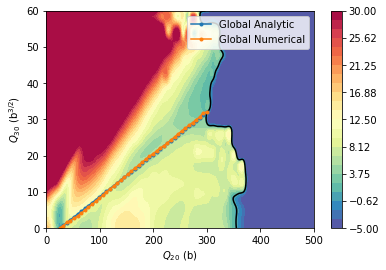

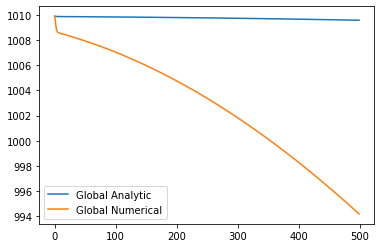

In [6]:
fIn = "..//..//PES/232U.h5"
dsets, attrs = read_from_h5(fIn)

coordStrs = ["Q20","Q30"]

uniqueCoords = [np.unique(dsets[key]) for key in coordStrs]

gridShape = [len(np.unique(dsets[key])) for key in coordStrs]

coordMesh = tuple([dsets[key].reshape(gridShape) for key in coordStrs])
zz = dsets["PES"].reshape(gridShape)

#potential = py_neb.auxiliary_potential(py_neb.NDInterpWithBoundary(uniqueCoords,zz),\
#                                 shift=0.5)
potential = py_neb.auxiliary_potential(py_neb.RectBivariateSplineWrapper(*uniqueCoords,zz).function)

#Finding initial path
gsLoc = np.array([attrs["Ground_State"][key] for key in coordStrs]).flatten()
eGS = potential(gsLoc)
#eGS=0.0
#gsLoc=np.zeros(2)
#gsLoc[0]=25.0
#gsLoc[1]=0.0
nPts = 42
initPath = np.array((np.linspace(gsLoc[0],300,nPts),\
                     np.linspace(gsLoc[1],32,nPts))).T
#print(initPath)
f, a = standard_pes(*coordMesh,zz)
a.contour(*coordMesh,zz,levels=[eGS],colors=["black"])

lap = py_neb.LeastActionPath(potential,nPts,2,\
                             target_func_grad=analytic_action_grad,\
                             target_func=localAction,\
                             nebParams={"k":10,"kappa":1},\
                             endpointSpringForce=(False,False),\
                             endpointHarmonicForce=(False,False))
'''
lap = py_neb.LeastActionPath(potential,nPts,2,\
                             nebParams={"k":1,"kappa":1},\
                             endpointSpringForce=(False,True),\
                             endpointHarmonicForce=(False,True))
'''
maxIters = 500
tStep = 0.1

minObj = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj.fire(tStep,maxIters)

lap = py_neb.LeastActionPath(potential,nPts,2,\
                             #target_func_grad=local_action_grad,\
                             target_func=localAction,\
                             nebParams={"k":10,"kappa":1},\
                             endpointSpringForce=(False,False),\
                             endpointHarmonicForce=(False,False))

minObj2 = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj2.fire(tStep,maxIters)

# allPts, allVelocities, allForces = \
#     minObj.velocity_verlet(tStep,maxIters)
a.plot(minObj.allPts[-1,:,0],minObj.allPts[-1,:,1],marker=".",label="Global Analytic")
a.plot(minObj2.allPts[-1,:,0],minObj2.allPts[-1,:,1],marker=".",label="Global Numerical")
a.legend()
# print("Slow interpolator time: "+str(t1 - t0))
# print("Slow interpolator action: "+str(actions[-1]))

actions = np.array([py_neb.action(minObj.allPts[i],potential)[0] for i in range(maxIters)])
actions2 = np.array([py_neb.action(minObj2.allPts[i],potential)[0] for i in range(maxIters)])
# print(actions)
actionFig, actionAx = plt.subplots()
actionAx.plot(actions,label="Global Analytic")
actionAx.plot(actions2,label="Global Numerical")

actionAx.legend()

#print(potential(minObj.allPts[-1]))
print("Final Global Analytic: ",actions[-1])
print("Final Global Numerical: ",actions2[-1])

Final Point:  [298.   31.3]
Final Global Numerical:  911.2823481306667


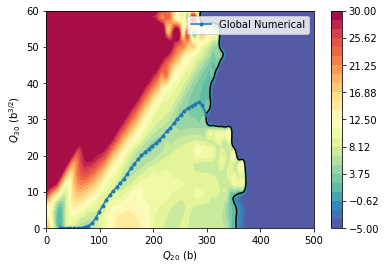

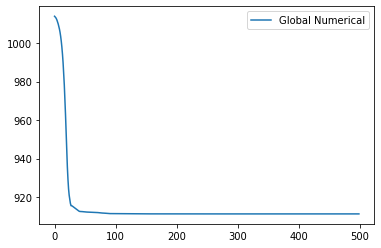

In [9]:
fIn = "..//..//PES/232U.h5"
dsets, attrs = read_from_h5(fIn)

coordStrs = ["Q20","Q30"]

uniqueCoords = [np.unique(dsets[key]) for key in coordStrs]

gridShape = [len(np.unique(dsets[key])) for key in coordStrs]

coordMesh = tuple([dsets[key].reshape(gridShape) for key in coordStrs])
zz = dsets["PES"].reshape(gridShape)

#potential = py_neb.auxiliary_potential(py_neb.NDInterpWithBoundary(uniqueCoords,zz),\
#                                 shift=0.5)
potential = py_neb.auxiliary_potential(py_neb.RectBivariateSplineWrapper(*uniqueCoords,zz).function)
mass_grids = {key: py_neb.GridInterpWithBoundary(uniq_coords,mass_grids[key],boundaryHandler='exponential',minVal=0) \
              for key in mass_keys}
# function returns matrix of functions
M_func = py_neb.mass_funcs_to_array_func(mass_grids,mass_tensor_indicies)
# Sylvester MP endpoint: (Q20=298.0 , Q30=31.3)
#Finding initial path
gsLoc = np.array([attrs["Ground_State"][key] for key in coordStrs]).flatten()
eGS = potential(gsLoc)
#eGS=0.0
#gsLoc=np.zeros(2)
#gsLoc[0]=25.0
#gsLoc[1]=0.0
# Sylvester MP endpoint: (Q20=298.0 , Q30=31.3)

nPts = 42
#initPath = np.array((np.linspace(gsLoc[0],300,nPts),\
#                     np.linspace(gsLoc[1],32,nPts))).T
initPath = np.array((np.linspace(gsLoc[0],298,nPts),\
                     np.linspace(gsLoc[1],31.3,nPts))).T
#print(initPath)
f, a = standard_pes(*coordMesh,zz)
a.contour(*coordMesh,zz,levels=[eGS],colors=["black"])

lap = py_neb.LeastActionPath(potential,nPts,2,\
                             target_func_grad=analytic_action_grad,\
                             target_func=localAction,\
                             nebParams={"k":10,"kappa":1},\
                             endpointSpringForce=(False,False),\
                             endpointHarmonicForce=(False,False))
'''
lap = py_neb.LeastActionPath(potential,nPts,2,\
                             nebParams={"k":1,"kappa":1},\
                             endpointSpringForce=(False,True),\
                             endpointHarmonicForce=(False,True))
'''
maxIters = 500
tStep = 0.1

minObj = py_neb.VerletMinimization(lap,initPath)
#tStepArr, alphaArr, _ = minObj.fire(tStep,maxIters,\
#                                    fireParams={"dtMax":10.,"dtMin":0.0001,"nAccel":10,"fInc":1.1,"fAlpha":0.99,\
#                                    "fDecel":0.5,"aStart":0.1},useLocal=True)

lap = py_neb.LeastActionPath(potential,nPts,2,\
                             #target_func_grad=local_action_grad,\
                             target_func=localAction,\
                             nebParams={"k":10,"kappa":1},\
                             endpointSpringForce=(False,False),\
                             endpointHarmonicForce=(False,False))

minObj2 = py_neb.VerletMinimization(lap,initPath)
tStepArr, alphaArr, _ = minObj2.fire(tStep,maxIters,useLocal=True)

# allPts, allVelocities, allForces = \
#     minObj.velocity_verlet(tStep,maxIters)
#a.plot(minObj.allPts[-1,:,0],minObj.allPts[-1,:,1],marker=".",label="Global Analytic")
a.plot(minObj2.allPts[-1,:,0],minObj2.allPts[-1,:,1],marker=".",label="Global Numerical")
a.legend()
# print("Slow interpolator time: "+str(t1 - t0))
# print("Slow interpolator action: "+str(actions[-1]))

#actions = np.array([py_neb.action(minObj.allPts[i],potential)[0] for i in range(maxIters)])
actions2 = np.array([py_neb.action(minObj2.allPts[i],potential)[0] for i in range(maxIters)])
# print(actions)
actionFig, actionAx = plt.subplots()
#actionAx.plot(actions,label="Global Analytic")
actionAx.plot(actions2,label="Global Numerical")

actionAx.legend()

print("Final Point: ",minObj2.allPts[-1,-1])
#print("Final Global Analytic: ",actions[-1])
print("Final Global Numerical: ",actions2[-1])